# REINFORCE in TensorFlow

Just like we did before for q-learning, this time we'll design a neural network to learn `CartPole-v0` via policy gradient (REINFORCE).

In [1]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it

import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


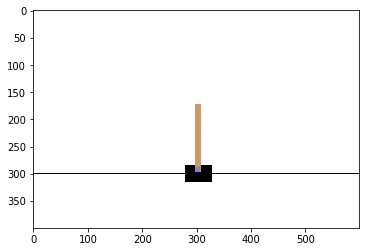

In [2]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env,'env'):
    env=env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the policy network

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__. 

We'll use softmax or log-softmax where appropriate.

In [3]:
import tensorflow as tf

# create input variables. We only need <s,a,R> for REINFORCE
states = tf.placeholder('float32', (None,)+state_dim, name="states")
actions = tf.placeholder('int32', name="action_ids")
cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")

In [4]:
# Define NN Design below

# Import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# as first layer in a sequential model:
model = Sequential()
model.add(Dense(32, input_shape=(state_dim)))
model.add(Dense(32))
model.add(Dense(32))
model.add(Dense(n_actions))

logits = model(states)

policy = tf.nn.softmax(logits)
log_policy = tf.nn.log_softmax(logits)

W1028 10:33:50.461633 140010769708800 deprecation.py:506] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
# utility function to pick action in one given state
def get_action_proba(s): 
    return policy.eval({states: [s]})[0]

#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [6]:
# select log-probabilities for chosen actions, log pi(a_i|s_i)
indices = tf.stack([tf.range(tf.shape(log_policy)[0]), actions], axis=-1)
log_policy_for_actions = tf.gather_nd(log_policy, indices)

In [7]:
# REINFORCE objective function
# hint: you need to use log_policy_for_actions to get log probabilities for actions taken

J = tf.reduce_mean(log_policy_for_actions * cumulative_rewards)

In [8]:
# regularize with entropy
entropy = tf.reduce_sum(policy * log_policy, 1)

In [9]:
# all network weights
all_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

# weight updates. maximizing J is same as minimizing -J. Adding negative entropy.
loss = -J - 0.1*entropy

update = tf.train.AdamOptimizer().minimize(loss, var_list=all_weights)

### Computing cumulative rewards

In [18]:
def get_cumulative_rewards(rewards,    # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """

    # Init array with appropriate length
    reward_array = [0] * len(rewards)
    
    # Init last object for first call
    reward_array[-1] = rewards[-1]
    
    # For i-1 to 0, compute cumulative rewards
    for i in reversed(range(len(rewards)-1)):
        reward_array[i] = rewards[i] + gamma* reward_array[i+1] 

    #print(len(reward_array))
    return reward_array

In [19]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
                   [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
                   [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
                   [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


In [20]:
def train_step(_states, _actions, _rewards):
    """given full session, trains agent with policy gradient"""
    _cumulative_rewards = get_cumulative_rewards(_rewards)
    update.run({states: _states, actions: _actions,
                cumulative_rewards: _cumulative_rewards})

### Playing the game

In [28]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""

    # arrays to record session
    states, actions, rewards = [], [], []

    s = env.reset()

    for t in range(t_max):

        # action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s)
        print(action_probas)

        a = np.random.choice(a = [0, 1], p = action_probas)
        print(a)
        
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    train_step(states, actions, rewards)

    # technical: return session rewards to print them later
    return sum(rewards)

In [ ]:
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

for i in range(100):

    rewards = [generate_session() for _ in range(100)]  # generate new sessions

    print("mean reward:%.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 300:
        print("You Win!") # but you can train even further
        break

[0.5012661  0.49873388]
1
[0.5143116 0.4856884]
0
[0.5002208  0.49977925]
1
[0.51333797 0.486662  ]
1
[0.52582407 0.47417593]
1
[0.53768337 0.4623166 ]
0
[0.52252036 0.47747964]
1
[0.53449285 0.46550718]
0
[0.5194001  0.48059985]
0
[0.50494426 0.49505574]
1
[0.5176453  0.48235464]
1
[0.5296696 0.4703304]
1
[0.54101753 0.4589824 ]
0
[0.5253409  0.47465906]
0
[0.51026434 0.48973563]
1
[0.52224237 0.47775757]
0
[0.507092   0.49290797]
1
[0.5189459  0.48105413]
1
[0.50067973 0.49932024]
1
[0.52382225 0.4761778 ]
0
[0.49970686 0.50029314]
0
[0.47618258 0.5238174 ]
1
[0.4999604  0.50003964]
1
[0.5231816  0.47681844]
1
[0.54579604 0.4542039 ]
1
[0.5677632 0.4322368]
1
[0.5890494  0.41095057]
0
[0.56427884 0.43572107]
1
[0.5858888  0.41411123]
1
[0.60675895 0.39324108]
0
[0.582166 0.417834]
0
[0.5578554 0.4421445]
0
[0.5339145  0.46608558]
0
[0.51041436 0.48958564]
1
[0.53401047 0.4659895 ]
0
[0.5104955  0.48950452]
0
[0.48748067 0.51251936]
1
[0.511535   0.48846495]
1
[0.5349293  0.46507075]


[0.7273845  0.27261546]
0
[0.6258991  0.37410092]
0
[0.51236206 0.4876379 ]
1
[0.6389557 0.3610443]
0
[0.5267663  0.47323373]
0
[0.4118488  0.58815116]
1
[0.5411442  0.45885578]
0
[0.42564312 0.57435685]
0
[0.31747454 0.68252546]
1
[0.43846998 0.56153   ]
1
[0.56718695 0.43281308]
1
[0.6877302  0.31226987]
0
[0.580473 0.419527]
0
[0.4654777  0.53452224]
0
[0.35404962 0.6459504 ]
1
[0.479982 0.520018]
0
[0.36716005 0.6328399 ]
1
[0.49401706 0.50598294]
0
[0.38020724 0.6197928 ]
0
[0.27804214 0.72195786]
1
[0.39266986 0.60733014]
0
[0.28810915 0.7118909 ]
1
[0.40408036 0.5959196 ]
1
[0.5319463 0.4680537]
0
[0.41567725 0.5843228 ]
1
[0.5443694  0.45563066]
1
[0.66790915 0.33209085]
1
[0.77267295 0.22732703]
0
[0.683297   0.31670302]
0
[0.5792975  0.42070243]
1
[0.7017698 0.2982301]
1
[0.8015346  0.19846542]
0
[0.46302488 0.5369752 ]
0
[0.33523646 0.66476357]
1
[0.4604427  0.53955734]
0
[0.33238462 0.6676154 ]
1
[0.45662272 0.5433772 ]
0
[0.32842356 0.6715765 ]
1
[0.4515088 0.5484913]
1
[0

1
[0.87650436 0.12349557]
0
[0.7752754  0.22472455]
1
[0.42257756 0.5774224 ]
1
[0.6369257  0.36307436]
1
[0.8086604  0.19133958]
0
[0.63961726 0.36038274]
1
[0.811912   0.18808804]
0
[0.64667946 0.3533205 ]
0
[0.4372619  0.56273806]
0
[0.24763398 0.752366  ]
0
[0.12174404 0.87825596]
1
[0.25067586 0.7493242 ]
0
[0.12232135 0.8776787 ]
1
[0.24976957 0.7502304 ]
1
[0.44265062 0.5573493 ]
0
[0.2470752 0.7529248]
1
[0.4382748 0.5617252]
0
[0.24317522 0.7568248 ]
0
[0.1162902 0.8837098]
1
[0.23603465 0.76396537]
0
[0.1112884 0.8887116]
1
[0.22524798 0.774752  ]
1
[0.4024454  0.59755456]
0
[0.21293801 0.78706205]
1
[0.3840703  0.61592966]
1
[0.5898673  0.41013268]
0
[0.36607456 0.6339254 ]
0
[0.18766592 0.8123341 ]
1
[0.3461775 0.6538225]
0
[0.17384045 0.8261596 ]
1
[0.32355314 0.67644686]
1
[0.5206389  0.47936112]
1
[0.7119981  0.28800192]
0
[0.49589655 0.50410336]
1
[0.6921653  0.30783474]
0
[0.47289354 0.5271065 ]
1
[0.6727941 0.3272059]
0
[0.45107076 0.5489293 ]
1
[0.6534827  0.34651738

0
[0.35785273 0.64214724]
0
[0.1684633 0.8315367]
1
[0.32935032 0.67064965]
1
[0.54269785 0.45730206]
1
[0.74161696 0.2583831 ]
1
[0.87461686 0.12538308]
0
[0.717901   0.28209898]
0
[0.4809484 0.5190516]
1
[0.6930523  0.30694765]
1
[0.8465704  0.15342963]
1
[0.9313964  0.06860355]
0
[0.8337598  0.16624025]
0
[0.64941716 0.3505828 ]
1
[0.82135415 0.1786459 ]
0
[0.62967634 0.37032366]
1
[0.8085854  0.19141458]
1
[0.91335124 0.08664874]
0
[0.7971767  0.20282322]
0
[0.593958   0.40604198]
0
[0.3511904 0.6488096]
0
[0.16552684 0.83447313]
1
[0.3259991  0.67400086]
1
[0.5395047  0.46049526]
0
[0.29644123 0.70355886]
0
[0.13036646 0.86963356]
1
[0.26027662 0.7397234 ]
1
[0.44997305 0.55002695]
1
[0.65413046 0.34586954]
1
[0.81356275 0.18643725]
0
[0.603869 0.396131]
1
[0.77767503 0.22232495]
0
[0.5486266 0.4513734]
1
[0.73429424 0.26570582]
0
[0.48795143 0.51204854]
0
[0.4662838  0.53371614]
1
[0.6895691  0.31043088]
1
[0.8504776  0.14952241]
0
[0.6888268  0.31117317]
0
[0.46319783 0.5368021 

[0.4113595 0.5886405]
1
[0.6238502  0.37614983]
1
[0.798298   0.20170204]
0
[0.61834013 0.3816599 ]
1
[0.79610735 0.20389265]
0
[0.61731136 0.38268864]
1
[0.79692173 0.20307826]
0
[0.6206477 0.3793523]
0
[0.40550002 0.5945    ]
0
[0.22069398 0.779306  ]
1
[0.40712118 0.5928788 ]
1
[0.62504965 0.37495038]
0
[0.40856454 0.5914355 ]
1
[0.62673694 0.3732631 ]
1
[0.8040319  0.19596808]
0
[0.6321502  0.36784986]
0
[0.41859618 0.58140385]
1
[0.6388649  0.36113515]
0
[0.42605928 0.5739407 ]
0
[0.23685294 0.76314706]
1
[0.4311688 0.5688312]
1
[0.64966655 0.35033348]
0
[0.43660286 0.5633971 ]
0
[0.24399875 0.75600123]
1
[0.439949 0.560051]
1
[0.6570308 0.3429692]
0
[0.44386682 0.5561332 ]
1
[0.6612282 0.3387718]
0
[0.44921038 0.55078965]
0
[0.25358918 0.7464108 ]
1
[0.4527621  0.54723793]
0
[0.25535056 0.7446494 ]
0
[0.12367117 0.8763288 ]
1
[0.25274554 0.74725443]
1
[0.44724557 0.55275434]
1
[0.6598421  0.34015796]
0
[0.44284633 0.55715364]
1
[0.65657485 0.34342512]
1
[0.8222892  0.17771083]
1


1
[0.52872443 0.47127554]
1
[0.765667   0.23433304]
0
[0.5618638 0.4381362]
1
[0.7901379 0.2098621]
0
[0.5988676 0.4011324]
0
[0.3718339 0.6281661]
0
[0.1893407 0.8106593]
1
[0.40550494 0.59449506]
1
[0.6667354 0.3332646]
0
[0.4417539  0.55824614]
1
[0.6999808  0.30001917]
0
[0.48172995 0.51827013]
0
[0.26992923 0.73007077]
0
[0.12751181 0.87248814]
1
[0.2989958 0.7010042]
0
[0.14313804 0.85686195]
1
[0.32635581 0.6736442 ]
1
[0.5851779  0.41482207]
0
[0.35622904 0.643771  ]
0
[0.17789154 0.82210845]
1
[0.38575625 0.61424375]
1
[0.6470151  0.35298482]
0
[0.4193291  0.58067083]
1
[0.67994434 0.32005563]
1
[0.86337453 0.13662553]
0
[0.71905607 0.28094393]
0
[0.5105525 0.4894474]
0
[0.2986653 0.7013347]
0
[0.14773318 0.8522668 ]
1
[0.34158048 0.6584195 ]
1
[0.6097479  0.39025205]
1
[0.8262786  0.17372134]
1
[0.93630326 0.06369673]
0
[0.86275214 0.13724786]
0
[0.73154056 0.26845944]
0
[0.42543846 0.57456154]
1
[0.669887   0.33011296]
1
[0.8486968  0.15130308]
1
[0.9401757  0.05982427]
0
[0

[0.42858642 0.5714135 ]
1
[0.6909407  0.30905932]
0
[0.46426836 0.5357316 ]
0
[0.2518435 0.7481565]
1
[0.5033026 0.4966975]
0
[0.2839882 0.7160118]
1
[0.54603094 0.4539691 ]
0
[0.32231078 0.67768925]
1
[0.59281135 0.4071886 ]
0
[0.36835143 0.63164854]
1
[0.64357543 0.35642457]
0
[0.42361966 0.5763803 ]
1
[0.69760513 0.30239493]
1
[0.88021135 0.11978864]
0
[0.7573669  0.24263306]
0
[0.57312965 0.42687038]
0
[0.40798503 0.59201497]
0
[0.20277117 0.7972289 ]
1
[0.4223433 0.5776567]
1
[0.6786089  0.32139114]
0
[0.4390714  0.56092864]
0
[0.22429682 0.7757032 ]
1
[0.4543203 0.5456797]
0
[0.23455665 0.7654434 ]
0
[0.10059931 0.8994007 ]
1
[0.24064548 0.75935453]
1
[0.47332034 0.5266797 ]
1
[0.7193944  0.28060564]
0
[0.4843828 0.5156172]
1
[0.7299279 0.2700721]
0
[0.49985632 0.50014365]
1
[0.74366325 0.25633675]
0
[0.52003044 0.47996962]
0
[0.28778774 0.7122122 ]
1
[0.54048985 0.45951018]
0
[0.3050626  0.69493747]
1
[0.5612815  0.43871853]
1
[0.7898496  0.21015036]
0
[0.5875092  0.41249076]
1


1
[0.47081104 0.52918893]
0
[0.24073444 0.75926554]
1
[0.44182622 0.5581738 ]
1
[0.66500455 0.3349955 ]
0
[0.4158675  0.58413255]
1
[0.64235926 0.3576407 ]
0
[0.39282766 0.6071723 ]
1
[0.62113017 0.3788698 ]
0
[0.37202314 0.6279769 ]
0
[0.17548184 0.82451814]
1
[0.3484978 0.6515022]
0
[0.1600462 0.8399537]
1
[0.32158884 0.6784111 ]
0
[0.14326487 0.8567351 ]
1
[0.29133287 0.70866716]
1
[0.50260496 0.49739513]
1
[0.71398574 0.28601426]
0
[0.46942687 0.5305732 ]
0
[0.23790258 0.7620974 ]
1
[0.43475989 0.5652401 ]
0
[0.21250212 0.7874978 ]
1
[0.39754704 0.60245293]
1
[0.6178489 0.3821511]
0
[0.36194226 0.6380577 ]
1
[0.5817173 0.4182827]
1
[0.77427554 0.22572449]
0
[0.5487027  0.45129725]
0
[0.30036595 0.699634  ]
1
[0.51432174 0.48567832]
0
[0.2713251  0.72867495]
0
[0.11477197 0.885228  ]
1
[0.23833574 0.7616642 ]
0
[0.09681628 0.90318376]
1
[0.20213068 0.7978693 ]
1
[0.37323847 0.62676156]
1
[0.58321786 0.4167821 ]
0
[0.3217415  0.67825854]
1
[0.52610224 0.47389776]
1
[0.72267854 0.2773

1
[0.60089314 0.39910677]
1
[0.8373343  0.16266574]
0
[0.67007387 0.3299261 ]
0
[0.44649822 0.5535018 ]
1
[0.7373237  0.26267624]
1
[0.9083397 0.0916603]
0
[0.8038498  0.19615017]
0
[0.63174814 0.36825186]
0
[0.43022838 0.5697716 ]
0
[0.20268813 0.79731184]
1
[0.4406994  0.55930066]
0
[0.20864429 0.7913557 ]
1
[0.44833013 0.55166996]
1
[0.7157161  0.28428394]
0
[0.45864996 0.54135007]
1
[0.72557306 0.2744269 ]
0
[0.47278258 0.5272174 ]
0
[0.23262328 0.7673767 ]
1
[0.485674 0.514326]
1
[0.7474111  0.25258893]
1
[0.9037121  0.09628793]
0
[0.7652493  0.23475069]
0
[0.5320772 0.4679228]
0
[0.283635 0.716365]
1
[0.5593206 0.4406794]
0
[0.3063183  0.69368166]
1
[0.58602846 0.41397154]
1
[0.8206585 0.1793415]
0
[0.6178736  0.38212636]
1
[0.84124625 0.15875377]
0
[0.65555537 0.3444446 ]
1
[0.86362123 0.13637878]
0
[0.69851816 0.30148184]
0
[0.45956507 0.5404349 ]
0
[0.23732078 0.7626792 ]
1
[0.50950164 0.4904984 ]
1
[0.7774096  0.22259042]
0
[0.5636243  0.43637565]
0
[0.32324815 0.67675185]
0


[0.517858   0.48214197]
1
[0.80336136 0.19663864]
1
[0.94034046 0.05965957]
0
[0.85052663 0.14947334]
1
[0.9574232  0.04257681]
0
[0.8935575  0.10644248]
1
[0.97149414 0.0285059 ]
0
[0.92974144 0.07025855]
0
[0.83907676 0.16092321]
0
[0.46020246 0.53979754]
0
[0.20995127 0.7900487 ]
0
[0.07562903 0.92437094]
0
[0.02411099 0.97588897]
1
[0.07541177 0.92458826]
1
[0.2108421 0.7891579]
0
[0.07224297 0.92775697]
1
[0.1999908  0.80000913]
1
[0.44481632 0.5551837 ]
0
[0.18713106 0.8128689 ]
1
[0.42277995 0.5772201 ]
1
[0.7007039 0.2992961]
0
[0.4031882  0.59681183]
1
[0.68466204 0.31533793]
0
[0.38625467 0.61374533]
0
[0.1533543 0.8466457]
1
[0.36568347 0.63431656]
1
[0.6479484  0.35205162]
0
[0.3462484 0.6537516]
0
[0.13132536 0.8686746 ]
1
[0.3226955 0.6773045]
1
[0.60067296 0.399327  ]
0
[0.29968482 0.7003152 ]
0
[0.10762501 0.892375  ]
1
[0.27240798 0.72759205]
0
[0.09417101 0.905829  ]
1
[0.24080335 0.75919664]
0
[0.07974121 0.9202588 ]
1
[0.20587008 0.7941299 ]
1
[0.43622163 0.5637784 

0
[0.6611218 0.3388782]
0
[0.4147339 0.5852661]
0
[0.20368852 0.7963115 ]
1
[0.4396686 0.5603314]
1
[0.7072858  0.29271415]
1
[0.88263595 0.11736407]
0
[0.7344049  0.26559505]
0
[0.5048756 0.4951244]
0
[0.27251568 0.7274843 ]
1
[0.5391962  0.46080378]
1
[0.7862325  0.21376759]
0
[0.57660955 0.42339042]
1
[0.8121742  0.18782583]
0
[0.618467   0.38153306]
0
[0.37783375 0.6221663 ]
0
[0.18421978 0.81578016]
1
[0.41518572 0.5848143 ]
0
[0.20681018 0.7931898 ]
1
[0.4481116 0.5518884]
0
[0.22790493 0.772095  ]
1
[0.47698176 0.5230183 ]
0
[0.24744551 0.7525545 ]
1
[0.50231296 0.4976871 ]
0
[0.26551127 0.7344888 ]
1
[0.52467525 0.47532466]
0
[0.28227964 0.7177204 ]
1
[0.5446387 0.4553613]
1
[0.78545886 0.21454114]
0
[0.56840837 0.4315917 ]
1
[0.8029478  0.19705214]
0
[0.5974084  0.40259165]
0
[0.3505735  0.64942646]
0
[0.16306175 0.83693826]
1
[0.3735835 0.6264165]
1
[0.64664054 0.35335943]
0
[0.39668563 0.6033144 ]
0
[0.19010538 0.8098946 ]
1
[0.4160731 0.5839269]
1
[0.6846098  0.31539017]
0


0
[0.35215494 0.64784503]
0
[0.17893907 0.82106096]
1
[0.3825423 0.6174577]
0
[0.19642432 0.8035757 ]
1
[0.40679947 0.59320056]
1
[0.6583761  0.34162387]
0
[0.43045136 0.5695486 ]
1
[0.680209   0.31979102]
0
[0.4553205 0.5446795]
0
[0.24618138 0.75381863]
1
[0.476436 0.523564]
1
[0.7178394  0.28216058]
0
[0.49842554 0.50157446]
1
[0.73626745 0.26373258]
0
[0.5230701 0.4769299]
0
[0.30024406 0.6997559 ]
1
[0.5453177  0.45468235]
1
[0.7711232  0.22887686]
0
[0.56988233 0.43011767]
0
[0.3418981 0.6581019]
1
[0.5930104  0.40698957]
0
[0.36264566 0.6373543 ]
1
[0.61402893 0.38597104]
0
[0.38251364 0.61748636]
0
[0.193005 0.806995]
1
[0.3966397  0.60336024]
0
[0.19996406 0.80003595]
1
[0.4038719  0.59612817]
0
[0.20249079 0.79750913]
1
[0.40436685 0.59563315]
0
[0.20058644 0.79941356]
1
[0.3982328  0.60176724]
1
[0.6359068  0.36409315]
1
[0.8228228  0.17717718]
0
[0.63374865 0.36625126]
1
[0.82339877 0.17660123]
0
[0.6376753  0.36232477]
1
[0.8277221  0.17227793]
0
[0.64761895 0.35238108]
0


1
[0.38602814 0.6139719 ]
0
[0.19920096 0.8007991 ]
1
[0.34274086 0.65725917]
1
[0.5219242  0.47807586]
1
[0.69671214 0.3032879 ]
1
[0.8302189  0.16978107]
0
[0.6637287  0.33627132]
0
[0.44371727 0.55628276]
1
[0.6333211  0.36667892]
1
[0.790584   0.20941596]
0
[0.60872155 0.39127848]
1
[0.7757529  0.22424711]
1
[0.8864864  0.11351366]
0
[0.7692841  0.23071592]
0
[0.58885604 0.41114396]
0
[0.38082883 0.6191712 ]
1
[0.5866418  0.41335818]
0
[0.37892467 0.62107533]
1
[0.5849248  0.41507518]
0
[0.37748298 0.622517  ]
0
[0.20581849 0.7941815 ]
1
[0.37153333 0.62846667]
1
[0.5744387 0.4255613]
0
[0.36475402 0.6352459 ]
1
[0.5674088  0.43259117]
0
[0.35818693 0.64181316]
1
[0.56043035 0.43956968]
0
[0.35166383 0.6483362 ]
0
[0.18635938 0.81364065]
1
[0.34027058 0.6597295 ]
1
[0.53735846 0.46264163]
0
[0.3275621 0.6724379]
1
[0.5227784  0.47722164]
0
[0.3144342 0.6855658]
0
[0.15995558 0.84004444]
1
[0.29618794 0.70381206]
1
[0.48155776 0.51844233]
1
[0.6732783  0.32672176]
1
[0.82223785 0.17

0
[0.55225253 0.4477474 ]
1
[0.684982 0.315018]
1
[0.79597384 0.20402619]
0
[0.6729616  0.32703844]
0
[0.52196264 0.47803733]
1
[0.66916305 0.33083695]
0
[0.5218193  0.47818074]
0
[0.37070167 0.62929827]
0
[0.24029732 0.7597027 ]
1
[0.36958545 0.6304146 ]
1
[0.5218476  0.47815242]
1
[0.67243195 0.32756808]
0
[0.52924025 0.4707598 ]
1
[0.68259925 0.31740075]
0
[0.5451124  0.45488763]
1
[0.6998604  0.30013958]
0
[0.569572 0.430428]
0
[0.429371 0.570629]
1
[0.5973486  0.40265137]
0
[0.45957288 0.5404271 ]
0
[0.32704914 0.6729508 ]
0
[0.2158597  0.78414035]
1
[0.34831548 0.6516845 ]
0
[0.22992045 0.7700796 ]
1
[0.36423206 0.63576794]
1
[0.5242325 0.4757675]
1
[0.68118805 0.31881195]
0
[0.54653335 0.45346665]
0
[0.40452814 0.5954719 ]
0
[0.275568 0.724432]
0
[0.17378649 0.82621354]
1
[0.28469703 0.715303  ]
1
[0.42913172 0.57086825]
1
[0.58768237 0.41231763]
0
[0.43883 0.56117]
0
[0.29904535 0.7009547 ]
1
[0.44531903 0.5546809 ]
0
[0.3030015  0.69699854]
0
[0.18879065 0.8112093 ]
1
[0.29944

1
[0.44805232 0.5519477 ]
1
[0.54627115 0.45372885]
1
[0.64677584 0.35322407]
1
[0.7416744  0.25832552]
0
[0.6848104 0.3151896]
0
[0.62608236 0.37391767]
0
[0.56674236 0.43325755]
1
[0.68651366 0.31348637]
1
[0.7900087 0.2099913]
0
[0.75993925 0.24006066]
0
[0.7308333 0.2691667]
1
[0.43245012 0.56754994]
1
[0.5222295  0.47777054]
0
[0.43953395 0.560466  ]
1
[0.5304595  0.46954054]
0
[0.44878983 0.5512102 ]
1
[0.5409182  0.45908177]
0
[0.46043882 0.5395612 ]
0
[0.3802159 0.6197841]
0
[0.30330905 0.6966909 ]
1
[0.38036063 0.61963946]
0
[0.2999834  0.70001656]
1
[0.3729044  0.62709564]
1
[0.45259407 0.54740596]
1
[0.53661513 0.4633849 ]
0
[0.44805673 0.5519433 ]
0
[0.36089206 0.639108  ]
0
[0.27935812 0.7206418 ]
1
[0.34580523 0.65419483]
1
[0.41915002 0.58085   ]
0
[0.3290348 0.6709652]
1
[0.3992186  0.60078144]
1
[0.47528583 0.5247142 ]
1
[0.5553302  0.44466975]
0
[0.46418166 0.53581834]
1
[0.54759866 0.4524013 ]
1
[0.6322678  0.36773223]
1
[0.7140058 0.2859942]
1
[0.7883927  0.21160728

[0.31542096 0.6845791 ]
0
[0.2437164 0.7562836]
0
[0.18224406 0.81775594]
1
[0.22452565 0.7754743 ]
1
[0.27472365 0.7252763 ]
1
[0.3341277 0.6658723]
1
[0.40366092 0.5963391 ]
0
[0.32851455 0.67148554]
0
[0.26084468 0.73915523]
0
[0.20171101 0.79828906]
0
[0.15153287 0.8484672 ]
0
[0.11024777 0.8897522 ]
1
[0.13831903 0.861681  ]
1
[0.17205356 0.8279465 ]
0
[0.12401184 0.8759882 ]
1
[0.15287519 0.8471248 ]
1
[0.1875794  0.81242055]
0
[0.1353421 0.8646579]
0
[0.09458806 0.9054119 ]
1
[0.11497477 0.8850252 ]
1
[0.13924186 0.8607581 ]
1
[0.16860032 0.8313997 ]
0
[0.11947829 0.8805217 ]
1
[0.1453413  0.85465866]
1
[0.17727362 0.82272637]
1
[0.21724474 0.78275526]
0
[0.16126814 0.8387319 ]
0
[0.11705185 0.88294816]
1
[0.14710298 0.852897  ]
1
[0.18545541 0.8145446 ]
1
[0.2346981 0.7653019]
1
[0.29767874 0.70232123]
1
[0.37671942 0.6232805 ]
1
[0.4720457 0.5279542]
1
[0.5796858  0.42031416]
0
[0.5385773  0.46142268]
1
[0.65831864 0.3416814 ]
0
[0.6383308  0.36166915]
1
[0.7566451  0.24335492

[0.6688745  0.33112547]
0
[0.5474273  0.45257267]
0
[0.4177116  0.58228844]
0
[0.2951013  0.70489866]
1
[0.43620223 0.56379783]
1
[0.5904943  0.40950575]
1
[0.7317356  0.26826444]
0
[0.61908686 0.38091323]
0
[0.49005586 0.5099441 ]
1
[0.6447456  0.35525438]
0
[0.518065 0.481935]
0
[0.38584387 0.6141562 ]
1
[0.53835744 0.46164256]
0
[0.40295103 0.59704894]
0
[0.2769996 0.7230004]
1
[0.40749326 0.5925067 ]
1
[0.5537164  0.44628352]
0
[0.41068318 0.58931684]
0
[0.27753544 0.72246456]
0
[0.17113464 0.82886535]
1
[0.2588506 0.7411494]
0
[0.15362656 0.84637344]
1
[0.22867428 0.77132577]
1
[0.32543263 0.67456734]
1
[0.44036815 0.5596318 ]
1
[0.5641988  0.43580118]
0
[0.40112513 0.59887487]
1
[0.5242985  0.47570145]
0
[0.36288384 0.6371162 ]
0
[0.22452803 0.775472  ]
1
[0.31714767 0.68285227]
1
[0.4281994  0.57180065]
1
[0.5498324 0.4501676]
1
[0.6697614  0.33023858]
0
[0.5169304  0.48306963]
1
[0.6441842  0.35581586]
1
[0.75817823 0.24182177]
0
[0.6333406  0.36665943]
0
[0.4871094 0.5128905]


[0.40179092 0.5982091 ]
1
[0.55986285 0.44013712]
1
[0.71108586 0.28891414]
1
[0.8305272  0.16947278]
1
[0.9100212  0.08997886]
0
[0.8285341 0.1714659]
1
[0.9130678  0.08693217]
0
[0.84023046 0.15976954]
0
[0.72629154 0.27370837]
1
[0.8584431  0.14155689]
0
[0.7603158  0.23968421]
0
[0.6245694  0.37543064]
1
[0.7964543  0.20354567]
0
[0.67781717 0.32218283]
0
[0.53009826 0.46990177]
0
[0.37463507 0.62536496]
0
[0.23827748 0.7617225 ]
1
[0.4169791 0.5830209]
1
[0.62318563 0.37681434]
0
[0.46418154 0.53581846]
0
[0.30908325 0.6909167 ]
1
[0.5040434  0.49595657]
0
[0.34201664 0.6579834 ]
1
[0.5397363  0.46026367]
0
[0.37317672 0.6268233 ]
1
[0.5719085  0.42809156]
0
[0.4028265  0.59717345]
1
[0.6012631 0.3987368]
0
[0.43136004 0.56864   ]
1
[0.62849075 0.37150925]
0
[0.459251 0.540749]
0
[0.29537717 0.7046228 ]
1
[0.4769786  0.52302146]
0
[0.30719152 0.69280845]
0
[0.17392296 0.8260771 ]
0
[0.0883586 0.9116414]
1
[0.16276802 0.837232  ]
1
[0.27961954 0.7203805 ]
1
[0.43711478 0.56288517]


[0.25290495 0.74709505]
1
[0.42668965 0.57331043]
1
[0.62416095 0.37583902]
0
[0.40569422 0.5943059 ]
1
[0.605725   0.39427504]
0
[0.38875195 0.611248  ]
1
[0.5904576 0.4095424]
0
[0.3752048  0.62479514]
0
[0.1975821 0.8024179]
1
[0.35424256 0.6457575 ]
1
[0.5530847  0.44691533]
1
[0.74021137 0.2597887 ]
0
[0.5481887  0.45181134]
1
[0.7401937  0.25980628]
0
[0.5527212  0.44727883]
1
[0.747309   0.25269097]
0
[0.56650525 0.4334948 ]
1
[0.7611685  0.23883148]
0
[0.58943325 0.41056675]
0
[0.39076853 0.6092315 ]
0
[0.21999098 0.780009  ]
1
[0.40252373 0.59747624]
1
[0.619908   0.38009205]
1
[0.80129427 0.19870573]
0
[0.64844996 0.35155004]
1
[0.82329345 0.17670655]
0
[0.68564934 0.3143507 ]
0
[0.50379145 0.49620852]
1
[0.72111154 0.27888846]
0
[0.5486606  0.45133945]
0
[0.36084113 0.63915884]
0
[0.2044511 0.7955489]
1
[0.3867482 0.6132518]
1
[0.6099526 0.3900473]
0
[0.4155019  0.58449817]
1
[0.6378945  0.36210552]
0
[0.44466877 0.55533123]
1
[0.66508186 0.33491823]
0
[0.47476107 0.52523893

1
[0.60752934 0.39247063]
1
[0.79484916 0.2051509 ]
0
[0.59577644 0.40422356]
0
[0.3565296  0.64347035]
0
[0.16953854 0.83046144]
1
[0.33132216 0.6686778 ]
1
[0.5484555 0.4515445]
1
[0.7520002  0.24799979]
1
[0.886031   0.11396898]
0
[0.7528662  0.24713373]
0
[0.54278946 0.45721057]
0
[0.31337446 0.68662554]
1
[0.5380702  0.46192977]
0
[0.30835816 0.69164187]
1
[0.5310628  0.46893725]
1
[0.7452975  0.25470245]
1
[0.88578856 0.11421144]
0
[0.7580846 0.2419154]
1
[0.8952277  0.10477237]
0
[0.78031445 0.21968561]
0
[0.5950491  0.40495092]
1
[0.80262315 0.19737685]
0
[0.6303426  0.36965743]
0
[0.4139734  0.58602655]
1
[0.65994287 0.3400571 ]
0
[0.4452795  0.55472046]
0
[0.2455789 0.7544212]
1
[0.46502084 0.53497916]
0
[0.2573813  0.74261874]
1
[0.47683355 0.5231664 ]
0
[0.26344824 0.73655176]
1
[0.53710467 0.4628953 ]
1
[0.7538397  0.24616031]
0
[0.5253022 0.4746979]
1
[0.74632627 0.25367376]
0
[0.5169635  0.48303655]
1
[0.7412322 0.2587678]
0
[0.5118433 0.4881567]
0
[0.27388787 0.7261121 

[0.6552886  0.34471142]
1
[0.8707124  0.12928754]
0
[0.71626735 0.28373268]
0
[0.48133156 0.5186685 ]
0
[0.2489524  0.75104755]
1
[0.5249927 0.4750073]
0
[0.2767026 0.7232974]
1
[0.5540394  0.44596055]
0
[0.29465038 0.7053497 ]
1
[0.5693523  0.43064773]
0
[0.30193958 0.6980604 ]
1
[0.57158995 0.42841008]
0
[0.2982819 0.7017181]
0
[0.11559817 0.88440186]
1
[0.27294877 0.7270512 ]
1
[0.5184497 0.4815503]
0
[0.24199319 0.7580068 ]
1
[0.47044745 0.5295525 ]
0
[0.20381843 0.79618156]
1
[0.40797848 0.59202147]
0
[0.16146508 0.83853495]
1
[0.3330987 0.6669013]
1
[0.56467897 0.43532103]
1
[0.7728784  0.22712164]
0
[0.48729098 0.512709  ]
1
[0.712473 0.287527]
0
[0.40708914 0.59291095]
0
[0.15609366 0.84390634]
1
[0.31438002 0.68561995]
0
[0.10703029 0.8929698 ]
1
[0.22202489 0.7779751 ]
1
[0.40418464 0.59581536]
1
[0.61885726 0.38114277]
0
[0.29686517 0.70313483]
1
[0.49936056 0.5006395 ]
0
[0.20363477 0.79636526]
1
[0.37174785 0.6282522 ]
1
[0.579799   0.42020097]
1
[0.7658343  0.23416573]
0


1
[0.82280034 0.17719966]
1
[0.9451281  0.05487189]
0
[0.82447666 0.17552334]
0
[0.5582164  0.44178364]
0
[0.24924688 0.75075316]
1
[0.5438857 0.4561143]
0
[0.23526841 0.76473165]
1
[0.5198264  0.48017365]
0
[0.214942 0.785058]
1
[0.48494914 0.5150509 ]
1
[0.7660896 0.2339103]
0
[0.4530575 0.5469426]
0
[0.16923407 0.83076596]
1
[0.40375713 0.5962429 ]
0
[0.13945344 0.8605466 ]
1
[0.3425875  0.65741247]
1
[0.6275258 0.3724742]
0
[0.2846601 0.7153399]
1
[0.55802023 0.4419798 ]
0
[0.22650553 0.7734945 ]
1
[0.47559226 0.5244077 ]
0
[0.17059092 0.8294091 ]
1
[0.3819815 0.6180185]
1
[0.6513542 0.3486458]
0
[0.29572365 0.7042764 ]
1
[0.58886665 0.41113332]
1
[0.83807    0.16192998]
0
[0.56223524 0.4377648 ]
0
[0.23797151 0.7620285 ]
1
[0.52529025 0.47470975]
1
[0.7997704 0.2002296]
0
[0.49708986 0.5029102 ]
0
[0.19309117 0.80690885]
1
[0.45734847 0.54265153]
0
[0.16746658 0.8325335 ]
1
[0.41073313 0.5892669 ]
0
[0.1406786 0.8593214]
1
[0.3576535  0.64234644]
1
[0.6576174  0.34238267]
0
[0.312

[0.17736623 0.82263374]
1
[0.43332794 0.566672  ]
1
[0.73450744 0.26549253]
1
[0.911635   0.08836506]
0
[0.69628716 0.30371282]
0
[0.33401382 0.6659862 ]
1
[0.6526632  0.34733683]
0
[0.29147956 0.7085204 ]
1
[0.60646164 0.39353842]
0
[0.2518068  0.74819326]
1
[0.5566479 0.4433521]
1
[0.8272346  0.17276543]
0
[0.5177034  0.48229656]
0
[0.19057283 0.8094272 ]
1
[0.46831918 0.53168076]
1
[0.77043885 0.22956116]
1
[0.92937905 0.07062091]
0
[0.75295377 0.2470463 ]
0
[0.4099444 0.5900557]
0
[0.13367474 0.8663253 ]
1
[0.36857244 0.6314275 ]
1
[0.6911691  0.30883092]
0
[0.33283862 0.66716135]
1
[0.6556657 0.3443343]
1
[0.8813709  0.11862914]
0
[0.6296323 0.3703677]
1
[0.87044257 0.12955746]
0
[0.6080791  0.39192095]
1
[0.8609422  0.13905782]
0
[0.59009004 0.40990993]
0
[0.24633224 0.7536678 ]
0
[0.06691404 0.933086  ]
1
[0.20999324 0.79000676]
1
[0.49724385 0.50275606]
0
[0.1752397  0.82476026]
1
[0.435561 0.564439]
0
[0.13944118 0.86055887]
1
[0.36373556 0.6362644 ]
1
[0.6704629  0.32953712]


[0.12653938 0.87346065]
1
[0.31747055 0.6825294 ]
1
[0.6015869  0.39841315]
1
[0.8335148 0.1664852]
0
[0.46821865 0.5317814 ]
0
[0.13098843 0.8690116 ]
1
[0.32719275 0.6728073 ]
0
[0.0753836 0.9246164]
1
[0.20307529 0.7969247 ]
1
[0.75802916 0.2419708 ]
0
[0.42065245 0.57934755]
0
[0.1403851 0.8596149]
1
[0.43777573 0.5622242 ]
1
[0.7900509  0.20994912]
0
[0.4571265  0.54287356]
0
[0.15476184 0.8452382 ]
1
[0.4585437 0.5414563]
0
[0.15204804 0.84795195]
1
[0.44703242 0.5529676 ]
1
[0.7870024  0.21299767]
1
[0.9453854  0.05461463]
0
[0.79142636 0.20857364]
1
[0.9476787  0.05232129]
0
[0.80181    0.19818994]
0
[0.4704792 0.5295208]
1
[0.80776787 0.19223216]
0
[0.47922492 0.52077514]
0
[0.16387843 0.83612156]
0
[0.03859695 0.9614031 ]
1
[0.14767069 0.8523293 ]
1
[0.4284459 0.5715541]
0
[0.12932263 0.87067735]
1
[0.38486132 0.61513865]
0
[0.10774776 0.89225227]
1
[0.33070526 0.6692947 ]
0
[0.08486894 0.91513115]
0
[0.0164216  0.98357844]
1
[0.05890704 0.94109297]
1
[0.1893212 0.8106788]
0


[0.67443043 0.3255696 ]
0
[0.27430862 0.7256914 ]
1
[0.61236703 0.38763297]
0
[0.22118439 0.7788157 ]
1
[0.5379339  0.46206608]
0
[0.17037268 0.8296273 ]
1
[0.45094892 0.5490511 ]
1
[0.7686728  0.23132718]
1
[0.93221724 0.0677828 ]
0
[0.7150888 0.2849112]
0
[0.30920973 0.6907903 ]
1
[0.64498335 0.35501665]
0
[0.24203283 0.75796723]
1
[0.55962926 0.44037077]
0
[0.1797161 0.8202839]
1
[0.45934492 0.54065514]
0
[0.12507729 0.87492275]
1
[0.3491424  0.65085757]
1
[0.669508   0.33049208]
1
[0.88615817 0.11384184]
0
[0.5717447 0.4282553]
1
[0.837283   0.16271695]
0
[0.46813    0.53186995]
0
[0.12735905 0.8726409 ]
1
[0.34886327 0.65113676]
0
[0.07933028 0.9206698 ]
1
[0.2325366 0.7674634]
1
[0.5159012 0.4840988]
0
[0.14375512 0.85624486]
1
[0.36389628 0.63610375]
1
[0.6621445 0.3378555]
0
[0.23435232 0.7656477 ]
1
[0.5064769 0.4935232]
0
[0.13558501 0.864415  ]
1
[0.6485813 0.3514187]
1
[0.8967791  0.10322093]
0
[0.6369102 0.3630898]
0
[0.25709525 0.7429048 ]
1
[0.61336726 0.3866328 ]
0
[0.2

0
[0.7179258  0.28207424]
0
[0.30549565 0.6945043 ]
0
[0.06876308 0.93123686]
0
[0.01175699 0.98824304]
1
[0.04451235 0.9554876 ]
1
[0.15371087 0.8462891 ]
1
[0.41628206 0.58371794]
0
[0.10144637 0.8985536 ]
1
[0.30335346 0.6966465 ]
1
[0.63031495 0.36968508]
0
[0.21411954 0.78588045]
0
[0.04051232 0.9594877 ]
1
[0.13640063 0.86359936]
1
[0.37310857 0.62689143]
1
[0.6956376  0.30436242]
0
[0.2659134 0.7340866]
1
[0.5831499 0.4168501]
0
[0.18135756 0.81864244]
1
[0.46051   0.5394899]
0
[0.11838169 0.8816183 ]
1
[0.33869702 0.6613029 ]
1
[0.6655691  0.33443084]
0
[0.24161977 0.7583802 ]
1
[0.5544213 0.4455787]
0
[0.16594522 0.8340548 ]
1
[0.43658707 0.56341296]
1
[0.75529414 0.24470586]
0
[0.33628166 0.66371834]
1
[0.67151034 0.3284896 ]
0
[0.25223404 0.74776596]
1
[0.57780874 0.42219126]
0
[0.18422082 0.81577915]
1
[0.47779962 0.52220047]
1
[0.79148394 0.20851606]
0
[0.3920104 0.6079896]
0
[0.09661291 0.9033871 ]
1
[0.3031415  0.69685847]
0
[0.06632908 0.933671  ]
1
[0.22050788 0.779492

[0.08817127 0.9118287 ]
1
[0.26695314 0.7330469 ]
1
[0.58236647 0.41763356]
0
[0.16687068 0.8331293 ]
1
[0.4338337  0.56616634]
0
[0.09850208 0.90149796]
1
[0.2924753 0.7075247]
0
[0.05490781 0.9450922 ]
1
[0.17702793 0.8229721 ]
1
[0.4464118 0.5535882]
0
[0.10215592 0.89784414]
0
[0.01525684 0.98474324]
1
[0.05187437 0.94812566]
1
[0.16202037 0.83797956]
1
[0.40882182 0.5911782 ]
1
[0.71689254 0.28310743]
0
[0.26389346 0.7361066 ]
1
[0.5705933 0.4294067]
1
[0.83525527 0.16474478]
0
[0.4268253 0.5731747]
1
[0.74410546 0.25589454]
1
[0.92162806 0.07837193]
0
[0.644854 0.355146]
1
[0.88382906 0.11617093]
0
[0.54483986 0.45516023]
1
[0.8373027  0.16269735]
0
[0.45071244 0.5492876 ]
1
[0.78206205 0.21793795]
0
[0.36571866 0.63428134]
1
[0.71788484 0.28211516]
1
[0.9204356  0.07956443]
0
[0.65962404 0.34037596]
0
[0.24120651 0.75879353]
0
[0.04803223 0.95196784]
1
[0.17875388 0.82124615]
1
[0.4859883  0.51401174]
1
[0.80715036 0.1928496 ]
0
[0.4040019 0.5959981]
1
[0.7508668  0.24913321]
1


0
[0.5473729  0.45262703]
0
[0.17157646 0.82842356]
1
[0.47048977 0.5295102 ]
1
[0.79507047 0.20492953]
0
[0.4020667 0.5979333]
1
[0.7461209 0.253879 ]
0
[0.33704737 0.66295254]
0
[0.07849932 0.9215007 ]
1
[0.26180443 0.7381956 ]
1
[0.59870887 0.4012911 ]
1
[0.8651782  0.13482174]
0
[0.52514374 0.47485626]
0
[0.1565315 0.8434685]
1
[0.43687245 0.5631275 ]
0
[0.1132945  0.88670546]
1
[0.34265295 0.657347  ]
1
[0.68315655 0.31684342]
0
[0.26274043 0.7372595 ]
1
[0.5941202  0.40587974]
0
[0.19333945 0.80666053]
1
[0.49276683 0.50723314]
1
[0.8005474  0.19945258]
0
[0.40056798 0.599432  ]
1
[0.7348222  0.26517776]
0
[0.31547058 0.6845295 ]
0
[0.06909583 0.93090415]
1
[0.22682638 0.7731737 ]
1
[0.53921384 0.46078622]
1
[0.82656395 0.17343605]
0
[0.44058907 0.55941087]
0
[0.11227448 0.8877256 ]
1
[0.33240095 0.6675991 ]
0
[0.07249954 0.9275004 ]
1
[0.2297854 0.7702147]
1
[0.53473926 0.46526068]
1
[0.8188734 0.1811266]
0
[0.42170867 0.5782913 ]
1
[0.7427841  0.25721592]
0
[0.3177248  0.682275

[0.70801    0.29198998]
0
[0.3280937 0.6719063]
1
[0.7243253  0.27567473]
1
[0.9353884 0.0646116]
0
[0.74865323 0.25134674]
1
[0.9431924  0.05680763]
0
[0.775811 0.224189]
0
[0.41350302 0.586497  ]
1
[0.79359615 0.20640387]
0
[0.4368586  0.56314147]
1
[0.8075302  0.19246979]
1
[0.9588547  0.04114531]
0
[0.8290216  0.17097844]
0
[0.4970847 0.5029154]
1
[0.84391177 0.15608822]
0
[0.52302575 0.4769742 ]
0
[0.17723523 0.82276475]
0
[0.03891022 0.9610898 ]
0
[0.00713905 0.992861  ]
1
[0.03207229 0.96792763]
1
[0.13144872 0.86855125]
0
[0.02439022 0.9756098 ]
1
[0.09743601 0.9025639 ]
1
[0.31790656 0.68209344]
1
[0.67055035 0.32944962]
0
[0.2490393 0.7509607]
1
[0.58831686 0.41168308]
0
[0.18673627 0.8132637 ]
1
[0.49287495 0.50712514]
0
[0.13298953 0.8670105 ]
1
[0.38820913 0.61179084]
0
[0.08921274 0.9107873 ]
1
[0.28254062 0.7174594 ]
1
[0.615877   0.38412297]
0
[0.19830562 0.8016944 ]
1
[0.49895957 0.5010404 ]
1
[0.8037269  0.19627307]
0
[0.39195487 0.60804504]
1
[0.72726476 0.27273524]


[0.43949184 0.56050813]
0
[0.13089196 0.869108  ]
1
[0.4241692 0.5758308]
0
[0.12057094 0.87942904]
1
[0.39383376 0.6061663 ]
1
[0.7574616  0.24253835]
0
[0.36646935 0.6335306 ]
0
[0.09374174 0.9062582 ]
1
[0.31961852 0.6803815 ]
1
[0.6834998 0.3165002]
1
[0.9104879  0.08951208]
0
[0.6516117 0.3483883]
1
[0.8991341  0.10086591]
0
[0.62338 0.37662]
1
[0.8884758  0.11152421]
0
[0.5986352 0.4013648]
1
[0.87860686 0.12139314]
1
[0.9732188  0.02678119]
0
[0.8776464  0.12235367]
0
[0.58224195 0.4177581 ]
0
[0.20846005 0.79154   ]
1
[0.56044465 0.4395553 ]
1
[0.86305106 0.13694885]
0
[0.5470199  0.45298013]
0
[0.18357639 0.8164236 ]
1
[0.517239   0.48276094]
1
[0.8388728  0.16112722]
0
[0.49505085 0.5049492 ]
1
[0.82684267 0.17315732]
0
[0.47385335 0.5261466 ]
1
[0.81452 0.18548]
0
[0.45314 0.54686]
1
[0.8015971  0.19840291]
0
[0.43242162 0.5675784 ]
1
[0.78770405 0.21229592]
0
[0.41123077 0.58876926]
1
[0.7723981  0.22760187]
0
[0.38912752 0.61087245]
1
[0.75514805 0.24485195]
0
[0.36570978 

1
[0.6847652 0.3152348]
0
[0.266451 0.733549]
0
[0.05545396 0.94454604]
1
[0.18654104 0.8134589 ]
1
[0.475461   0.52453905]
1
[0.7858702  0.21412975]
0
[0.379854  0.6201461]
1
[0.7146341  0.28536588]
0
[0.2955402 0.7044598]
0
[0.06373259 0.93626744]
0
[0.01045797 0.989542  ]
1
[0.03756417 0.96243584]
1
[0.12578423 0.8742157 ]
1
[0.34882355 0.6511765 ]
1
[0.670877   0.32912302]
0
[0.24475272 0.7552473 ]
1
[0.55341786 0.4465822 ]
0
[0.1643601 0.8356399]
1
[0.4284608  0.57153916]
0
[0.10560222 0.8943978 ]
1
[0.30791453 0.6920855 ]
1
[0.631385   0.36861497]
0
[0.21574847 0.7842515 ]
1
[0.5154118  0.48458824]
1
[0.80898607 0.19101396]
1
[0.9461853  0.05381469]
0
[0.75486904 0.245131  ]
0
[0.34662703 0.65337294]
0
[0.08160891 0.9183911 ]
1
[0.26547053 0.73452944]
1
[0.5998196  0.40018037]
0
[0.20300205 0.7969979 ]
1
[0.5138554  0.48614457]
0
[0.15182568 0.84817433]
1
[0.42483547 0.57516456]
1
[0.75764775 0.24235217]
1
[0.9321587  0.06784134]
0
[0.7150645 0.2849355]
0
[0.31040087 0.68959916]


1
[0.9269814 0.0730186]
1
[0.98488325 0.01511674]
0
[0.9288169  0.07118305]
0
[0.72203237 0.2779676 ]
0
[0.3367392  0.66326076]
0
[0.08775306 0.91224694]
1
[0.32226646 0.6777336 ]
1
[0.7053422 0.2946578]
0
[0.31333208 0.6866679 ]
1
[0.6965237  0.30347627]
0
[0.30404824 0.69595176]
1
[0.6868141 0.3131859]
0
[0.29396704 0.706033  ]
1
[0.6756687  0.32433128]
0
[0.2826668 0.7173332]
1
[0.6624785  0.33752152]
0
[0.2697572 0.7302427]
1
[0.64654815 0.35345188]
0
[0.2548946 0.7451054]
0
[0.05815949 0.9418405 ]
1
[0.22422202 0.77577794]
1
[0.57809347 0.42190656]
0
[0.19710785 0.8028922 ]
1
[0.5348579  0.46514204]
1
[0.8465509  0.15344918]
0
[0.5031866  0.49681345]
1
[0.83086145 0.16913858]
0
[0.4762905 0.5237095]
0
[0.14064941 0.8593506 ]
1
[0.43439478 0.56560516]
0
[0.11936085 0.8806392 ]
1
[0.3834092 0.6165908]
1
[0.7439863  0.25601366]
1
[0.93339235 0.06660759]
0
[0.7228332  0.27716684]
1
[0.92805976 0.07194023]
0
[0.7103952  0.28960484]
0
[0.313405   0.68659496]
1
[0.6906841  0.30931595]
0


[0.6949646  0.30503544]
0
[0.30914646 0.69085354]
1
[0.6929109  0.30708912]
0
[0.30674347 0.69325656]
1
[0.69003814 0.30996186]
0
[0.30331293 0.69668704]
0
[0.07609827 0.9239017 ]
1
[0.28274548 0.7172545 ]
1
[0.6569249  0.34307513]
0
[0.26556203 0.73443794]
0
[0.06185194 0.9381481 ]
1
[0.23245011 0.7675499 ]
1
[0.5847032  0.41529685]
1
[0.8702959  0.12970412]
0
[0.5575855  0.44241458]
1
[0.8588954  0.14110464]
0
[0.5360279  0.46397218]
0
[0.17587887 0.8241211 ]
1
[0.5001744 0.4998256]
0
[0.15367831 0.8463217 ]
1
[0.454727 0.545273]
1
[0.79607993 0.20392011]
0
[0.41756633 0.58243364]
1
[0.77074534 0.2292547 ]
0
[0.38165203 0.618348  ]
0
[0.09882078 0.90117925]
1
[0.3289059  0.67109406]
1
[0.68953437 0.31046566]
0
[0.28263444 0.7173656 ]
0
[0.06314432 0.93685573]
1
[0.22343017 0.7765698 ]
1
[0.5534276  0.44657248]
0
[0.17312309 0.8268769 ]
1
[0.46945715 0.5305429 ]
1
[0.79212534 0.2078747 ]
0
[0.3947523 0.6052477]
0
[0.09751547 0.90248454]
1
[0.30776843 0.69223154]
0
[0.06679895 0.933201

0
[0.4134046 0.5865954]
0
[0.10899635 0.89100367]
1
[0.35483682 0.6451632 ]
0
[0.08489572 0.91510427]
1
[0.28758788 0.71241206]
1
[0.6403765 0.3596235]
0
[0.23037747 0.76962256]
1
[0.56644595 0.43355408]
0
[0.17837143 0.8216285 ]
1
[0.4828466 0.5171533]
1
[0.80415946 0.1958405 ]
0
[0.4104821 0.5895179]
0
[0.10277757 0.8972224 ]
0
[0.01772471 0.98227525]
1
[0.06725021 0.9327498 ]
1
[0.22392349 0.7760765 ]
1
[0.5394404  0.46055958]
0
[0.15542136 0.8445786 ]
1
[0.4252698 0.5747302]
1
[0.7529294  0.24707055]
1
[0.92869586 0.07130411]
0
[0.68747133 0.3125287 ]
0
[0.2671188 0.7328812]
0
[0.05526752 0.94473255]
1
[0.19379978 0.80620027]
1
[0.5008078  0.49919215]
0
[0.13915071 0.8608493 ]
1
[0.40118757 0.59881234]
1
[0.74018115 0.25981885]
0
[0.32086018 0.67913973]
1
[0.67061394 0.32938606]
1
[0.9009441  0.09905585]
1
[0.97710866 0.02289128]
0
[0.8879906  0.11200941]
0
[0.593856   0.40614396]
1
[0.87754613 0.12245394]
0
[0.5755356 0.4244644]
0
[0.20092635 0.79907364]
1
[0.5507154  0.44928464]


1
[0.6237353 0.3762647]
0
[0.23144177 0.76855826]
1
[0.54435503 0.45564494]
0
[0.17851499 0.821485  ]
1
[0.46302712 0.5369728 ]
0
[0.13525338 0.86474663]
1
[0.38184988 0.61815006]
1
[0.71481174 0.2851883 ]
0
[0.31953928 0.6804607 ]
1
[0.6594708 0.3405293]
0
[0.26841724 0.7315828 ]
1
[0.6049228 0.3950772]
1
[0.86881286 0.13118713]
0
[0.5700574  0.42994264]
0
[0.20683728 0.7931627 ]
1
[0.5311924  0.46880755]
0
[0.1826473  0.81735265]
1
[0.49313697 0.50686306]
0
[0.16103482 0.8389652 ]
1
[0.45509952 0.5449004 ]
0
[0.14122045 0.8587795 ]
1
[0.41631258 0.5836875 ]
0
[0.12266558 0.8773345 ]
1
[0.37612724 0.62387276]
0
[0.10504642 0.8949536 ]
1
[0.33412454 0.66587555]
0
[0.08823477 0.9117653 ]
1
[0.29024383 0.70975614]
1
[0.63908315 0.36091685]
0
[0.2593702  0.74062973]
0
[0.06311923 0.9368808 ]
1
[0.22073746 0.7792625 ]
1
[0.54886645 0.45113355]
0
[0.19226451 0.8077355 ]
0
[0.04321749 0.9567825 ]
1
[0.15725681 0.84274316]
0
[0.03343007 0.9665699 ]
1
[0.1219931  0.87800694]
1
[0.36181277 0.63

[0.2771735 0.7228265]
1
[0.6129011 0.3870989]
0
[0.24906217 0.7509378 ]
1
[0.5781276  0.42187238]
1
[0.8537895 0.1462105]
0
[0.560641   0.43935898]
1
[0.84775794 0.15224203]
1
[0.9620663 0.0379337]
0
[0.8566865  0.14331353]
0
[0.582686  0.4173139]
1
[0.8671977  0.13280226]
0
[0.6090074 0.3909926]
0
[0.266764 0.733236]
1
[0.6268843 0.3731157]
1
[0.8888246  0.11117542]
0
[0.6600423 0.3399577]
1
[0.90426475 0.09573532]
0
[0.7012923 0.2987077]
1
[0.92119026 0.07880978]
0
[0.7486733  0.25132674]
0
[0.42711297 0.572887  ]
1
[0.7866598  0.21334025]
0
[0.48042223 0.51957786]
1
[0.82100904 0.17899095]
1
[0.95926267 0.04073732]
0
[0.8614799  0.13852008]
0
[0.61823076 0.38176924]
1
[0.8929155 0.1070845]
0
[0.6868012  0.31319883]
0
[0.3599539 0.6400461]
0
[0.12193734 0.8780626 ]
1
[0.39855012 0.6014499 ]
0
[0.136116 0.863884]
0
[0.03442705 0.96557295]
1
[0.13409296 0.8659071 ]
0
[0.03191894 0.96808106]
1
[0.11892848 0.8810715 ]
1
[0.3561299 0.6438701]
1
[0.6966171  0.30338284]
0
[0.32414505 0.6758

0
[0.7945917  0.20540833]
1
[0.9324565  0.06754354]
0
[0.7506998  0.24930014]
0
[0.3945045 0.6054955]
1
[0.7092734 0.2907266]
1
[0.9053458  0.09465425]
0
[0.69160384 0.30839613]
0
[0.34253582 0.6574642 ]
1
[0.6787812  0.32121885]
0
[0.3340572 0.6659428]
1
[0.67548656 0.32451347]
0
[0.33526623 0.66473377]
1
[0.68131953 0.31868047]
0
[0.34573492 0.6542651 ]
0
[0.11330221 0.88669777]
1
[0.3481717 0.6518283]
0
[0.11383772 0.8861623 ]
1
[0.34806204 0.65193796]
1
[0.69539505 0.304605  ]
0
[0.3624902  0.63750976]
1
[0.71244365 0.28755638]
0
[0.38597047 0.6140295 ]
1
[0.7361927  0.26380736]
0
[0.41912815 0.5808718 ]
1
[0.7655332  0.23446679]
1
[0.9390306  0.06096948]
0
[0.811012   0.18898794]
0
[0.5427411  0.45725888]
1
[0.8515624  0.14843765]
0
[0.61920637 0.38079357]
1
[0.8894979  0.11050216]
0
[0.7011253 0.2988747]
0
[0.40224263 0.5977574 ]
1
[0.76868284 0.2313172 ]
0
[0.48977488 0.5102251 ]
1
[0.8269991 0.1730008]
1
[0.96111643 0.03888353]
0
[0.8837429  0.11625711]
0
[0.6985001 0.3014999]


[0.71850514 0.2814949 ]
0
[0.38556844 0.61443156]
1
[0.6792759 0.3207241]
0
[0.33950394 0.66049606]
1
[0.6308762  0.36912385]
0
[0.29006588 0.70993406]
0
[0.08580948 0.9141905 ]
1
[0.22520794 0.774792  ]
1
[0.47533998 0.52466005]
1
[0.7420054  0.25799456]
0
[0.40011755 0.5998825 ]
1
[0.6788896  0.32111046]
0
[0.32815775 0.6718422 ]
1
[0.60621166 0.3937883 ]
0
[0.2609136  0.73908645]
1
[0.5241581  0.47584185]
1
[0.77875805 0.22124198]
0
[0.4527184  0.54728156]
1
[0.72744054 0.27255943]
0
[0.38679963 0.61320037]
1
[0.671746   0.32825392]
0
[0.3265178  0.67348224]
0
[0.1001506  0.89984936]
1
[0.25706184 0.7429382 ]
1
[0.5221367  0.47786337]
1
[0.78008133 0.21991865]
0
[0.4593358  0.54066426]
1
[0.7372774  0.26272255]
0
[0.40497535 0.59502465]
0
[0.13851058 0.8614895 ]
1
[0.3412873 0.6587127]
0
[0.10763398 0.892366  ]
1
[0.2762698 0.7237302]
1
[0.5520554  0.44794458]
0
[0.22543815 0.77456176]
1
[0.48490334 0.5150966 ]
1
[0.7583052  0.24169481]
0
[0.43547237 0.5645277 ]
1
[0.72438943 0.2756

[0.27579725 0.7242027 ]
1
[0.54613715 0.45386288]
1
[0.79632896 0.20367108]
0
[0.5140695  0.48593044]
0
[0.21849345 0.7815066 ]
1
[0.4718199 0.52818  ]
1
[0.7453488  0.25465116]
0
[0.44298682 0.5570132 ]
1
[0.72521853 0.27478144]
1
[0.9007938  0.09920617]
0
[0.723183 0.276817]
1
[0.90295297 0.09704706]
0
[0.73424333 0.2657567 ]
0
[0.4469225  0.55307746]
1
[0.7433329  0.25666708]
0
[0.46053165 0.5394683 ]
1
[0.7551187  0.24488129]
0
[0.4780682 0.5219318]
1
[0.76928043 0.23071949]
0
[0.49952987 0.5004701 ]
0
[0.22532673 0.7746732 ]
1
[0.5065004  0.49349958]
0
[0.227352 0.772648]
0
[0.07503636 0.92496365]
1
[0.21100192 0.78899807]
1
[0.47088072 0.52911925]
1
[0.7515332  0.24846679]
1
[0.91399217 0.08600786]
0
[0.7565814  0.24341859]
1
[0.91830474 0.08169527]
0
[0.77160543 0.22839454]
1
[0.92628473 0.07371526]
0
[0.7951787  0.20482133]
0
[0.5412124  0.45878765]
0
[0.2583496  0.74165046]
0
[0.0898814  0.91011864]
1
[0.2505583 0.7494417]
1
[0.53306705 0.46693295]
0
[0.6800148  0.31998527]
0


[0.38429022 0.61570984]
1
[0.6541397 0.3458603]
0
[0.34277827 0.6572217 ]
1
[0.61821604 0.381784  ]
0
[0.31282964 0.6871703 ]
0
[0.11119799 0.88880193]
1
[0.27711996 0.72288007]
1
[0.54687524 0.4531248 ]
0
[0.2551235 0.7448765]
1
[0.5227745  0.47722545]
1
[0.7844738  0.21552624]
0
[0.5236943 0.4763057]
1
[0.79144007 0.20855989]
0
[0.54288864 0.4571113 ]
0
[0.2683366 0.7316634]
0
[0.09944846 0.90055156]
1
[0.27084747 0.7291525 ]
1
[0.56166446 0.4383356 ]
1
[0.8210543  0.17894575]
0
[0.59820414 0.4017958 ]
0
[0.32297423 0.6770258 ]
1
[0.6334736 0.3665264]
0
[0.35958377 0.64041626]
1
[0.6734986  0.32650146]
0
[0.40492687 0.59507316]
1
[0.7174042  0.28259578]
0
[0.4600236  0.53997636]
1
[0.76377827 0.23622176]
1
[0.92744946 0.07255058]
0
[0.82203627 0.1779637 ]
0
[0.6238749  0.37612513]
0
[0.36911198 0.630888  ]
1
[0.69671136 0.3032887 ]
0
[0.44833305 0.551667  ]
1
[0.7622799  0.23772003]
0
[0.53320396 0.466796  ]
1
[0.8196519 0.1803481]
0
[0.62074804 0.3792519 ]
0
[0.3653496  0.63465035]


1
[0.8681634  0.13183662]
0
[0.70297194 0.29702803]
0
[0.45020974 0.5497903 ]
1
[0.74378085 0.25621915]
0
[0.49209777 0.50790226]
1
[0.76933414 0.23066585]
1
[0.92122173 0.07877827]
0
[0.7955203  0.20447971]
0
[0.5558064  0.44419357]
1
[0.8068099  0.19319013]
0
[0.5663639  0.43363607]
0
[0.28073287 0.7192672 ]
1
[0.54534274 0.45465723]
0
[0.25402248 0.7459775 ]
1
[0.4986438 0.5013563]
1
[0.7449657  0.25503427]
0
[0.44527343 0.55472654]
1
[0.6958428  0.30415714]
0
[0.37910327 0.62089676]
1
[0.627365   0.37263498]
0
[0.30328253 0.6967175 ]
1
[0.5363213  0.46367866]
0
[0.2240977  0.77590233]
0
[0.06411981 0.93588024]
1
[0.14023764 0.8597623 ]
1
[0.27819732 0.72180265]
1
[0.47754705 0.52245295]
1
[0.6875791  0.31242093]
0
[0.34198573 0.65801424]
1
[0.55324477 0.4467553 ]
0
[0.22395454 0.7760455 ]
1
[0.40297619 0.5970238 ]
0
[0.13364178 0.8663582 ]
1
[0.25989082 0.74010915]
0
[0.07252241 0.9274776 ]
1
[0.14650512 0.8534949 ]
1
[0.27543065 0.7245693 ]
0
[0.07738433 0.92261565]
1
[0.15352467 

1
[0.79521143 0.20478858]
0
[0.57026285 0.42973712]
1
[0.79098696 0.2090131 ]
0
[0.56553084 0.43446922]
1
[0.78885186 0.21114817]
0
[0.56386894 0.43613103]
1
[0.7887389 0.2112611]
0
[0.5651532  0.43484688]
0
[0.3051994  0.69480056]
1
[0.5503524  0.44964764]
0
[0.28882855 0.71117145]
1
[0.52614397 0.4738561 ]
1
[0.75635344 0.24364652]
0
[0.51125103 0.48874897]
1
[0.7459175  0.25408253]
1
[0.8949945 0.1050055]
0
[0.75100964 0.24899033]
1
[0.89998835 0.10001162]
0
[0.7658496  0.23415042]
0
[0.5384882  0.46151182]
1
[0.7762173  0.22378275]
1
[0.9143286 0.0856714]
0
[0.8001745  0.19982561]
0
[0.5961937 0.4038063]
1
[0.8193733  0.18062669]
1
[0.9352541  0.06474597]
0
[0.84905314 0.15094681]
0
[0.68324065 0.31675935]
1
[0.8732487  0.12675129]
0
[0.72752815 0.2724718 ]
0
[0.5021077 0.4978923]
1
[0.75825435 0.24174565]
0
[0.5395825  0.46041754]
0
[0.2968096 0.7031904]
0
[0.12646444 0.8735355 ]
1
[0.2862117  0.71378833]
1
[0.5275241 0.4724759]
0
[0.2689059 0.7310942]
1
[0.49801776 0.5019823 ]
1


[0.10097587 0.8990241 ]
1
[0.17232662 0.8276734 ]
1
[0.27541262 0.72458744]
0
[0.08335701 0.916643  ]
1
[0.13343094 0.866569  ]
1
[0.20492736 0.7950727 ]
1
[0.7277493  0.27225074]
1
[0.8778229  0.12217716]
0
[0.7211683  0.27883166]
1
[0.87581897 0.124181  ]
0
[0.7201814  0.27981862]
0
[0.47770095 0.52229905]
0
[0.2381945  0.76180553]
1
[0.4413861 0.5586139]
0
[0.20676942 0.79323053]
1
[0.3881557 0.6118443]
1
[0.6100369 0.3899631]
0
[0.33798558 0.6620144 ]
1
[0.55320126 0.44679874]
1
[0.7545424 0.2454576]
0
[0.5055736  0.49442643]
0
[0.24780437 0.7521956 ]
1
[0.4400962  0.55990386]
0
[0.1985665 0.8014335]
1
[0.36554798 0.63445204]
0
[0.15049322 0.8495068 ]
1
[0.28565404 0.71434593]
1
[0.47839722 0.5216028 ]
1
[0.6838451 0.3161549]
0
[0.40909448 0.5909055 ]
1
[0.623293   0.37670702]
1
[0.8041829  0.19581707]
0
[0.58183694 0.41816306]
0
[0.3161117 0.6838883]
1
[0.5350714  0.46492866]
1
[0.7479125  0.25208744]
0
[0.50877595 0.4912241 ]
1
[0.7329365  0.26706347]
0
[0.49527943 0.5047206 ]
1


[0.2911363 0.7088637]
0
[0.13155364 0.86844635]
1
[0.27272746 0.7272725 ]
1
[0.48482296 0.515177  ]
1
[0.7078311  0.29216895]
0
[0.47778723 0.52221274]
0
[0.251046 0.748954]
0
[0.10529238 0.8947076 ]
1
[0.21677218 0.7832278 ]
1
[0.39695036 0.60304964]
0
[0.18498854 0.81501144]
0
[0.06964507 0.93035495]
1
[0.14113688 0.8588631 ]
1
[0.26654077 0.7334592 ]
1
[0.45026848 0.5497315 ]
1
[0.6556714  0.34432858]
1
[0.8221309  0.17786911]
0
[0.6281297  0.37187025]
0
[0.37794146 0.6220586 ]
0
[0.17532603 0.82467395]
1
[0.33531135 0.6646886 ]
1
[0.5515102  0.44848984]
1
[0.75711626 0.24288379]
1
[0.89268935 0.10731068]
0
[0.76994526 0.2300548 ]
0
[0.57239807 0.4276019 ]
1
[0.7884632  0.21153677]
0
[0.6065267 0.3934733]
0
[0.38538525 0.61461467]
0
[0.19865334 0.8013467 ]
1
[0.39976472 0.60023534]
1
[0.64776623 0.35223374]
1
[0.84084016 0.15915988]
0
[0.6930811  0.30691892]
0
[0.48751447 0.5124855 ]
1
[0.73384017 0.26615983]
1
[0.89279586 0.10720415]
0
[0.7899225  0.21007748]
0
[0.62662494 0.373375

[0.5698533 0.4301467]
1
[0.75666517 0.24333484]
0
[0.5293103  0.47068974]
0
[0.28470534 0.71529466]
0
[0.11990235 0.8800977 ]
1
[0.23413724 0.76586276]
1
[0.4123697 0.5876304]
0
[0.1958749 0.8041251]
1
[0.35845628 0.6415436 ]
1
[0.5698784 0.4301216]
1
[0.7668057  0.23319435]
1
[0.8963564  0.10364361]
0
[0.77996385 0.22003613]
0
[0.5916904  0.40830964]
0
[0.3687684 0.6312316]
1
[0.613036 0.386964]
0
[0.3942202  0.60577977]
1
[0.64265394 0.35734603]
0
[0.42970923 0.57029074]
1
[0.67989135 0.32010865]
0
[0.47616392 0.5238361 ]
1
[0.72353166 0.27646837]
1
[0.8875704  0.11242964]
0
[0.78603375 0.21396625]
0
[0.6290192 0.3709808]
0
[0.4340954  0.56590456]
0
[0.25152972 0.7484703 ]
1
[0.490632 0.509368]
0
[0.2929157  0.70708424]
0
[0.14579333 0.8542066 ]
1
[0.3136363 0.6863637]
1
[0.5545661  0.44543397]
0
[0.33643177 0.66356826]
1
[0.57723254 0.42276746]
1
[0.79117817 0.20882185]
0
[0.6139834  0.38601664]
1
[0.8174166  0.18258339]
0
[0.6562798  0.34372014]
0
[0.44231933 0.5576807 ]
0
[0.24068

[0.43822098 0.561779  ]
0
[0.25951588 0.7404842 ]
1
[0.45850667 0.5414933 ]
1
[0.68106717 0.3189329 ]
0
[0.50661904 0.49338093]
0
[0.32677624 0.6732238 ]
1
[0.5522816  0.44771832]
0
[0.37196177 0.6280383 ]
0
[0.21664812 0.78335184]
1
[0.40688723 0.5931128 ]
1
[0.6377602  0.36223984]
1
[0.8255334  0.17446662]
0
[0.70931    0.29069003]
0
[0.554219   0.44578096]
1
[0.7728561  0.22714387]
0
[0.6401893  0.35981068]
0
[0.47661203 0.5233879 ]
0
[0.3107237  0.68927634]
0
[0.17578143 0.8242186 ]
1
[0.3436208  0.65637916]
1
[0.5670573 0.4329427]
1
[0.77163476 0.22836523]
0
[0.6222698  0.37773013]
0
[0.4381779 0.5618221]
0
[0.261586 0.738414]
1
[0.45719135 0.5428087 ]
0
[0.26995406 0.730046  ]
1
[0.46017754 0.53982246]
1
[0.66748726 0.33251277]
0
[0.46852168 0.5314783 ]
1
[0.6733336  0.32666638]
0
[0.4733487 0.5266513]
0
[0.27354464 0.72645533]
1
[0.45356268 0.5464373 ]
0
[0.25206888 0.7479311 ]
1
[0.41845253 0.58154756]
0
[0.22056338 0.7794365 ]
1
[0.36868912 0.6313109 ]
0
[0.18176782 0.8182322 

[0.61512345 0.3848766 ]
0
[0.4262095 0.5737905]
1
[0.61048347 0.38951656]
0
[0.4121098 0.5878902]
1
[0.58775496 0.4122451 ]
0
[0.38043174 0.6195682 ]
1
[0.54588985 0.45411015]
0
[0.33257324 0.66742676]
1
[0.4836931  0.51630694]
1
[0.64166635 0.35833368]
0
[0.42354766 0.5764523 ]
0
[0.22316258 0.77683747]
1
[0.33585432 0.66414565]
1
[0.47403297 0.525967  ]
1
[0.62191254 0.3780875 ]
0
[0.39574975 0.60425025]
1
[0.5431248  0.45687518]
0
[0.31963396 0.680366  ]
0
[0.1508826 0.8491174]
1
[0.2316768 0.7683232]
1
[0.34214813 0.65785193]
1
[0.4798026 0.5201974]
1
[0.6298429  0.37015712]
1
[0.7676774  0.23232257]
0
[0.5904804  0.40951958]
0
[0.3818211  0.61817884]
1
[0.55093366 0.44906634]
1
[0.7187744  0.28122565]
1
[0.84967875 0.15032122]
0
[0.7366594  0.26334062]
0
[0.5788499  0.42115018]
0
[0.39871424 0.60128576]
0
[0.23693712 0.7630629 ]
1
[0.40172842 0.5982716 ]
1
[0.6005461  0.39945388]
0
[0.42280158 0.5771984 ]
1
[0.62522906 0.37477097]
0
[0.4527108 0.5472892]
1
[0.65723866 0.34276128]


1
[0.628642   0.37135798]
0
[0.47499445 0.52500546]
0
[0.31945834 0.68054163]
1
[0.5250088  0.47499123]
0
[0.6720378  0.32796225]
0
[0.50968313 0.49031684]
1
[0.7019174 0.2980826]
1
[0.84672534 0.15327463]
1
[0.9314314  0.06856859]
0
[0.8834427  0.11655729]
0
[0.806011   0.19398896]
0
[0.6886396 0.3113604]
0
[0.5304339  0.46956614]
1
[0.7182253 0.2817747]
1
[0.8554568  0.14454322]
0
[0.7537274  0.24627264]
0
[0.6035541  0.39644584]
1
[0.77090776 0.2290923 ]
1
[0.88461244 0.11538754]
0
[0.7954549  0.20454516]
1
[0.8990057  0.10099429]
0
[0.8195525 0.1804475]
0
[0.69092983 0.30907014]
0
[0.51188326 0.48811677]
0
[0.31653994 0.68346006]
0
[0.15982334 0.8401767 ]
1
[0.25214586 0.7478541 ]
1
[0.3726848  0.62731516]
1
[0.5126107 0.4873894]
1
[0.6541834  0.34581658]
0
[0.42900464 0.57099533]
1
[0.56861746 0.43138254]
0
[0.33817464 0.6618253 ]
0
[0.15804012 0.8419599 ]
1
[0.22985983 0.7701402 ]
1
[0.32347816 0.67652184]
1
[0.43835565 0.5616444 ]
0
[0.22341184 0.77658814]
1
[0.31539708 0.684602

[0.26405233 0.73594767]
0
[0.1352829 0.8647171]
1
[0.24631816 0.7536818 ]
1
[0.41562688 0.5843731 ]
0
[0.24596456 0.7540354 ]
1
[0.42045856 0.5795415 ]
0
[0.25346023 0.74653983]
0
[0.1332748  0.86672527]
0
[0.0624152 0.9375848]
1
[0.1200174 0.8799826]
1
[0.22296914 0.7770309 ]
1
[0.38562006 0.61438   ]
0
[0.22395355 0.77604645]
1
[0.39115778 0.60884225]
0
[0.23093979 0.7690602 ]
1
[0.4047301  0.59526986]
1
[0.6182962 0.3817038]
0
[0.4505276 0.5494724]
1
[0.67074525 0.3292547 ]
0
[0.5184238  0.48157626]
0
[0.35802898 0.64197105]
1
[0.5832208  0.41677922]
1
[0.78738326 0.21261679]
1
[0.9128029  0.08719712]
0
[0.8654386  0.13456146]
0
[0.7979339  0.20206612]
0
[0.70551765 0.29448226]
0
[0.5867012  0.41329882]
1
[0.7988408  0.20115921]
0
[0.70463663 0.2953634 ]
0
[0.5811413 0.4188588]
0
[0.43557063 0.56442934]
0
[0.2884934 0.7115066]
1
[0.49445114 0.5055489 ]
0
[0.32759663 0.6724034 ]
1
[0.5297737 0.4702263]
1
[0.72704566 0.27295431]
0
[0.56612253 0.4338774 ]
0
[0.37765908 0.6223409 ]
0
[0

1
[0.83056194 0.16943814]
0
[0.66786236 0.3321376 ]
0
[0.44548967 0.55451035]
1
[0.67078584 0.3292142 ]
1
[0.84478253 0.1552174 ]
0
[0.70151764 0.2984824 ]
0
[0.49733102 0.50266904]
0
[0.2861185 0.7138815]
1
[0.5043806  0.49561945]
1
[0.72886324 0.27113673]
0
[0.5313435 0.4686565]
1
[0.7524194  0.24758063]
0
[0.5655485  0.43445152]
1
[0.77995384 0.22004618]
0
[0.60692644 0.39307353]
0
[0.39345852 0.60654145]
0
[0.20595762 0.79404235]
1
[0.39112046 0.60887945]
1
[0.6208479 0.3791521]
0
[0.39730814 0.6026919 ]
1
[0.6252234 0.3747766]
1
[0.8149043  0.18509573]
1
[0.92469376 0.0753063 ]
0
[0.8474956  0.15250437]
0
[0.71121365 0.28878635]
1
[0.8742252  0.12577482]
0
[0.7592512 0.2407488]
0
[0.58077085 0.41922912]
1
[0.79264903 0.20735092]
1
[0.9169914  0.08300855]
0
[0.8374546 0.1625454]
0
[0.6999902  0.30000976]
1
[0.8691428  0.13085727]
0
[0.7516211  0.24837892]
0
[0.56962365 0.4303764 ]
0
[0.3541696 0.6458304]
0
[0.17517848 0.82482153]
1
[0.3331796  0.66682047]
0
[0.15276226 0.84723777]


[0.754742   0.24525797]
1
[0.89556897 0.10443108]
0
[0.77133065 0.2286694 ]
0
[0.5563849  0.44361505]
0
[0.30304074 0.6969592 ]
0
[0.12174626 0.87825376]
1
[0.22830345 0.77169657]
1
[0.3857417  0.61425835]
1
[0.57292163 0.42707837]
1
[0.7449119  0.25508806]
0
[0.47375694 0.52624315]
1
[0.6553477  0.34465224]
0
[0.36279127 0.6372087 ]
0
[0.13790424 0.8620958 ]
1
[0.23111904 0.76888096]
1
[0.3629243  0.63707566]
1
[0.5243881  0.47561193]
0
[0.23700358 0.76299644]
1
[0.36942345 0.6305765 ]
0
[0.1385437 0.8614563]
1
[0.22659604 0.773404  ]
0
[0.07220883 0.9277912 ]
1
[0.11942712 0.88057286]
1
[0.19412258 0.80587745]
1
[0.3063124 0.6936877]
1
[0.45834294 0.5416571 ]
1
[0.6319768  0.36802328]
1
[0.78898495 0.21101505]
0
[0.55605996 0.44394004]
1
[0.7457876  0.25421238]
1
[0.88153404 0.118466  ]
0
[0.74079794 0.25920203]
1
[0.88821584 0.11178418]
0
[0.7672018  0.23279822]
1
[0.9090406  0.09095943]
0
[0.81791145 0.18208851]
0
[0.6676686 0.3323314]
1
[0.8668104  0.13318957]
0
[0.75558436 0.2444

[0.37164816 0.6283518 ]
1
[0.5101027 0.4898973]
1
[0.6540542  0.34594575]
0
[0.34759793 0.65240204]
0
[0.12453706 0.87546295]
1
[0.19302897 0.806971  ]
0
[0.05785264 0.9421474 ]
1
[0.08909984 0.9109002 ]
1
[0.13647874 0.8635212 ]
1
[0.2077537 0.7922463]
1
[0.31148267 0.68851733]
0
[0.11132077 0.88867927]
1
[0.17890316 0.82109684]
1
[0.28406072 0.71593934]
1
[0.4338158 0.5661842]
0
[0.19232376 0.80767626]
1
[0.32542107 0.6745789 ]
1
[0.51101536 0.4889846 ]
1
[0.71041673 0.2895832 ]
0
[0.47824252 0.5217575 ]
1
[0.70209706 0.29790294]
0
[0.48607007 0.51392996]
1
[0.72581565 0.27418432]
1
[0.89004934 0.10995066]
0
[0.7943823  0.20561767]
0
[0.6496241  0.35037583]
1
[0.86234087 0.13765915]
0
[0.76591456 0.23408541]
0
[0.63037896 0.36962107]
0
[0.46704173 0.53295827]
0
[0.30470017 0.69529986]
1
[0.5940701  0.40592992]
0
[0.42622843 0.57377154]
1
[0.71605647 0.28394353]
0
[0.5666166  0.43338338]
0
[0.3958775  0.60412246]
1
[0.6843267  0.31567332]
1
[0.882941   0.11705895]
0
[0.8015558  0.1984

1
[0.78133065 0.2186694 ]
0
[0.5394705  0.46052945]
0
[0.27006015 0.7299398 ]
1
[0.45422983 0.54577017]
0
[0.20730327 0.7926968 ]
1
[0.36873    0.63126993]
1
[0.57644624 0.4235538 ]
0
[0.309341 0.690659]
1
[0.51460534 0.48539466]
0
[0.26077268 0.7392273 ]
0
[0.10095482 0.8990452 ]
1
[0.2024015 0.7975985]
0
[0.07337795 0.92662203]
1
[0.14872879 0.8512712 ]
1
[0.2850614  0.71493864]
1
[0.48828053 0.5117194 ]
1
[0.70829725 0.29170278]
0
[0.46984127 0.53015876]
1
[0.70421445 0.29578555]
1
[0.8732156  0.12678432]
0
[0.74167985 0.25832015]
1
[0.8999192  0.10008079]
0
[0.80199265 0.19800738]
1
[0.9320688  0.06793126]
0
[0.8703716  0.12962848]
0
[0.76601905 0.23398097]
0
[0.61097765 0.38902238]
0
[0.42248943 0.5775105 ]
0
[0.24609545 0.7539045 ]
0
[0.12096326 0.8790367 ]
1
[0.2879689 0.7120311]
0
[0.14015603 0.859844  ]
1
[0.31590697 0.68409306]
1
[0.57428664 0.42571333]
1
[0.804631   0.19536905]
0
[0.637966   0.36203396]
1
[0.84583503 0.15416491]
0
[0.7059854  0.29401457]
1
[0.884347   0.1156

[0.26844978 0.7315502 ]
0
[0.10415694 0.895843  ]
1
[0.21001254 0.78998744]
1
[0.38730237 0.6126976 ]
1
[0.61315364 0.38684627]
0
[0.3576294  0.64237064]
0
[0.15907292 0.84092706]
1
[0.31996527 0.68003476]
0
[0.13823013 0.86176986]
1
[0.28575706 0.714243  ]
1
[0.511554   0.48844594]
1
[0.7447811 0.2552189]
0
[0.5328924  0.46710756]
1
[0.7708018  0.22919817]
0
[0.5808744 0.4191256]
0
[0.3585957  0.64140433]
1
[0.62709683 0.3729031 ]
0
[0.41086778 0.58913225]
0
[0.21851389 0.7814861 ]
1
[0.4518279  0.54817206]
0
[0.24867314 0.75132686]
1
[0.49439546 0.50560457]
1
[0.75232995 0.24767011]
0
[0.7045594  0.29544067]
0
[0.44134155 0.5586584 ]
0
[0.1982649 0.8017351]
1
[0.36958605 0.63041395]
1
[0.5874504 0.4125496]
1
[0.782248   0.21775195]
1
[0.90518534 0.09481462]
0
[0.7697273  0.23027274]
0
[0.53101254 0.46898744]
1
[0.7484739  0.25152615]
1
[0.89159244 0.10840759]
0
[0.7488084  0.25119162]
0
[0.51091176 0.48908827]
1
[0.7397573 0.2602427]
1
[0.89045906 0.10954089]
0
[0.7526368  0.24736318

[0.6619634 0.3380366]
0
[0.38258162 0.6174184 ]
1
[0.6342306  0.36576936]
1
[0.8348715  0.16512856]
0
[0.6246724 0.3753276]
0
[0.34381872 0.6561813 ]
0
[0.13456914 0.86543083]
1
[0.2863839  0.71361613]
1
[0.51472217 0.48527783]
0
[0.23780319 0.76219684]
0
[0.07942259 0.9205774 ]
1
[0.17068939 0.8293106 ]
0
[0.05119405 0.948806  ]
1
[0.1079139 0.892086 ]
1
[0.21589507 0.78410494]
1
[0.39208415 0.60791576]
0
[0.14709039 0.85290956]
1
[0.284843   0.71515703]
0
[0.09484901 0.905151  ]
1
[0.19156043 0.80843955]
1
[0.35696802 0.64303195]
1
[0.57744676 0.4225532 ]
0
[0.28215283 0.7178471 ]
1
[0.49874648 0.5012536 ]
0
[0.22573557 0.7742644 ]
0
[0.07567443 0.9243256 ]
1
[0.16691178 0.8330882 ]
1
[0.33809766 0.6619023 ]
1
[0.57915986 0.4208402 ]
1
[0.7990071  0.20099288]
0
[0.5739551  0.42604482]
1
[0.8064741  0.19352593]
0
[0.5997866  0.40021342]
1
[0.8318889  0.16811104]
1
[0.9466133 0.0533867]
0
[0.88180727 0.11819275]
0
[0.7580445  0.24195553]
0
[0.56448996 0.43550995]
1
[0.82917905 0.170820

0
[0.82676065 0.17323934]
0
[0.61162883 0.3883712 ]
1
[0.86086804 0.13913193]
0
[0.67437035 0.32562965]
0
[0.39903998 0.6009601 ]
1
[0.71415466 0.28584528]
1
[0.90780437 0.09219559]
0
[0.76816905 0.23183095]
1
[0.93017054 0.06982949]
0
[0.8209855  0.17901455]
0
[0.6031109  0.39688915]
0
[0.32311526 0.6768847 ]
1
[0.63497686 0.3650232 ]
0
[0.34562325 0.6543768 ]
1
[0.6513323 0.3486677]
1
[0.872727   0.12727302]
0
[0.6798604  0.32013962]
1
[0.8863942  0.11360572]
0
[0.70762056 0.2923795 ]
1
[0.8991213  0.10087871]
0
[0.73497945 0.26502052]
0
[0.45098498 0.54901505]
1
[0.74011505 0.25988498]
1
[0.91126955 0.08873045]
0
[0.75783795 0.24216203]
0
[0.47602576 0.52397424]
0
[0.19837058 0.8016294 ]
1
[0.43772846 0.56227154]
1
[0.71499103 0.285009  ]
0
[0.40208876 0.5979113 ]
0
[0.14455344 0.8554465 ]
1
[0.3284919 0.6715081]
0
[0.10402592 0.89597416]
1
[0.23998085 0.7600191 ]
1
[0.4663644  0.53363556]
0
[0.16830146 0.83169854]
0
[0.04185189 0.9581481 ]
1
[0.09609029 0.90390974]
1
[0.20715174 0.

0
[0.05042452 0.9495755 ]
1
[0.15438454 0.8456155 ]
1
[0.39060014 0.60939986]
1
[0.69998574 0.30001432]
0
[0.34371138 0.6562886 ]
0
[0.10018636 0.89981365]
1
[0.2737428 0.7262572]
1
[0.5686643  0.43133578]
1
[0.82876    0.17123994]
1
[0.9498671  0.05013285]
1
[0.9877131  0.01228691]
0
[0.9564054  0.04359457]
0
[0.8554592  0.14454082]
0
[0.60865974 0.39134032]
1
[0.8706052  0.12939489]
0
[0.6439218 0.3560782]
0
[0.31814378 0.6818562 ]
1
[0.6610981  0.33890188]
1
[0.89547276 0.10452724]
0
[0.7006807  0.29931933]
1
[0.9133493  0.08665074]
0
[0.74737984 0.25262013]
0
[0.4442324 0.5557676]
0
[0.16985527 0.83014476]
1
[0.45540947 0.54459053]
0
[0.17135167 0.8286484 ]
1
[0.44999066 0.55000937]
0
[0.16361493 0.8363851 ]
1
[0.42822304 0.571777  ]
0
[0.14760275 0.8523973 ]
1
[0.39050415 0.6094958 ]
1
[0.7105336  0.28946644]
0
[0.36589694 0.63410306]
1
[0.68758494 0.31241506]
0
[0.339827 0.660173]
1
[0.66120493 0.3387951 ]
0
[0.3119874  0.68801266]
1
[0.63047445 0.36952558]
1
[0.8707286  0.129271

1
[0.89434355 0.10565645]
0
[0.6837875  0.31621253]
0
[0.34945834 0.65054166]
1
[0.7161842  0.28381577]
1
[0.9266386 0.0733614]
0
[0.7762071  0.22379299]
1
[0.9482101  0.05178995]
0
[0.8417924 0.1582076]
0
[0.6017722 0.3982278]
0
[0.2921998  0.70780027]
1
[0.6765554  0.32344455]
0
[0.36297628 0.63702375]
1
[0.7426669  0.25733316]
0
[0.4403295 0.5596705]
1
[0.7998508  0.20014924]
0
[0.5224857  0.47751436]
1
[0.8482939  0.15170611]
1
[0.968042   0.03195795]
0
[0.90018713 0.09981284]
0
[0.7228971  0.27710286]
1
[0.93366736 0.06633263]
0
[0.80558205 0.194418  ]
0
[0.53905475 0.46094522]
1
[0.85843486 0.14156517]
1
[0.9706643  0.02933567]
0
[0.9082175  0.09178258]
0
[0.7403993  0.25960067]
1
[0.93811965 0.06188033]
0
[0.813932   0.18606798]
0
[0.54549706 0.45450294]
0
[0.23550253 0.7644975 ]
1
[0.75553536 0.2444646 ]
1
[0.9306269 0.069373 ]
0
[0.7503246  0.24967536]
0
[0.39170107 0.60829884]
1
[0.7284217  0.27157834]
0
[0.36163482 0.63836515]
1
[0.69912    0.30088004]
1
[0.90886366 0.091136

[0.45053083 0.5494691 ]
1
[0.7940007  0.20599933]
0
[0.47912237 0.52087766]
1
[0.81551856 0.1844815 ]
0
[0.51905066 0.48094934]
0
[0.20172219 0.7982778 ]
1
[0.5395881  0.46041188]
1
[0.85099494 0.149005  ]
0
[0.586043 0.413957]
1
[0.87615293 0.1238471 ]
1
[0.9742318  0.02576818]
0
[0.91291374 0.08708629]
0
[0.7401022 0.2598978]
0
[0.427199   0.57280105]
0
[0.1562793  0.84372073]
1
[0.472383 0.527617]
1
[0.8183173  0.18168278]
1
[0.9599586  0.04004133]
0
[0.8677847  0.13221532]
0
[0.6351586  0.36484146]
0
[0.30560446 0.69439554]
1
[0.68502194 0.31497806]
0
[0.3497052  0.65029484]
1
[0.7229358  0.27706417]
0
[0.38759983 0.61240023]
0
[0.1260767 0.8739233]
1
[0.38912013 0.61087984]
0
[0.1212719 0.8787281]
1
[0.3673518 0.6326482]
0
[0.10688789 0.89311206]
1
[0.32387152 0.67612845]
1
[0.6634027  0.33659732]
1
[0.8944435  0.10555649]
0
[0.6485338  0.35146618]
0
[0.2770048  0.72299516]
1
[0.61028147 0.38971853]
1
[0.8697338  0.13026613]
0
[0.5901152 0.4098848]
0
[0.22810392 0.7718961 ]
1
[0.5

[0.68085575 0.31914425]
1
[0.89426106 0.10573892]
0
[0.6435676 0.3564324]
0
[0.27231932 0.7276807 ]
1
[0.6005924  0.39940768]
0
[0.24050918 0.75949085]
1
[0.5640325 0.4359675]
0
[0.2164478 0.7835522]
1
[0.53371346 0.4662865 ]
0
[0.19828804 0.801712  ]
1
[0.50914025 0.4908597 ]
0
[0.18465118 0.8153488 ]
0
[0.04495612 0.9550439 ]
1
[0.15730381 0.8426962 ]
1
[0.43516353 0.5648365 ]
0
[0.14187148 0.85812855]
1
[0.40711445 0.5928855 ]
1
[0.7509962  0.24900384]
0
[0.4114995  0.58850056]
1
[0.7614839  0.23851612]
0
[0.4344473 0.5655528]
0
[0.15147467 0.84852535]
1
[0.445771 0.554229]
0
[0.15807104 0.84192896]
1
[0.45940664 0.5405934 ]
1
[0.8027173 0.1972827]
0
[0.50667936 0.49332058]
0
[0.20049913 0.7995009 ]
0
[0.05504451 0.94495547]
1
[0.2051166 0.7948834]
1
[0.5435788  0.45642126]
1
[0.85345334 0.1465467 ]
0
[0.60070574 0.39929432]
1
[0.8847564  0.11524361]
0
[0.67484564 0.3251544 ]
0
[0.3527354  0.64726466]
1
[0.7351183  0.26488164]
1
[0.937643   0.06235702]
0
[0.813007   0.18699303]
0
[0

[0.91517484 0.08482513]
0
[0.71151793 0.28848204]
0
[0.35178965 0.64821035]
0
[0.10151405 0.89848596]
1
[0.3405349 0.6594651]
1
[0.70935905 0.29064095]
0
[0.33931354 0.6606865 ]
1
[0.7072344  0.29276565]
1
[0.92279166 0.07720838]
0
[0.7281724  0.27182758]
1
[0.9317803  0.06821977]
0
[0.75947523 0.24052477]
0
[0.41305327 0.58694667]
1
[0.7781206  0.22187942]
0
[0.438329 0.561671]
0
[0.14140055 0.8585995 ]
1
[0.43328407 0.5667159 ]
0
[0.13477632 0.86522365]
1
[0.4113546 0.5886454]
1
[0.76460713 0.23539287]
0
[0.4024872  0.59751284]
1
[0.7577703 0.2422297]
0
[0.39321905 0.60678095]
1
[0.75035495 0.24964508]
0
[0.38336176 0.61663824]
1
[0.7421638  0.25783622]
0
[0.3727237  0.62727624]
0
[0.10409009 0.8959099 ]
1
[0.33311725 0.66688275]
1
[0.6894926 0.3105074]
0
[0.30555677 0.6944432 ]
0
[0.0761717  0.92382836]
1
[0.25303853 0.7469615 ]
1
[0.5894045  0.41059548]
0
[0.21330327 0.78669673]
1
[0.5321222 0.4678778]
1
[0.8332605  0.16673952]
0
[0.49866647 0.50133353]
0
[0.15934101 0.84065896]
1


[0.9092701  0.09072986]
0
[0.6654988  0.33450124]
0
[0.2739899 0.7260101]
1
[0.6407594  0.35924062]
1
[0.8978623  0.10213775]
0
[0.63413215 0.3658679 ]
1
[0.89646006 0.10353993]
0
[0.6336133  0.36638665]
1
[0.8974628  0.10253726]
0
[0.5583406  0.44165942]
0
[0.20601414 0.79398584]
0
[0.047675 0.952325]
1
[0.20557213 0.7944279 ]
1
[0.578909   0.42109102]
0
[0.20802176 0.79197824]
1
[0.5785638 0.4214362]
0
[0.20507321 0.79492676]
1
[0.5701831  0.42981687]
0
[0.19691724 0.80308276]
0
[0.04088828 0.95911175]
1
[0.1660727 0.8339273]
1
[0.48826507 0.5117349 ]
0
[0.14112432 0.8588757 ]
1
[0.43545446 0.5645455 ]
1
[0.7905251  0.20947492]
0
[0.4031319 0.5968681]
0
[0.10336687 0.8966331 ]
1
[0.348591   0.65140903]
0
[0.081803 0.918197]
1
[0.28685993 0.7131401 ]
0
[0.06115644 0.9388435 ]
1
[0.22181563 0.77818435]
1
[0.563656   0.43634397]
0
[0.17620713 0.8237929 ]
1
[0.49214387 0.5078561 ]
1
[0.8220268  0.17797323]
0
[0.44941798 0.550582  ]
1
[0.8006231  0.19937691]
0
[0.42175785 0.5782422 ]
0
[0

0
[0.29606545 0.70393455]
1
[0.72784007 0.2721599 ]
0
[0.35057816 0.6494219 ]
1
[0.7746849  0.22531511]
0
[0.41041565 0.5895844 ]
0
[0.11825519 0.8817448 ]
1
[0.4451857 0.5548143]
0
[0.13042155 0.8695785 ]
1
[0.46623585 0.5337642 ]
1
[0.8411228  0.15887712]
0
[0.50475687 0.4952431 ]
1
[0.8619143  0.13808578]
0
[0.5486994  0.45130062]
1
[0.88287765 0.1171224 ]
0
[0.5982088  0.40179113]
0
[0.21951196 0.780488  ]
1
[0.6243181  0.37568185]
0
[0.23528704 0.7647129 ]
1
[0.6409788 0.3590212]
0
[0.24498911 0.75501096]
1
[0.64921683 0.35078317]
0
[0.24842899 0.751571  ]
1
[0.64963496 0.35036507]
1
[0.9157857 0.0842143]
0
[0.6703174  0.32968265]
1
[0.92404604 0.07595401]
0
[0.69904304 0.300957  ]
0
[0.29845136 0.70154864]
0
[0.06838322 0.9316168 ]
0
[0.0115783 0.9884216]
1
[0.05365388 0.9463461 ]
1
[0.2167306  0.78326935]
1
[0.58072275 0.41927725]
1
[0.8786131 0.1213869]
0
[0.5470966 0.4529034]
0
[0.16154073 0.83845925]
1
[0.49009967 0.5099004 ]
0
[0.13045709 0.8695429 ]
1
[0.42218313 0.5778169 

[0.6926245  0.30737546]
0
[0.27708933 0.7229107 ]
1
[0.7166711 0.2833289]
1
[0.9460361  0.05396387]
0
[0.75955737 0.24044259]
0
[0.35407647 0.64592344]
1
[0.7870156  0.21298438]
0
[0.38928354 0.61071646]
1
[0.81052905 0.18947096]
0
[0.42366123 0.5763388 ]
0
[0.10684484 0.89315516]
1
[0.42678428 0.5732157 ]
1
[0.8274939  0.17250606]
1
[0.9702289  0.02977105]
0
[0.85239166 0.14760835]
0
[0.49728963 0.50271034]
0
[0.13852744 0.86147255]
1
[0.50048965 0.49951038]
1
[0.86621606 0.13378395]
1
[0.9778788  0.02212116]
0
[0.88747686 0.11252312]
0
[0.5768448 0.4231552]
0
[0.18304417 0.81695586]
1
[0.58578    0.41421998]
1
[0.902698   0.09730208]
0
[0.6100033  0.38999665]
0
[0.20066203 0.799338  ]
0
[0.03627066 0.9637294 ]
1
[0.17569506 0.824305  ]
1
[0.5517877  0.44821236]
0
[0.1520051  0.84799486]
1
[0.50078166 0.49921829]
1
[0.85342604 0.14657392]
0
[0.46473226 0.53526765]
1
[0.8349012  0.16509879]
0
[0.43046248 0.5695375 ]
1
[0.8151429  0.18485714]
0
[0.39739943 0.6026006 ]
1
[0.79369956 0.20

[0.48066434 0.5193356 ]
0
[0.1256039 0.8743961]
1
[0.493277  0.5067229]
1
[0.87319916 0.12680076]
0
[0.5260221  0.47397792]
0
[0.14588764 0.8541123 ]
1
[0.53481627 0.46518368]
0
[0.14755327 0.85244673]
1
[0.53287685 0.46712318]
1
[0.8870755  0.11292453]
0
[0.5521739  0.44782618]
1
[0.8962784  0.10372163]
0
[0.58006006 0.41994   ]
1
[0.9079291 0.0920708]
1
[0.9868548  0.01314526]
0
[0.9301446  0.06985535]
0
[0.69774216 0.30225787]
0
[0.27742022 0.7225798 ]
0
[0.05668505 0.9433149 ]
1
[0.28786513 0.71213484]
1
[0.7370946  0.26290542]
0
[0.30437624 0.69562376]
0
[0.06046139 0.93953854]
1
[0.29004052 0.70995945]
1
[0.72777784 0.2722222 ]
0
[0.28227365 0.71772635]
0
[0.05169002 0.94831   ]
1
[0.24593903 0.7540609 ]
1
[0.6676128  0.33238718]
1
[0.92843276 0.07156731]
0
[0.65749663 0.3425034 ]
0
[0.21399538 0.78600466]
1
[0.62905705 0.37094292]
0
[0.19161077 0.8083892 ]
1
[0.59239864 0.4076013 ]
0
[0.16659446 0.83340555]
1
[0.5463499  0.45365015]
1
[0.88353276 0.11646724]
0
[0.5220355 0.47796

[0.50995445 0.4900456 ]
1
[0.87034935 0.1296507 ]
0
[0.46743926 0.5325607 ]
0
[0.0986005  0.90139955]
1
[0.40178144 0.59821856]
1
[0.8113876  0.18861236]
0
[0.35771427 0.64228565]
0
[0.06414445 0.93585557]
1
[0.29291427 0.7070857 ]
1
[0.72251236 0.2774876 ]
0
[0.24816091 0.7518391 ]
1
[0.6761136 0.3238864]
1
[0.9332481  0.06675191]
0
[0.6575755  0.34242454]
1
[0.93068314 0.06931691]
0
[0.6574218  0.34257814]
1
[0.9332649  0.06673508]
0
[0.6753621  0.32463786]
0
[0.23000999 0.76998997]
1
[0.68219465 0.31780538]
0
[0.23592189 0.7640781 ]
0
[0.0403529  0.95964706]
1
[0.21936607 0.7806339 ]
0
[0.03553969 0.9644604 ]
1
[0.19156739 0.80843264]
0
[0.02902502 0.970975  ]
1
[0.15579821 0.8442018 ]
1
[0.5409938  0.45900616]
0
[0.13095684 0.8690432 ]
1
[0.48922846 0.5107716 ]
1
[0.86510533 0.13489467]
0
[0.466775 0.533225]
0
[0.10288817 0.8971118 ]
1
[0.4275169 0.5724831]
1
[0.8364172  0.16358283]
0
[0.41569364 0.58430636]
0
[0.0866669  0.91333306]
0
[0.01175727 0.9882427 ]
0
[0.00137257 0.998627

[0.2691639 0.7308361]
1
[0.69752574 0.3024742 ]
0
[0.22114962 0.7788504 ]
1
[0.63720834 0.36279166]
1
[0.919392   0.08060805]
1
[0.9875494  0.01245061]
0
[0.91840243 0.08159758]
0
[0.6087131  0.39128697]
0
[0.1704402 0.8295598]
1
[0.57716924 0.4228307 ]
0
[0.15043662 0.84956336]
0
[0.02105006 0.9789499 ]
1
[0.11386105 0.886139  ]
0
[0.01448556 0.9855144 ]
1
[0.07605702 0.92394304]
1
[0.32011536 0.6798847 ]
1
[0.7371044  0.26289555]
0
[0.2503074  0.74969256]
1
[0.66698056 0.33301944]
1
[0.9271548  0.07284524]
0
[0.6214409 0.3785591]
1
[0.91586757 0.08413243]
0
[0.59299463 0.4070053 ]
1
[0.9095066  0.09049332]
0
[0.58232874 0.41767126]
0
[0.15685949 0.8431405 ]
1
[0.55694896 0.44305107]
0
[0.14313273 0.85686725]
1
[0.529002   0.47099805]
0
[0.12924188 0.8707582 ]
1
[0.49790007 0.5020999 ]
0
[0.11514875 0.8848513 ]
1
[0.46309742 0.5369026 ]
0
[0.10090001 0.89909995]
1
[0.42416632 0.5758337 ]
0
[0.08663229 0.9133677 ]
1
[0.38091823 0.6190818 ]
0
[0.07257193 0.92742807]
1
[0.33357057 0.6664

1
[0.6722569  0.32774314]
0
[0.20701681 0.79298323]
1
[0.61604613 0.3839539 ]
0
[0.16623983 0.8337602 ]
1
[0.54405814 0.45594183]
1
[0.8816385  0.11836151]
0
[0.48952118 0.5104788 ]
0
[0.1047483 0.8952517]
1
[0.40648675 0.59351325]
1
[0.80646074 0.19353919]
0
[0.342884   0.65711606]
0
[0.05812436 0.94187564]
1
[0.258275 0.741725]
1
[0.6703338  0.32966626]
0
[0.19619603 0.80380404]
0
[0.02681329 0.97318673]
1
[0.12828636 0.8717137 ]
1
[0.44718674 0.55281323]
1
[0.82349163 0.17650838]
1
[0.9664404  0.03355957]
0
[0.79118955 0.20881045]
0
[0.32578856 0.6742115 ]
1
[0.7513134  0.24868664]
0
[0.2809313 0.7190687]
1
[0.71242756 0.28757247]
0
[0.2447312 0.7552689]
0
[0.03865125 0.9613488 ]
1
[0.1933728  0.80662715]
0
[0.02802952 0.9719705 ]
1
[0.14240806 0.857592  ]
1
[0.49816543 0.50183463]
1
[0.8626975  0.13730249]
0
[0.45491114 0.54508877]
1
[0.84608614 0.15391389]
0
[0.43058333 0.5694167 ]
1
[0.8379019  0.16209812]
0
[0.42385125 0.57614875]
1
[0.83897054 0.1610295 ]
0
[0.43405625 0.565943

0
[0.08363935 0.9163606 ]
1
[0.35255066 0.6474494 ]
1
[0.7711124  0.22888756]
1
[0.9566033  0.04339669]
0
[0.75949156 0.24050844]
0
[0.30280122 0.6971988 ]
1
[0.73514485 0.2648551 ]
0
[0.27522165 0.72477835]
1
[0.7069041  0.29309586]
0
[0.24682021 0.7531798 ]
1
[0.6737354  0.32626465]
0
[0.21763498 0.782365  ]
1
[0.6344733  0.36552662]
0
[0.18790552 0.8120945 ]
0
[0.02811952 0.97188056]
1
[0.14082493 0.859175  ]
1
[0.48866165 0.5113384 ]
1
[0.8539411  0.14605898]
1
[0.97454315 0.02545685]
1
[0.99635977 0.00364024]
0
[0.97788197 0.02211798]
0
[0.8761512  0.12384879]
1
[0.9819417  0.01805835]
0
[0.90236694 0.09763303]
0
[0.604885   0.39511505]
1
[0.9227003  0.07729971]
0
[0.6697544 0.3302456]
0
[0.24810576 0.75189424]
0
[0.04799175 0.9520082 ]
1
[0.25863993 0.74136007]
0
[0.04822323 0.95177674]
1
[0.2506281 0.7493719]
1
[0.6954738 0.3045262]
0
[0.24979101 0.750209  ]
1
[0.6926301  0.30736992]
1
[0.941466   0.05853404]
0
[0.71430284 0.28569722]
1
[0.94847167 0.05152836]
0
[0.7470888  0.25

[0.07908274 0.9209173 ]
1
[0.5381949  0.46180514]
1
[0.8956589  0.10434111]
0
[0.6052967  0.39470333]
0
[0.20730701 0.792693  ]
1
[0.6476289 0.352371 ]
1
[0.93141514 0.06858481]
0
[0.709312   0.29068798]
0
[0.29566234 0.70433766]
0
[0.06350327 0.9364968 ]
1
[0.30769715 0.69230276]
1
[0.750896   0.24910407]
0
[0.32790324 0.6720967 ]
0
[0.06912207 0.93087786]
1
[0.31537113 0.6846289 ]
0
[0.0626503  0.93734974]
1
[0.2834411  0.71655893]
1
[0.7075588  0.29244122]
0
[0.26071227 0.7392877 ]
1
[0.68095577 0.31904423]
1
[0.9315012  0.06849881]
0
[0.67785716 0.32214284]
0
[0.23751137 0.76248854]
0
[0.04147319 0.95852685]
1
[0.19646443 0.8035355 ]
1
[0.587383   0.41261703]
0
[0.16475527 0.8352447 ]
1
[0.5303428 0.4696572]
1
[0.8714489 0.1285511]
0
[0.49671313 0.5032869 ]
0
[0.12036701 0.879633  ]
1
[0.43894267 0.5610573 ]
0
[0.09593686 0.9040631 ]
1
[0.37187684 0.62812316]
1
[0.7752699  0.22473012]
0
[0.32713455 0.67286545]
1
[0.7412345 0.2587655]
0
[0.28939736 0.7106027 ]
1
[0.707598   0.292401

1
[0.9958925  0.00410742]
0
[0.9824769  0.01752311]
1
[0.9981957  0.00180434]
0
[0.993048 0.006952]
0
[0.9737206  0.02627943]
0
[0.9046407  0.09535933]
1
[0.9898116  0.01018838]
0
[0.96323055 0.03676953]
0
[0.8733419  0.12665814]
0
[0.6349641 0.3650359]
1
[0.9438834  0.05611661]
0
[0.8080517  0.19194828]
1
[0.9761163  0.02388368]
0
[0.9113549  0.08864509]
0
[0.7113652  0.28863478]
0
[0.35589033 0.6441096 ]
1
[0.8248223  0.17517768]
0
[0.49920744 0.5007926 ]
0
[0.1629309  0.83706915]
1
[0.59309393 0.40690607]
0
[0.20719607 0.79280394]
1
[0.64685625 0.35314372]
0
[0.23301074 0.7669893 ]
1
[0.6660509  0.33394912]
0
[0.23517448 0.7648255 ]
1
[0.6540116 0.3459884]
0
[0.21361302 0.786387  ]
1
[0.60954046 0.39045954]
0
[0.17305903 0.82694095]
1
[0.52848005 0.47152   ]
0
[0.12283421 0.87716573]
1
[0.41022015 0.5897798 ]
0
[0.07474528 0.9252547 ]
1
[0.26988313 0.7301169 ]
1
[0.63127905 0.3687209 ]
0
[0.16012873 0.8398712 ]
1
[0.45563084 0.54436916]
1
[0.7903813 0.2096187]
0
[0.2950775  0.704922

0
[0.16059333 0.83940667]
0
[0.02939867 0.97060126]
1
[0.15065467 0.84934527]
1
[0.5158286 0.4841714]
1
[0.8698847  0.13011533]
0
[0.5243681  0.47563192]
1
[0.8750167  0.12498333]
1
[0.9793203  0.02067974]
0
[0.89568657 0.10431346]
0
[0.60166377 0.39833623]
0
[0.20190729 0.7980927 ]
0
[0.03807046 0.9619296 ]
1
[0.18675442 0.8132456 ]
0
[0.03267556 0.9673245 ]
1
[0.15570821 0.8442918 ]
1
[0.5080158  0.49198416]
1
[0.8579551  0.14204487]
0
[0.4818971 0.5181029]
1
[0.8462924  0.15370765]
0
[0.46148482 0.5385152 ]
1
[0.83678484 0.16321516]
0
[0.44621003 0.55379   ]
1
[0.8295546  0.17044541]
0
[0.4355894 0.5644106]
1
[0.8246618  0.17533821]
0
[0.42925617 0.57074386]
0
[0.10238648 0.8976136 ]
1
[0.39470991 0.60529006]
0
[0.08751722 0.91248274]
1
[0.3468238 0.6531762]
0
[0.0703019  0.92969805]
1
[0.28793004 0.71207   ]
1
[0.6919285  0.30807146]
1
[0.9296132  0.07038678]
0
[0.6748496  0.32515034]
1
[0.9269432  0.07305676]
1
[0.9881881  0.01181191]
0
[0.93740785 0.06259213]
0
[0.7245439  0.2754

[0.20027816 0.79972184]
1
[0.62134856 0.3786515 ]
1
[0.91840875 0.08159117]
0
[0.65901065 0.34098932]
0
[0.2399445 0.7600555]
0
[0.04591279 0.95408726]
1
[0.22256534 0.77743465]
1
[0.63648224 0.36351776]
0
[0.20809035 0.79190964]
1
[0.61093396 0.38906613]
0
[0.1871135 0.8128865]
1
[0.5730764  0.42692357]
1
[0.8911424  0.10885759]
0
[0.5551998 0.4448002]
0
[0.15301609 0.8469839 ]
1
[0.50946575 0.49053425]
1
[0.86177605 0.13822395]
0
[0.48313844 0.5168616 ]
1
[0.8499351  0.15006487]
1
[0.9733368  0.02666312]
0
[0.85679024 0.14320976]
0
[0.48638284 0.5136171 ]
1
[0.85843027 0.1415698 ]
0
[0.49181235 0.5081876 ]
0
[0.12771176 0.8722883 ]
1
[0.4677975  0.53220254]
1
[0.8462931  0.15370691]
0
[0.4622134  0.53778666]
1
[0.84435546 0.15564454]
0
[0.460376   0.53962404]
1
[0.8443611  0.15563884]
0
[0.46221933 0.53778064]
1
[0.84630364 0.1536964 ]
0
[0.46778312 0.5322169 ]
1
[0.85016465 0.14983535]
0
[0.47720975 0.52279025]
1
[0.8559096  0.14409044]
1
[0.97626376 0.02373622]
0
[0.87864476 0.1213

0
[0.26250944 0.7374906 ]
1
[0.70239896 0.29760107]
1
[0.9430076  0.05699236]
0
[0.7173645 0.2826355]
1
[0.9484197  0.05158032]
0
[0.744641   0.25535896]
0
[0.30729583 0.69270414]
1
[0.75765455 0.24234542]
0
[0.32145175 0.6785482 ]
1
[0.76893    0.23107001]
0
[0.33456543 0.6654346 ]
1
[0.7789313  0.22106868]
0
[0.3469638  0.65303624]
1
[0.788046   0.21195398]
0
[0.35898507 0.6410149 ]
1
[0.7966031  0.20339692]
0
[0.3709777  0.62902236]
1
[0.804886 0.195114]
1
[0.9683792  0.03162085]
0
[0.83322    0.16678004]
0
[0.43973476 0.56026524]
0
[0.10432152 0.8956785 ]
1
[0.44063982 0.55936015]
1
[0.8475102  0.15248975]
0
[0.45841774 0.5415822 ]
1
[0.8571902  0.14280984]
0
[0.47899592 0.5210041 ]
1
[0.8677212  0.13227879]
0
[0.50290793 0.49709204]
1
[0.87911034 0.1208896 ]
1
[0.98236096 0.01763906]
0
[0.90398973 0.09601023]
0
[0.6062978  0.39370215]
0
[0.19292355 0.80707645]
1
[0.2977723  0.70222765]
1
[0.7717286  0.22827145]
1
[0.9665604  0.03343952]
0
[0.8374863  0.16251369]
0
[0.4724097 0.527

[0.9455692  0.05443075]
0
[0.7264122  0.27358785]
0
[0.27996874 0.7200313 ]
1
[0.74126816 0.2587318 ]
0
[0.29457307 0.70542693]
1
[0.7539776  0.24602237]
0
[0.3079914 0.6920087]
1
[0.7650767  0.23492324]
1
[0.96194583 0.03805416]
1
[0.995312   0.00468805]
0
[0.97352976 0.02647023]
0
[0.8622093  0.13779064]
1
[0.9820248 0.0179752]
0
[0.9068752  0.09312488]
0
[0.6266051 0.3733949]
0
[0.21519569 0.7848043 ]
1
[0.6881707 0.3118293]
1
[0.9491591  0.05084096]
0
[0.76100016 0.23899983]
0
[0.34090883 0.6590912 ]
0
[0.07275712 0.9272429 ]
1
[0.36693457 0.6330654 ]
1
[0.8159788  0.18402126]
0
[0.4012169 0.5987831]
0
[0.08658713 0.9134128 ]
0
[0.0121575  0.98784244]
1
[0.07148635 0.92851365]
1
[0.3283347 0.6716653]
1
[0.7624193  0.23758073]
0
[0.29313385 0.70686615]
1
[0.72845197 0.27154803]
0
[0.25452787 0.7454721 ]
1
[0.6847478  0.31525216]
0
[0.21367534 0.7863246 ]
1
[0.62907696 0.37092298]
0
[0.17222704 0.827773  ]
1
[0.55952954 0.44047046]
1
[0.8904918  0.10950825]
0
[0.5105625  0.48943755]


[0.06090057 0.93909943]
1
[0.34322748 0.6567725 ]
1
[0.8160598  0.18394013]
0
[0.39816988 0.6018301 ]
0
[0.08591896 0.9140811 ]
1
[0.43248522 0.5675147 ]
0
[0.09636019 0.90363985]
1
[0.46038893 0.53961116]
0
[0.10539307 0.894607  ]
0
[0.01498868 0.9850114 ]
1
[0.09939045 0.90060955]
1
[0.45332843 0.5466715 ]
1
[0.8681368  0.13186315]
0
[0.47891158 0.52108836]
0
[0.1091309  0.89086914]
1
[0.4836347  0.51636535]
1
[0.8833421  0.11665791]
0
[0.5186194  0.48138058]
0
[0.1277881  0.87221193]
1
[0.5334911  0.46650892]
1
[0.90430516 0.09569483]
0
[0.5792142  0.42078573]
0
[0.16103795 0.8389621 ]
1
[0.6059183  0.39408168]
0
[0.17578475 0.82421523]
0
[0.02703214 0.97296786]
1
[0.16946252 0.8305375 ]
1
[0.6091689 0.3908311]
1
[0.926639   0.07336102]
0
[0.64380443 0.3561956 ]
1
[0.9382651  0.06173489]
0
[0.69326216 0.30673784]
0
[0.24403341 0.75596666]
1
[0.7264166  0.27358344]
1
[0.9587477  0.04125229]
0
[0.78315383 0.21684614]
0
[0.35094965 0.6490503 ]
1
[0.8234503  0.17654963]
0
[0.41307732 0.

[0.23814307 0.76185685]
0
[0.02896574 0.9710343 ]
1
[0.15084472 0.8491553 ]
1
[0.522791   0.47720894]
1
[0.8771019  0.12289812]
0
[0.42607617 0.5739238 ]
0
[0.06836975 0.9316303 ]
1
[0.31424427 0.6857557 ]
1
[0.7503418  0.24965821]
1
[0.30563024 0.69436973]
1
[0.78628516 0.2137149 ]
0
[0.3072172  0.69278276]
1
[0.7915912  0.20840877]
0
[0.31923586 0.6807641 ]
1
[0.80452675 0.19547322]
0
[0.34247196 0.657528  ]
1
[0.82417035 0.17582962]
0
[0.3784189 0.6215811]
1
[0.8490521  0.15094791]
1
[0.98246855 0.01753144]
0
[0.89187056 0.10812943]
0
[0.54245156 0.45754844]
0
[0.14028735 0.8597126 ]
1
[0.6097124 0.3902876]
0
[0.17633882 0.8236612 ]
1
[0.67170876 0.32829127]
1
[0.95414877 0.04585123]
1
[0.99566865 0.00433137]
0
[0.9743887 0.0256113]
0
[0.86139375 0.13860628]
0
[0.4956712 0.5043288]
0
[0.12855464 0.87144536]
1
[0.6009388 0.3990612]
1
[0.94194514 0.05805484]
0
[0.71937984 0.2806202 ]
0
[0.2789902  0.72100973]
1
[0.8001452  0.19985478]
0
[0.37456936 0.6254306 ]
1
[0.86060804 0.13939199

1
[0.865226   0.13477403]
0
[0.44141427 0.5585858 ]
0
[0.08435144 0.9156486 ]
1
[0.46626002 0.5337399 ]
1
[0.8970099  0.10299006]
0
[0.5148152  0.48518476]
1
[0.91499996 0.08500001]
0
[0.57214004 0.42785996]
1
[0.9326161  0.06738389]
0
[0.6374909  0.36250907]
0
[0.17545336 0.8245467 ]
1
[0.677687 0.322313]
0
[0.20039798 0.79960203]
1
[0.70980257 0.2901974 ]
0
[0.2235824  0.77641755]
1
[0.7355638 0.2644362]
0
[0.24482788 0.7551722 ]
0
[0.03416475 0.96583533]
1
[0.2371518  0.76284814]
1
[0.7394668 0.2605332]
0
[0.2379435  0.76205647]
1
[0.738889 0.261111]
1
[0.9645256  0.03547449]
0
[0.7626965  0.23730356]
0
[0.26662135 0.73337865]
1
[0.7721791  0.22782089]
0
[0.27611294 0.723887  ]
1
[0.7797486 0.2202514]
0
[0.28405303 0.715947  ]
0
[0.04005267 0.9599473 ]
1
[0.2618457  0.73815435]
1
[0.7583174  0.24168259]
0
[0.250892 0.749108]
0
[0.03244239 0.96755755]
1
[0.21338822 0.78661186]
0
[0.02527902 0.974721  ]
1
[0.16663231 0.83336776]
1
[0.61513793 0.38486204]
1
[0.9311194  0.06888068]
0
[0

1
[0.7550577 0.2449423]
0
[0.21393633 0.7860637 ]
1
[0.70337903 0.29662097]
0
[0.17354497 0.82645506]
1
[0.6470599  0.35294008]
1
[0.9445136  0.05548635]
0
[0.62061656 0.37938341]
0
[0.13082355 0.86917645]
0
[0.01282314 0.98717684]
1
[0.09767769 0.9023223 ]
0
[0.00884234 0.9911576 ]
1
[0.06601076 0.9339893 ]
1
[0.36685556 0.63314444]
1
[0.8338159  0.16618411]
0
[0.30969945 0.6903005 ]
0
[0.03672379 0.9632762 ]
1
[0.2400593  0.75994074]
1
[0.7336258  0.26637414]
0
[0.19784127 0.8021588 ]
1
[0.6867527 0.3132473]
0
[0.16629525 0.83370477]
1
[0.6431069  0.35689315]
0
[0.14248574 0.8575143 ]
1
[0.60340154 0.39659846]
1
[0.93713236 0.06286766]
0
[0.6028404  0.39715952]
1
[0.94007605 0.05992397]
0
[0.6270902  0.37290975]
1
[0.948248   0.05175197]
0
[0.6743999  0.32560015]
1
[0.95969504 0.04030499]
1
[0.99667156 0.0033284 ]
0
[0.97566324 0.02433679]
0
[0.84187716 0.15812284]
0
[0.40752697 0.59247303]
1
[0.8978005  0.10219948]
1
[0.9918105  0.00818955]
0
[0.9467985 0.0532015]
0
[0.71953404 0.28

[0.06839784 0.9316022 ]
1
[0.43250492 0.5674951 ]
0
[0.06245089 0.9375491 ]
1
[0.4030393  0.59696066]
1
[0.877999   0.12200094]
0
[0.39742705 0.6025729 ]
0
[0.05417602 0.9458239 ]
1
[0.36574268 0.63425726]
0
[0.04656865 0.9534313 ]
1
[0.32395935 0.67604065]
1
[0.83157843 0.1684216 ]
1
[0.9820062  0.01799382]
0
[0.841097 0.158903]
0
[0.3316765 0.6683235]
0
[0.04219767 0.9578023 ]
0
[0.00361186 0.9963882 ]
1
[0.03270223 0.96729785]
1
[0.24466346 0.7553366 ]
1
[0.7649521 0.2350479]
1
[0.9722415  0.02775851]
0
[0.7677028  0.23229717]
0
[0.23125993 0.76874   ]
1
[0.7637755  0.23622444]
0
[0.22950527 0.7704947 ]
0
[0.02527635 0.97472364]
1
[0.20695615 0.7930438 ]
1
[0.7335401  0.26645988]
1
[0.96884054 0.03115943]
0
[0.7545684  0.24543156]
0
[0.22689341 0.7731065 ]
1
[0.7678882  0.23211178]
1
[0.97559524 0.0244047 ]
0
[0.809067   0.19093303]
0
[0.30305052 0.6969495 ]
1
[0.84044826 0.15955175]
0
[0.35517985 0.6448201 ]
1
[0.871865   0.12813504]
0
[0.4211504  0.57884955]
1
[0.90191764 0.098082

[0.09661215 0.9033878 ]
0
[0.00728108 0.99271894]
1
[0.06955776 0.9304423 ]
1
[0.44294626 0.55705374]
0
[0.05303093 0.94696903]
1
[0.37345186 0.6265482 ]
1
[0.87102216 0.12897784]
0
[0.34051704 0.6594829 ]
1
[0.8590732  0.14092673]
0
[0.3260831 0.6739169]
1
[0.8559107  0.14408928]
0
[0.32853895 0.671461  ]
0
[0.03708509 0.96291494]
1
[0.31476387 0.68523616]
1
[0.85340774 0.14659227]
0
[0.33093315 0.66906685]
1
[0.86682296 0.13317704]
0
[0.36486444 0.6351356 ]
1
[0.8870801  0.11291991]
0
[0.41921133 0.58078873]
1
[0.9113141  0.08868585]
1
[0.9937623  0.00623773]
0
[0.9446055  0.05539453]
0
[0.6424979 0.3575021]
0
[0.15445271 0.8455473 ]
1
[0.73670316 0.2632969 ]
0
[0.2235682 0.7764318]
1
[0.81738603 0.182614  ]
0
[0.3194072  0.68059283]
0
[0.04465965 0.9553404 ]
1
[0.4081732  0.59182686]
0
[0.06319782 0.93680215]
1
[0.49572718 0.5042728 ]
1
[0.93831706 0.06168299]
1
[0.9961003  0.00389973]
0
[0.9675321  0.03246789]
0
[0.77371466 0.2262854 ]
0
[0.27425298 0.72574705]
0
[0.03788539 0.9621

[0.4995876  0.50041246]
0
[0.08438062 0.9156194 ]
1
[0.637438   0.36256203]
1
[0.97258323 0.02741679]
0
[0.7741484  0.22585155]
0
[0.23959948 0.76040053]
0
[0.02623911 0.97376084]
1
[0.32134038 0.6786597 ]
0
[0.03680276 0.96319723]
1
[0.39096168 0.60903823]
0
[0.04691783 0.95308214]
1
[0.44242623 0.55757374]
0
[0.0549462 0.9450539]
1
[0.47410876 0.5258913 ]
1
[0.93615    0.06385002]
0
[0.52485824 0.47514173]
0
[0.07263428 0.9273657 ]
1
[0.5417534 0.4582466]
0
[0.0748513  0.92514867]
1
[0.5417636  0.45823643]
0
[0.07256456 0.9274354 ]
1
[0.5255151 0.4744849]
1
[0.9427986  0.05720138]
0
[0.53167236 0.4683277 ]
0
[0.06866845 0.9313316 ]
1
[0.5062284  0.49377158]
1
[0.93746096 0.06253907]
0
[0.50361896 0.49638104]
1
[0.9376713  0.06232868]
0
[0.50809824 0.49190173]
1
[0.9395436  0.06045642]
0
[0.5199999  0.48000005]
1
[0.9430309  0.05696912]
0
[0.53979445 0.4602055 ]
0
[0.07279908 0.9272009 ]
1
[0.5297775 0.4702224]
1
[0.9445631  0.05543694]
0
[0.54458404 0.45541593]
1
[0.9485195  0.051480

[0.13975275 0.86024725]
1
[0.7722215 0.2277785]
0
[0.19258733 0.80741274]
0
[0.01541692 0.984583  ]
1
[0.22900477 0.77099526]
1
[0.85511863 0.14488138]
0
[0.28285262 0.7171474 ]
1
[0.88718647 0.11281352]
0
[0.34568247 0.6543175 ]
0
[0.03225457 0.9677454 ]
1
[0.38062975 0.6193702 ]
1
[0.92265075 0.07734921]
0
[0.43835625 0.5616437 ]
1
[0.938876   0.06112407]
0
[0.50532395 0.49467605]
1
[0.95339054 0.04660942]
0
[0.5812736  0.41872635]
0
[0.08184481 0.91815513]
1
[0.6275991  0.37240085]
1
[0.9712487  0.02875129]
0
[0.6971624 0.3028376]
0
[0.12969767 0.8703023 ]
1
[0.7403722 0.2596278]
0
[0.15396453 0.84603554]
1
[0.77498055 0.22501947]
0
[0.1786117 0.8213883]
1
[0.8032374  0.19676262]
0
[0.20371597 0.796284  ]
1
[0.8269183  0.17308174]
0
[0.22962938 0.7703706 ]
1
[0.84737474 0.15262526]
0
[0.2569575  0.74304247]
1
[0.86560935 0.13439067]
0
[0.28654054 0.71345943]
1
[0.88234144 0.11765853]
0
[0.3194382 0.6805618]
1
[0.8980534  0.10194666]
0
[0.35690674 0.64309317]
1
[0.913021   0.08697895

[0.70403075 0.2959693 ]
1
[0.98159605 0.01840393]
0
[0.7289436 0.2710564]
0
[0.11399697 0.8860031 ]
1
[0.73414165 0.26585832]
0
[0.11534719 0.8846528 ]
1
[0.734467 0.265533]
1
[0.98428476 0.01571524]
0
[0.76184005 0.23815995]
1
[0.9868973  0.01310272]
1
[9.9948549e-01 5.1450497e-04]
0
[0.99148226 0.00851776]
0
[0.87242544 0.12757453]
0
[0.27786887 0.72213113]
1
[0.9064443  0.09355567]
0
[0.35416666 0.6458334 ]
1
[0.93302953 0.06697052]
0
[0.44386026 0.55613977]
0
[0.04124003 0.95875996]
1
[0.5046491  0.49535093]
1
[0.9623794  0.03762063]
0
[0.5921385  0.40786147]
1
[0.9739358  0.02606419]
0
[0.6859867  0.31401333]
0
[0.10813192 0.8918681 ]
1
[0.74872226 0.25127774]
0
[0.14042623 0.8595738 ]
1
[0.7994504  0.20054966]
0
[0.17843789 0.8215622 ]
1
[0.8409696  0.15903033]
0
[0.22356442 0.77643555]
1
[0.87546057 0.12453944]
0
[0.2777822  0.72221786]
0
[0.01933789 0.9806621 ]
1
[0.30749252 0.6925075 ]
1
[0.91345716 0.08654276]
0
[0.36005557 0.63994443]
1
[0.9314634 0.0685365]
1
[0.9971973  0.

1
[0.7074435  0.29255652]
1
[0.9860358  0.01396418]
0
[0.77200556 0.22799444]
1
[0.9906765  0.00932352]
0
[0.8461904  0.15380962]
0
[0.2163653 0.7836347]
0
[0.01293794 0.98706204]
1
[0.27846602 0.72153395]
1
[0.9239399  0.07606019]
0
[0.38351706 0.616483  ]
0
[0.02940664 0.97059333]
1
[0.4788027  0.52119726]
1
[0.96766794 0.03233204]
0
[0.615183   0.38481697]
1
[0.9820425  0.01795748]
0
[0.755672   0.24432804]
0
[0.14392178 0.85607827]
1
[0.8504448  0.14955522]
0
[0.2391091  0.76089096]
1
[0.91552436 0.0844757 ]
0
[0.3804542 0.6195458]
1
[0.95605576 0.04394425]
0
[0.5605317 0.4394683]
0
[0.06637549 0.9336245 ]
1
[0.70742244 0.29257756]
0
[0.11819868 0.88180137]
1
[0.82030797 0.17969202]
0
[0.20257524 0.7974248 ]
1
[0.89722735 0.10277271]
1
[0.99693525 0.00306476]
0
[0.953344   0.04665599]
0
[0.55446756 0.44553244]
0
[0.06692879 0.93307126]
1
[0.7132605  0.28673953]
0
[0.12379212 0.87620795]
0
[0.00739194 0.9926081 ]
1
[0.18923666 0.8107633 ]
1
[0.88523304 0.11476696]
0
[0.29333302 0.70

1
[0.96082926 0.03917079]
0
[0.57986736 0.42013264]
0
[0.06802939 0.93197066]
1
[0.65845865 0.34154138]
0
[0.09010425 0.9098957 ]
1
[0.7190879  0.28091213]
1
[0.9860199  0.01398001]
0
[0.79456365 0.20543633]
0
[0.16753827 0.8324618 ]
1
[0.841347 0.158653]
0
[0.21457295 0.7854271 ]
1
[0.8774724  0.12252758]
0
[0.26871827 0.7312817 ]
1
[0.9059475  0.09405255]
0
[0.3311751 0.6688249]
0
[0.02322392 0.9767761 ]
1
[0.36367783 0.63632226]
0
[0.02564052 0.9743595 ]
1
[0.3790578 0.6209422]
1
[0.93738973 0.06261028]
0
[0.41821122 0.5817888 ]
0
[0.03140209 0.9685979 ]
1
[0.42555362 0.5744464 ]
1
[0.9472225 0.0527775]
0
[0.4602605  0.53973955]
0
[0.03677125 0.96322876]
1
[0.46503457 0.5349654 ]
1
[0.9546361  0.04536387]
0
[0.5003845  0.49961552]
1
[0.9614331  0.03856689]
0
[0.55030733 0.4496927 ]
0
[0.05382725 0.9461728 ]
1
[0.5743889 0.4256111]
0
[0.05825139 0.9417486 ]
1
[0.5919911  0.40800884]
1
[0.97327924 0.02672074]
0
[0.6444099 0.3555902]
0
[0.07906677 0.92093325]
1
[0.6759315  0.32406852]


1
[0.950864   0.04913601]
0
[0.6027679  0.39723212]
0
[0.10213197 0.89786804]
1
[0.7724611  0.22753885]
0
[0.20364802 0.796352  ]
1
[0.885465   0.11453492]
0
[0.37222773 0.6277723 ]
1
[0.9483129  0.05168715]
0
[0.5921846  0.40781543]
1
[0.9789423  0.02105773]
0
[0.79385036 0.20614964]
0
[0.23445685 0.7655432 ]
1
[0.9056707  0.09432928]
0
[0.43636853 0.56363153]
0
[0.05570334 0.9442966 ]
1
[0.6357984  0.36420164]
0
[0.11550403 0.88449603]
1
[0.7937516  0.20624837]
0
[0.22277091 0.7772291 ]
1
[0.8947188  0.10528114]
0
[0.38977924 0.6102208 ]
1
[0.17355631 0.8264437 ]
1
[0.820275   0.17972498]
0
[0.20147601 0.798524  ]
1
[0.84952134 0.15047866]
0
[0.24353336 0.7564666 ]
1
[0.8814084  0.11859158]
0
[0.3048423 0.6951577]
0
[0.02396791 0.9760321 ]
1
[0.35198846 0.64801157]
0
[0.02920279 0.9707972 ]
1
[0.3974459  0.60255414]
0
[0.03496428 0.96503574]
1
[0.44119537 0.5588046 ]
1
[0.94855726 0.05144272]
0
[0.52535665 0.4746433 ]
0
[0.05966076 0.9403392 ]
1
[0.5909071  0.40909287]
0
[0.07656923 

1
[0.9563945  0.04360548]
0
[0.6015022  0.39849785]
0
[0.08977621 0.9102238 ]
1
[0.6864962 0.3135038]
0
[0.12394098 0.87605894]
1
[0.75742435 0.2425756 ]
0
[0.16718918 0.8328108 ]
1
[0.81578535 0.18421473]
0
[0.22184752 0.77815247]
1
[0.86338216 0.13661784]
1
[0.9934257  0.00657432]
0
[0.9156163  0.08438371]
0
[0.42926553 0.5707345 ]
0
[0.11855785 0.8814421 ]
1
[0.7070695  0.29293045]
1
[0.9791628 0.0208372]
0
[0.7428582  0.25714183]
0
[0.14647532 0.8535247 ]
1
[0.771947   0.22805293]
0
[0.17084928 0.8291508 ]
1
[0.80643886 0.1935611 ]
0
[0.20664199 0.79335797]
1
[0.8440091  0.15599088]
0
[0.25837088 0.74162906]
1
[0.88173974 0.11826029]
0
[0.3316578 0.6683422]
1
[0.9165254  0.08347455]
0
[0.43141183 0.56858814]
1
[0.94573724 0.05426278]
0
[0.55699116 0.44300884]
1
[0.96787995 0.03212002]
0
[0.69549954 0.3045004 ]
1
[0.9828913 0.0171087]
0
[0.82179385 0.17820616]
0
[0.26290664 0.7370933 ]
1
[0.89895415 0.10104582]
0
[0.4120673  0.58793265]
0
[0.04959046 0.95040953]
1
[0.55096126 0.4490

1
[0.9450872  0.05491278]
0
[0.5371645  0.46283552]
0
[0.06859984 0.9314002 ]
1
[0.56913304 0.43086702]
1
[0.9616302  0.03836979]
0
[0.625644   0.37435597]
1
[0.9700686  0.02993141]
0
[0.6889875 0.3110125]
0
[0.12528838 0.87471163]
1
[0.7244625 0.2755375]
1
[0.9808865  0.01911353]
0
[0.77985066 0.22014935]
0
[0.18841168 0.81158835]
1
[0.81251353 0.18748651]
0
[0.21894687 0.7810532 ]
1
[0.8381886  0.16181149]
1
[0.9903188  0.00968121]
0
[0.877764   0.12223594]
0
[0.32491505 0.675085  ]
1
[0.90227836 0.09772172]
0
[0.3819007 0.6180993]
0
[0.03716472 0.96283525]
1
[0.40320945 0.5967905 ]
0
[0.03870128 0.9612987 ]
1
[0.40300447 0.5969955 ]
1
[0.9224078  0.07759222]
0
[0.4215282 0.5784718]
0
[0.04013326 0.95986676]
1
[0.4037612 0.5962388]
1
[0.92017055 0.07982939]
1
[0.9952899  0.00471004]
0
[0.9325607  0.06743938]
0
[0.46518248 0.53481746]
1
[0.940645   0.05935505]
0
[0.5022874  0.49771264]
1
[0.94905996 0.05094006]
0
[0.5463365  0.45366353]
0
[0.06823372 0.9317663 ]
1
[0.5576733 0.4423268

[0.9138814  0.08611858]
0
[0.38642895 0.61357105]
1
[0.9067845 0.0932155]
0
[0.37079257 0.62920743]
0
[0.03251933 0.96748066]
1
[0.32737708 0.672623  ]
0
[0.0262216  0.97377837]
1
[0.27407566 0.7259244 ]
1
[0.84802115 0.15197884]
0
[0.24414133 0.75585866]
1
[0.82894486 0.17105511]
0
[0.22137691 0.7786231 ]
1
[0.81213146 0.18786861]
0
[0.20426758 0.79573244]
1
[0.7979721  0.20202798]
0
[0.19168893 0.8083111 ]
1
[0.78672487 0.21327509]
0
[0.18283983 0.8171601 ]
1
[0.7785542  0.22144575]
0
[0.17717989 0.82282007]
1
[0.7735644  0.22643565]
0
[0.17438143 0.82561857]
1
[0.7718242  0.22817582]
0
[0.1743003  0.82569975]
1
[0.7733805 0.2266195]
0
[0.17696169 0.8230383 ]
1
[0.77826005 0.22173996]
1
[0.98406756 0.01593248]
0
[0.8129467  0.18705335]
0
[0.22734335 0.7726566 ]
1
[0.837725   0.16227503]
0
[0.26166776 0.7383322 ]
0
[0.02235872 0.9776413 ]
1
[0.27185732 0.7281427 ]
1
[0.86549884 0.13450113]
0
[0.30283514 0.6971649 ]
1
[0.8840405  0.11595952]
0
[0.34421536 0.6557846 ]
1
[0.9038557  0.09

1
[0.88829464 0.1117053 ]
0
[0.35988674 0.6401133 ]
0
[0.03562201 0.96437794]
1
[0.3812412 0.6187588]
1
[0.9148734  0.08512658]
0
[0.4167787 0.5832214]
1
[0.9255903  0.07440977]
0
[0.4523882 0.5476117]
1
[0.93498313 0.06501686]
0
[0.48875555 0.5112444 ]
1
[0.94343203 0.05656796]
0
[0.5265817 0.4734183]
1
[0.9511905  0.04880955]
0
[0.56650573 0.43349427]
1
[0.9584126  0.04158737]
0
[0.6090096 0.3909904]
0
[0.08976378 0.91023624]
1
[0.6158206  0.38417947]
0
[0.08879309 0.9112069 ]
1
[0.6037852  0.39621472]
1
[0.9616611  0.03833894]
0
[0.6126699 0.3873301]
0
[0.08552282 0.91447717]
1
[0.5874022  0.41259775]
0
[0.07489866 0.92510134]
1
[0.54236054 0.4576395 ]
0
[0.06083734 0.9391626 ]
1
[0.4764354 0.5235646]
1
[0.93065035 0.06934965]
1
[0.99532807 0.00467191]
0
[0.9299643  0.07003567]
0
[0.4422366  0.55776334]
1
[0.92572355 0.07427648]
0
[0.42804748 0.5719525 ]
1
[0.9220494  0.07795061]
0
[0.41656953 0.58343047]
0
[0.03870358 0.96129644]
1
[0.3680689  0.63193107]
1
[0.89825886 0.10174113]


1
[0.93330544 0.06669457]
0
[0.5619401  0.43805993]
1
[0.9665659  0.03343415]
0
[0.7291712  0.27082878]
1
[0.98409975 0.0159003 ]
0
[0.8554163  0.14458376]
0
[0.34939727 0.65060276]
1
[0.9217029  0.07829705]
0
[0.51349944 0.48650053]
0
[0.08097704 0.9190229 ]
1
[0.63684493 0.36315513]
0
[0.12201396 0.8779861 ]
1
[0.7267676 0.2732324]
1
[0.98172015 0.01827982]
0
[0.81468415 0.18531586]
0
[0.25301278 0.7469872 ]
0
[0.0233956 0.9766044]
1
[0.2884654  0.71153456]
1
[0.876672   0.12332804]
0
[0.32936588 0.6706341 ]
1
[0.89388466 0.10611532]
0
[0.36265248 0.6373476 ]
1
[0.90539736 0.09460264]
0
[0.3879279  0.61207217]
1
[0.9128554  0.08714463]
0
[0.4053285 0.5946714]
0
[0.03939629 0.96060365]
1
[0.37575355 0.6242464 ]
1
[0.90171874 0.09828126]
0
[0.3547141 0.6452859]
1
[0.8918155  0.10818456]
0
[0.32696158 0.6730384 ]
1
[0.8774802  0.12251984]
1
[0.9911705  0.00882949]
0
[0.8763491  0.12365095]
0
[0.29760587 0.7023941 ]
1
[0.86365646 0.13634351]
0
[0.271036   0.72896403]
1
[0.84506655 0.1549

0
[0.01523603 0.98476404]
1
[0.2202454  0.77975464]
1
[0.8451667 0.1548333]
0
[0.26750943 0.7324906 ]
0
[0.02253296 0.977467  ]
1
[0.29537252 0.7046275 ]
0
[0.0251503 0.9748497]
1
[0.31443292 0.685567  ]
1
[0.8964875  0.10351252]
1
[0.9944173 0.0055827]
0
[0.92883307 0.07116695]
0
[0.48204288 0.5179571 ]
0
[0.05929073 0.94070923]
1
[0.5521091 0.4478909]
0
[0.07622126 0.9237787 ]
1
[0.6154424  0.38455763]
1
[0.9707949  0.02920511]
0
[0.7081308  0.29186925]
0
[0.14481252 0.85518754]
1
[0.7743457  0.22565432]
1
[0.9868118  0.01318814]
0
[0.8525436 0.1474564]
0
[0.30060583 0.69939417]
1
[0.90276295 0.09723701]
0
[0.41192695 0.5880731 ]
0
[0.04741478 0.95258516]
1
[0.5013492 0.4986508]
1
[0.95567983 0.04432011]
0
[0.61835605 0.38164395]
0
[0.10343283 0.89656717]
1
[0.7016828  0.29831722]
0
[0.14147015 0.85852987]
1
[0.7686694  0.23133053]
1
[0.9862434 0.0137566]
0
[0.84507984 0.15492015]
0
[0.28407666 0.7159233 ]
1
[0.89288044 0.10711958]
1
[0.9947214  0.00527863]
0
[0.9381693  0.06183074]


[0.18760473 0.81239533]
1
[0.8305011  0.16949894]
0
[0.22840552 0.7715944 ]
1
[0.86447746 0.13552259]
0
[0.28180364 0.71819633]
1
[0.8960229  0.10397708]
0
[0.3514432 0.6485568]
0
[0.03114765 0.9688524 ]
1
[0.39926323 0.6007367 ]
1
[0.9359279  0.06407204]
0
[0.47974437 0.5202557 ]
1
[0.9543207  0.04567926]
0
[0.5772128 0.4227872]
1
[0.9697203  0.03027973]
0
[0.6853814 0.3146186]
0
[0.12374251 0.87625754]
1
[0.7619818  0.23801823]
0
[0.17130339 0.8286966 ]
1
[0.8241305  0.17586955]
0
[0.23262213 0.76737785]
1
[0.8735267  0.12647323]
0
[0.31043574 0.6895643 ]
1
[0.91199416 0.08800582]
0
[0.4063753 0.5936248]
0
[0.04078332 0.9592167 ]
1
[0.4769441 0.523056 ]
0
[0.05202739 0.94797266]
1
[0.5343262  0.46567386]
0
[0.06300992 0.9369901 ]
1
[0.57897675 0.42102322]
0
[0.07303085 0.9269691 ]
1
[0.6124587  0.38754132]
1
[0.97123677 0.02876324]
1
[0.99873286 0.0012671 ]
0
[0.981927   0.01807307]
0
[0.7852482  0.21475181]
0
[0.18992172 0.81007826]
0
[0.01377224 0.9862278 ]
1
[0.22124419 0.7787558 

[0.74549913 0.25450087]
1
[0.9842296  0.01577039]
0
[0.77385825 0.22614175]
0
[0.15068768 0.84931225]
1
[0.7821866  0.21781337]
0
[0.15451571 0.8454843 ]
1
[0.78432584 0.21567413]
0
[0.15393761 0.8460624 ]
0
[0.00833213 0.9916679 ]
1
[0.12898064 0.87101936]
1
[0.7306349  0.26936507]
0
[0.1109396 0.8890603]
1
[0.69197375 0.30802625]
0
[0.09217824 0.9078218 ]
1
[0.64211136 0.35788864]
0
[0.07369597 0.926304  ]
1
[0.57934755 0.4206525 ]
0
[0.05642856 0.94357145]
1
[0.50294805 0.49705192]
0
[0.04115544 0.95884454]
1
[0.41443542 0.5855646 ]
1
[0.9251617  0.07483824]
0
[0.35693964 0.6430604 ]
0
[0.02287472 0.9771253 ]
1
[0.27678797 0.7232121 ]
1
[0.8685511  0.13144891]
0
[0.22626853 0.77373147]
1
[0.8368378  0.16316222]
0
[0.18701163 0.8129884 ]
1
[0.80342996 0.19657007]
0
[0.15637098 0.843629  ]
0
[0.00779458 0.99220544]
1
[0.11385934 0.88614064]
1
[0.6882373 0.3117627]
0
[0.08814853 0.9118515 ]
1
[0.6253217  0.37467825]
0
[0.06829373 0.93170625]
1
[0.5590743  0.44092566]
0
[0.05276497 0.94

[0.07411188 0.92588806]
1
[0.66613007 0.33386993]
1
[0.9815035  0.01849654]
0
[0.7715746  0.22842537]
1
[0.9893668  0.01063321]
0
[0.86066324 0.13933678]
0
[0.2810798 0.7189202]
1
[0.91249603 0.08750397]
0
[0.39751318 0.60248685]
0
[0.03749526 0.96250474]
1
[0.48744634 0.51255375]
0
[0.05099581 0.94900423]
1
[0.55882096 0.44117898]
1
[0.9693458 0.0306542]
0
[0.65123856 0.34876138]
0
[0.09400222 0.90599775]
1
[0.70797735 0.29202262]
1
[0.9836765  0.01632354]
0
[0.7804239  0.21957614]
0
[0.16543621 0.8345638 ]
1
[0.82379377 0.17620622]
0
[0.20398462 0.79601544]
1
[0.85641396 0.14358605]
0
[0.24398892 0.75601107]
0
[0.01590738 0.9840926 ]
1
[0.2518525 0.7481475]
0
[0.01562172 0.9843783 ]
1
[0.23807886 0.76192117]
1
[0.8654981  0.13450189]
0
[0.23478302 0.76521695]
1
[0.86269945 0.13730052]
0
[0.22957513 0.7704249 ]
0
[0.01293774 0.9870623 ]
1
[0.19446833 0.8055317 ]
1
[0.822931   0.17706895]
0
[0.17156984 0.8284301 ]
1
[0.79839754 0.20160241]
0
[0.14909172 0.8509083 ]
0
[0.00712634 0.9928

[0.7475164  0.25248358]
1
[0.98773277 0.01226726]
0
[0.83354694 0.16645311]
0
[0.22962517 0.7703748 ]
1
[0.8882494  0.11175062]
0
[0.32302704 0.6769729 ]
1
[0.92792016 0.07207979]
0
[0.4397051  0.56029487]
1
[0.9556607  0.04433928]
0
[0.5733396 0.4266604]
0
[0.07323039 0.9267696 ]
1
[0.67155975 0.32844028]
0
[0.10530902 0.89469093]
1
[0.7501015  0.24989851]
0
[0.14549449 0.85450554]
1
[0.81136936 0.18863072]
0
[0.19476596 0.8052341 ]
0
[0.01245897 0.987541  ]
1
[0.2231763  0.77682376]
0
[0.01398543 0.9860146 ]
1
[0.23534882 0.7646512 ]
1
[0.875387   0.12461299]
0
[0.26214346 0.7378565 ]
1
[0.8906561  0.10934395]
0
[0.29297748 0.70702255]
1
[0.90537643 0.09462359]
0
[0.32930622 0.6706938 ]
0
[0.02300106 0.976999  ]
1
[0.33335745 0.6666425 ]
1
[0.91817486 0.08182511]
0
[0.3589454 0.6410546]
1
[0.92721677 0.07278321]
0
[0.3922885 0.6077115]
1
[0.9372032  0.06279679]
0
[0.43499956 0.5650005 ]
1
[0.9477413  0.05225873]
0
[0.48858857 0.51141137]
1
[0.95832855 0.04167147]
0
[0.55387414 0.4461

1
[0.7795632  0.22043686]
0
[0.13899846 0.86100155]
0
[0.00676795 0.993232  ]
1
[0.11646434 0.8835356 ]
1
[0.72712547 0.2728745 ]
1
[0.9829791  0.01702095]
0
[0.7302515 0.2697485]
0
[0.1074131 0.8925868]
1
[0.7155658 0.2844342]
0
[0.09976228 0.90023774]
1
[0.6965654 0.3034346]
0
[0.09106361 0.90893644]
1
[0.6727544  0.32724568]
1
[0.9783629  0.02163703]
0
[0.68256795 0.31743205]
0
[0.08840039 0.91159964]
1
[0.6728279  0.32717213]
0
[0.08417366 0.9158263 ]
0
[0.00378208 0.9962179 ]
1
[0.0670326  0.93296736]
1
[0.58672506 0.41327488]
1
[0.96779245 0.03220756]
0
[0.5789434  0.42105663]
0
[0.05623676 0.9437633 ]
1
[0.5481118  0.45188817]
0
[0.04938979 0.95061016]
1
[0.5109546  0.48904535]
0
[0.04232731 0.95767266]
1
[0.4672718  0.53272814]
0
[0.03531049 0.9646895 ]
1
[0.41720933 0.5827907 ]
1
[0.93734646 0.06265347]
1
[0.9970925  0.00290754]
0
[0.9456433  0.05435665]
0
[0.46134135 0.5386586 ]
1
[0.95303017 0.04696984]
1
[0.99810946 0.00189053]
0
[0.968257 0.031743]
0
[0.63219464 0.36780536

1
[0.61205184 0.3879482 ]
1
[0.9760394  0.02396053]
0
[0.68750894 0.31249106]
0
[0.10096548 0.8990345 ]
1
[0.73379475 0.2662053 ]
0
[0.12164854 0.8783515 ]
1
[0.7705096  0.22949044]
1
[0.9886761  0.01132397]
0
[0.82682586 0.1731742 ]
0
[0.19891036 0.80108964]
1
[0.8619701  0.13802986]
0
[0.2445549  0.75544506]
1
[0.8905728  0.10942721]
0
[0.2969588 0.7030412]
0
[0.01999312 0.9800069 ]
1
[0.3183453  0.68165475]
1
[0.91856706 0.08143293]
0
[0.35993108 0.64006895]
1
[0.93203485 0.06796522]
0
[0.4088352 0.5911648]
1
[0.94469595 0.05530405]
0
[0.46652055 0.5334795 ]
1
[0.9564305  0.04356951]
0
[0.5338408  0.46615922]
1
[0.9670243  0.03297568]
0
[0.6102396 0.3897604]
1
[0.97623    0.02377001]
0
[0.69277906 0.3072209 ]
1
[0.98383844 0.01616158]
0
[0.77560896 0.22439101]
0
[0.15669166 0.8433083 ]
1
[0.82713956 0.17286046]
0
[0.20259911 0.7974009 ]
1
[0.86652976 0.13347018]
0
[0.25504854 0.7449515 ]
1
[0.89712876 0.1028712 ]
0
[0.3146487 0.6853513]
0
[0.02197329 0.97802675]
1
[0.34189585 0.6581

1
[0.95939475 0.04060526]
0
[0.6095414  0.39045858]
0
[0.08889223 0.9111077 ]
1
[0.75357807 0.24642189]
0
[0.15872662 0.8412734 ]
0
[0.01066304 0.98933697]
1
[0.23325121 0.7667488 ]
1
[0.9006261  0.09937387]
0
[0.34597507 0.65402496]
1
[0.94082075 0.05917929]
0
[0.48437047 0.51562953]
0
[0.04943071 0.95056933]
1
[0.5918124  0.40818757]
1
[0.97730654 0.02269342]
0
[0.7160563  0.28394374]
0
[0.12229341 0.8777066 ]
1
[0.7964471  0.20355284]
0
[0.17509612 0.8249039 ]
1
[0.8548399  0.14516012]
0
[0.23996538 0.76003456]
1
[0.89690775 0.10309217]
0
[0.31683823 0.68316174]
1
[0.92731774 0.07268227]
0
[0.40482205 0.59517795]
1
[0.9494327  0.05056737]
0
[0.50167155 0.49832842]
0
[0.04793344 0.95206654]
1
[0.5603508  0.43964925]
0
[0.05761494 0.9423851 ]
1
[0.59895396 0.401046  ]
1
[0.97481096 0.02518908]
0
[0.660587   0.33941296]
0
[0.08408847 0.9159115 ]
1
[0.68915373 0.31084624]
0
[0.09209797 0.907902  ]
1
[0.70447665 0.29552335]
0
[0.09589944 0.90410054]
0
[0.00430186 0.9956981 ]
1
[0.0811057

[0.9150817  0.08491825]
1
[0.99717855 0.00282148]
0
[0.9608177  0.03918235]
0
[0.62286913 0.37713084]
0
[0.09521373 0.9047862 ]
1
[0.7637882  0.23621175]
0
[0.16908568 0.83091426]
1
[0.86161876 0.1383813 ]
1
[0.9951657  0.00483431]
0
[0.9348557  0.06514424]
0
[0.48996243 0.5100376 ]
1
[0.96910626 0.03089372]
0
[0.6813407  0.31865937]
0
[0.12057702 0.87942296]
1
[0.80765104 0.1923489 ]
1
[0.99279636 0.00720366]
0
[0.90471685 0.09528314]
1
[0.9969259  0.00307417]
0
[0.959176   0.04082397]
0
[0.6195851  0.38041487]
0
[0.09522479 0.9047752 ]
1
[0.7618843  0.23811574]
0
[0.16548623 0.8345137 ]
1
[0.85432744 0.14567254]
1
[0.99463    0.00536994]
0
[0.92414975 0.07585029]
0
[0.4313045 0.5686955]
0
[0.04169657 0.95830345]
1
[0.5409953  0.45900473]
1
[0.97108716 0.02891282]
1
[9.99033e-01 9.67056e-04]
0
[0.9851526  0.01484744]
0
[0.8032832  0.19671673]
0
[0.19000703 0.80999297]
1
[0.8660396  0.13396052]
0
[0.26307705 0.7369229 ]
1
[0.90523344 0.09476655]
1
[0.9963425  0.00365755]
0
[0.9409343  

0
[0.6606486  0.33935136]
0
[0.10157251 0.8984274 ]
1
[0.77524847 0.22475149]
0
[0.16708511 0.8329149 ]
0
[0.01074687 0.9892531 ]
1
[0.23253171 0.7674683 ]
0
[0.01546103 0.984539  ]
1
[0.29734465 0.7026554 ]
0
[0.02069368 0.97930634]
1
[0.35589114 0.6441089 ]
0
[0.02602993 0.9739701 ]
1
[0.40497074 0.59502935]
0
[0.03103471 0.96896535]
1
[0.44346127 0.5565388 ]
1
[0.9549046  0.04509534]
0
[0.5163447  0.48365524]
1
[0.96702886 0.03297111]
0
[0.6054873 0.3945127]
0
[0.0706401 0.9293599]
1
[0.6662942 0.3337058]
0
[0.08907052 0.91092944]
1
[0.7181829  0.28181702]
1
[0.22166766 0.7783323 ]
1
[0.8788955  0.12110446]
0
[0.25614095 0.74385905]
1
[0.90110284 0.09889711]
1
[0.9962469  0.00375306]
0
[0.9368901  0.06310987]
0
[0.44733593 0.55266404]
0
[0.04023564 0.9597643 ]
1
[0.54023814 0.45976183]
0
[0.05718347 0.9428165 ]
1
[0.62958455 0.37041542]
0
[0.08077075 0.9192292 ]
1
[0.7120598  0.28794014]
1
[0.98692036 0.01307966]
0
[0.81407404 0.18592595]
0
[0.19616857 0.80383146]
1
[0.8810212  0.11

1
[0.7891284  0.21087155]
0
[0.13986222 0.86013776]
1
[0.7924792  0.20752074]
0
[0.14282225 0.85717773]
1
[0.7972009  0.20279908]
0
[0.14704555 0.85295445]
1
[0.80353874 0.1964612 ]
0
[0.1528965 0.8471035]
1
[0.81171644 0.18828356]
0
[0.160848 0.839152]
1
[0.82191426 0.17808573]
0
[0.17152692 0.8284731 ]
1
[0.8342402  0.16575977]
1
[0.9925283 0.0074717]
0
[0.87051606 0.12948398]
0
[0.24605854 0.7539414 ]
0
[0.01458346 0.9854166 ]
1
[0.26147112 0.73852885]
1
[0.8999337  0.10006632]
0
[0.29995862 0.70004135]
1
[0.91739184 0.08260813]
0
[0.35112685 0.6488732 ]
0
[0.02414239 0.9758577 ]
1
[0.37476933 0.6252307 ]
0
[0.02595412 0.97404593]
0
[0.0010818 0.9989182]
1
[0.02227948 0.9777205 ]
1
[0.3324121  0.66758794]
1
[0.92063147 0.07936858]
0
[0.33684382 0.66315615]
1
[0.92409927 0.07590079]
0
[0.35437903 0.6456209 ]
1
[0.93127316 0.06872681]
0
[0.38650268 0.6134973 ]
1
[0.9413297  0.05867031]
0
[0.43539962 0.5646004 ]
1
[0.9530721  0.04692791]
1
[0.9983026  0.00169736]
0
[0.9707511  0.029248

[0.07344326 0.9265567 ]
1
[0.6429209  0.35707906]
0
[0.06268507 0.9373149 ]
1
[0.59978116 0.40021876]
0
[0.05202929 0.9479707 ]
1
[0.54775476 0.4522453 ]
0
[0.04183047 0.9581696 ]
1
[0.48631862 0.5136813 ]
0
[0.03242509 0.9675749 ]
1
[0.41600025 0.5839997 ]
0
[0.02410237 0.9758976 ]
1
[0.3390639  0.66093606]
1
[0.9191415  0.08085857]
0
[0.29668367 0.70331633]
1
[0.90577024 0.09422979]
0
[0.26784784 0.73215216]
1
[0.89532685 0.10467321]
0
[0.25003868 0.7499613 ]
0
[0.01201313 0.98798686]
1
[0.20960903 0.790391  ]
1
[0.86011624 0.13988373]
0
[0.19180313 0.80819684]
0
[0.00848345 0.9915166 ]
1
[0.15549329 0.8445067 ]
1
[0.80784684 0.19215316]
0
[0.13760713 0.8623929 ]
1
[0.787504   0.21249595]
1
[0.9894482 0.0105518]
0
[0.80180264 0.19819745]
0
[0.14322056 0.8567794 ]
1
[0.8088876  0.19111237]
0
[0.15094759 0.8490524 ]
1
[0.8207034  0.17929666]
0
[0.16363592 0.8363641 ]
1
[0.83681643 0.16318354]
1
[0.99322987 0.00677017]
0
[0.877659   0.12234101]
0
[0.2523911 0.7476089]
1
[0.90686214 0.09

[0.8619708 0.1380292]
0
[0.2608573 0.7391426]
0
[0.01803581 0.98196423]
1
[0.35770798 0.642292  ]
1
[0.94695187 0.05304811]
0
[0.48620132 0.5137987 ]
0
[0.04448291 0.9555171 ]
1
[0.5758308 0.4241692]
1
[0.97678167 0.02321829]
0
[0.683072   0.31692803]
1
[0.9854951  0.01450487]
0
[0.7804985  0.21950155]
0
[0.14850461 0.8514954 ]
1
[0.8369792  0.16302079]
0
[0.197001 0.802999]
1
[0.8762432  0.12375686]
0
[0.24897085 0.75102913]
0
[0.01403259 0.98596746]
1
[0.26555067 0.73444927]
1
[0.9059469  0.09405307]
0
[0.29310128 0.7068987 ]
1
[0.9162127  0.08378734]
0
[0.3179696  0.68203044]
1
[0.92424077 0.07575922]
0
[0.3405418  0.65945816]
0
[0.01974799 0.9802521 ]
0
[7.0418580e-04 9.9929583e-01]
1
[0.01416052 0.9858395 ]
1
[0.23025009 0.7697499 ]
1
[0.86721176 0.13278826]
0
[0.18718785 0.81281215]
1
[0.83274394 0.16725606]
0
[0.14797877 0.8520212 ]
1
[0.7876041  0.21239595]
0
[0.11317727 0.88682276]
1
[0.7284821  0.27151784]
0
[0.08326891 0.91673106]
0
[0.00280573 0.9971943 ]
1
[0.04907614 0.95

[0.00539214 0.9946078 ]
1
[0.11661936 0.8833806 ]
1
[0.7727255 0.2272745]
1
[0.9895968  0.01040327]
0
[0.826859   0.17314093]
1
[0.99301106 0.00698898]
0
[0.88412786 0.11587209]
0
[0.11106347 0.8889366 ]
1
[0.75356376 0.24643621]
0
[0.1211587  0.87884134]
1
[0.7747524  0.22524767]
0
[0.13659632 0.8634037 ]
1
[0.80113655 0.19886349]
0
[0.15920742 0.8407926 ]
0
[0.00824766 0.9917523 ]
1
[0.16451322 0.83548677]
0
[0.00831721 0.99168277]
1
[0.16165024 0.83834976]
1
[0.8255057  0.17449431]
0
[0.17655173 0.8234483 ]
0
[0.00900596 0.99099404]
0
[3.5050878e-04 9.9964952e-01]
1
[0.00706158 0.99293846]
1
[0.13023588 0.86976415]
1
[0.77062845 0.22937153]
0
[0.12222084 0.8777792 ]
1
[0.761542   0.23845795]
1
[0.98767847 0.0123215 ]
0
[0.79223067 0.20776935]
0
[0.14817598 0.85182405]
1
[0.81473136 0.18526857]
0
[0.1703401 0.8296599]
1
[0.84162444 0.15837558]
0
[0.20281652 0.7971835 ]
1
[0.8710625  0.12893751]
1
[0.9949497  0.00505026]
0
[0.91637456 0.08362543]
0
[0.37061608 0.6293839 ]
0
[0.0289173

[0.5606648  0.43933523]
0
[0.06291051 0.9370895 ]
1
[0.6285209 0.3714791]
0
[0.08037202 0.91962796]
0
[0.0041229 0.995877 ]
1
[0.0842812 0.9157188]
1
[0.6825216  0.31747842]
0
[0.09301151 0.9069885 ]
1
[0.7036428  0.29635724]
0
[0.10098104 0.89901894]
1
[0.72093076 0.2790693 ]
1
[0.9846639  0.01533606]
0
[0.7702548  0.22974518]
0
[0.14236717 0.8576328 ]
1
[0.8000001  0.19999993]
0
[0.16535959 0.83464044]
1
[0.8271202  0.17287989]
0
[0.19213569 0.8078643 ]
1
[0.8523702  0.14762984]
0
[0.22421466 0.7757853 ]
1
[0.876176   0.12382398]
0
[0.26357877 0.7364212 ]
1
[0.8986544  0.10134565]
0
[0.31266963 0.6873303 ]
1
[0.9196484  0.08035152]
0
[0.37418678 0.6258132 ]
1
[0.9387914  0.06120864]
0
[0.45042342 0.5495766 ]
0
[0.03938067 0.9606193 ]
1
[0.49534592 0.5046541 ]
1
[0.96180505 0.03819494]
0
[0.57451034 0.42548972]
1
[0.9727951  0.02720491]
0
[0.66536266 0.33463737]
1
[0.98202044 0.01797963]
0
[0.76009655 0.2399035 ]
0
[0.14815353 0.85184646]
1
[0.82107514 0.17892483]
1
[0.99243414 0.0075

[0.30883497 0.691165  ]
0
[0.01778576 0.9822143 ]
1
[0.25001517 0.7499848 ]
1
[0.8668372  0.13316281]
0
[0.21622956 0.78377044]
0
[0.01071647 0.98928356]
1
[0.16152194 0.838478  ]
0
[0.00717752 0.99282247]
1
[0.10906676 0.8909333 ]
1
[0.6862433  0.31375667]
0
[0.0781331 0.9218669]
1
[0.60199815 0.39800182]
0
[0.05518735 0.94481266]
1
[0.5090601  0.49093986]
1
[0.952051   0.04794905]
0
[0.45727828 0.5427217 ]
1
[0.94400513 0.05599486]
0
[0.42675358 0.5732464 ]
1
[0.9394878  0.06051214]
0
[0.41616535 0.58383465]
0
[0.02986461 0.97013533]
1
[0.37976438 0.6202356 ]
0
[0.02540815 0.9745918 ]
1
[0.33810225 0.6618978 ]
0
[0.02096631 0.97903365]
1
[0.29212418 0.7078758 ]
1
[0.8951729  0.10482712]
0
[0.27955925 0.7204408 ]
0
[0.01627367 0.9837263 ]
1
[0.24466598 0.755334  ]
1
[0.8718574  0.12814265]
1
[0.9936885  0.00631145]
0
[0.89132273 0.10867728]
0
[0.29164374 0.7083562 ]
1
[0.9069835  0.09301651]
0
[0.33659986 0.66340023]
0
[0.02423472 0.9757652 ]
1
[0.358414 0.641586]
1
[0.931197   0.0688

[0.52310663 0.47689337]
0
[0.05749727 0.94250274]
1
[0.58969235 0.41030762]
1
[0.9730613  0.02693864]
0
[0.67879784 0.32120216]
0
[0.10344485 0.8965551 ]
1
[0.72894865 0.27105132]
0
[0.12479121 0.87520874]
1
[0.7643109  0.23568906]
0
[0.14356135 0.8564387 ]
1
[0.7886028  0.21139722]
0
[0.15867482 0.8413252 ]
1
[0.8045514  0.19544858]
0
[0.16948538 0.8305146 ]
1
[0.8140036  0.18599638]
1
[0.9901918  0.00980822]
0
[0.8445127  0.15548727]
1
[0.9923672  0.00763276]
0
[0.8792285  0.12077156]
0
[0.27762252 0.7223775 ]
1
[0.8978592  0.10214083]
1
[0.9954201  0.00457998]
0
[0.9266429  0.07335711]
1
[0.99695456 0.00304547]
0
[0.95249885 0.04750113]
0
[0.53845775 0.46154225]
0
[0.05910084 0.94089913]
0
[0.00303844 0.99696153]
1
[0.05756743 0.9424325 ]
1
[0.5591967  0.44080332]
0
[0.05582109 0.9441789 ]
1
[0.5409728  0.45902717]
0
[0.05002109 0.9499789 ]
1
[0.5018054  0.49819455]
0
[0.04136651 0.95863354]
1
[0.44170785 0.55829215]
1
[0.93896574 0.06103426]
0
[0.40742472 0.59257525]
1
[0.9309322  

[0.39403516 0.60596484]
0
[0.03570804 0.96429193]
1
[0.459734 0.540266]
0
[0.04502072 0.9549793 ]
0
[0.00237532 0.9976247 ]
1
[0.04540883 0.95459116]
1
[0.4986227 0.5013773]
1
[0.95711416 0.04288578]
0
[0.55236375 0.44763628]
0
[0.06018474 0.9398153 ]
1
[0.57582104 0.42417902]
0
[0.06474844 0.9352516 ]
1
[0.59090996 0.40909004]
1
[0.9700927  0.02990731]
0
[0.64276737 0.35723266]
1
[0.976732   0.02326806]
0
[0.7080877  0.29191232]
1
[0.9833212  0.01667874]
0
[0.7808557  0.21914431]
0
[0.16918792 0.83081204]
1
[0.82654804 0.17345197]
0
[0.21366681 0.7863332 ]
0
[0.01410379 0.98589617]
1
[0.23163308 0.768367  ]
1
[0.8706532 0.1293468]
0
[0.26789266 0.7321074 ]
0
[0.01808141 0.9819186 ]
1
[0.27169284 0.7283071 ]
1
[0.8891359  0.11086404]
0
[0.29567358 0.70432645]
1
[0.9010668  0.09893324]
0
[0.32507983 0.6749202 ]
1
[0.91353685 0.0864631 ]
0
[0.36130917 0.6386909 ]
0
[0.02737292 0.9726271 ]
1
[0.3615385  0.63846153]
1
[0.9238483  0.07615175]
0
[0.388307   0.61169297]
0
[0.02997737 0.970022

[0.8715913  0.12840864]
0
[0.2794856  0.72051436]
1
[0.8973641  0.10263592]
0
[0.33646184 0.6635382 ]
1
[0.9207309  0.07926905]
0
[0.4071046 0.5928954]
0
[0.03650496 0.9634951 ]
1
[0.44620457 0.5537954 ]
1
[0.94833463 0.05166534]
0
[0.519703 0.480297]
0
[0.05640792 0.9435921 ]
1
[0.56117797 0.438822  ]
1
[0.9671226  0.03287732]
0
[0.63738036 0.36261967]
0
[0.08995547 0.9100445 ]
1
[0.6835577  0.31644222]
0
[0.10719847 0.8928015 ]
1
[0.72236496 0.27763507]
1
[0.9838648  0.01613525]
0
[0.7888286  0.21117139]
1
[0.9892251  0.01077496]
0
[0.8557982  0.14420182]
0
[0.26725715 0.73274285]
1
[0.89736474 0.10263526]
0
[0.35160232 0.64839774]
0
[0.03031514 0.96968484]
1
[0.4074503  0.59254974]
0
[0.03680656 0.9631935 ]
1
[0.44920105 0.55079895]
0
[0.04205337 0.9579466 ]
1
[0.4769841 0.5230159]
0
[0.04555923 0.95444083]
1
[0.49181095 0.508189  ]
1
[0.38446745 0.6155325 ]
1
[0.92914003 0.07085992]
0
[0.42291784 0.57708216]
1
[0.94096196 0.05903808]
0
[0.4803345 0.5196656]
0
[0.04800245 0.9519975 

0
[0.33611333 0.66388667]
0
[0.02790396 0.97209597]
1
[0.36902022 0.6309797 ]
1
[0.9267315  0.07326845]
0
[0.4260536  0.57394636]
1
[0.94177705 0.05822289]
0
[0.48937246 0.5106275 ]
1
[0.9547828  0.04521723]
0
[0.55907476 0.44092524]
0
[0.066117 0.933883]
1
[0.58930653 0.4106935 ]
0
[0.07182518 0.9281748 ]
1
[0.60325414 0.39674583]
1
[0.96964574 0.0303543 ]
0
[0.6466771 0.353323 ]
1
[0.97520715 0.02479281]
0
[0.697963 0.302037]
0
[0.11263065 0.8873694 ]
1
[0.7182627  0.28173727]
0
[0.12030166 0.87969834]
1
[0.7289452  0.27105477]
1
[0.98270595 0.0172941 ]
0
[0.766905   0.23309496]
0
[0.15162319 0.8483768 ]
1
[0.7810143 0.2189856]
1
[0.987123   0.01287692]
0
[0.81911856 0.18088144]
1
[0.99020386 0.0097962 ]
0
[0.86155146 0.13844848]
0
[0.26540625 0.73459375]
1
[0.8853146  0.11468545]
0
[0.3082158  0.69178414]
0
[0.0231281 0.9768719]
1
[0.31161675 0.6883832 ]
0
[0.02226637 0.97773355]
1
[0.29269668 0.7073033 ]
1
[0.8883192  0.11168077]
0
[0.29168212 0.7083178 ]
1
[0.8878888  0.11211128]


[0.13656153 0.8634385 ]
0
[0.00787867 0.99212134]
1
[0.12776951 0.8722305 ]
1
[0.74022067 0.25977927]
0
[0.12698181 0.87301815]
1
[0.73723733 0.2627627 ]
0
[0.12436954 0.87563044]
1
[0.7310078  0.26899213]
0
[0.12007138 0.87992865]
1
[0.7214279 0.2785721]
0
[0.11424091 0.8857591 ]
1
[0.7082451 0.2917549]
0
[0.10704756 0.89295244]
1
[0.6910573  0.30894265]
1
[0.9783255  0.02167452]
0
[0.7103839  0.28961614]
0
[0.11143467 0.88856536]
1
[0.7078763  0.29212365]
1
[0.9806467  0.01935327]
0
[0.7406243 0.2593757]
0
[0.13163382 0.8683661 ]
1
[0.7526523  0.24734768]
0
[0.13841565 0.8615844 ]
1
[0.76245034 0.23754969]
0
[0.14436659 0.85563344]
1
[0.7705696  0.22943042]
1
[0.986402   0.01359805]
0
[0.80897915 0.19102088]
0
[0.18941292 0.81058705]
0
[0.01173421 0.9882658 ]
1
[0.1821809 0.8178191]
1
[0.8158093  0.18419072]
0
[0.18851623 0.8114838 ]
1
[0.8223141  0.17768592]
0
[0.19570196 0.80429804]
0
[0.01165728 0.9883427 ]
1
[0.17466947 0.8253305 ]
1
[0.801002   0.19899797]
1
[0.9881344 0.0118656

0
[0.07982067 0.92017937]
1
[0.64084417 0.35915586]
0
[0.08834615 0.9116538 ]
1
[0.6638091  0.33619088]
0
[0.09606889 0.9039311 ]
1
[0.6825862  0.31741387]
0
[0.10315987 0.8968401 ]
1
[0.6985093  0.30149072]
0
[0.10989046 0.8901096 ]
1
[0.7127213  0.28727868]
1
[0.9818941  0.01810595]
0
[0.7632807  0.23671934]
0
[0.15353853 0.84646153]
1
[0.793862   0.20613804]
0
[0.17888905 0.8211109 ]
1
[0.82331216 0.17668784]
0
[0.21016265 0.78983736]
1
[0.8519352 0.1480648]
0
[0.2497914  0.75020856]
1
[0.87962157 0.12037844]
0
[0.30086684 0.69913316]
1
[0.9058755  0.09412458]
0
[0.3669055 0.6330945]
0
[0.0314993  0.96850073]
1
[0.4033676 0.5966324]
1
[0.9380031  0.06199691]
0
[0.47774273 0.5222572 ]
0
[0.04922816 0.95077187]
1
[0.5216795  0.47832045]
1
[0.21975784 0.78024215]
1
[0.8375399  0.16246009]
0
[0.19551247 0.8044875 ]
1
[0.8204818  0.17951825]
1
[0.9895551  0.01044488]
0
[0.83808917 0.16191086]
0
[0.21254674 0.78745323]
1
[0.8491781  0.15082198]
0
[0.2314418  0.76855814]
0
[0.01477054 0.98

1
[0.8692495  0.13075054]
0
[0.28969982 0.71030015]
1
[0.9184147  0.08158533]
0
[0.41214797 0.58785206]
0
[0.03892804 0.96107197]
1
[0.5071886 0.4928113]
1
[0.9657587  0.03424126]
0
[0.636305   0.36369509]
0
[0.09205779 0.90794224]
1
[0.7227641  0.27723595]
0
[0.12944067 0.87055933]
1
[0.7910279  0.20897208]
0
[0.17618498 0.82381505]
0
[0.01094041 0.98905957]
1
[0.20019214 0.79980785]
1
[0.85771096 0.142289  ]
0
[0.24315384 0.75684613]
0
[0.01549907 0.984501  ]
1
[0.25420868 0.74579126]
0
[0.01566032 0.9843397 ]
1
[0.24789876 0.75210124]
1
[0.87936866 0.12063136]
0
[0.2625746  0.73742545]
1
[0.8883446  0.11165539]
0
[0.28220102 0.71779895]
1
[0.8989305  0.10106957]
0
[0.30828407 0.69171596]
1
[0.9109765  0.08902349]
0
[0.34270555 0.6572945 ]
1
[0.92414504 0.0758549 ]
0
[0.38768846 0.61231154]
1
[0.9379014 0.0620986]
0
[0.44552425 0.5544758 ]
1
[0.9515429  0.04845712]
0
[0.5178134 0.4821866]
1
[0.964283   0.03571706]
0
[0.6039795  0.39602047]
0
[0.07451199 0.92548794]
0
[0.00385195 0.99

1
[0.08371758 0.9162825 ]
0
[0.00338314 0.9966169 ]
1
[0.05544081 0.9445593 ]
1
[0.51646936 0.48353067]
1
[0.95456344 0.04543652]
0
[0.46657795 0.5334221 ]
0
[0.03273077 0.9672693 ]
1
[0.3836663  0.61633366]
1
[0.9250479  0.07495207]
0
[0.34037217 0.65962785]
1
[0.91316205 0.08683792]
0
[0.31071526 0.68928474]
1
[0.90406317 0.09593682]
0
[0.2926344  0.70736563]
1
[0.8985798  0.10142018]
0
[0.28473896 0.71526104]
1
[0.89721215 0.10278787]
0
[0.28642458 0.7135754 ]
1
[0.90010494 0.09989505]
1
[0.9955479  0.00445205]
0
[0.9228875  0.07711249]
0
[0.37925303 0.620747  ]
1
[0.9383798  0.06162014]
0
[0.44465056 0.55534947]
0
[0.03770423 0.9622957 ]
1
[0.47686797 0.523132  ]
0
[0.0418468 0.9581532]
1
[0.49934635 0.5006537 ]
0
[0.04480027 0.9551997 ]
0
[0.0019982  0.99800175]
1
[0.0382258 0.9617742]
1
[0.45421097 0.54578906]
0
[0.03457408 0.9654259 ]
1
[0.42433438 0.5756656 ]
0
[0.03023069 0.9697693 ]
1
[0.38660324 0.61339676]
1
[0.932383   0.06761694]
0
[0.3890152  0.61098474]
0
[0.02666222 0.

0
[0.03467464 0.96532536]
1
[0.45909825 0.5409017 ]
0
[0.03987019 0.9601298 ]
1
[0.4902933 0.5097067]
1
[0.9602444  0.03975552]
0
[0.5634003  0.43659964]
1
[0.9711149  0.02888509]
0
[0.6515462  0.34845385]
0
[0.08860409 0.9113959 ]
0
[0.00457763 0.9954224 ]
1
[0.09135412 0.90864587]
1
[0.6999484  0.30005163]
0
[0.10122142 0.8987786 ]
1
[0.72182786 0.27817214]
0
[0.11068523 0.8893147 ]
1
[0.7403938  0.25960615]
0
[0.11980122 0.88019884]
1
[0.75645036 0.24354962]
1
[0.9872472  0.01275279]
0
[0.80520475 0.19479522]
0
[0.17181425 0.82818574]
0
[0.00943574 0.9905642 ]
1
[0.16925302 0.83074695]
1
[0.8228719  0.17712808]
0
[0.18119459 0.8188054 ]
1
[0.8349554  0.16504467]
0
[0.19468641 0.8053135 ]
1
[0.8472743 0.1527257]
0
[0.2102939 0.7897061]
1
[0.8599818  0.14001822]
0
[0.22871843 0.7712816 ]
1
[0.87316036 0.12683961]
0
[0.25083393 0.7491661 ]
1
[0.8868125  0.11318745]
0
[0.2777255 0.7222745]
0
[0.0170505 0.9829495]
1
[0.2682824 0.7317176]
1
[0.89243585 0.10756411]
1
[0.995181   0.00481895

0
[0.7825021  0.21749793]
0
[0.14291978 0.85708016]
1
[0.79079646 0.20920356]
0
[0.14895336 0.8510466 ]
1
[0.7986835  0.20131652]
0
[0.15527801 0.844722  ]
1
[0.80669945 0.19330055]
0
[0.10569626 0.8943037 ]
1
[0.69397473 0.30602527]
0
[0.07978753 0.92021245]
1
[0.6270731 0.3729269]
0
[0.06082513 0.93917483]
1
[0.5583294 0.4416706]
1
[0.9643803  0.03561973]
0
[0.54118836 0.45881164]
1
[0.9640084  0.03599169]
0
[0.55200523 0.44799474]
0
[0.05046566 0.94953436]
1
[0.5382293  0.46177068]
0
[0.0478607  0.95213926]
1
[0.5242043  0.47579566]
1
[0.9635639  0.03643614]
0
[0.5619372  0.43806282]
1
[0.9701671  0.02983286]
0
[0.62504137 0.37495854]
0
[0.07429388 0.9257061 ]
1
[0.6627594  0.33724055]
1
[0.9814286  0.01857133]
0
[0.74250305 0.25749698]
0
[0.12913056 0.87086946]
1
[0.7950728  0.20492715]
0
[0.16771424 0.83228576]
1
[0.8421119  0.15788819]
0
[0.21927252 0.7807275 ]
1
[0.88300383 0.11699618]
0
[0.28804186 0.71195817]
0
[0.01961856 0.9803814 ]
1
[0.329816   0.67018396]
1
[0.9289333  0.

[0.64804506 0.3519549 ]
1
[0.9788867  0.02111332]
0
[0.6791498 0.3208502]
0
[0.08187252 0.91812754]
1
[0.6735287  0.32647133]
1
[0.98099315 0.01900684]
0
[0.7009447  0.29905522]
0
[0.08954047 0.9104595 ]
1
[0.6941604 0.3058396]
1
[0.98267245 0.01732755]
0
[0.72029966 0.2797003 ]
0
[0.09762254 0.9023774 ]
1
[0.7145312  0.28546882]
0
[0.09293813 0.9070619 ]
1
[0.69806135 0.30193865]
0
[0.08446883 0.9155312 ]
1
[0.66995585 0.33004418]
1
[0.97975206 0.02024791]
0
[0.67714673 0.3228533 ]
0
[0.0775895  0.92241055]
0
[0.00302573 0.99697423]
1
[0.05542408 0.94457597]
1
[0.5440936  0.45590636]
1
[0.9632943  0.03670559]
0
[0.51197207 0.48802787]
0
[0.03723861 0.96276134]
1
[0.439192   0.56080794]
1
[0.94477975 0.05522025]
0
[0.40410182 0.59589815]
1
[0.93807423 0.06192575]
0
[0.38002795 0.61997205]
1
[0.93325365 0.06674635]
0
[0.36596072 0.6340393 ]
1
[0.93071866 0.06928138]
1
[0.99712294 0.00287699]
0
[0.9433095  0.05669047]
0
[0.43083718 0.5691628 ]
0
[0.0307696 0.9692304]
1
[0.4221461 0.57785

0
[0.38784468 0.6121553 ]
1
[0.9347736  0.06522632]
0
[0.3701286 0.6298714]
1
[0.93178904 0.06821096]
0
[0.3649777  0.63502234]
0
[0.02180996 0.97819006]
1
[0.3229072  0.67709285]
0
[0.0176086 0.9823914]
1
[0.27049565 0.7295043 ]
1
[0.8921646  0.10783544]
1
[0.9951414  0.00485866]
0
[0.90402824 0.09597176]
0
[0.2906308 0.7093692]
1
[0.9098102  0.09018981]
0
[0.3094072 0.6905928]
1
[0.91848963 0.0815104 ]
1
[0.9968328  0.00316727]
0
[0.94230896 0.05769102]
1
[0.9979802  0.00201983]
0
[0.9653966  0.03460338]
0
[0.6001581  0.39984185]
0
[0.06964292 0.93035704]
1
[0.6722182  0.32778186]
0
[0.0910477 0.9089523]
1
[0.729676 0.270324]
0
[0.11479129 0.8852087 ]
1
[0.77522594 0.22477409]
0
[0.14058754 0.85941243]
1
[0.81158274 0.18841718]
0
[0.16831717 0.83168286]
1
[0.8410392 0.1589608]
0
[0.1980742 0.8019258]
1
[0.8653799  0.13462007]
0
[0.23018512 0.76981485]
0
[0.01249979 0.98750025]
1
[0.22541557 0.7745844 ]
1
[0.8772562  0.12274386]
0
[0.23862794 0.7613721 ]
0
[0.01236392 0.98763615]
1
[0

[0.01626003 0.9837399 ]
1
[0.22199748 0.7780025 ]
1
[0.8413719  0.15862817]
0
[0.1875175 0.8124825]
0
[0.00913557 0.99086446]
1
[0.13474901 0.86525095]
1
[0.73832476 0.2616753 ]
1
[0.98256713 0.01743288]
0
[0.7296565  0.27034345]
0
[0.10827235 0.8917277 ]
0
[0.00496953 0.9950304 ]
1
[0.07976104 0.9202389 ]
1
[0.6164452  0.38355482]
1
[0.97035193 0.02964807]
0
[0.6137099  0.38629004]
0
[0.06735339 0.93264663]
1
[0.58687973 0.41312027]
1
[0.9684046 0.0315954]
0
[0.6109851 0.3890149]
1
[0.9728354  0.02716454]
0
[0.6597031  0.34029695]
1
[0.97905385 0.02094618]
0
[0.72824603 0.2717539 ]
0
[0.12614177 0.8738582 ]
1
[0.771094   0.22890596]
0
[0.15440193 0.8455981 ]
1
[0.81108433 0.18891571]
1
[0.99109846 0.00890147]
0
[0.87363505 0.12636495]
0
[0.28863123 0.71136874]
1
[0.9117319  0.08826806]
0
[0.3817578 0.6182422]
1
[0.9413066  0.05869344]
0
[0.4954029 0.5045971]
0
[0.05266084 0.9473392 ]
1
[0.57122886 0.42877117]
0
[0.06846233 0.9315376 ]
1
[0.63294566 0.36705434]
0
[0.08515204 0.91484797

0
[0.0739209 0.9260791]
1
[0.6213604  0.37863955]
0
[0.09012422 0.9098758 ]
1
[0.6661474  0.33385253]
0
[0.10551699 0.894483  ]
1
[0.7000685  0.29993156]
1
[0.980489   0.01951099]
0
[0.76541066 0.23458931]
0
[0.1647916 0.8352084]
1
[0.8000984  0.19990155]
0
[0.19304833 0.80695164]
1
[0.8278114  0.17218857]
0
[0.22167504 0.77832496]
1
[0.85037696 0.14962305]
0
[0.25068113 0.74931884]
1
[0.8691729 0.1308271]
1
[0.993127   0.00687302]
0
[0.90509856 0.09490146]
0
[0.3712311  0.62876886]
1
[0.92505974 0.07494031]
0
[0.43382993 0.56617   ]
0
[0.04169263 0.9583074 ]
1
[0.44869658 0.55130345]
0
[0.04216041 0.9578396 ]
1
[0.44033274 0.5596672 ]
1
[0.93780285 0.06219715]
0
[0.4613602 0.5386398]
1
[0.94303197 0.05696797]
1
[0.9971716  0.00282843]
0
[0.95815986 0.04184011]
0
[0.58393395 0.4160661 ]
0
[0.07323056 0.92676944]
1
[0.5957679  0.40423205]
0
[0.07385337 0.9261466 ]
1
[0.5889226 0.4110774]
0
[0.06940356 0.9305965 ]
1
[0.5633934  0.43660662]
0
[0.06071749 0.9392825 ]
1
[0.51831007 0.481689

[0.6191174  0.38088265]
0
[0.08458092 0.91541916]
1
[0.6244579  0.37554213]
0
[0.08728829 0.9127117 ]
1
[0.6352501 0.3647499]
1
[0.9722188  0.02778123]
0
[0.69782656 0.30217347]
1
[0.98023957 0.01976041]
0
[0.7781535  0.22184654]
1
[0.98776466 0.01223534]
0
[0.8601065  0.13989341]
1
[0.99347323 0.00652676]
0
[0.92633    0.07367006]
0
[0.49761838 0.50238156]
0
[0.06758808 0.9324119 ]
0
[0.00477459 0.9952254 ]
1
[0.08677171 0.9132283 ]
1
[0.6670637  0.33293635]
0
[0.11876385 0.8812361 ]
1
[0.73824847 0.26175153]
0
[0.15855499 0.841445  ]
1
[0.7971303  0.20286965]
0
[0.20753005 0.7924699 ]
1
[0.8452553  0.15474464]
0
[0.26723638 0.73276365]
1
[0.8842357  0.11576433]
0
[0.33907506 0.6609249 ]
0
[0.03060927 0.9693907 ]
1
[0.37305143 0.62694854]
1
[0.92342085 0.0765791 ]
1
[0.9963084  0.00369161]
0
[0.95221925 0.0477807 ]
0
[0.5821423  0.41785774]
1
[0.9684923  0.03150765]
0
[0.68730825 0.31269175]
0
[0.1268948 0.8731052]
1
[0.7473083  0.25269172]
0
[0.16006584 0.8399342 ]
1
[0.79153717 0.20

[0.16253024 0.83746976]
1
[0.7594443  0.24055573]
1
[0.9824556 0.0175444]
0
[0.78677446 0.21322554]
1
[0.9855639  0.01443618]
0
[0.8245083  0.17549168]
1
[0.98911    0.01089005]
0
[0.86751443 0.13248551]
1
[0.99251634 0.00748367]
0
[0.9095708  0.09042913]
0
[0.41701758 0.5829824 ]
1
[0.9329134  0.06708656]
0
[0.49805143 0.50194854]
1
[0.9509781 0.0490219]
1
[0.99761295 0.00238705]
0
[0.97146803 0.028532  ]
0
[0.7239186 0.2760814]
0
[0.15681988 0.84318006]
1
[0.778928   0.22107205]
1
[0.9863419  0.01365815]
0
[0.8461384  0.15386161]
0
[0.279381   0.72061896]
1
[0.8802686  0.11973147]
0
[0.3362245 0.6637755]
1
[0.90413725 0.09586276]
0
[0.3894174  0.61058253]
0
[0.03756971 0.9624303 ]
1
[0.3872213  0.61277866]
1
[0.91571975 0.08428025]
0
[0.4033927  0.59660727]
0
[0.03673685 0.96326315]
1
[0.36380407 0.636196  ]
1
[0.9010046  0.09899534]
0
[0.3436269 0.6563732]
1
[0.8915661  0.10843387]
1
[0.9929389  0.00706113]
0
[0.8992262  0.10077376]
0
[0.3449748  0.65502524]
0
[0.02738784 0.9726122 

1
[0.36677313 0.6332269 ]
1
[0.8849767  0.11502336]
0
[0.30872306 0.69127697]
0
[0.02343294 0.9765671 ]
1
[0.22944005 0.7705599 ]
1
[0.7997356  0.20026445]
0
[0.18860097 0.811399  ]
1
[0.76164263 0.23835735]
0
[0.15952672 0.84047323]
1
[0.7271047  0.27289525]
0
[0.13871989 0.8612801 ]
1
[0.6970973  0.30290267]
0
[0.12375863 0.8762413 ]
1
[0.67200905 0.32799098]
0
[0.11300094 0.886999  ]
1
[0.65183043 0.3481695 ]
0
[0.10533849 0.8946615 ]
1
[0.63632244 0.36367762]
1
[0.9662466 0.0337534]
0
[0.6725728  0.32742724]
1
[0.972806   0.02719402]
0
[0.7320067  0.26799333]
0
[0.1643099 0.8356901]
1
[0.77013236 0.22986768]
1
[0.9843775  0.01562249]
0
[0.83910424 0.16089581]
0
[0.29002234 0.7099777 ]
0
[0.02867489 0.97132504]
1
[0.32983032 0.67016965]
1
[0.89868116 0.10131887]
1
[0.9943922  0.00560786]
0
[0.9401909  0.05980909]
0
[0.5703706 0.4296294]
0
[0.09432862 0.90567136]
1
[0.653721   0.34627903]
0
[0.12715465 0.8728454 ]
1
[0.72286624 0.27713382]
0
[0.16587695 0.8341231 ]
1
[0.77925634 0.22

[0.39105994 0.60894   ]
0
[0.04230677 0.9576932 ]
0
[0.00273704 0.99726295]
1
[0.03525706 0.96474296]
1
[0.33924937 0.66075057]
0
[0.03105599 0.9689441 ]
1
[0.3051938 0.6948062]
0
[0.02603947 0.9739605 ]
1
[0.26285586 0.7371442 ]
1
[0.83690387 0.1630961 ]
0
[0.2516874 0.7483126]
0
[0.01992358 0.9800764 ]
1
[0.21175696 0.788243  ]
1
[0.79259825 0.20740178]
0
[0.19814263 0.80185735]
1
[0.78142965 0.21857035]
1
[0.9827827 0.0172173]
0
[0.8092119  0.19078812]
0
[0.615494 0.384506]
0
[0.08995053 0.91004944]
1
[0.5726132  0.42738685]
0
[0.07420948 0.9257905 ]
1
[0.51245064 0.4875494 ]
0
[0.05732121 0.94267875]
1
[0.43472952 0.5652705 ]
0
[0.04113697 0.95886296]
0
[0.00213776 0.9978623 ]
1
[0.02215807 0.977842  ]
1
[0.19956662 0.80043334]
1
[0.7452018  0.25479814]
0
[0.13492042 0.86507964]
1
[0.64594746 0.35405254]
1
[0.95878947 0.04121056]
0
[0.5792734 0.4207266]
1
[0.94824684 0.05175318]
0
[0.5291186 0.4708814]
1
[0.9395275  0.06047253]
0
[0.49623454 0.50376546]
0
[0.05475092 0.9452491 ]
1


[0.6800395  0.31996047]
0
[0.11900482 0.8809952 ]
1
[0.6431136  0.35688642]
1
[0.9631196  0.03688043]
0
[0.64581627 0.35418373]
0
[0.10577987 0.8942202 ]
1
[0.6168436  0.38315633]
0
[0.09314989 0.9068501 ]
1
[0.57862437 0.4213756 ]
1
[0.952153 0.047847]
0
[0.5809226 0.4190774]
0
[0.08217767 0.91782236]
1
[0.54765093 0.45234904]
1
[0.9466006  0.05339939]
0
[0.55470014 0.44529992]
0
[0.07500955 0.9249905 ]
1
[0.5247747  0.47522533]
0
[0.06565326 0.93434674]
1
[0.4829709 0.5170291]
0
[0.05482182 0.9451782 ]
1
[0.42892104 0.57107896]
0
[0.04343085 0.95656914]
1
[0.36346582 0.6365342 ]
0
[0.03242185 0.9675781 ]
1
[0.28967193 0.71032804]
0
[0.02262465 0.9773753 ]
1
[0.21346556 0.7865345 ]
1
[0.7732685  0.22673146]
1
[0.97921765 0.02078235]
0
[0.7613977  0.23860231]
0
[0.16861223 0.83138776]
0
[0.01166014 0.9883399 ]
1
[0.12389696 0.87610304]
1
[0.64390343 0.35609654]
0
[0.09895505 0.90104496]
1
[0.5837063  0.41629374]
1
[0.9513343  0.04866566]
0
[0.5697744 0.4302256]
0
[0.07723451 0.9227655 

[0.86649597 0.13350399]
0
[0.34510246 0.65489745]
1
[0.89178693 0.10821304]
0
[0.39943787 0.6005621 ]
0
[0.0466743 0.9533256]
1
[0.4042984 0.5957016]
1
[0.9094263  0.09057378]
0
[0.43358308 0.5664169 ]
1
[0.9187711  0.08122889]
0
[0.46287888 0.5371212 ]
0
[0.05660179 0.9433982 ]
1
[0.4413405  0.55865955]
1
[0.9174098  0.08259019]
0
[0.44593784 0.5540621 ]
0
[0.05058102 0.949419  ]
1
[0.40019262 0.5998073 ]
1
[0.8991107 0.1008893]
0
[0.38006598 0.619934  ]
1
[0.8909607  0.10903933]
0
[0.35920337 0.6407966 ]
1
[0.8815978  0.11840214]
0
[0.33721313 0.66278684]
1
[0.8705775  0.12942252]
1
[0.9898033  0.01019666]
0
[0.8807636  0.11923642]
0
[0.3442674 0.6557326]
1
[0.8783748  0.12162514]
1
[0.9908632  0.00913682]
0
[0.89565307 0.10434692]
0
[0.38840467 0.6115953 ]
1
[0.9009688  0.09903115]
0
[0.4013574 0.5986426]
1
[0.90539366 0.09460632]
0
[0.41275543 0.5872446 ]
1
[0.90910953 0.09089047]
0
[0.42280036 0.57719964]
1
[0.91225666 0.08774328]
0
[0.431674   0.56832594]
0
[0.04819341 0.95180655

1
[0.58955765 0.41044232]
0
[0.09766828 0.9023317 ]
1
[0.5847791 0.4152209]
0
[0.09756256 0.90243745]
1
[0.58903426 0.41096577]
1
[0.95451415 0.04548587]
0
[0.650012   0.34998795]
0
[0.13458517 0.86541486]
1
[0.6925014  0.30749857]
0
[0.16147181 0.83852816]
1
[0.74019176 0.25980818]
0
[0.19953887 0.8004612 ]
0
[0.01978552 0.9802145 ]
1
[0.21626498 0.783735  ]
1
[0.80318356 0.19681644]
0
[0.2633467 0.7366533]
1
[0.8445304  0.15546963]
0
[0.32886234 0.67113763]
0
[0.03943009 0.9605699 ]
1
[0.3678585  0.63214153]
0
[0.04569998 0.9543    ]
1
[0.40055788 0.59944206]
1
[0.9101669  0.08983312]
0
[0.47767177 0.5223282 ]
0
[0.07141691 0.9285831 ]
1
[0.5234855  0.47651455]
1
[0.9447354  0.05526464]
0
[0.6137398  0.38626015]
1
[0.9626473  0.03735269]
0
[0.71485037 0.2851497 ]
1
[0.9770362  0.02296386]
0
[0.8132394  0.18676062]
0
[0.2952868  0.70471317]
0
[0.03566495 0.9643351 ]
1
[0.3512862 0.6487138]
1
[0.89496756 0.10503248]
0
[0.44223908 0.5577609 ]
0
[0.06362528 0.93637466]
1
[0.49327138 0.50

0
[0.03860598 0.961394  ]
1
[0.30019575 0.69980425]
1
[0.8302595  0.16974056]
0
[0.26369885 0.7363011 ]
1
[0.8033435  0.19665654]
0
[0.23004599 0.7699541 ]
0
[0.0195552 0.9804448]
1
[0.1680302  0.83196974]
1
[0.6847638  0.31523618]
1
[0.96216273 0.03783732]
0
[0.6615171  0.33848295]
0
[0.12268054 0.8773194 ]
1
[0.60769653 0.3923034 ]
0
[0.09862514 0.9013748 ]
1
[0.5442515  0.45574853]
0
[0.07665659 0.9233434 ]
1
[0.47081998 0.52918   ]
0
[0.05720303 0.942797  ]
1
[0.38876304 0.611237  ]
0
[0.04066299 0.95933706]
1
[0.30202973 0.6979703 ]
0
[0.02729633 0.97270364]
1
[0.21728833 0.78271174]
1
[0.7467393  0.25326073]
1
[0.9718022  0.02819788]
0
[0.72846967 0.27153036]
0
[0.16410217 0.83589786]
1
[0.6917933  0.30820665]
0
[0.14198449 0.8580155 ]
1
[0.65578485 0.34421515]
0
[0.12370568 0.8762943 ]
1
[0.62012005 0.37988   ]
1
[0.95384675 0.04615324]
0
[0.63273555 0.36726442]
0
[0.11864681 0.8813532 ]
1
[0.62169504 0.37830496]
1
[0.9564284  0.04357162]
0
[0.6582401  0.34175995]
0
[0.13680376 

[0.727727 0.272273]
1
[0.9720785  0.02792144]
0
[0.7547211  0.24527888]
1
[0.9764664  0.02353355]
0
[0.79159963 0.20840034]
0
[0.24459815 0.7554018 ]
1
[0.804337   0.19566299]
0
[0.25713176 0.74286824]
0
[0.02580411 0.9741959 ]
0
[0.00179335 0.9982066 ]
1
[0.01698041 0.98301965]
1
[0.14632577 0.8536743 ]
1
[0.642401   0.35759908]
0
[0.11104976 0.8889502 ]
1
[0.56153864 0.43846133]
0
[0.08006027 0.9199397 ]
1
[0.46485507 0.53514487]
1
[0.9032309  0.09676906]
0
[0.40502617 0.59497386]
1
[0.8815631  0.11843692]
1
[0.9889658  0.01103417]
0
[0.8819186  0.11808138]
0
[0.36938107 0.6306189 ]
1
[0.8736184 0.1263816]
0
[0.3538997 0.6461004]
1
[0.8671934  0.13280666]
0
[0.34298137 0.65701866]
1
[0.86258084 0.13741913]
0
[0.749246  0.2507539]
0
[0.17332587 0.82667416]
1
[0.69322747 0.30677247]
0
[0.13410471 0.8658953 ]
1
[0.61917007 0.38082987]
0
[0.09785214 0.9021478 ]
1
[0.524842   0.47515792]
0
[0.06668101 0.93331903]
0
[0.0041323 0.9958677]
1
[0.03440935 0.9655906 ]
1
[0.24175237 0.7582476 ]


0
[0.19457316 0.8054269 ]
1
[0.7268924 0.2731076]
0
[0.15191485 0.84808517]
1
[0.6599407  0.34005934]
1
[0.957947   0.04205302]
0
[0.62575656 0.37424344]
0
[0.10197499 0.89802504]
1
[0.5534094  0.44659066]
0
[0.07592299 0.924077  ]
1
[0.4659844  0.53401566]
1
[0.90898585 0.09101412]
0
[0.4157182  0.58428174]
1
[0.8924083  0.10759161]
0
[0.37498826 0.6250118 ]
1
[0.8765799 0.1234202]
0
[0.34228715 0.6577129 ]
1
[0.8618808  0.13811927]
0
[0.31611827 0.6838817 ]
0
[0.03046062 0.9695394 ]
1
[0.2540947  0.74590534]
1
[0.7981462  0.20185384]
0
[0.22063462 0.77936536]
1
[0.767518   0.23248202]
0
[0.19161612 0.8083838 ]
1
[0.7347283 0.2652717]
1
[0.9725417  0.02745832]
0
[0.74046063 0.25953937]
0
[0.17689711 0.8231029 ]
1
[0.72505933 0.27494067]
1
[0.9725136  0.02748636]
0
[0.7488618 0.2511382]
0
[0.19030721 0.80969274]
1
[0.75119853 0.24880141]
1
[0.97696906 0.02303096]
0
[0.7891539  0.21084605]
1
[0.9822075  0.01779249]
0
[0.83662844 0.16337155]
0
[0.308267 0.691733]
0
[0.03428014 0.9657199 

1
[0.37821856 0.62178147]
1
[0.885397   0.11460304]
0
[0.36896098 0.631039  ]
1
[0.88115305 0.11884692]
0
[0.35896733 0.6410327 ]
0
[0.03711689 0.9628831 ]
1
[0.30229664 0.6977034 ]
1
[0.8384042  0.16159582]
0
[0.269986   0.73001397]
1
[0.8147381  0.18526189]
0
[0.23721565 0.76278436]
0
[0.01957732 0.9804227 ]
1
[0.17226866 0.8277313 ]
0
[0.0124153  0.98758477]
1
[0.10915139 0.8908486 ]
1
[0.5577058 0.4422942]
0
[0.07177281 0.9282272 ]
1
[0.43690005 0.5630999 ]
0
[0.04427568 0.9557243 ]
1
[0.31047285 0.68952715]
1
[0.8246123  0.17538768]
0
[0.23030737 0.76969266]
1
[0.75945014 0.24054992]
1
[0.97338605 0.0266139 ]
0
[0.72439885 0.27560115]
1
[0.9698435  0.03015653]
0
[0.7078237 0.2921764]
0
[0.14556736 0.85443264]
1
[0.6666503 0.3333497]
1
[0.96248454 0.0375155 ]
0
[0.6681324  0.33186758]
0
[0.12836562 0.8716344 ]
1
[0.64273626 0.3572637 ]
0
[0.11558452 0.88441545]
1
[0.6129549  0.38704512]
0
[0.10235246 0.89764756]
1
[0.5776418  0.42235816]
1
[0.9469814 0.0530186]
0
[0.5866867  0.4133

[0.3591248 0.6408752]
0
[0.03939314 0.9606069 ]
1
[0.359951   0.64004904]
0
[0.03899091 0.9610091 ]
1
[0.35416257 0.6458374 ]
0
[0.03751779 0.9624822 ]
1
[0.34159136 0.65840864]
0
[0.03503066 0.96496934]
1
[0.32213497 0.677865  ]
1
[0.8711606  0.12883936]
1
[0.9907623  0.00923769]
0
[0.9038626  0.09613743]
0
[0.43946686 0.5605331 ]
1
[0.926214   0.07378604]
0
[0.52057993 0.47942016]
1
[0.94748116 0.05251884]
0
[0.6189471  0.38105288]
0
[0.11996026 0.8800397 ]
1
[0.68175364 0.31824642]
1
[0.9735821  0.02641798]
0
[0.7754195  0.22458051]
0
[0.2324078 0.7675922]
1
[0.8327971 0.1672029]
1
[0.98902065 0.01097934]
0
[0.8993706 0.1006294]
0
[0.4549123  0.54508775]
0
[0.06677259 0.9332275 ]
1
[0.52925414 0.47074586]
0
[0.08499455 0.91500545]
0
[0.0068359 0.9931641]
1
[0.08412574 0.9158743 ]
1
[0.56382173 0.43617827]
0
[0.08676422 0.91323584]
1
[0.56460613 0.43539387]
0
[0.08455893 0.9154411 ]
1
[0.5500251 0.4499749]
1
[0.9458343  0.05416569]
0
[0.5715817 0.4284182]
0
[0.08576968 0.9142303 ]
1


1
[0.43650833 0.56349164]
1
[0.92114156 0.07885842]
0
[0.45397234 0.54602766]
1
[0.9253296  0.07467039]
0
[0.46579242 0.5342076 ]
0
[0.05267188 0.94732815]
1
[0.4200525 0.5799474]
0
[0.04157807 0.95842195]
1
[0.3465838 0.6534162]
1
[0.87316555 0.12683445]
0
[0.29639393 0.70360607]
1
[0.84315157 0.15684843]
0
[0.24422222 0.7557778 ]
1
[0.8016732  0.19832684]
0
[0.19223817 0.8077618 ]
1
[0.74411803 0.2558819 ]
0
[0.14318492 0.8568151 ]
0
[0.00855429 0.99144566]
1
[0.08226955 0.91773045]
1
[0.49423677 0.50576323]
1
[0.9197121  0.08028787]
0
[0.3937519  0.60624814]
0
[0.0325435  0.96745646]
1
[0.26172298 0.73827696]
1
[0.7996348  0.20036522]
0
[0.17792557 0.8220745 ]
1
[0.70824647 0.2917535 ]
0
[0.11554683 0.8844531 ]
1
[0.5918394  0.40816057]
0
[0.07146925 0.92853075]
1
[0.45638582 0.54361415]
0
[0.04185271 0.9581473 ]
1
[0.31730887 0.6826911 ]
1
[0.8422732  0.15772687]
0
[0.23046805 0.76953197]
1
[0.77799773 0.22200227]
0
[0.16587466 0.8341253 ]
1
[0.70192224 0.29807776]
0
[0.11856794 0.

0
[0.8375624 0.1624376]
0
[0.271353 0.728647]
1
[0.85127795 0.14872204]
1
[0.9897161  0.01028385]
0
[0.8857028  0.11429724]
0
[0.36800125 0.6319988 ]
0
[0.03828675 0.9617132 ]
1
[0.36111626 0.6388837 ]
0
[0.03528691 0.9647131 ]
1
[0.32975358 0.6702464 ]
1
[0.8759545  0.12404554]
0
[0.32123068 0.67876935]
1
[0.8710344  0.12896568]
0
[0.3102738 0.6897262]
1
[0.864426 0.135574]
0
[0.29654106 0.70345896]
1
[0.85561913 0.14438091]
0
[0.27973562 0.7202644 ]
0
[0.02255533 0.97744465]
1
[0.2209966  0.77900344]
1
[0.78733754 0.2126625 ]
0
[0.18379873 0.81620127]
1
[0.74299943 0.25700057]
0
[0.14733629 0.8526637 ]
1
[0.684957   0.31504294]
1
[0.96738136 0.03261858]
0
[0.6586651 0.3413349]
0
[0.10375426 0.8962457 ]
1
[0.59327555 0.4067244 ]
1
[0.9520604  0.04793956]
0
[0.5623083 0.4376917]
1
[0.9469497  0.05305026]
0
[0.54025185 0.4597482 ]
0
[0.9452238  0.05477617]
1
[0.996815   0.00318504]
0
[0.9658784  0.03412149]
0
[0.7049825  0.29501745]
0
[0.15510646 0.8448935 ]
1
[0.7370968  0.26290327]
0


[0.7412692 0.2587309]
0
[0.16663687 0.8333631 ]
0
[0.01258658 0.9874134 ]
1
[0.13534823 0.8646518 ]
1
[0.67266095 0.32733902]
0
[0.12042479 0.8795752 ]
1
[0.6423697 0.3576303]
0
[0.10670082 0.89329916]
1
[0.60974824 0.39025176]
0
[0.09377398 0.90622604]
1
[0.57382685 0.42617315]
0
[0.08139447 0.9186055 ]
1
[0.5336081  0.46639195]
0
[0.06944951 0.93055046]
1
[0.48817807 0.51182187]
0
[0.05795012 0.9420498 ]
1
[0.4369031  0.56309694]
0
[0.04701571 0.9529843 ]
1
[0.37973475 0.62026525]
1
[0.89188695 0.10811304]
0
[0.3647272 0.6352728]
1
[0.88870156 0.1112984 ]
0
[0.3638771 0.6361229]
0
[0.03650866 0.96349126]
1
[0.32865602 0.67134404]
1
[0.8726234  0.12737659]
0
[0.33009472 0.6699052 ]
1
[0.8762438  0.12375616]
0
[0.34308195 0.65691805]
0
[0.03434578 0.9656542 ]
1
[0.32065275 0.6793472 ]
0
[0.03036291 0.9696371 ]
1
[0.28788283 0.7121172 ]
0
[0.02541615 0.97458386]
1
[0.24626197 0.753738  ]
1
[0.8153386  0.18466142]
1
[0.9850797  0.01492021]
0
[0.8383345  0.16166553]
0
[0.27752054 0.722479

[0.94919544 0.05080452]
0
[0.632452   0.36754802]
1
[0.95975435 0.04024568]
0
[0.69443375 0.30556625]
1
[0.97024024 0.02975974]
0
[0.7632929 0.2367071]
1
[0.9796022  0.02039781]
0
[0.83192086 0.1680792 ]
0
[0.32284036 0.67715967]
0
[0.0401921  0.95980793]
1
[0.345285 0.654715]
1
[0.87648463 0.1235154 ]
0
[0.3924913 0.6075087]
1
[0.89680845 0.10319155]
0
[0.44188702 0.558113  ]
1
[0.9143164  0.08568359]
0
[0.49367622 0.5063238 ]
1
[0.9295538  0.07044611]
0
[0.5479391  0.45206085]
0
[0.09263526 0.9073647 ]
1
[0.5543894  0.44561055]
0
[0.0912571  0.90874285]
1
[0.5401737 0.4598263]
0
[0.0833349  0.91666514]
1
[0.50490594 0.4950941 ]
1
[0.9245581  0.07544194]
0
[0.49946994 0.50053   ]
1
[0.9234348  0.07656525]
0
[0.49680698 0.503193  ]
1
[0.92304754 0.07695251]
0
[0.49666294 0.5033371 ]
1
[0.9233448  0.07665519]
0
[0.4988502  0.50114983]
0
[0.07002401 0.92997605]
1
[0.45181176 0.5481882 ]
0
[0.05619173 0.9438083 ]
1
[0.38313738 0.6168626 ]
0
[0.04099766 0.9590023 ]
1
[0.29745972 0.7025403 

0
[0.56587476 0.43412527]
0
[0.09672287 0.9032771 ]
1
[0.4727271  0.52727294]
0
[0.06837806 0.9316219 ]
1
[0.37936485 0.62063515]
1
[0.84693855 0.15306143]
0
[0.3331989  0.66680104]
1
[0.82446337 0.1755366 ]
1
[0.9800292  0.01997078]
0
[0.8387212 0.1612788]
0
[0.34392902 0.65607095]
1
[0.84702486 0.15297514]
0
[0.36565349 0.6343466 ]
1
[0.86287993 0.13712005]
0
[0.40373152 0.5962685 ]
1
[0.8843238  0.11567621]
0
[0.45990255 0.5400975 ]
1
[0.90873754 0.09126244]
0
[0.53509074 0.4649093 ]
0
[0.11047491 0.8895251 ]
1
[0.57875365 0.4212463 ]
1
[0.9430532  0.05694684]
0
[0.66441923 0.33558074]
1
[0.9613884  0.03861158]
0
[0.7572066  0.24279341]
0
[0.26835966 0.73164034]
1
[0.81572497 0.18427505]
0
[0.34333494 0.65666515]
1
[0.86397225 0.13602774]
0
[0.43073067 0.5692694 ]
1
[0.9028087  0.09719124]
0
[0.52854276 0.4714572 ]
1
[0.9331905  0.06680954]
0
[0.63180935 0.36819065]
0
[0.16326284 0.83673716]
1
[0.6914071  0.30859292]
1
[0.96531236 0.03468763]
0
[0.7735901  0.22640994]
0
[0.28053817 

1
[0.9244313  0.07556863]
0
[0.6090832 0.3909168]
1
[0.9418046  0.05819539]
0
[0.68651956 0.31348044]
0
[0.21892767 0.7810723 ]
1
[0.740902 0.259098]
0
[0.27156138 0.7284386 ]
0
[0.04306079 0.9569393 ]
1
[0.29741302 0.70258695]
1
[0.8111909  0.18880905]
0
[0.35817894 0.6418211 ]
0
[0.06301314 0.93698686]
1
[0.3876949 0.6123051]
1
[0.8656634 0.1343366]
0
[0.45678034 0.5432197 ]
1
[0.89789325 0.10210676]
1
[0.99028146 0.00971848]
0
[0.93962246 0.06037753]
0
[0.6944296  0.30557036]
0
[0.23679635 0.7632037 ]
1
[0.76794267 0.23205735]
0
[0.30998117 0.69001883]
1
[0.8270124  0.17298754]
0
[0.3932876 0.6067124]
0
[0.07463066 0.9253693 ]
1
[0.4354948  0.56450516]
1
[0.8876586 0.1123414]
0
[0.50734663 0.49265343]
1
[0.913971   0.08602892]
0
[0.5828284 0.4171716]
0
[0.144821 0.855179]
1
[0.6139273  0.38607267]
0
[0.15693691 0.8430631 ]
1
[0.62867707 0.37132293]
0
[0.16087332 0.83912665]
1
[0.6281773  0.37182274]
0
[0.15624414 0.84375584]
0
[0.01796453 0.98203546]
1
[0.12081248 0.8791875 ]
0
[0.0

[0.4862451  0.51375484]
1
[0.88773066 0.11226933]
0
[0.50986683 0.49013314]
1
[0.8982687  0.10173128]
0
[0.5414677  0.45853227]
1
[0.91065925 0.08934078]
0
[0.58115447 0.41884553]
0
[0.14881055 0.85118943]
0
[0.01953871 0.9804613 ]
1
[0.12291814 0.8770818 ]
1
[0.50888175 0.49111825]
1
[0.8916986  0.10830145]
0
[0.5076364 0.4923635]
0
[0.1065606 0.8934394]
1
[0.46509483 0.53490514]
1
[0.87185156 0.12814838]
0
[0.45596424 0.54403573]
1
[0.8692141  0.13078594]
0
[0.45326984 0.54673016]
1
[0.8694111  0.13058889]
0
[0.4567007  0.54329926]
0
[0.08915417 0.9108459 ]
1
[0.41761845 0.5823815 ]
0
[0.07465766 0.9253424 ]
1
[0.3631384  0.63686156]
1
[0.811725   0.18827504]
0
[0.33865654 0.6613434 ]
0
[0.05294879 0.94705117]
1
[0.27653608 0.72346395]
0
[0.0385197 0.9614803]
1
[0.20757568 0.7924243 ]
1
[0.6457315 0.3542684]
0
[0.16600946 0.8339906 ]
0
[0.01948049 0.9805195 ]
1
[0.10940894 0.890591  ]
1
[0.44574746 0.5542525 ]
1
[0.8507471  0.14925294]
0
[0.39307916 0.6069208 ]
1
[0.82564586 0.174354

[0.17881683 0.8211832 ]
1
[0.5514155  0.44858447]
0
[0.12081429 0.87918574]
1
[0.4378061  0.56219393]
1
[0.8277596  0.17224036]
0
[0.37359875 0.62640125]
1
[0.7934095  0.20659043]
0
[0.33036867 0.6696313 ]
1
[0.767441   0.23255903]
0
[0.30451757 0.6954824 ]
1
[0.751995   0.24800505]
0
[0.2932351 0.7067649]
0
[0.05017968 0.94982034]
1
[0.25598797 0.74401206]
1
[0.7078688 0.2921312]
0
[0.2515366  0.74846333]
1
[0.7088834 0.2911166]
0
[0.2575367 0.7424633]
1
[0.7209393 0.2790607]
0
[0.27430072 0.72569925]
1
[0.74315274 0.25684723]
0
[0.30317903 0.696821  ]
1
[0.774009 0.225991]
0
[0.346425 0.653575]
1
[0.8111852  0.18881483]
0
[0.406764   0.59323597]
1
[0.8514929 0.1485071]
0
[0.48622102 0.51377904]
0
[0.12732574 0.8726743 ]
1
[0.5354505  0.46454942]
0
[0.14990275 0.85009724]
1
[0.58067614 0.41932383]
1
[0.9220966  0.07790343]
0
[0.66728    0.33271995]
0
[0.24171394 0.75828606]
1
[0.72255415 0.27744582]
0
[0.29297337 0.70702666]
1
[0.7724752  0.22752476]
0
[0.35168466 0.64831537]
0
[0.073

0
[0.32933635 0.6706637 ]
1
[0.7672296  0.23277041]
1
[0.96076113 0.03923889]
0
[0.8039884  0.19601162]
0
[0.39519498 0.604805  ]
0
[0.08833795 0.91166204]
0
[0.01291383 0.9870862 ]
1
[0.07323356 0.92676646]
0
[0.00995252 0.9900475 ]
1
[0.95098764 0.04901232]
0
[0.76593035 0.2340696 ]
1
[0.9591516 0.0408483]
0
[0.79707927 0.20292072]
0
[0.37534198 0.624658  ]
1
[0.7932129  0.20678706]
0
[0.3580928 0.6419072]
1
[0.77239543 0.22760458]
0
[0.31945175 0.68054825]
1
[0.73091525 0.2690848 ]
0
[0.26309845 0.73690146]
1
[0.6621152  0.33788475]
0
[0.19629166 0.8037084 ]
1
[0.558702   0.44129795]
0
[0.12976365 0.8702363 ]
1
[0.4205996  0.57940036]
1
[0.78824484 0.21175516]
0
[0.30781847 0.6921816 ]
0
[0.04584806 0.9541519 ]
1
[0.17469364 0.82530636]
1
[0.4934435 0.5065566]
0
[0.09487382 0.90512615]
1
[0.31588808 0.68411195]
1
[0.68351495 0.31648505]
1
[0.91638243 0.08361756]
0
[0.5757557 0.4242442]
1
[0.87692046 0.12307952]
0
[0.47457525 0.5254248 ]
0
[0.09581761 0.9041824 ]
1
[0.34126425 0.6587

[0.29717377 0.70282626]
1
[0.67760336 0.3223966 ]
1
[0.92095643 0.07904362]
0
[0.6500107  0.34998932]
1
[0.91842073 0.08157922]
0
[0.6594011  0.34059894]
0
[0.24079481 0.7592052 ]
1
[0.6618277  0.33817223]
1
[0.93062735 0.06937263]
0
[0.72101283 0.27898714]
0
[0.322254   0.67774594]
1
[0.7678726  0.23212743]
0
[0.38780424 0.6121958 ]
1
[0.8210791  0.17892088]
0
[0.47851524 0.52148485]
1
[0.87407964 0.12592033]
0
[0.5927496  0.40725037]
0
[0.22318904 0.776811  ]
1
[0.67712855 0.3228714 ]
0
[0.29475912 0.70524085]
0
[0.07142469 0.9285753 ]
1
[0.33923995 0.66076005]
1
[0.7867438  0.21325618]
0
[0.42006513 0.57993484]
0
[0.11641713 0.8835829 ]
1
[0.46630213 0.53369784]
0
[0.13436772 0.8656323 ]
1
[0.50210506 0.49789497]
0
[0.14921476 0.85078526]
1
[0.527824   0.47217607]
0
[0.16010596 0.83989406]
1
[0.5440308  0.45596924]
0
[0.16647291 0.8335271 ]
1
[0.55120605 0.44879386]
1
[0.890893   0.10910702]
0
[0.59734315 0.40265682]
1
[0.91015065 0.08984933]
0
[0.65434885 0.34565118]
0
[0.24780028 

[0.01392446 0.9860756 ]
1
[0.06349818 0.9365018 ]
1
[0.25647426 0.7435258 ]
1
[0.65515846 0.34484163]
0
[0.21499595 0.785004  ]
1
[0.6079828  0.39201713]
0
[0.18610641 0.8138936 ]
1
[0.5701428 0.4298572]
0
[0.16633987 0.83366007]
1
[0.54171    0.45828998]
0
[0.15331666 0.8466833 ]
1
[0.5222251  0.47777495]
1
[0.878998   0.12100201]
1
[0.9819381  0.01806185]
0
[0.9163942  0.08360579]
0
[0.6811572  0.31884283]
0
[0.2828448 0.7171553]
0
[0.06323648 0.9367635 ]
1
[0.30885342 0.6911466 ]
1
[0.76194453 0.23805544]
0
[0.37260556 0.62739444]
0
[0.09288314 0.9071169 ]
1
[0.40628895 0.593711  ]
1
[0.83219606 0.16780397]
0
[0.48277214 0.5172278 ]
0
[0.14062522 0.85937476]
1
[0.5270297  0.47297037]
0
[0.16201234 0.8379877 ]
1
[0.56620634 0.43379366]
1
[0.9055524  0.09444767]
0
[0.64734364 0.35265633]
0
[0.24732752 0.7526725 ]
1
[0.696264   0.30373594]
0
[0.2904268  0.70957315]
1
[0.74044985 0.25955018]
1
[0.955997   0.04400297]
0
[0.8125984  0.18740152]
0
[0.44850612 0.5514939 ]
1
[0.8563316 0.143

[0.0773455 0.9226545]
1
[0.30568478 0.6943152 ]
1
[0.71036875 0.28963128]
1
[0.93674755 0.06325241]
0
[0.69060457 0.30939543]
1
[0.93271446 0.06728555]
0
[0.6817823 0.3182177]
0
[0.23467998 0.76532006]
1
[0.6391394  0.36086062]
1
[0.9170635  0.08293654]
0
[0.6314999 0.3685001]
1
[0.91625243 0.08374762]
0
[0.63387567 0.36612436]
0
[0.20206384 0.79793614]
1
[0.5989168 0.4010832]
0
[0.17573409 0.82426596]
1
[0.5505826  0.44941738]
0
[0.14557107 0.85442895]
0
[0.02092196 0.979078  ]
1
[0.09509303 0.904907  ]
1
[0.8302919 0.1697081]
0
[0.4035981  0.59640193]
0
[0.07777304 0.92222697]
1
[0.30928063 0.6907193 ]
1
[0.7140907  0.28590927]
0
[0.2367591 0.7632409]
1
[0.6249395  0.37506053]
0
[0.16615988 0.8338402 ]
1
[0.50628954 0.49371052]
1
[0.8492114  0.15078859]
0
[0.41340268 0.5865973 ]
0
[0.07437112 0.9256289 ]
1
[0.28100762 0.7189924 ]
1
[0.66844296 0.33155707]
0
[0.1913952  0.80860484]
1
[0.5453339 0.4546661]
0
[0.12126958 0.87873036]
1
[0.40555164 0.5944484 ]
1
[0.7839715  0.21602844]
0


1
[0.55144626 0.4485538 ]
0
[0.132547 0.867453]
0
[0.01691379 0.9830862 ]
1
[0.08792308 0.91207695]
1
[0.36352706 0.63647294]
1
[0.7853338  0.21466622]
0
[0.31653744 0.68346256]
1
[0.7516841  0.24831584]
0
[0.2803273 0.7196726]
1
[0.7213929  0.27860704]
0
[0.25251672 0.7474833 ]
0
[0.03891232 0.9610877 ]
1
[0.19682361 0.8031764 ]
1
[0.6143889 0.3856111]
1
[0.91923624 0.08076375]
0
[0.61930865 0.38069138]
0
[0.17874467 0.8212553 ]
1
[0.6003966  0.39960346]
0
[0.16805324 0.83194685]
1
[0.58345413 0.41654584]
0
[0.15893589 0.84106416]
1
[0.5679024  0.43209755]
0
[0.15088344 0.8491166 ]
1
[0.5531566  0.44684345]
1
[0.90425175 0.09574823]
0
[0.58874124 0.41125876]
0
[0.16859628 0.8314038 ]
1
[0.5969857 0.4030143]
1
[0.9222022  0.07779777]
0
[0.65329987 0.34670013]
0
[0.21892492 0.78107506]
1
[0.682676   0.31732398]
0
[0.24311042 0.7568896 ]
0
[0.04205917 0.9579408 ]
1
[0.23248626 0.7675138 ]
1
[0.6915491  0.30845088]
1
[0.94793665 0.05206333]
0
[0.74632233 0.25367764]
0
[0.3082629 0.6917371

[0.07595231 0.92404777]
0
[0.0079397 0.9920603]
1
[0.04484471 0.95515525]
1
[0.2229873  0.77701277]
1
[0.6513788 0.3486212]
0
[0.16204081 0.8379592 ]
1
[0.554377   0.44562295]
0
[0.11261559 0.8873844 ]
1
[0.44507125 0.55492884]
1
[0.8459344  0.15406558]
0
[0.3782979  0.62170213]
0
[0.05840623 0.94159377]
1
[0.28088897 0.719111  ]
0
[0.03722147 0.96277857]
1
[0.19035816 0.8096418 ]
0
[0.02196891 0.9780311 ]
1
[0.11581904 0.884181  ]
1
[0.44957352 0.5504264 ]
0
[0.07573769 0.9242623 ]
1
[0.33727112 0.66272885]
1
[0.77506316 0.22493686]
0
[0.27636275 0.7236373 ]
1
[0.728251   0.27174902]
0
[0.23395379 0.7660463 ]
1
[0.68844205 0.31155792]
0
[0.20516159 0.7948384 ]
1
[0.65726316 0.34273687]
0
[0.18633662 0.81366336]
1
[0.63521916 0.36478075]
1
[0.9361707  0.06382935]
0
[0.6692866 0.3307134]
0
[0.20827554 0.79172444]
1
[0.68611974 0.31388035]
0
[0.93850887 0.06149112]
0
[0.64159554 0.35840446]
0
[0.15960743 0.8403926 ]
1
[0.58713716 0.41286287]
0
[0.12401216 0.87598777]
1
[0.49829173 0.5017

[0.9566078 0.0433922]
0
[0.7204219  0.27957806]
1
[0.9686593  0.03134069]
0
[0.7939175  0.20608251]
0
[0.31123635 0.6887636 ]
1
[0.84146243 0.15853761]
0
[0.3886179  0.61138207]
1
[0.88411605 0.11588395]
0
[0.48356083 0.5164392 ]
0
[0.09585591 0.90414405]
1
[0.5402531  0.45974696]
1
[0.9342096  0.06579036]
0
[0.6376585 0.3623415]
1
[0.95643693 0.04356312]
0
[0.73826885 0.26173115]
0
[0.25174662 0.7482534 ]
1
[0.7976771  0.20232289]
0
[0.31822675 0.6817733 ]
1
[0.8448742  0.15512584]
1
[0.98588634 0.01411371]
0
[0.90281516 0.09718482]
0
[0.535972   0.46402806]
0
[0.11588464 0.8841153 ]
1
[0.58931434 0.41068566]
1
[0.9443294 0.0556706]
0
[0.6709435  0.32905647]
1
[0.96061456 0.03938543]
0
[0.74835616 0.2516438 ]
0
[0.24973397 0.7502661 ]
1
[0.78379214 0.21620792]
0
[0.28238884 0.7176112 ]
1
[0.8066577  0.19334234]
0
[0.3057244  0.69427556]
0
[0.04004811 0.95995194]
1
[0.27428195 0.725718  ]
1
[0.78389955 0.21610041]
0
[0.2567244  0.74327564]
1
[0.76331615 0.23668383]
1
[0.9702709  0.0297

[0.7665332  0.23346677]
0
[0.21591428 0.7840857 ]
1
[0.765979   0.23402108]
1
[0.9772554  0.02274458]
0
[0.8039956  0.19600438]
0
[0.26760644 0.73239356]
0
[0.02877095 0.971229  ]
1
[0.24932984 0.7506702 ]
1
[0.80037266 0.1996274 ]
0
[0.9633377  0.03666233]
0
[0.6612042 0.3387958]
0
[0.11510693 0.884893  ]
1
[0.58033615 0.41966385]
1
[0.9397715  0.06022854]
0
[0.51276696 0.4872331 ]
1
[0.92039603 0.07960401]
1
[0.9928047  0.00719535]
0
[0.9098438  0.09015618]
0
[0.40325442 0.5967456 ]
1
[0.88026035 0.1197397 ]
0
[0.32270813 0.67729187]
1
[0.8333391  0.16666086]
0
[0.23810324 0.7618967 ]
0
[0.01706257 0.9829374 ]
1
[0.13124019 0.86875975]
1
[0.5789526 0.4210474]
0
[0.06966667 0.9303333 ]
0
[0.0035856 0.9964144]
1
[0.02578785 0.97421217]
1
[0.16749755 0.8325025 ]
1
[0.61809134 0.38190863]
1
[0.9338735 0.0661266]
0
[0.44013223 0.55986774]
0
[0.0383004  0.96169966]
1
[0.23912144 0.7608785 ]
0
[0.01501094 0.98498905]
1
[0.10217813 0.89782184]
1
[0.47512168 0.5248783 ]
0
[0.04351544 0.956484

[0.21803924 0.7819608 ]
1
[0.7854893  0.21451063]
1
[0.9813953  0.01860472]
0
[0.7848454  0.21515462]
0
[0.18893266 0.8110673 ]
0
[0.01320718 0.9867928 ]
1
[0.1366481  0.86335194]
1
[0.66574585 0.3342542 ]
1
[0.96474385 0.0352562 ]
0
[0.6428423  0.35715768]
0
[0.0980889 0.9019111]
1
[0.57984275 0.42015728]
0
[0.07522276 0.9247772 ]
1
[0.5009118  0.49908823]
1
[0.93078125 0.06921881]
0
[0.46190485 0.5380951 ]
1
[0.9214751  0.07852496]
0
[0.43243596 0.5675641 ]
0
[0.04319917 0.9568009 ]
1
[0.3582044 0.6417956]
1
[0.88172525 0.11827479]
0
[0.32050222 0.6794978 ]
1
[0.8641927 0.1358073]
0
[0.2885805 0.7114195]
0
[0.0229462 0.9770538]
1
[0.22002453 0.7799755 ]
0
[0.01532213 0.9846779 ]
1
[0.15045875 0.84954125]
0
[0.00917766 0.9908223 ]
1
[0.09026866 0.9097313 ]
1
[0.53129435 0.46870565]
0
[0.05771063 0.9422894 ]
1
[0.40752095 0.592479  ]
0
[0.03515277 0.96484727]
1
[0.28533894 0.714661  ]
1
[0.82611126 0.17388871]
0
[0.21443933 0.78556067]
1
[0.7681746  0.23182537]
1
[0.9781131  0.02188686

[0.33882147 0.6611786 ]
1
[0.8971494  0.10285064]
0
[0.35509717 0.6449028 ]
1
[0.9062241  0.09377599]
0
[0.38594335 0.61405665]
0
[0.03619307 0.96380687]
1
[0.37796545 0.6220346 ]
1
[0.9147915  0.08520852]
0
[0.4127116  0.58728844]
1
[0.9275143  0.07248571]
0
[0.46336198 0.5366381 ]
1
[0.9419162  0.05808381]
0
[0.5305073 0.4694926]
1
[0.9563787  0.04362134]
0
[0.61261034 0.38738972]
0
[0.09515714 0.90484285]
0
[0.00623787 0.9937621 ]
1
[0.09003724 0.9099627 ]
1
[0.6248149  0.37518513]
1
[0.968478   0.03152202]
0
[0.67824334 0.32175663]
0
[0.11772928 0.88227075]
1
[0.6966509  0.30334905]
0
[0.12530074 0.87469923]
1
[0.70849746 0.2915025 ]
0
[0.13001484 0.8699852 ]
1
[0.7142781 0.2857219]
0
[0.13158375 0.8684162 ]
1
[0.7141434  0.28585663]
0
[0.12983675 0.87016326]
0
[0.00793849 0.9920615 ]
1
[0.10195106 0.89804894]
1
[0.6318166 0.3681834]
0
[0.08585184 0.9141481 ]
1
[0.58169496 0.41830498]
0
[0.06932516 0.93067485]
1
[0.5185043 0.4814957]
1
[0.9443466 0.0556534]
0
[0.49818277 0.50181717

0
[0.01538297 0.984617  ]
1
[0.19827801 0.801722  ]
1
[0.8086023  0.19139774]
0
[0.16721827 0.83278173]
1
[0.77497137 0.2250286 ]
0
[0.14086442 0.8591356 ]
1
[0.73778135 0.26221865]
0
[0.11797378 0.8820262 ]
1
[0.69591975 0.30408025]
0
[0.09770422 0.9022958 ]
1
[0.64802337 0.3519766 ]
0
[0.0795424 0.9204576]
1
[0.5926363  0.40736377]
0
[0.06323829 0.9367617 ]
1
[0.52853334 0.47146675]
0
[0.04874095 0.951259  ]
1
[0.45530605 0.54469395]
1
[0.93722016 0.06277981]
0
[0.42959473 0.57040524]
1
[0.9329298  0.06707019]
0
[0.41962475 0.5803753 ]
1
[0.9323117  0.06768826]
0
[0.42417625 0.5758238 ]
1
[0.9352747  0.06472529]
0
[0.44276583 0.5572341 ]
0
[0.03847489 0.96152514]
1
[0.41839495 0.58160514]
0
[0.03402529 0.9659747 ]
1
[0.38071942 0.6192805 ]
1
[0.92119    0.07880994]
0
[0.38346192 0.61653805]
0
[0.02933805 0.97066194]
1
[0.34321937 0.6567806 ]
1
[0.9076087 0.0923913]
0
[0.34033015 0.6596698 ]
1
[0.90815973 0.09184029]
0
[0.34587988 0.65412015]
0
[0.02511484 0.97488517]
1
[0.30822986 0.

[0.0506485  0.94935155]
1
[0.46942672 0.5305733 ]
1
[0.94035405 0.05964595]
0
[0.366922   0.63307804]
1
[0.9111576  0.08884236]
0
[0.27183652 0.7281635 ]
0
[0.01201465 0.9879853 ]
1
[0.15572944 0.8442705 ]
1
[0.7484212  0.25157878]
0
[0.0898691  0.91013086]
1
[0.60748243 0.39251754]
1
[0.963508   0.03649204]
1
[0.99802136 0.00197867]
0
[0.9542705  0.04572954]
0
[0.4456639 0.5543361]
1
[0.93774486 0.06225511]
0
[0.369487  0.6305131]
0
[0.02019626 0.9798037 ]
1
[0.25501028 0.7449897 ]
0
[0.01130111 0.9886989 ]
1
[0.151699   0.84830093]
0
[0.00560057 0.99439937]
1
[0.07603221 0.9239677 ]
1
[0.5617575  0.43824247]
1
[0.9563115  0.04368845]
0
[0.4439933  0.55600667]
0
[0.02589441 0.9741056 ]
1
[0.294295 0.705705]
1
[0.8767366  0.12326336]
0
[0.2040186  0.79598147]
1
[0.81641674 0.18358319]
0
[0.13930196 0.860698  ]
0
[0.00529298 0.99470705]
1
[0.07561673 0.9243833 ]
1
[0.5746494  0.42535058]
1
[0.961017   0.03898301]
0
[0.49089128 0.5091087 ]
1
[0.9487008  0.05129917]
0
[0.42946815 0.570531

[0.8676333 0.1323668]
0
[0.19560708 0.804393  ]
1
[0.8356172  0.16438282]
0
[0.15721798 0.842782  ]
1
[0.79369766 0.20630231]
0
[0.12204974 0.8779503 ]
0
[0.00445953 0.99554044]
1
[0.07270449 0.9272955 ]
1
[0.59291565 0.40708435]
1
[0.9672509  0.03274918]
0
[0.5194769 0.4805232]
1
[0.9573735  0.04262649]
0
[0.45556796 0.54443204]
0
[0.02748669 0.9725133 ]
1
[0.344962 0.655038]
0
[0.01671921 0.9832808 ]
1
[0.2311228 0.7688772]
1
[0.8512149  0.14878513]
0
[0.16280659 0.8371934 ]
1
[0.78658855 0.21341142]
0
[0.11047279 0.8895272 ]
1
[0.6993183  0.30068174]
0
[0.07162039 0.9283796 ]
1
[0.58610445 0.41389552]
1
[0.9660396  0.03396035]
0
[0.5092722  0.49072772]
1
[0.9554922  0.04450776]
0
[0.444517  0.5554829]
0
[0.02637528 0.97362465]
1
[0.3359416 0.6640584]
0
[0.01616473 0.9838352 ]
1
[0.22612694 0.7738731 ]
0
[0.00895812 0.9910419 ]
0
[2.4484904e-04 9.9975520e-01]
1
[0.00346627 0.99653375]
1
[0.04866264 0.95133734]
1
[0.4445473 0.5554527]
0
[0.02224708 0.9777529 ]
1
[0.25704947 0.74295056

1
[0.7045845  0.29541552]
0
[0.07473561 0.9252644 ]
1
[0.6583181 0.3416819]
0
[0.05776663 0.94223344]
1
[0.57811046 0.4218896 ]
0
[0.03925165 0.9607484 ]
1
[0.45980725 0.5401928 ]
1
[0.94993335 0.05006659]
0
[0.36799246 0.63200754]
0
[0.01566165 0.98433834]
1
[0.2309686  0.76903147]
1
[0.857522   0.14247797]
0
[0.14257716 0.8574228 ]
1
[0.76299983 0.23700015]
0
[0.07902743 0.9209726 ]
1
[0.6139795  0.38602054]
1
[0.96961087 0.03038915]
0
[0.47570184 0.52429825]
1
[0.9481712  0.05182881]
0
[0.34185344 0.65814656]
0
[0.01303401 0.986966  ]
1
[0.18715864 0.81284136]
1
[0.81066793 0.189332  ]
0
[0.10062981 0.89937025]
1
[0.6699248  0.33007523]
0
[0.04901879 0.9509812 ]
1
[0.47420037 0.52579963]
0
[0.02156681 0.97843325]
1
[0.26874802 0.73125196]
1
[0.8685109  0.13148916]
0
[0.14586431 0.85413575]
0
[0.00393406 0.9960659 ]
1
[0.05780348 0.9421965 ]
0
[0.00132066 0.99867934]
1
[0.01844977 0.9815502 ]
1
[0.21971701 0.7802829 ]
1
[0.8205807  0.17941931]
1
[0.98808134 0.01191869]
0
[0.6954312 0

[0.56409764 0.43590236]
0
[0.04284833 0.95715165]
1
[0.5615193  0.43848065]
1
[0.97570634 0.0242937 ]
0
[0.6045361  0.39546385]
1
[0.98023444 0.01976561]
0
[0.6614458 0.3385542]
0
[0.06588481 0.9341151 ]
1
[0.6781302  0.32186982]
1
[0.9857371  0.01426294]
0
[0.7337821 0.2662179]
0
[0.0916205  0.90837955]
1
[0.7535108  0.24648921]
0
[0.0986592  0.90134084]
1
[0.7646364 0.2353636]
1
[0.9906577  0.00934236]
0
[0.8081986 0.1918014]
1
[0.9930634 0.0069366]
0
[0.85573345 0.14426655]
0
[0.18445726 0.8155427 ]
1
[0.87740624 0.12259375]
0
[0.21178964 0.7882104 ]
1
[0.8934334  0.10656656]
0
[0.23687854 0.7631214 ]
1
[0.90532064 0.09467929]
0
[0.2590243 0.7409757]
1
[0.9140981  0.08590187]
0
[0.27770227 0.72229767]
1
[0.9204615 0.0795385]
0
[0.29251623 0.70748377]
1
[0.9248687 0.0751313]
0
[0.30314922 0.6968508 ]
1
[0.927602 0.072398]
0
[0.3093248 0.6906752]
1
[0.92880356 0.07119647]
0
[0.31078076 0.68921924]
1
[0.92849183 0.07150821]
0
[0.30725944 0.69274056]
1
[0.9265587  0.07344138]
0
[0.29851

1
[0.43993375 0.5600662 ]
0
[0.01763617 0.9823638 ]
1
[0.26205406 0.737946  ]
0
[0.00793997 0.99206007]
1
[0.13447005 0.86552995]
1
[0.76717913 0.23282091]
0
[0.07539696 0.92460304]
1
[0.64052397 0.3594761 ]
1
[0.97759265 0.02240733]
0
[0.55836916 0.4416308 ]
1
[0.9710678  0.02893215]
0
[0.5096 0.4904]
1
[0.9674222  0.03257784]
0
[0.4949153  0.50508475]
0
[0.02916919 0.9708308 ]
1
[0.45370966 0.54629034]
0
[0.02488055 0.9751194 ]
1
[0.41376853 0.58623147]
0
[0.02119922 0.9788007 ]
1
[0.37405732 0.62594265]
0
[0.01793201 0.982068  ]
1
[0.33372152 0.66627854]
0
[0.01496365 0.9850364 ]
1
[0.29222098 0.707779  ]
0
[0.01223655 0.98776346]
1
[0.2494755 0.7505245]
0
[0.00973666 0.99026334]
1
[0.20600457 0.79399544]
0
[0.00748062 0.9925194 ]
1
[0.16300692 0.83699304]
1
[0.84647024 0.15352975]
0
[0.15028751 0.8497125 ]
1
[0.8384326  0.16156739]
1
[0.9942116 0.0057884]
0
[0.8685785  0.13142152]
0
[0.1934845 0.8065155]
0
[0.00791262 0.9920874 ]
1
[0.1911007  0.80889934]
1
[0.8844379  0.11556204]


[0.9678771  0.03212295]
0
[0.5023193 0.4976807]
0
[0.02930911 0.9706909 ]
1
[0.4505724 0.5494276]
0
[0.02207922 0.9779207 ]
1
[0.36065403 0.639346  ]
1
[0.9372986 0.0627014]
0
[0.29270384 0.7072962 ]
0
[0.01008794 0.9899121 ]
1
[0.18440714 0.8155928 ]
1
[0.8409756  0.15902439]
0
[0.11461113 0.88538885]
1
[0.7440556 0.2559444]
1
[0.9860395  0.01396049]
1
[9.9947780e-01 5.2223454e-04]
0
[0.9829168  0.01708319]
0
[0.61723113 0.3827689 ]
1
[0.9771015 0.0228985]
0
[0.5460264  0.45397356]
1
[0.969675   0.03032505]
0
[0.47455904 0.52544093]
1
[0.96004474 0.03995521]
0
[0.40391788 0.59608203]
1
[0.9472884  0.05271161]
0
[0.33519587 0.6648041 ]
1
[0.9299646  0.07003542]
0
[0.26967826 0.73032176]
1
[0.90582156 0.09417841]
0
[0.20891586 0.7910842 ]
1
[0.8713759  0.12862402]
0
[0.15462317 0.8453769 ]
1
[0.82142323 0.17857683]
1
[0.9921638  0.00783616]
0
[0.7905668  0.20943317]
0
[0.09353826 0.9064617 ]
1
[0.7238831  0.27611688]
0
[0.06509115 0.93490887]
1
[0.6312387  0.36876136]
0
[0.04210736 0.95

0
[0.02018428 0.9798157 ]
1
[0.35064006 0.64935994]
1
[0.93847317 0.06152688]
0
[0.30753604 0.69246393]
1
[0.9264948  0.07350523]
0
[0.26889262 0.7311074 ]
1
[0.912639   0.08736104]
0
[0.23336305 0.766637  ]
1
[0.89605594 0.10394406]
0
[0.1999627 0.8000372]
1
[0.8754743  0.12452577]
0
[0.16811658 0.8318834 ]
1
[0.84903055 0.1509694 ]
1
[0.9942251  0.00577492]
0
[0.8471195 0.1528804]
0
[0.1411779  0.85882205]
1
[0.825113   0.17488694]
1
[0.9933137  0.00668624]
0
[0.8303793  0.16962074]
0
[0.12921964 0.8707804 ]
1
[0.81297535 0.18702467]
0
[0.11414742 0.8858525 ]
1
[0.7864866  0.21351337]
0
[0.09623373 0.90376633]
1
[0.74751 0.25249]
0
[0.07678694 0.923213  ]
1
[0.69136643 0.3086336 ]
0
[0.05741953 0.94258046]
1
[0.6126409  0.38735902]
0
[0.03978764 0.96021235]
1
[0.5076521  0.49234784]
0
[0.02522911 0.97477084]
1
[0.38005847 0.61994153]
0
[0.01443851 0.98556155]
1
[0.24678613 0.7532139 ]
1
[0.887054 0.112946]
1
[0.9952142  0.00478573]
0
[0.85513854 0.14486149]
0
[0.13387421 0.86612576]


0
[0.34025958 0.65974045]
1
[0.94302595 0.05697402]
0
[0.35420159 0.64579844]
1
[0.9477137  0.05228636]
0
[0.38187593 0.6181241 ]
0
[0.01890759 0.9810924 ]
1
[0.3677983 0.6322017]
1
[0.9503206  0.04967938]
0
[0.39327538 0.6067246 ]
1
[0.9563218  0.04367821]
0
[0.43241233 0.5675877 ]
0
[0.02367318 0.9763268 ]
1
[0.42738834 0.57261163]
0
[0.02243428 0.97756577]
1
[0.40543556 0.5945644 ]
1
[0.9565924  0.04340768]
0
[0.42300102 0.57699895]
1
[0.96042174 0.03957824]
0
[0.4524152 0.5475848]
1
[0.9655149  0.03448512]
0
[0.49385783 0.5061422 ]
1
[0.9713108  0.02868923]
0
[0.54721135 0.45278865]
1
[0.97725713 0.0227429 ]
0
[0.61136264 0.3886374 ]
1
[0.98287386 0.01712614]
0
[0.68343127 0.31656876]
0
[0.06923101 0.930769  ]
1
[0.71250015 0.28749982]
0
[0.07638714 0.92361283]
1
[0.7277064  0.27229363]
0
[0.07957016 0.9204298 ]
1
[0.73037004 0.26962999]
0
[0.0782755 0.9217245]
1
[0.72050786 0.27949214]
1
[0.98841107 0.01158898]
0
[0.7442117  0.25578833]
0
[0.08325539 0.9167446 ]
0
[0.00250936 0.99

1
[0.85691416 0.1430858 ]
0
[0.15318461 0.84681535]
0
[0.00490434 0.99509573]
1
[0.1117561  0.88824385]
1
[0.77487195 0.22512802]
0
[0.08875287 0.9112471 ]
1
[0.7256945 0.2743055]
0
[0.06906408 0.930936  ]
1
[0.6658268  0.33417323]
0
[0.05226365 0.9477364 ]
1
[0.5931455  0.40685454]
0
[0.03814106 0.96185887]
1
[0.5066518  0.49334815]
0
[0.02659616 0.9734038 ]
1
[0.40812647 0.5918735 ]
0
[0.01754025 0.9824598 ]
1
[0.30384883 0.69615114]
1
[0.92064583 0.07935423]
0
[0.24572925 0.7542707 ]
0
[0.00825681 0.99174315]
1
[0.16654925 0.8334508 ]
1
[0.83827543 0.16172461]
0
[0.1238061  0.87619394]
1
[0.7873681 0.2126319]
0
[0.09216885 0.9078311 ]
1
[0.7277166  0.27228335]
0
[0.0683217 0.9316783]
1
[0.65852004 0.34148   ]
1
[0.98246336 0.01753665]
0
[0.6352341  0.36476588]
0
[0.04765919 0.9523408 ]
1
[0.57970166 0.4202983 ]
0
[0.03770354 0.9622965 ]
1
[0.51571846 0.4842816 ]
1
[0.9695005  0.03049947]
0
[0.501551   0.49844903]
0
[0.02846768 0.9715323 ]
1
[0.44916606 0.55083394]
0
[0.02270594 0.97

[0.29792058 0.70207936]
1
[0.9367225  0.06327748]
0
[0.3143945  0.68560547]
0
[0.01291203 0.98708797]
1
[0.29893366 0.7010664 ]
1
[0.93852335 0.06147662]
0
[0.32622147 0.67377853]
1
[0.94758713 0.05241286]
1
[0.998694   0.00130599]
0
[0.96724606 0.03275397]
0
[0.5202855  0.47971445]
1
[0.9791455  0.02085447]
0
[0.64407474 0.35592523]
0
[0.06064366 0.9393563 ]
1
[0.7246804  0.27531955]
0
[0.08520381 0.9147962 ]
1
[0.7906347  0.20936531]
0
[0.11740425 0.8825957 ]
1
[0.84328246 0.15671757]
0
[0.15919362 0.84080637]
1
[0.8845999  0.11540013]
0
[0.21280555 0.7871945 ]
1
[0.9165917  0.08340833]
0
[0.28044218 0.7195578 ]
1
[0.94103396 0.05896602]
0
[0.36353627 0.63646376]
1
[0.9594137  0.04058626]
0
[0.46147844 0.5385216 ]
0
[0.02746317 0.97253686]
1
[0.5111054  0.48889452]
1
[0.976773   0.02322697]
0
[0.59727865 0.40272135]
1
[0.9838291  0.01617095]
0
[0.68682516 0.31317478]
0
[0.06732146 0.9326786 ]
1
[0.7284574 0.2715426]
0
[0.07846589 0.9215341 ]
1
[0.7536956 0.2463044]
0
[0.08578606 0.91

[0.07948722 0.9205128 ]
1
[0.7412668  0.25873318]
1
[0.99061346 0.00938649]
0
[0.7799071  0.22009291]
0
[0.09978092 0.9002191 ]
1
[0.7976004  0.20239963]
1
[0.99361366 0.00638636]
0
[0.84837466 0.15162541]
1
[0.9957793  0.00422074]
0
[0.90079516 0.09920488]
0
[0.24635836 0.75364166]
1
[0.93045694 0.06954311]
0
[0.3277339 0.6722661]
1
[0.9528819  0.04711815]
0
[0.42809907 0.57190096]
1
[0.96931297 0.030687  ]
0
[0.5439139  0.45608613]
1
[0.98091435 0.0190856 ]
0
[0.6653566  0.33464348]
1
[0.9887518  0.01124823]
0
[0.7778907  0.22210936]
0
[0.11358804 0.8864119 ]
1
[0.83880395 0.16119605]
0
[0.1564979 0.8435021]
1
[0.88059723 0.1194028 ]
0
[0.20465873 0.7953413 ]
1
[0.9094594  0.09054063]
0
[0.2560531  0.74394685]
1
[0.9297291  0.07027095]
0
[0.30869445 0.6913056 ]
1
[0.9442724  0.05572766]
0
[0.36090758 0.6390924 ]
1
[0.9549496 0.0450504]
0
[0.41145894 0.58854103]
0
[0.02029537 0.9797046 ]
1
[0.40181246 0.5981875 ]
1
[0.9588836  0.04111636]
0
[0.41538316 0.5846168 ]
0
[0.01907094 0.9809

1
[0.94723713 0.0527629 ]
0
[0.372725 0.627275]
0
[0.0176591  0.98234093]
1
[0.37487623 0.6251238 ]
1
[0.95604354 0.04395645]
0
[0.4155253  0.58447474]
0
[0.02079166 0.9792084 ]
1
[0.4114192 0.5885808]
1
[0.9615447  0.03845531]
0
[0.4462218  0.55377823]
0
[0.02315963 0.9768404 ]
1
[0.43449545 0.5655045 ]
0
[0.02128634 0.9787137 ]
1
[0.40373766 0.5962624 ]
1
[0.95807165 0.04192836]
0
[0.40966997 0.59033006]
1
[0.9597317  0.04026829]
0
[0.4238418  0.57615817]
1
[0.962512   0.03748803]
0
[0.44586253 0.55413747]
1
[0.9661147  0.03388531]
0
[0.47550422 0.52449584]
1
[0.97023576 0.0297642 ]
0
[0.51254183 0.4874582 ]
1
[0.97459024 0.0254098 ]
0
[0.5565654  0.44343466]
1
[0.97892845 0.02107153]
0
[0.6067693  0.39323062]
0
[0.04456341 0.9554366 ]
1
[0.6074697  0.39253032]
0
[0.0427914  0.95720863]
1
[0.58620685 0.41379324]
1
[0.9798115  0.02018855]
0
[0.5985786  0.40142143]
1
[0.98102564 0.01897437]
0
[0.6163194 0.3836806]
0
[0.04333493 0.9566651 ]
1
[0.5829841  0.41701597]
0
[0.036118   0.9638

[0.19885737 0.80114263]
1
[0.881048   0.11895198]
0
[0.17241465 0.82758534]
1
[0.8596439  0.14035608]
0
[0.14490032 0.8550997 ]
1
[0.83008325 0.16991672]
0
[0.11688022 0.88311976]
1
[0.7882498 0.2117502]
0
[0.0894729 0.9105271]
1
[0.7283451 0.271655 ]
1
[0.98757035 0.01242967]
0
[0.69453347 0.30546653]
0
[0.05600784 0.9439922 ]
1
[0.61421424 0.3857858 ]
0
[0.03830876 0.96169126]
1
[0.5045032  0.49549678]
1
[0.9655001  0.03449987]
0
[0.4251095 0.5748905]
1
[0.95321256 0.04678747]
0
[0.34942397 0.65057606]
1
[0.9364236  0.06357643]
0
[0.2779877  0.72201234]
1
[0.9125546  0.08744543]
0
[0.21182995 0.78817004]
1
[0.87726957 0.12273037]
0
[0.15266342 0.84733665]
1
[0.823507   0.17649296]
1
[0.99244493 0.00755502]
0
[0.7826956  0.21730444]
0
[0.08260524 0.91739476]
1
[0.6969685  0.30303156]
1
[0.9844675  0.01553255]
0
[0.62809783 0.37190214]
1
[0.97914964 0.02085037]
0
[0.5566278  0.44337216]
1
[0.97219545 0.0278045 ]
0
[0.48238054 0.5176195 ]
1
[0.96270233 0.03729763]
0
[0.40529522 0.594704

[0.9882289  0.01177101]
0
[0.6674535  0.33254647]
0
[0.042152 0.957848]
1
[0.5262556  0.47374442]
1
[0.9682077  0.03179227]
0
[0.42018664 0.5798133 ]
0
[0.0154698 0.9845302]
1
[0.28051496 0.719485  ]
0
[0.00802751 0.99197245]
1
[0.16009948 0.8399005 ]
1
[0.8280269  0.17197305]
0
[0.09498551 0.90501446]
0
[0.00205531 0.99794465]
1
[0.04328736 0.95671266]
1
[0.5133514  0.48664865]
0
[0.02074473 0.97925526]
0
[3.7916418e-04 9.9962080e-01]
1
[0.00738698 0.99261296]
1
[0.13263886 0.8673612 ]
1
[0.7720303  0.22796966]
0
[0.0626287 0.9373713]
1
[0.5983109  0.40168908]
0
[0.02844464 0.97155535]
1
[0.39339787 0.6066021 ]
0
[0.01241231 0.98758763]
1
[0.21449165 0.7855084 ]
1
[0.8658596  0.13414043]
0
[0.12012316 0.87987685]
1
[0.7681096  0.23189035]
1
[0.9889537  0.01104629]
0
[0.68664694 0.313353  ]
0
[0.04748739 0.9525126 ]
1
[0.56796676 0.43203324]
0
[0.02900032 0.97099966]
1
[0.4396157 0.5603842]
1
[0.9577097  0.04229033]
0
[0.36553144 0.63446856]
0
[0.0133121  0.98668784]
1
[0.26757047 0.73

1
[0.12580658 0.87419343]
0
[0.00287681 0.9971232 ]
1
[0.07050673 0.92949325]
1
[0.6802733  0.31972665]
0
[0.04232482 0.95767516]
1
[0.5500323 0.4499677]
1
[0.97365373 0.02634625]
0
[0.45868936 0.54131067]
0
[0.01746949 0.98253053]
1
[0.33124274 0.6687573 ]
0
[0.00994474 0.9900553 ]
1
[0.21155109 0.7884489 ]
1
[0.8853617  0.11463828]
0
[0.14283714 0.85716283]
0
[0.00323794 0.99676204]
1
[0.07617122 0.9238287 ]
1
[0.69049406 0.30950588]
1
[0.98513216 0.0148679 ]
0
[0.6014075  0.39859244]
0
[0.03056706 0.96943295]
1
[0.46618247 0.5338176 ]
0
[0.01743637 0.98256356]
0
[3.1991955e-04 9.9968004e-01]
1
[0.0072854 0.9927146]
1
[0.14922331 0.8507767 ]
1
[0.8180189 0.1819811]
0
[0.08069976 0.9193002 ]
1
[0.6914718  0.30852827]
0
[0.04144204 0.95855796]
1
[0.52040255 0.47959742]
0
[0.02004243 0.9799575 ]
1
[0.33236745 0.6676325 ]
1
[0.9291132 0.0708868]
0
[0.20993538 0.7900647 ]
1
[0.8764301  0.12356991]
0
[0.12594387 0.87405616]
1
[0.79377496 0.2062251 ]
0
[0.07198523 0.9280148 ]
1
[0.67187685 

0
[0.22877374 0.7712263 ]
1
[0.91387486 0.08612515]
0
[0.1879149  0.81208503]
1
[0.8927802  0.10721983]
0
[0.15394957 0.84605044]
1
[0.8675598  0.13244025]
0
[0.12491707 0.8750829 ]
1
[0.8364262  0.16357377]
0
[0.09956282 0.9004372 ]
1
[0.7967407  0.20325927]
0
[0.07721978 0.92278016]
1
[0.7448557  0.25514436]
1
[0.9911068  0.00889316]
0
[0.72470564 0.27529436]
0
[0.05402097 0.945979  ]
1
[0.66885626 0.33114377]
0
[0.0408878  0.95911217]
1
[0.59359145 0.4064086 ]
0
[0.02896951 0.9710305 ]
1
[0.49592358 0.5040765 ]
1
[0.97229046 0.02770954]
0
[0.4345182  0.56548184]
1
[0.96527183 0.03472822]
0
[0.3804927 0.6195074]
0
[0.0121408 0.9878592]
1
[0.28244987 0.71755004]
0
[0.00739103 0.99260896]
1
[0.1826285 0.8173714]
1
[0.87722903 0.12277093]
0
[0.12243476 0.87756526]
1
[0.81449145 0.18550855]
0
[0.07753759 0.92246234]
1
[0.7206135  0.27938655]
0
[0.04581755 0.95418245]
1
[0.5872472 0.4127528]
1
[0.9785342  0.02146573]
0
[0.4767902  0.52320987]
1
[0.9673178  0.03268218]
0
[0.37301102 0.6269

[0.09888004 0.90112   ]
1
[0.75445426 0.24554577]
0
[0.0513088 0.9486911]
1
[0.5902204  0.40977958]
0
[0.02355485 0.97644514]
1
[0.37701806 0.62298197]
0
[0.00947173 0.99052835]
1
[0.18265684 0.8173432 ]
1
[0.8470367  0.15296331]
0
[0.08215    0.91784996]
1
[0.6835828  0.31641725]
1
[0.98262066 0.01737935]
0
[0.49726057 0.50273937]
1
[0.9634883  0.03651166]
0
[0.3175825 0.6824175]
1
[0.9259964  0.07400363]
0
[0.18064657 0.81935346]
1
[0.85526156 0.14473844]
0
[0.09345545 0.9065445 ]
1
[0.73149794 0.268502  ]
0
[0.0445529  0.95544714]
1
[0.5458146  0.45418546]
1
[0.97111547 0.02888454]
0
[0.3844665  0.61553353]
0
[0.0104432  0.98955685]
1
[0.21047612 0.7895239 ]
0
[0.00427839 0.9957216 ]
1
[0.09283543 0.9071646 ]
0
[0.00155484 0.9984452 ]
1
[0.03335031 0.96664965]
1
[0.44714025 0.5528597 ]
0
[0.01240104 0.98759896]
1
[0.22209613 0.77790385]
1
[0.8752132  0.12478678]
1
[0.9948085  0.00519149]
0
[0.7842131  0.21578687]
0
[0.05999193 0.9400081 ]
1
[0.62835085 0.37164918]
1
[0.98008007 0.01

[0.61645067 0.38354933]
1
[0.97748154 0.02251845]
0
[0.45443392 0.5455661 ]
1
[0.9565619  0.04343807]
0
[0.2914534 0.7085466]
1
[0.9130115  0.08698855]
0
[0.15868977 0.8413102 ]
1
[0.8206743  0.17932567]
0
[0.07249133 0.92750865]
0
[0.00116842 0.99883157]
1
[0.02190762 0.9780924 ]
1
[0.95624155 0.04375839]
0
[0.3891215 0.6108785]
1
[0.9624855  0.03751445]
0
[0.42083144 0.5791685 ]
1
[0.96612275 0.03387721]
0
[0.44028822 0.5597118 ]
1
[0.96787786 0.03212218]
0
[0.44777137 0.5522286 ]
1
[0.96809185 0.03190812]
0
[0.44362542 0.55637455]
0
[0.01838687 0.98161316]
1
[0.37281242 0.62718755]
0
[0.01268935 0.98731065]
1
[0.2725075  0.72749245]
0
[0.00738465 0.99261534]
1
[0.16524763 0.8347524 ]
1
[0.84720016 0.15279992]
0
[0.09863305 0.901367  ]
1
[0.746181   0.25381902]
0
[0.05270441 0.94729567]
1
[0.5871881  0.41281188]
0
[0.02498638 0.9750137 ]
1
[0.38186014 0.61813986]
0
[0.01039928 0.9896007 ]
1
[0.19113354 0.8088665 ]
1
[0.84937024 0.1506298 ]
0
[0.08949128 0.91050875]
1
[0.6958867  0.30

[0.9649526  0.03504735]
0
[0.42747423 0.57252574]
1
[0.96079785 0.03920215]
0
[0.4043652  0.59563476]
1
[0.9579315  0.04206848]
0
[0.39102095 0.608979  ]
1
[0.95637894 0.04362105]
0
[0.38556588 0.6144341 ]
1
[0.9560311  0.04396893]
0
[0.38651454 0.61348546]
1
[0.95669556 0.04330444]
0
[0.39268523 0.60731477]
0
[0.01688578 0.98311424]
1
[0.34882233 0.65117764]
0
[0.01333732 0.9866627 ]
1
[0.2850585  0.71494156]
1
[0.9265559  0.07344414]
0
[0.24978428 0.75021577]
1
[0.9130492  0.08695072]
0
[0.21600412 0.7839959 ]
1
[0.8960415  0.10395847]
0
[0.18288077 0.81711924]
0
[0.00518762 0.99481237]
1
[0.122853 0.877147]
1
[0.7995479  0.20045212]
0
[0.08622184 0.9137782 ]
1
[0.72338384 0.27661613]
0
[0.05669066 0.9433093 ]
1
[0.61657345 0.38342646]
1
[0.9789732 0.0210268]
0
[0.53480643 0.4651936 ]
0
[0.02511513 0.9748848 ]
1
[0.40001616 0.5999838 ]
0
[0.01399899 0.9860011 ]
1
[0.2568498 0.7431502]
0
[0.00688696 0.993113  ]
1
[0.13570772 0.86429226]
1
[0.7902405  0.20975943]
0
[0.0716405 0.9283595

1
[0.9046476  0.09535238]
0
[0.18153964 0.81846035]
1
[0.831203   0.16879696]
1
[0.9917129 0.0082871]
0
[0.75579923 0.24420083]
0
[0.06826824 0.9317317 ]
1
[0.6216637  0.37833628]
0
[0.03632707 0.96367294]
1
[0.4486189  0.55138105]
0
[0.0176308  0.98236924]
1
[0.26968855 0.73031145]
1
[0.89093053 0.1090695 ]
0
[0.15985405 0.84014595]
1
[0.80792046 0.19207957]
0
[0.08866308 0.9113369 ]
1
[0.680351 0.319649]
0
[0.04623696 0.953763  ]
1
[0.50962234 0.4903776 ]
0
[0.02258605 0.9774139 ]
1
[0.32451743 0.67548263]
1
[0.915458   0.08454198]
0
[0.20627664 0.79372334]
1
[0.85621595 0.14378406]
0
[0.12586585 0.8741341 ]
1
[0.7686166  0.23138334]
0
[0.07432948 0.92567056]
1
[0.6488698  0.35113016]
1
[0.97908175 0.02091827]
0
[0.5593295 0.4406705]
1
[0.97118    0.02881997]
0
[0.4866471 0.5133529]
1
[0.9632301  0.03676992]
0
[0.43215746 0.5678426 ]
1
[0.9560711  0.04392892]
0
[0.39411747 0.6058825 ]
1
[0.9503993  0.04960076]
0
[0.36998722 0.63001275]
0
[0.01617407 0.983826  ]
1
[0.3059441 0.6940559

[0.92464554 0.07535443]
0
[0.28616583 0.71383417]
0
[0.0117095  0.98829055]
1
[0.21319814 0.7868019 ]
1
[0.86924255 0.13075739]
0
[0.17041028 0.8295897 ]
1
[0.833659   0.16634102]
0
[0.13309354 0.86690646]
1
[0.7873578  0.21264218]
0
[0.10057821 0.89942175]
1
[0.72598034 0.27401966]
0
[0.07272129 0.9272787 ]
0
[0.00206562 0.99793434]
1
[0.03969828 0.9603017 ]
1
[0.4651676 0.5348324]
0
[0.02241902 0.977581  ]
1
[0.3161084 0.6838916]
1
[0.90942085 0.09057915]
0
[0.21952894 0.780471  ]
1
[0.8598141  0.14018592]
1
[0.9932715  0.00672852]
0
[0.8237002  0.17629986]
0
[0.11992277 0.8800772 ]
1
[0.75616986 0.24383016]
1
[0.9872284  0.01277164]
0
[0.7139851  0.28601485]
1
[0.984744   0.01525597]
0
[0.68201315 0.31798688]
1
[0.98280877 0.01719125]
0
[0.66054124 0.33945873]
0
[0.05697922 0.94302076]
1
[0.5941025 0.4058975]
1
[0.9746183  0.02538167]
0
[0.5613363 0.4386637]
0
[0.03726279 0.96273726]
1
[0.47574615 0.52425385]
1
[0.9581642  0.04183577]
0
[0.42247888 0.5775211 ]
0
[0.02064652 0.979353

[0.8522689  0.14773108]
0
[0.165398 0.834602]
1
[0.7991822  0.20081775]
0
[0.11644869 0.88355136]
1
[0.71758646 0.2824135 ]
0
[0.07473367 0.9252663 ]
1
[0.5978407  0.40215933]
0
[0.04317079 0.95682925]
1
[0.44052467 0.5594753 ]
0
[0.02217254 0.9778275 ]
1
[0.27122194 0.72877806]
0
[0.00999441 0.99000555]
1
[0.13368037 0.86631966]
0
[0.00389439 0.9961056 ]
1
[0.05214074 0.9478593 ]
1
[0.44934934 0.5506506 ]
0
[0.02038998 0.97960997]
1
[0.2284563 0.7715437]
1
[0.81923705 0.18076293]
0
[0.10912761 0.8908724 ]
1
[0.6520529 0.3479471]
0
[0.04776423 0.9522358 ]
1
[0.43088016 0.5691199 ]
0
[0.01947225 0.98052776]
1
[0.22592892 0.77407104]
0
[0.00736677 0.99263316]
1
[0.09483259 0.9051674 ]
1
[0.614199 0.385801]
1
[0.9639902  0.03600981]
0
[0.4499017  0.55009824]
1
[0.93568385 0.06431615]
0
[0.31575313 0.6842469 ]
1
[0.895669   0.10433106]
0
[0.21921718 0.7807828 ]
1
[0.84398097 0.15601899]
1
[0.99151564 0.00848432]
0
[0.81808203 0.18191801]
0
[0.13933073 0.8606693 ]
1
[0.7763376 0.2236624]
0


0
[0.05806631 0.9419337 ]
1
[0.571224 0.428776]
1
[0.9694718  0.03052819]
0
[0.5863709 0.4136291]
0
[0.05528621 0.94471383]
1
[0.56905967 0.43094036]
1
[0.97040457 0.02959546]
0
[0.60272205 0.39727804]
1
[0.9752611  0.02473889]
0
[0.6557569 0.3442431]
1
[0.9810455 0.0189545]
0
[0.723291 0.276709]
0
[0.10878687 0.8912132 ]
1
[0.7572995  0.24270055]
0
[0.12611027 0.8738897 ]
1
[0.7851486  0.21485138]
0
[0.14341722 0.8565828 ]
0
[0.00685416 0.9931458 ]
1
[0.13154794 0.8684521 ]
1
[0.78054345 0.21945655]
0
[0.13118617 0.8688139 ]
1
[0.77781695 0.2221831 ]
0
[0.12789275 0.87210727]
0
[0.00547985 0.9945201 ]
1
[0.09885743 0.90114254]
1
[0.6992255  0.30077454]
0
[0.08175183 0.9182481 ]
1
[0.64834464 0.35165545]
1
[0.97655714 0.0234429 ]
0
[0.63590026 0.36409974]
0
[0.0627717 0.9372283]
1
[0.5806729  0.41932705]
1
[0.9688603 0.0311396]
0
[0.5636019  0.43639806]
0
[0.04657378 0.9534262 ]
1
[0.49800846 0.50199157]
1
[0.9561417  0.04385824]
0
[0.46864814 0.53135186]
1
[0.95144653 0.04855351]
0
[0

[0.00286771 0.9971323 ]
1
[0.03569883 0.96430117]
1
[0.33094737 0.66905266]
1
[0.875583   0.12441697]
0
[0.17752267 0.8224774 ]
1
[0.75017923 0.24982074]
0
[0.08212886 0.9178712 ]
1
[0.54515475 0.45484522]
1
[0.94526213 0.05473779]
0
[0.35292944 0.6470705 ]
1
[0.8869311  0.11306886]
0
[0.19647254 0.8035275 ]
0
[0.00676415 0.9932359 ]
1
[0.07703348 0.9229665 ]
1
[0.5176922  0.48230785]
0
[0.02907663 0.97092336]
1
[0.26765093 0.73234904]
1
[0.8262454  0.17375456]
0
[0.12119459 0.8788054 ]
0
[0.00355355 0.99644643]
1
[0.9342117  0.06578837]
0
[0.3937266 0.6062735]
1
[0.9332482  0.06675179]
0
[0.38301024 0.61698973]
0
[0.02398699 0.97601295]
1
[0.30839828 0.6916017 ]
1
[0.8954348  0.10456515]
0
[0.25308508 0.7469149 ]
1
[0.86275965 0.13724029]
0
[0.1936935 0.8063065]
1
[0.8109476  0.18905246]
0
[0.13623548 0.8637645 ]
0
[0.00511066 0.99488926]
1
[0.07023494 0.92976505]
1
[0.53737295 0.46262705]
1
[0.95040715 0.04959284]
0
[0.40225068 0.5977493 ]
0
[0.0208328 0.9791672]
1
[0.23394488 0.7660

1
[0.87176794 0.12823202]
1
[0.9934123  0.00658768]
0
[0.88049555 0.11950447]
0
[0.25051087 0.7494892 ]
1
[0.876201   0.12379903]
0
[0.24231039 0.75768965]
1
[0.87073654 0.1292635 ]
0
[0.23217501 0.767825  ]
1
[0.863351   0.13664906]
0
[0.21935304 0.7806469 ]
1
[0.8530862  0.14691384]
0
[0.20326112 0.79673886]
0
[0.0099817  0.99001825]
1
[0.15232839 0.8476717 ]
1
[0.77278435 0.2272157 ]
1
[0.98594487 0.01405515]
0
[0.7595727  0.24042733]
0
[0.11543594 0.884564  ]
0
[0.0047929  0.99520713]
1
[0.07346381 0.92653614]
1
[0.5787598 0.4212402]
1
[0.9625594  0.03744058]
0
[0.51197916 0.48802075]
0
[0.03743656 0.9625634 ]
1
[0.39393854 0.6060615 ]
0
[0.02243932 0.97756076]
1
[0.2658425  0.73415744]
1
[0.85899734 0.14100264]
0
[0.18238519 0.81761473]
0
[0.00727958 0.9927205 ]
1
[0.09578613 0.90421385]
0
[0.00322771 0.9967722 ]
1
[0.04102346 0.95897657]
1
[0.3717613  0.62823874]
1
[0.89786065 0.10213931]
0
[0.22761703 0.77238303]
0
[0.00882849 0.99117154]
1
[0.1038085  0.89619154]
1
[0.614598 0.

[0.9700228 0.0299772]
0
[0.59575605 0.40424395]
1
[0.96760076 0.03239919]
0
[0.5719733 0.4280267]
0
[0.05105279 0.9489472 ]
1
[0.48399478 0.51600516]
0
[0.03397059 0.9660294 ]
1
[0.3624916 0.6375084]
1
[0.90673065 0.09326935]
0
[0.2687979 0.7312021]
1
[0.85903966 0.1409604 ]
0
[0.18253419 0.81746584]
1
[0.7810939  0.21890609]
0
[0.11188585 0.8881142 ]
1
[0.6583925  0.34160748]
0
[0.06117523 0.9388248 ]
1
[0.4863462 0.5136538]
1
[0.9362906  0.06370935]
0
[0.34141883 0.6585812 ]
1
[0.88850325 0.11149678]
0
[0.21703991 0.7829601 ]
1
[0.8070968  0.19290319]
0
[0.12468782 0.8753122 ]
1
[0.6766222 0.3233778]
1
[0.9707799  0.02922014]
0
[0.5491167  0.45088336]
0
[0.03908855 0.96091145]
1
[0.3678807  0.63211936]
0
[0.01824764 0.9817524 ]
1
[0.20104909 0.7989509 ]
1
[0.78392255 0.21607748]
0
[0.10728903 0.892711  ]
1
[0.63031095 0.36968905]
1
[0.9633292 0.0366708]
0
[0.4867169 0.5132831]
1
[0.9373604  0.06263957]
1
[0.99619615 0.00380388]
0
[0.91564167 0.08435837]
0
[0.29532775 0.7046723 ]
1
[0

[0.21538596 0.784614  ]
1
[0.7743537  0.22564633]
0
[0.0971826  0.90281737]
1
[0.56399786 0.43600208]
1
[0.94317883 0.05682121]
0
[0.3531224 0.6468776]
1
[0.87396234 0.12603761]
0
[0.9778332  0.02216679]
0
[0.7047744 0.2952256]
0
[0.10441385 0.89558613]
1
[0.70291495 0.29708505]
0
[0.09755097 0.90244895]
1
[0.6732351 0.3267649]
1
[0.97665876 0.02334129]
0
[0.6617333  0.33826673]
0
[0.07627349 0.9237265 ]
1
[0.5926688  0.40733126]
0
[0.05436596 0.94563407]
1
[0.4860862 0.5139138]
0
[0.03372628 0.9662737 ]
1
[0.34781042 0.65218955]
1
[0.89592993 0.10407003]
0
[0.2428952 0.7571048]
1
[0.8339408  0.16605923]
0
[0.15349402 0.84650594]
0
[0.00580789 0.99419206]
1
[0.07092115 0.9290788 ]
1
[0.5099172 0.4900828]
1
[0.9381182  0.06188181]
0
[0.34496787 0.6550321 ]
1
[0.8840221  0.11597782]
0
[0.20736364 0.7926364 ]
1
[0.78838414 0.21161589]
0
[0.11135223 0.88864774]
1
[0.6348423  0.36515772]
0
[0.05376194 0.9462381 ]
1
[0.43183854 0.5681615 ]
1
[0.916099   0.08390094]
0
[0.27461177 0.7253882 ]


1
[0.31263542 0.6873646 ]
1
[0.86675096 0.13324903]
0
[0.1925556  0.80744445]
1
[0.77212924 0.2278708 ]
0
[0.10903198 0.89096797]
1
[0.6302304 0.3697695]
1
[0.9624791 0.0375209]
0
[0.49975416 0.50024587]
0
[0.03423851 0.9657615 ]
1
[0.32524064 0.6747594 ]
1
[0.8748076  0.12519236]
0
[0.20577018 0.79422987]
1
[0.78788614 0.21211383]
0
[0.1190709 0.8809291]
1
[0.65403396 0.3459661 ]
1
[0.9661005  0.03389947]
0
[0.52642053 0.4735794 ]
0
[0.03792402 0.962076  ]
1
[0.34749863 0.65250134]
1
[0.88436884 0.11563112]
1
[0.99171245 0.00828751]
0
[0.8305546 0.1694454]
0
[0.15547071 0.8445293 ]
0
[0.00614909 0.99385095]
1
[0.07221969 0.9277803 ]
1
[0.5046904 0.4953096]
0
[0.03269673 0.9673033 ]
1
[0.29384375 0.70615625]
1
[0.8440028  0.15599723]
0
[0.8366497  0.16335034]
0
[0.16952743 0.8304726 ]
1
[0.76002616 0.23997378]
0
[0.10805108 0.8919489 ]
1
[0.6419052  0.35809478]
1
[0.9659461  0.03405396]
0
[0.53195643 0.46804354]
1
[0.9471095  0.05289045]
0
[0.41583705 0.58416295]
0
[0.02493858 0.975061

1
[0.7036314 0.2963686]
0
[0.07076417 0.9292359 ]
1
[0.45608434 0.5439157 ]
1
[0.90783495 0.09216508]
0
[0.24867168 0.75132835]
0
[0.00994571 0.99005425]
1
[0.09327836 0.90672165]
1
[0.52544194 0.4745581 ]
0
[0.03289971 0.9671003 ]
1
[0.26035658 0.7396434 ]
1
[0.79538614 0.20461385]
0
[0.11134709 0.8886529 ]
0
[0.00363259 0.99636745]
1
[0.033911 0.966089]
1
[0.26174432 0.7382557 ]
1
[0.7936482  0.20635183]
1
[0.9786751  0.02132492]
0
[0.6237578  0.37624216]
0
[0.05238296 0.947617  ]
1
[0.38637957 0.6136204 ]
0
[0.02016365 0.97983634]
1
[0.18586308 0.8141369 ]
1
[0.7313038  0.26869622]
0
[0.08657323 0.91342676]
1
[0.53194416 0.4680558 ]
0
[0.03781667 0.96218336]
1
[0.31836423 0.6816358 ]
0
[0.01561618 0.9843838 ]
1
[0.15547326 0.8445267 ]
1
[0.69694585 0.30305418]
1
[0.9694043  0.03059578]
0
[0.5638553 0.4361447]
0
[0.04662596 0.9533741 ]
1
[0.39373747 0.60626256]
1
[0.90379506 0.096205  ]
1
[0.9934522  0.00654785]
0
[0.87771165 0.12228838]
0
[0.2417749 0.7582251]
1
[0.8376295 0.1623705

1
[0.9746096 0.0253904]
0
[0.64598405 0.35401592]
1
[0.96778035 0.03221963]
0
[0.59371185 0.4062882 ]
0
[0.06137086 0.9386291 ]
0
[0.00261947 0.99738055]
1
[0.03360822 0.96639174]
1
[0.32511544 0.67488456]
1
[0.8772563  0.12274375]
0
[0.2383784  0.76162165]
1
[0.8228595  0.17714041]
1
[0.98689705 0.01310298]
0
[0.785581   0.21441905]
0
[0.14152764 0.85847235]
1
[0.7157483  0.28425172]
0
[0.10011041 0.8998896 ]
0
[0.00440488 0.99559516]
1
[0.05467446 0.94532555]
1
[0.4422037 0.5577963]
1
[0.92104983 0.07895017]
0
[0.3381012  0.66189885]
0
[0.01995571 0.9800443 ]
1
[0.21099532 0.7890047 ]
0
[0.01002722 0.98997283]
1
[0.11092669 0.8890734 ]
1
[0.6186157  0.38138428]
0
[0.05899801 0.94100195]
1
[0.44168603 0.55831397]
1
[0.914649   0.08535102]
0
[0.30585513 0.6941449 ]
1
[0.85709107 0.142909  ]
0
[0.19699459 0.8030054 ]
1
[0.7682264  0.23177363]
1
[0.97985774 0.02014225]
0
[0.68524325 0.31475672]
0
[0.08212958 0.91787046]
1
[0.54823893 0.45176107]
1
[0.94646794 0.05353208]
0
[0.43627936 0.

[0.90738714 0.09261286]
0
[0.31692827 0.68307173]
1
[0.8741792 0.1258208]
0
[0.25012612 0.7498739 ]
1
[0.8352057  0.16479433]
0
[0.19695666 0.8030433 ]
1
[0.7897028 0.2102973]
0
[0.15408558 0.8459145 ]
0
[0.00797658 0.99202347]
1
[0.09857667 0.9014234 ]
1
[0.6126787  0.38732135]
0
[0.06744759 0.9325524 ]
1
[0.5077139  0.49228603]
0
[0.04428244 0.9557175 ]
1
[0.39250034 0.60749966]
1
[0.9068188  0.09318125]
0
[0.32054955 0.67945045]
0
[0.02051866 0.9794813 ]
1
[0.22307004 0.7769299 ]
1
[0.8083045 0.1916955]
0
[0.16518433 0.8348156 ]
1
[0.7441558  0.25584424]
0
[0.11961181 0.8803882 ]
1
[0.66477 0.33523]
1
[0.969243   0.03075704]
0
[0.6184427  0.38155723]
1
[0.9638107  0.03618938]
0
[0.58403957 0.4159605 ]
0
[0.06379823 0.9362018 ]
1
[0.50845325 0.49154678]
0
[0.04653337 0.95346665]
1
[0.41726893 0.58273107]
0
[0.03160622 0.96839386]
1
[0.31475198 0.6852481 ]
0
[0.01969003 0.9803099 ]
1
[0.21184258 0.7881574 ]
0
[0.01106556 0.98893446]
1
[0.12354042 0.8764596 ]
1
[0.65265006 0.34734988]


[0.11355001 0.88644993]
1
[0.6252949  0.37470502]
0
[0.06765507 0.932345  ]
1
[0.47964516 0.5203548 ]
1
[0.926549   0.07345092]
0
[0.37024245 0.6297575 ]
0
[0.02437646 0.9756235 ]
1
[0.23531051 0.7646895 ]
1
[0.8014979  0.19850211]
0
[0.15181862 0.84818137]
1
[0.69888896 0.3011111 ]
1
[0.9702739  0.02972609]
0
[0.61178976 0.3882102 ]
0
[0.06520664 0.9347933 ]
1
[0.47388113 0.5261189 ]
1
[0.9258078 0.0741922]
0
[0.369503 0.630497]
0
[0.02440297 0.9755971 ]
1
[0.23545924 0.76454073]
0
[0.01230828 0.9876917 ]
1
[0.12538847 0.8746115 ]
1
[0.6345977  0.36540228]
1
[0.95775455 0.04224546]
0
[0.5065815  0.49341854]
1
[0.93128043 0.06871957]
0
[0.3801161 0.6198839]
0
[0.02453946 0.9754606 ]
1
[0.22668985 0.7733102 ]
0
[0.0112221  0.98877794]
1
[0.10925455 0.89074546]
1
[0.58139765 0.41860232]
1
[0.94400704 0.05599294]
0
[0.41865003 0.58134997]
0
[0.02711665 0.97288334]
1
[0.23027177 0.76972824]
0
[0.01080244 0.98919755]
1
[0.09776605 0.90223396]
1
[0.5289764  0.47102365]
1
[0.9255552  0.074444

[0.33546028 0.66453975]
1
[0.87972045 0.12027948]
0
[0.27704442 0.7229555 ]
1
[0.84903365 0.15096629]
0
[0.22889066 0.77110934]
0
[0.0140718 0.9859282]
1
[0.15784992 0.8421501 ]
1
[0.72467333 0.27532667]
0
[0.11698283 0.8830171 ]
1
[0.64881355 0.35118648]
0
[0.08425848 0.9157415 ]
1
[0.55857515 0.44142482]
0
[0.05835381 0.9416462 ]
1
[0.45485917 0.54514086]
1
[0.92406017 0.07593983]
0
[0.39231995 0.60768   ]
1
[0.90565246 0.0943475 ]
0
[0.340261 0.659739]
1
[0.8859579 0.1140421]
0
[0.2960725  0.70392746]
0
[0.02032785 0.97967213]
1
[0.21865019 0.78134984]
1
[0.80145943 0.19854064]
1
[0.98456556 0.01543446]
1
[9.9911696e-01 8.8304671e-04]
0
[0.98684883 0.01315117]
0
[0.8249746  0.17502542]
0
[0.21511209 0.7848879 ]
1
[0.8171219  0.18287809]
0
[0.20401374 0.7959863 ]
1
[0.8044245  0.19557546]
1
[0.98627067 0.0137293 ]
0
[0.81872904 0.18127087]
0
[0.20746349 0.79253656]
1
[0.8090709  0.19092911]
0
[0.19366457 0.8063355 ]
1
[0.7913051  0.20869492]
0
[0.17317827 0.8268217 ]
1
[0.7625565  0.

[0.71317387 0.28682607]
1
[0.97280926 0.02719082]
0
[0.6939588  0.30604124]
0
[0.11451101 0.885489  ]
1
[0.61560535 0.38439468]
0
[0.07852478 0.9214752 ]
1
[0.4952624  0.50473756]
1
[0.9228034  0.07719655]
0
[0.39105308 0.6089469 ]
1
[0.8834592  0.11654081]
0
[0.2828566  0.71714336]
1
[0.81774205 0.18225797]
0
[0.1836236 0.8163764]
1
[0.7101238  0.28987616]
0
[0.10524767 0.8947523 ]
1
[0.5490123  0.45098773]
0
[0.05267915 0.9473209 ]
1
[0.35149553 0.64850444]
0
[0.02283927 0.9771607 ]
1
[0.17513306 0.82486695]
1
[0.6705855  0.32941443]
0
[0.08180128 0.91819865]
0
[0.00346662 0.9965334 ]
1
[0.02712945 0.9728705 ]
1
[0.18874641 0.8112536 ]
1
[0.6738951 0.3261049]
0
[0.07980274 0.9201972 ]
1
[0.4304931  0.56950694]
0
[0.0299917 0.9700084]
1
[0.20673199 0.793268  ]
1
[0.7021501  0.29784983]
0
[0.09261595 0.9073841 ]
1
[0.47943616 0.52056384]
0
[0.03785984 0.9621402 ]
1
[0.25873825 0.74126166]
0
[0.01434537 0.98565465]
1
[0.11115619 0.8888438 ]
1
[0.53579026 0.46420977]
0
[0.04856228 0.9514

[0.13283184 0.8671681 ]
1
[0.5565923  0.44340774]
0
[0.90795606 0.09204394]
1
[0.99329585 0.00670413]
0
[0.9157006  0.08429941]
0
[0.42209032 0.5779097 ]
0
[0.04210337 0.9578966 ]
1
[0.34475973 0.65524024]
1
[0.86949646 0.13050355]
0
[0.2866195  0.71338046]
0
[0.02117275 0.97882724]
1
[0.18720059 0.81279945]
1
[0.72064346 0.2793565 ]
0
[0.12119555 0.8788045 ]
1
[0.5961973  0.40380272]
0
[0.07018423 0.92981577]
1
[0.43406183 0.5659382 ]
1
[0.89277864 0.10722131]
1
[0.98999107 0.01000892]
0
[0.8549613  0.14503878]
0
[0.24435914 0.75564086]
0
[0.01569633 0.98430365]
1
[0.13395183 0.86604816]
1
[0.6131948  0.38680524]
0
[0.07333246 0.9266676 ]
1
[0.43910712 0.5608929 ]
1
[0.89291656 0.10708343]
0
[0.30692023 0.6930797 ]
1
[0.8255117  0.17448829]
0
[0.20024912 0.7997509 ]
1
[0.7267965  0.27320355]
1
[0.9686566  0.03134333]
0
[0.6441011  0.35589883]
0
[0.08877508 0.9112249 ]
1
[0.5128541  0.48714587]
0
[0.0524652 0.9475348]
1
[0.36763182 0.6323682 ]
1
[0.86837405 0.13162597]
0
[0.2714943  0.

[0.7221962  0.27780378]
1
[0.97451276 0.02548723]
0
[0.7470878 0.2529122]
0
[0.17533407 0.8246659 ]
1
[0.7509718  0.24902824]
0
[0.17900212 0.82099783]
1
[0.75636107 0.24363892]
0
[0.18368347 0.8163165 ]
1
[0.7624488  0.23755123]
1
[0.9805561  0.01944397]
0
[0.80495435 0.1950456 ]
0
[0.23892415 0.76107585]
1
[0.8246553 0.1753447]
0
[0.26336935 0.7366306 ]
0
[0.02406254 0.9759375 ]
1
[0.24616487 0.75383514]
1
[0.82268196 0.17731802]
0
[0.25054944 0.7494506 ]
1
[0.8253499  0.17465006]
0
[0.25287554 0.74712443]
0
[0.02144555 0.9785544 ]
1
[0.21329358 0.7867064 ]
1
[0.78171587 0.21828409]
0
[0.1932967 0.8067033]
0
[0.01423197 0.985768  ]
1
[0.14154975 0.8584503 ]
1
[0.6665983 0.3334017]
1
[0.96344805 0.03655197]
0
[0.64341676 0.3565832 ]
1
[0.96052283 0.03947721]
0
[0.628958   0.37104192]
0
[0.09743486 0.9025651 ]
0
[0.00609659 0.99390334]
1
[0.06125941 0.93874055]
1
[0.42155612 0.5784439 ]
1
[0.8973887  0.10261128]
0
[0.35177648 0.6482235 ]
1
[0.86671495 0.13328509]
0
[0.28628483 0.713715

1
[0.88153946 0.11846057]
0
[0.3004758  0.69952416]
0
[0.02189954 0.9781004 ]
1
[0.16680893 0.8331911 ]
1
[0.65500915 0.34499088]
1
[0.9513372  0.04866277]
0
[0.5372939 0.462706 ]
1
[0.92419934 0.07580071]
0
[0.42182267 0.5781774 ]
1
[0.8854069  0.11459305]
0
[0.31600466 0.68399537]
1
[0.83004093 0.16995907]
1
[0.98261297 0.01738705]
0
[0.789314   0.21068606]
0
[0.18578303 0.814217  ]
1
[0.71103346 0.2889665 ]
1
[0.9664324  0.03356764]
0
[0.65538836 0.3446116 ]
1
[0.9577458  0.04225424]
0
[0.601952   0.39804798]
0
[0.08405669 0.91594326]
1
[0.4951846  0.50481546]
0
[0.05384585 0.9461541 ]
1
[0.3654193  0.63458073]
1
[0.8613059  0.13869406]
0
[0.93562585 0.0643742 ]
0
[0.5030154  0.49698463]
0
[0.05945794 0.94054204]
1
[0.406394 0.593606]
0
[0.03818176 0.9618182 ]
1
[0.2843441 0.7156559]
1
[0.8075908  0.19240923]
1
[0.97955567 0.02044435]
0
[0.7551099  0.24489015]
0
[0.1531029  0.84689707]
1
[0.6495628  0.35043728]
1
[0.9533346  0.04666538]
0
[0.55855703 0.44144303]
0
[0.06631687 0.9336

[0.86124325 0.13875675]
0
[0.2848705 0.7151295]
0
[0.02251587 0.97748417]
1
[0.17919944 0.82080054]
1
[0.68670094 0.31329912]
0
[0.11446636 0.88553363]
1
[0.55720687 0.44279307]
0
[0.06700703 0.932993  ]
1
[0.40154377 0.59845626]
0
[0.03542551 0.96457446]
1
[0.24558581 0.75441426]
0
[0.01664244 0.9833575 ]
1
[0.12320305 0.876797  ]
0
[0.0068188  0.99318117]
1
[0.049995 0.950005]
1
[0.29738477 0.70261526]
0
[0.02032667 0.9796734 ]
1
[0.13693824 0.8630617 ]
1
[0.56359804 0.43640202]
1
[0.91968936 0.08031059]
0
[0.39291447 0.6070855 ]
1
[0.8548433  0.14515673]
0
[0.25109586 0.74890417]
1
[0.7551878  0.24481222]
0
[0.14904095 0.85095906]
1
[0.61636436 0.38363567]
0
[0.94453543 0.05546458]
0
[0.5340477 0.4659523]
0
[0.06478192 0.9352181 ]
1
[0.39842677 0.6015732 ]
0
[0.03592709 0.96407294]
1
[0.24755126 0.75244874]
1
[0.7537693  0.24623075]
1
[0.9684876  0.03151241]
0
[0.6571437  0.34285632]
0
[0.09796467 0.9020353 ]
1
[0.49319506 0.5068049 ]
0
[0.04997206 0.95002794]
1
[0.30814868 0.691851

[0.23502673 0.7649733 ]
1
[0.76260155 0.2373984 ]
1
[0.9734234  0.02657657]
0
[0.7419783  0.25802168]
0
[0.17172892 0.8282711 ]
1
[0.6856459  0.31435412]
0
[0.13300256 0.8669975 ]
0
[0.00955934 0.9904406 ]
1
[0.07912926 0.9208708 ]
1
[0.4461585 0.5538415]
0
[0.04821991 0.9517801 ]
1
[0.31249684 0.68750316]
1
[0.8139687  0.18603122]
0
[0.22464553 0.77535444]
1
[0.73508704 0.264913  ]
0
[0.15392919 0.8460708 ]
1
[0.6323104 0.3676896]
1
[0.94656944 0.05343058]
0
[0.560178   0.43982205]
0
[0.07738906 0.9226109 ]
1
[0.4427734  0.55722654]
0
[0.04835248 0.9516475 ]
1
[0.31707093 0.6829291 ]
1
[0.820461   0.17953905]
1
[0.98024565 0.01975435]
0
[0.79184604 0.208154  ]
1
[0.9775243  0.02247575]
0
[0.77645266 0.22354731]
1
[0.9765089  0.02349113]
0
[0.77521014 0.2247898 ]
0
[0.20906518 0.7909348 ]
1
[0.7485551 0.2514449]
0
[0.18394296 0.8160571 ]
0
[0.01513491 0.98486507]
1
[0.13018224 0.8698178 ]
1
[0.6074608  0.39253926]
1
[0.9456303  0.05436967]
0
[0.5738869  0.42611316]
0
[0.08711219 0.9128

[0.21216898 0.787831  ]
1
[0.7446886  0.25531137]
0
[0.1952041  0.80479586]
1
[0.73073375 0.26926625]
0
[0.18828943 0.81171054]
1
[0.7276666  0.27233332]
1
[0.9717138  0.02828625]
0
[0.7747874  0.22521257]
0
[0.24485904 0.75514096]
0
[0.02733722 0.9726628 ]
1
[0.24350645 0.75649357]
1
[0.8005581  0.19944195]
0
[0.27507973 0.7249202 ]
1
[0.82913136 0.17086866]
1
[0.98575914 0.0142409 ]
0
[0.88465476 0.11534517]
0
[0.44495055 0.5550494 ]
1
[0.9189906  0.08100938]
0
[0.5500279 0.4499721]
1
[0.94692117 0.05307883]
0
[0.66541374 0.3345863 ]
0
[0.17022897 0.8297711 ]
1
[0.736751 0.263249]
1
[0.9766931  0.02330692]
0
[0.82802    0.17198004]
0
[0.33947605 0.66052395]
1
[0.8791134  0.12088662]
0
[0.4366827 0.5633173]
1
[0.9165375  0.08346247]
0
[0.5399342  0.46006575]
0
[0.10252712 0.89747286]
1
[0.59132206 0.40867803]
0
[0.1189671  0.88103294]
1
[0.6220801  0.37791994]
0
[0.12859285 0.87140715]
0
[0.01164063 0.98835933]
1
[0.10727035 0.89272964]
1
[0.56366384 0.4363362 ]
1
[0.9373999  0.062600

[0.11114168 0.8888584 ]
1
[0.55612576 0.44387415]
0
[0.09835921 0.9016408 ]
1
[0.52336746 0.47663254]
0
[0.08745647 0.9125436 ]
1
[0.4913832  0.50861675]
1
[0.9146523 0.0853477]
1
[0.99259347 0.00740649]
0
[0.9382318  0.06176819]
0
[0.6209478 0.3790522]
0
[0.14114858 0.85885143]
1
[0.65652186 0.3434782 ]
0
[0.161033 0.838967]
1
[0.69091    0.30909002]
1
[0.96632516 0.03367483]
0
[0.7652813  0.23471871]
0
[0.25675693 0.74324304]
1
[0.8094272  0.19057283]
0
[0.31163502 0.688365  ]
0
[0.04214369 0.95785636]
1
[0.32660156 0.67339844]
1
[0.8524024  0.14759763]
1
[0.9870235  0.01297649]
0
[0.89899176 0.10100826]
0
[0.49366602 0.50633395]
1
[0.92553914 0.07446089]
0
[0.5800065  0.41999358]
0
[0.12321685 0.87678313]
1
[0.61932707 0.3806729 ]
0
[0.13829193 0.8617081 ]
1
[0.64351517 0.35648483]
1
[0.95661175 0.04338825]
0
[0.70125365 0.2987463 ]
0
[0.18655759 0.81344235]
1
[0.7190823  0.28091767]
1
[0.9688051  0.03119498]
0
[0.76676315 0.2332369 ]
0
[0.24225433 0.7577456 ]
1
[0.7805326  0.219467

1
[0.18680595 0.81319404]
1
[0.6013765  0.39862344]
1
[0.9158818  0.08411821]
0
[0.44598165 0.55401826]
1
[0.8586     0.14139996]
0
[0.3157913 0.6842087]
1
[0.7827088  0.21729116]
0
[0.2185962 0.7814038]
1
[0.69127774 0.30872223]
0
[0.15011245 0.8498876 ]
1
[0.58992743 0.41007254]
0
[0.10281716 0.8971829 ]
1
[0.48534203 0.514658  ]
1
[0.8953856  0.10461441]
0
[0.43560424 0.5643957 ]
1
[0.8806553  0.11934466]
0
[0.41001984 0.5899801 ]
0
[0.05720863 0.9427914 ]
1
[0.35547927 0.64452076]
0
[0.04568379 0.95431614]
1
[0.30155498 0.6984451 ]
1
[0.8099802 0.1900198]
0
[0.29112485 0.70887506]
1
[0.8079572  0.19204286]
1
[0.97971064 0.02028935]
0
[0.8465128  0.15348728]
0
[0.37341532 0.6265847 ]
0
[0.05619293 0.94380707]
1
[0.3828389 0.6171611]
0
[0.0576921  0.94230795]
1
[0.38655305 0.61344695]
1
[0.87648284 0.12351716]
0
[0.436719 0.563281]
1
[0.9005037  0.09949625]
0
[0.5064143  0.49358574]
0
[0.0972373  0.90276265]
1
[0.5412923  0.45870766]
0
[0.10936463 0.8906354 ]
1
[0.57165253 0.42834747

0
[0.13335831 0.8666417 ]
1
[0.5706415  0.42935845]
1
[0.9258629  0.07413705]
0
[0.54213756 0.4578624 ]
1
[0.9193285  0.08067144]
0
[0.52422035 0.47577965]
0
[0.08887005 0.91113   ]
0
[0.00765938 0.9923407 ]
1
[0.05571794 0.94428205]
1
[0.32190537 0.6780946 ]
0
[0.03608708 0.9639129 ]
1
[0.22361386 0.7763861 ]
1
[0.7038495  0.29615045]
0
[0.1646651  0.83533496]
1
[0.6180515  0.38194847]
0
[0.11735297 0.882647  ]
1
[0.5187592 0.4812408]
0
[0.08019616 0.9198038 ]
1
[0.40934965 0.5906504 ]
1
[0.85680926 0.14319076]
1
[0.9828996  0.01710039]
0
[0.85165066 0.14834934]
0
[0.93840826 0.0615917 ]
0
[0.56575465 0.43424532]
1
[0.9165878  0.08341219]
0
[0.47867462 0.52132535]
0
[0.06430522 0.9356948 ]
1
[0.33009887 0.6699011 ]
0
[0.03304978 0.9669502 ]
1
[0.18355753 0.81644243]
1
[0.6082617  0.39173833]
0
[0.09667633 0.9033237 ]
1
[0.41285008 0.5871499 ]
0
[0.04410757 0.95589244]
1
[0.22205995 0.7779401 ]
1
[0.65231967 0.3476803 ]
1
[0.93061495 0.06938508]
0
[0.5017988  0.49820116]
1
[0.8804497  

[0.07767712 0.9223229 ]
1
[0.44727415 0.5527259 ]
1
[0.89400345 0.10599648]
0
[0.48362735 0.5163727 ]
1
[0.9084427  0.09155727]
0
[0.52837396 0.47162595]
0
[0.10377603 0.89622396]
0
[0.01058054 0.98941946]
1
[0.08239563 0.9176044 ]
0
[0.00759618 0.9924038 ]
1
[0.05585132 0.94414866]
1
[0.32521966 0.6747803 ]
1
[0.80902636 0.19097365]
1
[0.9762706  0.02372943]
0
[0.8135147  0.18648532]
0
[0.30073795 0.6992621 ]
1
[0.80028826 0.19971174]
0
[0.28357923 0.71642077]
1
[0.78688383 0.21311615]
0
[0.26720873 0.7327913 ]
0
[0.03160665 0.9683934 ]
1
[0.21190636 0.7880936 ]
0
[0.02235452 0.9776455 ]
1
[0.15116028 0.84883976]
1
[0.5970547  0.40294525]
1
[0.9309689  0.06903111]
0
[0.57093734 0.42906258]
0
[0.10780406 0.89219594]
1
[0.5055981 0.4944019]
1
[0.9041385  0.09586152]
0
[0.4838312 0.5161688]
1
[0.8986965  0.10130358]
0
[0.4740883 0.5259116]
0
[0.0774544 0.9225457]
1
[0.42118573 0.57881427]
1
[0.87250215 0.12749784]
0
[0.40786386 0.59213614]
1
[0.8682302  0.13176973]
0
[0.4022718 0.5977282

[0.5370387  0.46296126]
1
[0.8963834  0.10361652]
0
[0.42416543 0.5758346 ]
1
[0.84898186 0.15101813]
1
[0.979471   0.02052904]
0
[0.823928   0.17607202]
0
[0.29926863 0.7007314 ]
1
[0.77891576 0.2210843 ]
1
[0.96984965 0.03015032]
0
[0.76988196 0.230118  ]
0
[0.24417697 0.7558231 ]
0
[0.02751393 0.972486  ]
1
[0.17982417 0.8201759 ]
0
[0.01798461 0.9820154 ]
1
[0.11861396 0.881386  ]
0
[0.01055546 0.98944455]
1
[0.06874394 0.931256  ]
1
[0.35261577 0.6473842 ]
0
[0.04264917 0.95735085]
1
[0.24344413 0.75655586]
1
[0.71650296 0.28349707]
1
[0.9567276  0.04327235]
0
[0.69090426 0.3090957 ]
0
[0.17399405 0.826006  ]
1
[0.6428481 0.3571519]
0
[0.1463025 0.8536975]
1
[0.596666   0.40333408]
1
[0.9339203  0.06607963]
0
[0.6053835 0.3946165]
1
[0.9393423  0.06065767]
0
[0.6387519  0.36124808]
1
[0.949565   0.05043501]
0
[0.69354874 0.3064512 ]
0
[0.20199858 0.79800135]
1
[0.7209042  0.27909583]
0
[0.22511196 0.77488804]
1
[0.7488387  0.25116128]
0
[0.252261 0.747739]
1
[0.77700144 0.22299856

[0.32123253 0.67876744]
1
[0.8129424  0.18705763]
1
[0.97784585 0.0221541 ]
0
[0.85919285 0.1408072 ]
0
[0.43960372 0.5603963 ]
0
[0.08393002 0.91607004]
1
[0.4410132  0.55898684]
1
[0.88035077 0.11964928]
0
[0.47754797 0.522452  ]
1
[0.8957171  0.10428298]
0
[0.51830804 0.48169193]
1
[0.9107305  0.08926959]
0
[0.563459   0.43654105]
1
[0.9251888  0.07481121]
0
[0.61284184 0.38715816]
1
[0.93885326 0.0611467 ]
0
[0.6658037  0.33419633]
1
[0.951466   0.04853397]
0
[0.72103703 0.27896303]
0
[0.2374672 0.7625328]
0
[0.0323968 0.9676032]
1
[0.20682313 0.79317683]
1
[0.683492   0.31650802]
0
[0.18942773 0.8105723 ]
1
[0.6524075  0.34759247]
0
[0.16449091 0.83550906]
1
[0.60480905 0.39519092]
1
[0.9281182  0.07188184]
0
[0.5928665  0.40713346]
1
[0.9255773  0.07442274]
0
[0.5864911  0.41350886]
0
[0.12830451 0.87169546]
1
[0.53035784 0.46964222]
1
[0.90365773 0.09634222]
0
[0.5095931  0.49040684]
0
[0.09463418 0.9053658 ]
1
[0.4366036 0.5633964]
1
[0.8611634  0.13883659]
0
[0.39807907 0.6019

[0.3205396  0.67946035]
1
[0.7562526  0.24374737]
0
[0.24716753 0.75283253]
1
[0.6758701 0.3241299]
0
[0.17561269 0.82438725]
1
[0.5652598  0.43474016]
0
[0.1132016 0.8867984]
1
[0.42674762 0.5732523 ]
0
[0.06529643 0.9347035 ]
1
[0.27876875 0.7212312 ]
1
[0.6964107 0.3035893]
1
[0.937265   0.06273496]
0
[0.6214641  0.37853596]
0
[0.14171354 0.8582864 ]
1
[0.4984785  0.50152147]
0
[0.08905285 0.91094714]
1
[0.36420184 0.63579816]
1
[0.7848701  0.21512997]
0
[0.2795069 0.7204931]
1
[0.71440315 0.28559685]
0
[0.2112213 0.7887787]
1
[0.6347633  0.36523676]
0
[0.15713114 0.8428689 ]
1
[0.54774445 0.45225555]
0
[0.11470472 0.8852953 ]
1
[0.45595852 0.5440415 ]
0
[0.08172227 0.9182777 ]
1
[0.3630913  0.63690865]
0
[0.05642115 0.9435788 ]
1
[0.27390033 0.72609967]
1
[0.72250223 0.27749777]
0
[0.23097262 0.7690274 ]
1
[0.68022007 0.3197799 ]
0
[0.20028627 0.7997137 ]
1
[0.6444668  0.35553318]
0
[0.17845431 0.8215457 ]
1
[0.6155661  0.38443393]
1
[0.9293401  0.07065982]
0
[0.6458151  0.35418496

[0.96701705 0.03298293]
0
[0.8202852 0.1797148]
0
[0.39686823 0.60313183]
1
[0.84011567 0.15988435]
0
[0.43198627 0.56801367]
0
[0.09061079 0.9093892 ]
1
[0.4139528 0.5860472]
0
[0.08141203 0.918588  ]
1
[0.37525886 0.62474114]
1
[0.81477904 0.18522099]
1
[0.9726901  0.02730992]
0
[0.8423549  0.15764517]
0
[0.425227   0.57477295]
1
[0.8496782  0.15032175]
0
[0.43828452 0.56171554]
0
[0.08851166 0.91148835]
1
[0.39425847 0.60574156]
1
[0.8245407  0.17545937]
0
[0.37989405 0.620106  ]
1
[0.8142676  0.18573244]
0
[0.36137637 0.63862365]
1
[0.80011207 0.19988793]
0
[0.3378192 0.6621809]
0
[0.05507934 0.94492066]
1
[0.26225775 0.7377423 ]
1
[0.69858056 0.3014194 ]
0
[0.2140461  0.78595394]
1
[0.6340209  0.36597905]
0
[0.16555469 0.83444536]
1
[0.5504629  0.44953713]
0
[0.11968116 0.8803188 ]
1
[0.44719538 0.55280465]
1
[0.8390341  0.16096595]
0
[0.44230086 0.55769914]
1
[0.86273855 0.13726147]
0
[0.48298985 0.51701015]
0
[0.11038674 0.8896132 ]
1
[0.45728374 0.54271626]
1
[0.85986704 0.1401

[0.14242804 0.857572  ]
1
[0.49958417 0.50041586]
0
[0.11231305 0.88768697]
1
[0.42666253 0.57333755]
1
[0.8272405  0.17275947]
0
[0.39901346 0.6009866 ]
0
[0.07728053 0.9227195 ]
1
[0.32839596 0.671604  ]
1
[0.75680363 0.24319635]
0
[0.29833376 0.70166624]
0
[0.0500344  0.94996566]
1
[0.23121719 0.76878285]
1
[0.6509138  0.34908623]
1
[0.92774826 0.07225169]
0
[0.6592365  0.34076348]
0
[0.21204804 0.78795195]
1
[0.63802105 0.36197886]
0
[0.1971169  0.80288315]
1
[0.616691   0.38330898]
0
[0.18294682 0.81705314]
1
[0.5942766  0.40572342]
1
[0.9137803  0.08621977]
0
[0.6246152  0.37538487]
0
[0.1938908  0.80610925]
1
[0.620536 0.379464]
1
[0.9247506  0.07524937]
0
[0.6666227 0.3333773]
0
[0.23052287 0.7694771 ]
0
[0.03883164 0.9611683 ]
1
[0.20028016 0.79971987]
0
[0.03107411 0.96892595]
1
[0.1584924 0.8415076]
1
[0.5435602  0.45643982]
0
[0.13732935 0.86267066]
0
[0.01870865 0.9812913 ]
1
[0.09423841 0.9057616 ]
1
[0.37822852 0.62177145]
1
[0.7957755  0.20422459]
0
[0.3505828  0.649417

[0.35643417 0.64356583]
1
[0.7978356 0.2021644]
0
[0.4093148 0.5906851]
1
[0.8321323  0.16786774]
1
[0.97529227 0.0247077 ]
0
[0.888141   0.11185898]
0
[0.59694576 0.40305418]
0
[0.20033896 0.7996611 ]
1
[0.6281732  0.37182683]
1
[0.9256813  0.07431875]
0
[0.6948901  0.30510995]
1
[0.94460565 0.05539435]
0
[0.7603869  0.23961306]
0
[0.34970817 0.6502918 ]
1
[0.7850188  0.21498123]
0
[0.37636623 0.6236337 ]
0
[0.08159269 0.91840726]
1
[0.3394037 0.6605963]
1
[0.7611618 0.2388382]
0
[0.324078   0.67592204]
1
[0.7437215 0.2562785]
0
[0.2986376  0.70136243]
1
[0.7151994  0.28480062]
0
[0.26408 0.73592]
0
[0.04357207 0.9564279 ]
1
[0.18472606 0.81527394]
1
[0.5456569  0.45434308]
0
[0.13368799 0.86631197]
1
[0.44068873 0.5593113 ]
0
[0.08884241 0.9111576 ]
1
[0.32287884 0.67712116]
0
[0.05350645 0.94649357]
1
[0.20824307 0.791757  ]
0
[0.02883214 0.97116786]
1
[0.11531877 0.8846813 ]
1
[0.38046786 0.61953217]
0
[0.06720643 0.93279356]
1
[0.24914236 0.75085765]
1
[0.62534225 0.37465775]
0
[0

1
[0.8383719  0.16162814]
0
[0.44167802 0.55832195]
0
[0.9565359  0.04346414]
0
[0.80501443 0.19498552]
0
[0.40935016 0.5906499 ]
0
[0.09231268 0.9076873 ]
1
[0.34866863 0.6513313 ]
1
[0.7488396  0.25116032]
1
[0.94722635 0.0527737 ]
0
[0.73897225 0.2610278 ]
0
[0.28539553 0.7146045 ]
1
[0.6749792 0.3250208]
0
[0.2164603 0.7835397]
1
[0.57468516 0.42531484]
1
[0.8766755  0.12332451]
0
[0.4947637 0.5052362]
0
[0.10717355 0.89282644]
0
[0.01262992 0.98737   ]
1
[0.0461516  0.95384836]
1
[0.15993127 0.84006876]
1
[0.44310492 0.5568951 ]
0
[0.08086821 0.9191318 ]
0
[0.0084812 0.9915188]
1
[0.02833006 0.9716699 ]
1
[0.09439923 0.9056008 ]
1
[0.28535432 0.71464574]
0
[0.04022867 0.95977134]
1
[0.13492857 0.8650714 ]
1
[0.38709027 0.6129097 ]
1
[0.739959 0.260041]
0
[0.26677027 0.73322976]
0
[0.04075711 0.9592429 ]
1
[0.15267757 0.8473224 ]
1
[0.45710558 0.5428944 ]
0
[0.09834496 0.901655  ]
1
[0.34402815 0.6559718 ]
1
[0.73898584 0.26101416]
0
[0.2990558 0.7009441]
0
[0.05605171 0.94394827]


[0.8747634  0.12523656]
0
[0.5183247  0.48167536]
0
[0.12904705 0.87095296]
0
[0.01750432 0.98249567]
1
[0.06567221 0.9343278 ]
1
[0.2250668 0.7749332]
1
[0.5621221  0.43787786]
0
[0.14061022 0.85938984]
1
[0.41163182 0.5883681 ]
0
[0.07932249 0.92067754]
1
[0.26109505 0.738905  ]
1
[0.6109624  0.38903755]
0
[0.17059223 0.8294077 ]
1
[0.47602323 0.5239768 ]
0
[0.10523572 0.89476424]
1
[0.33860108 0.6613989 ]
1
[0.7100284  0.28997153]
1
[0.9294039 0.0705961]
0
[0.68257    0.31743008]
1
[0.92527574 0.07472431]
0
[0.6815122 0.3184878]
1
[0.92925924 0.07074075]
0
[0.70597637 0.29402363]
0
[0.28871506 0.71128494]
0
[0.05844699 0.941553  ]
1
[0.24487838 0.7551216 ]
1
[0.64895123 0.35104874]
0
[0.23368075 0.7663193 ]
0
[0.04340884 0.9565911 ]
1
[0.18687364 0.8131263 ]
0
[0.03180676 0.96819323]
1
[0.13727272 0.8627273 ]
1
[0.4552558  0.54474425]
0
[0.11255589 0.8874441 ]
1
[0.39865813 0.60134184]
1
[0.7931771  0.20682284]
0
[0.3953209 0.6046791]
0
[0.09245079 0.9075492 ]
1
[0.3535568  0.646443

[0.25442362 0.7455764 ]
1
[0.6564687  0.34353122]
0
[0.2381444  0.76185566]
1
[0.636698   0.36330196]
0
[0.22282422 0.7771757 ]
1
[0.6163528 0.3836473]
0
[0.2078765  0.79212356]
1
[0.59467095 0.40532902]
0
[0.19282413 0.8071758 ]
1
[0.5708335  0.42916653]
1
[0.8913827  0.10861728]
0
[0.6011842  0.39881578]
1
[0.9064366  0.09356338]
0
[0.64937824 0.3506218 ]
1
[0.9253914  0.07460859]
0
[0.7120175  0.28798258]
0
[0.3119294 0.6880706]
1
[0.7401357  0.25986427]
0
[0.34280133 0.65719867]
0
[0.07914945 0.9208506 ]
1
[0.32186976 0.6781302 ]
0
[0.06945264 0.93054736]
1
[0.28227013 0.71772987]
1
[0.6920515  0.30794853]
0
[0.2720483 0.7279517]
1
[0.6801887  0.31981134]
0
[0.2603809 0.7396191]
0
[0.04967995 0.95032007]
1
[0.20589793 0.79410213]
1
[0.58153045 0.4184696 ]
0
[0.17795822 0.8220418 ]
0
[0.02927508 0.97072494]
1
[0.12243395 0.87756604]
1
[0.4097691  0.59023094]
0
[0.09123864 0.9087614 ]
1
[0.32856128 0.67143875]
0
[0.06473926 0.9352608 ]
1
[0.24742164 0.7525784 ]
1
[0.6307636  0.369236

[0.04742396 0.9525761 ]
1
[0.21931574 0.7806843 ]
1
[0.6373569  0.36264315]
0
[0.21539299 0.78460693]
1
[0.6413382 0.3586618]
0
[0.2245861 0.7754139]
1
[0.66222167 0.33777833]
0
[0.24768934 0.75231063]
1
[0.69826186 0.30173814]
0
[0.2873312  0.71266884]
1
[0.7464004  0.25359958]
1
[0.9605876  0.03941241]
0
[0.8368072  0.16319285]
1
[0.9788672  0.02113275]
0
[0.91446006 0.08553995]
0
[0.69986653 0.30013347]
0
[0.31984863 0.6801514 ]
1
[0.79463136 0.2053686 ]
0
[0.44093138 0.5590686 ]
1
[0.86802495 0.13197507]
0
[0.5768188  0.42318124]
1
[0.9205313  0.07946869]
0
[0.71064967 0.2893504 ]
1
[0.95534325 0.04465682]
0
[0.82370317 0.17629683]
1
[0.9767313  0.02326869]
0
[0.9048931  0.09510688]
0
[0.66477287 0.33522707]
0
[0.27083635 0.72916365]
1
[0.73262984 0.26737013]
0
[0.3285686  0.67143136]
1
[0.77651566 0.22348432]
0
[0.37283835 0.6271616 ]
1
[0.80279636 0.19720365]
0
[0.4010516  0.59894836]
1
[0.81576806 0.18423194]
1
[0.9697272  0.03027271]
0
[0.8503166  0.14968345]
0
[0.47693598 0.52

0
[0.41211602 0.58788395]
0
[0.09696724 0.9030327 ]
1
[0.9680665  0.03193352]
0
[0.83523214 0.16476786]
0
[0.43139306 0.5686069 ]
1
[0.84484553 0.15515445]
0
[0.43495986 0.5650401 ]
1
[0.83999 0.16001]
0
[0.41264015 0.5873599 ]
1
[0.81980157 0.18019839]
0
[0.36577263 0.63422734]
1
[0.77974164 0.22025833]
1
[0.95919687 0.04080318]
0
[0.7575013  0.24249873]
1
[0.9535852  0.04641479]
0
[0.7299133 0.2700867]
0
[0.24112462 0.7588754 ]
1
[0.64319795 0.35680202]
0
[0.16639197 0.833608  ]
1
[0.51492846 0.4850715 ]
1
[0.8584026  0.14159739]
1
[0.9743843  0.02561566]
0
[0.8302233  0.16977666]
0
[0.3632345 0.6367655]
1
[0.7645134  0.23548655]
0
[0.26902264 0.73097736]
1
[0.6696251  0.33037487]
0
[0.18181115 0.81818885]
1
[0.54071814 0.4592819 ]
1
[0.8715118  0.12848821]
0
[0.44337404 0.55662596]
0
[0.07748791 0.92251205]
0
[0.00770837 0.9922916 ]
1
[0.03241414 0.9675858 ]
1
[0.13167244 0.86832756]
1
[0.42413855 0.57586145]
0
[0.06833138 0.9316686 ]
1
[0.2576706 0.7423294]
1
[0.6421258  0.35787418

1
[0.7821112  0.21788883]
0
[0.30959532 0.69040465]
1
[0.7660554  0.23394454]
0
[0.29286972 0.7071302 ]
1
[0.7538256  0.24617445]
1
[0.96197414 0.03802583]
0
[0.78707665 0.21292338]
0
[0.33310544 0.6668945 ]
1
[0.7981966  0.20180342]
0
[0.35041335 0.6495866 ]
1
[0.81172466 0.18827532]
0
[0.37234092 0.627659  ]
1
[0.82708883 0.17291118]
0
[0.39898625 0.6010137 ]
0
[0.07682027 0.9231797 ]
1
[0.37371248 0.6262875 ]
1
[0.8233461 0.1766539]
0
[0.38506213 0.61493784]
1
[0.83111876 0.16888128]
0
[0.39936325 0.6006367 ]
1
[0.84010154 0.15989849]
0
[0.4163545 0.5836456]
1
[0.84993994 0.15006009]
1
[0.9804346  0.01956546]
0
[0.8863708  0.11362924]
0
[0.52867496 0.4713251 ]
0
[0.12704793 0.87295204]
1
[0.51902026 0.48097974]
0
[0.1183696 0.8816305]
1
[0.4882547 0.5117453]
0
[0.10208001 0.89791995]
1
[0.43571532 0.5642846 ]
1
[0.85055774 0.14944226]
0
[0.41870114 0.5812988 ]
1
[0.84132034 0.1586797 ]
0
[0.40091565 0.5990844 ]
0
[0.07044289 0.92955714]
1
[0.3272505 0.6727495]
1
[0.7712618 0.2287382

1
[0.47189867 0.52810127]
0
[0.08491343 0.9150866 ]
1
[0.43622902 0.56377095]
0
[0.07239816 0.9276019 ]
1
[0.38689408 0.61310595]
1
[0.848059   0.15194094]
0
[0.37955824 0.62044185]
1
[0.8460489  0.15395105]
0
[0.3792316  0.62076837]
1
[0.8477139  0.15228608]
1
[0.9827003  0.01729966]
0
[0.8801552  0.11984479]
0
[0.46834072 0.5316593 ]
1
[0.8966438  0.10335618]
0
[0.51382935 0.48617065]
1
[0.91361606 0.08638389]
0
[0.56719065 0.4328093 ]
1
[0.93028814 0.06971185]
0
[0.6275306  0.37246937]
0
[0.16190979 0.8380902 ]
1
[0.63995516 0.3600448 ]
0
[0.16529831 0.83470166]
1
[0.6392538 0.3607462]
0
[0.1609887 0.8390113]
1
[0.6253114 0.3746887]
1
[0.9408756  0.05912443]
0
[0.65286046 0.3471395 ]
0
[0.16789815 0.8321018 ]
1
[0.6348191 0.3651809]
0
[0.15330207 0.8466979 ]
0
[0.0164171 0.9835829]
1
[0.10739813 0.89260185]
1
[0.48031822 0.5196818 ]
0
[0.07904666 0.9209534 ]
1
[0.38798612 0.6120139 ]
1
[0.83593255 0.16406743]
0
[0.33660007 0.6633999 ]
1
[0.80378735 0.19621263]
0
[0.29010865 0.709891

1
[0.43668932 0.5633107 ]
1
[0.8792868  0.12071324]
1
[0.9871474  0.01285261]
0
[0.8849989  0.11500111]
0
[0.41628852 0.58371145]
1
[0.8788383  0.12116171]
0
[0.40477443 0.5952256 ]
0
[0.05437953 0.9456205 ]
1
[0.3421798 0.6578202]
1
[0.83686924 0.16313082]
0
[0.31775114 0.68224895]
1
[0.82218    0.17781995]
0
[0.29673034 0.7032697 ]
1
[0.80799085 0.19200918]
1
[0.9790941  0.02090595]
0
[0.8306968  0.16930322]
0
[0.3213867  0.67861325]
0
[0.03946135 0.9605387 ]
1
[0.2754123 0.7245877]
0
[0.03045724 0.96954274]
1
[0.21645059 0.7835494 ]
1
[0.72482175 0.27517825]
0
[0.18706347 0.8129366 ]
1
[0.68588907 0.31411093]
0
[0.15935935 0.8406406 ]
1
[0.6409281  0.35907194]
1
[0.94905144 0.05094852]
0
[0.645503   0.35449702]
0
[0.13996515 0.8600349 ]
1
[0.6120161  0.38798395]
0
[0.12219414 0.8778059 ]
1
[0.5708503  0.42914966]
1
[0.9335378  0.06646229]
1
[0.99408734 0.00591272]
0
[0.9505981  0.04940191]
0
[0.67337817 0.32662183]
0
[0.16793945 0.8320605 ]
1
[0.68186724 0.31813282]
0
[0.17140566 0.

1
[0.28090036 0.71909964]
0
[0.02071921 0.97928077]
1
[0.13731657 0.8626835 ]
1
[0.5620769  0.43792307]
0
[0.06689814 0.93310183]
1
[0.35922813 0.6407718 ]
1
[0.8273082  0.17269182]
0
[0.2248032  0.77519685]
0
[0.01548655 0.98451346]
1
[0.10590465 0.8940953 ]
1
[0.49088284 0.5091171 ]
0
[0.0522835 0.9477165]
1
[0.30710495 0.69289505]
0
[0.02427534 0.97572464]
1
[0.16323407 0.83676594]
1
[0.626373   0.37362692]
0
[0.09315846 0.9068415 ]
1
[0.47265092 0.5273491 ]
0
[0.05229729 0.94770277]
1
[0.3261002  0.67389977]
1
[0.8253119  0.17468812]
0
[0.2483103 0.7516897]
0
[0.02061685 0.9793832 ]
1
[0.16100617 0.83899385]
1
[0.6590279  0.34097216]
1
[0.95665455 0.04334549]
0
[0.64481246 0.35518748]
0
[0.12173931 0.87826073]
1
[0.6099146  0.39008543]
0
[0.10877935 0.8912206 ]
1
[0.5849149  0.41508508]
0
[0.10085049 0.8991495 ]
1
[0.56917155 0.43082845]
0
[0.09663561 0.90336436]
1
[0.56181574 0.4381843 ]
1
[0.945307   0.05469302]
0
[0.6210998 0.3789001]
1
[0.95944107 0.04055894]
0
[0.70576257 0.29

[0.03119215 0.9688079 ]
1
[0.2652969 0.7347031]
0
[0.01760739 0.9823926 ]
1
[0.16129625 0.8387037 ]
1
[0.6919561  0.30804393]
0
[0.10656264 0.8934373 ]
1
[0.5820351  0.41796488]
1
[0.94764185 0.05235811]
0
[0.52162373 0.4783762 ]
1
[0.9368308  0.06316922]
0
[0.4810062  0.51899374]
0
[0.05004432 0.94995564]
1
[0.39810687 0.6018932 ]
1
[0.9017405  0.09825945]
0
[0.36723855 0.6327615 ]
0
[0.03218589 0.9678141 ]
1
[0.29578185 0.70421815]
1
[0.8537385  0.14626153]
1
[0.98920804 0.01079191]
0
[0.8699334  0.13006662]
0
[0.31133884 0.68866116]
0
[0.02685117 0.9731488 ]
1
[0.27084395 0.7291561 ]
1
[0.8458071  0.15419288]
0
[0.2669845 0.7330155]
1
[0.84525275 0.15474719]
0
[0.2688231  0.73117685]
0
[0.02178756 0.9782124 ]
1
[0.22879486 0.7712051 ]
1
[0.81202227 0.18797776]
0
[0.2198871 0.7801129]
1
[0.80537266 0.19462734]
0
[0.21369602 0.786304  ]
0
[0.01575179 0.9842482 ]
1
[0.17100017 0.8289998 ]
1
[0.7431659 0.2568341]
0
[0.15350494 0.846495  ]
1
[0.71764463 0.2823553 ]
1
[0.9754524  0.024547

1
[0.78378004 0.21621992]
0
[0.15894635 0.84105366]
0
[0.00865676 0.99134326]
1
[0.09876788 0.9012321 ]
1
[0.595924   0.40407592]
0
[0.06535127 0.93464875]
1
[0.4768678  0.52313215]
0
[0.04012828 0.9598717 ]
1
[0.34362602 0.656374  ]
1
[0.8772918  0.12270826]
0
[0.2606649  0.73933506]
0
[0.01529002 0.9847099 ]
1
[0.15599181 0.84400827]
1
[0.7038313 0.2961687]
0
[0.09899361 0.90100634]
1
[0.5815641  0.41843584]
1
[0.95097464 0.04902539]
0
[0.4984396 0.5015604]
1
[0.9344172  0.06558283]
0
[0.42609888 0.5739011 ]
1
[0.9155834  0.08441656]
0
[0.36363548 0.6363645 ]
1
[0.8940948  0.10590511]
1
[0.9928952 0.0071048]
0
[0.89469934 0.10530066]
0
[0.321288   0.67871207]
1
[0.88136435 0.11863563]
0
[0.29204232 0.70795774]
1
[0.86559033 0.13440973]
0
[0.261848   0.73815197]
1
[0.84569085 0.15430915]
0
[0.22961286 0.7703872 ]
1
[0.8192553  0.18074468]
0
[0.19494273 0.8050572 ]
1
[0.7828125  0.21718754]
1
[0.98337793 0.01662211]
0
[0.7775728  0.22242717]
0
[0.15729517 0.8427048 ]
1
[0.73458475 0.26

[0.16940422 0.8305958 ]
1
[0.7206459  0.27935413]
0
[0.09810363 0.9018964 ]
1
[0.5679923  0.43200767]
0
[0.9721147  0.02788528]
0
[0.6339581  0.36604187]
1
[0.9642016  0.03579838]
0
[0.56603634 0.43396366]
0
[0.05278214 0.9472179 ]
1
[0.41947702 0.5805231 ]
1
[0.90914786 0.09085212]
0
[0.3017342 0.6982658]
1
[0.8519575  0.14804247]
0
[0.19282192 0.8071781 ]
0
[0.00859914 0.9914008 ]
1
[0.08557419 0.91442585]
1
[0.51548743 0.4845126 ]
1
[0.92895204 0.07104797]
0
[0.34162095 0.6583791 ]
0
[0.01792938 0.9820707 ]
1
[0.16005768 0.83994234]
1
[0.68004954 0.31995052]
1
[0.96296346 0.03703648]
0
[0.5131047 0.4868953]
1
[0.92905486 0.07094519]
1
[0.9945451  0.00545486]
0
[0.8948934  0.10510657]
0
[0.2666431  0.73335683]
0
[0.01364808 0.98635185]
1
[0.1366101  0.86338985]
1
[0.66070044 0.3392996 ]
0
[0.07159836 0.9284016 ]
1
[0.48124793 0.5187521 ]
1
[0.92461157 0.07538845]
0
[0.34786037 0.65213966]
1
[0.87797606 0.12202398]
0
[0.24026382 0.7597362 ]
1
[0.81181484 0.1881851 ]
1
[0.9850426  0.01

1
[0.58622485 0.41377515]
0
[0.06216609 0.9378339 ]
1
[0.51729256 0.48270735]
1
[0.9503643  0.04963567]
0
[0.4989157 0.5010843]
0
[0.04477987 0.95522016]
1
[0.43211055 0.5678895 ]
1
[0.931495   0.06850502]
0
[0.41311556 0.58688444]
1
[0.92787653 0.07212344]
0
[0.4043806 0.5956194]
1
[0.9267603  0.07323971]
0
[0.40451285 0.5954871 ]
1
[0.9279598  0.07204019]
0
[0.41253832 0.58746165]
0
[0.03330684 0.9666932 ]
1
[0.36746043 0.6325396 ]
1
[0.91467553 0.08532452]
0
[0.36215535 0.6378447 ]
0
[0.02628049 0.9737195 ]
1
[0.30518916 0.6948108 ]
1
[0.88632697 0.11367302]
0
[0.28397202 0.716028  ]
1
[0.87598073 0.12401921]
1
[0.9929456  0.00705444]
0
[0.89174306 0.10825697]
0
[0.30661017 0.69338983]
0
[0.02075821 0.9792418 ]
1
[0.2573215 0.7426785]
1
[0.86006254 0.13993743]
0
[0.23693052 0.76306945]
1
[0.8454021  0.15459794]
0
[0.21499626 0.7850037 ]
1
[0.8267861 0.1732139]
0
[0.19109404 0.80890596]
1
[0.80236816 0.19763187]
0
[0.16518791 0.8348121 ]
1
[0.76960725 0.23039272]
1
[0.9842278  0.0157

[0.39374238 0.60625756]
0
[0.02877725 0.9712227 ]
1
[0.34364876 0.6563512 ]
0
[0.02193418 0.9780658 ]
1
[0.270263   0.72973704]
1
[0.8685401  0.13145989]
0
[0.22730546 0.7726945 ]
1
[0.83732826 0.1626718 ]
0
[0.18328992 0.81671005]
1
[0.79299045 0.20700963]
0
[0.13992752 0.86007243]
1
[0.72918344 0.2708166 ]
0
[0.09970731 0.9002927 ]
1
[0.6383421 0.3616579]
0
[0.06529955 0.9347005 ]
1
[0.5154729 0.4845271]
1
[0.94643664 0.05356337]
0
[0.4284306  0.57156944]
0
[0.02752939 0.9724706 ]
1
[0.28924808 0.71075195]
1
[0.86345834 0.13654171]
0
[0.20013267 0.79986733]
0
[0.0086637 0.9913362]
1
[0.10253908 0.89746094]
1
[0.61487335 0.38512656]
1
[0.96077114 0.03922885]
0
[0.49593392 0.50406605]
1
[0.93866396 0.06133608]
0
[0.38166642 0.6183336 ]
1
[0.9059797  0.09402034]
0
[0.27905944 0.7209406 ]
1
[0.85724336 0.14275663]
0
[0.19242491 0.8075751 ]
1
[0.78435606 0.21564394]
0
[0.12385707 0.876143  ]
1
[0.67762303 0.32237694]
0
[0.07348565 0.9265143 ]
1
[0.5319377 0.4680623]
0
[0.0396102 0.9603898

[0.25361246 0.74638754]
0
[0.01002121 0.9899788 ]
1
[0.11361303 0.88638693]
1
[0.63653517 0.3634648 ]
0
[0.05177892 0.94822115]
1
[0.4215651  0.57843494]
1
[0.91450876 0.08549123]
0
[0.26737595 0.732624  ]
1
[0.84468824 0.15531176]
0
[0.15654519 0.84345484]
1
[0.73456967 0.26543027]
0
[0.08546215 0.9145378 ]
1
[0.5788631  0.42113698]
1
[0.95720524 0.0427948 ]
0
[0.45608267 0.5439173 ]
0
[0.02741223 0.9725877 ]
1
[0.29167348 0.7083266 ]
0
[0.01308724 0.9869127 ]
0
[3.703610e-04 9.996296e-01]
1
[0.00427583 0.9957242 ]
1
[0.04940524 0.9505947 ]
1
[0.4026938 0.5973062]
1
[0.90590376 0.09409624]
0
[0.24545652 0.7545434 ]
1
[0.8253309  0.17466907]
0
[0.13761362 0.86238635]
0
[0.9562047  0.04379525]
0
[0.4519603 0.5480398]
1
[0.93625414 0.06374579]
1
[0.99654824 0.00345175]
0
[0.923169 0.076831]
0
[0.31031036 0.68968964]
1
[0.88785267 0.11214734]
0
[0.2222103 0.7777897]
1
[0.82827055 0.1717295 ]
0
[0.14305937 0.8569406 ]
1
[0.7288388  0.27116123]
0
[0.08150043 0.9184996 ]
1
[0.5749575  0.4250

[0.9085359  0.09146413]
0
[0.23078959 0.7692104 ]
1
[0.8377548  0.16224526]
0
[0.1323089  0.86769116]
1
[0.7184259  0.28157404]
0
[0.06810131 0.93189865]
1
[0.5407756  0.45922443]
0
[0.03141349 0.9685865 ]
1
[0.33246538 0.66753465]
1
[0.8928723 0.1071277]
0
[0.19697712 0.80302286]
1
[0.80349225 0.19650772]
0
[0.10637946 0.89362055]
1
[0.66168594 0.33831406]
1
[0.972697   0.02730296]
0
[0.53656197 0.46343794]
0
[0.03273342 0.9672666 ]
0
[8.6462923e-04 9.9913543e-01]
1
[0.01191866 0.98808134]
1
[0.1513436 0.8486564]
1
[0.7418027  0.25819734]
1
[0.98108155 0.01891851]
0
[0.6302281  0.36977196]
0
[0.04832488 0.9516751 ]
1
[0.46069488 0.5393051 ]
0
[0.02435677 0.9756433 ]
1
[0.29064885 0.7093512 ]
1
[0.8811827  0.11881728]
0
[0.19270934 0.8072907 ]
0
[0.00683041 0.99316955]
1
[0.09959821 0.90040183]
1
[0.66005033 0.33994967]
1
[0.97452015 0.02547991]
0
[0.57618976 0.4238103 ]
1
[0.9658918  0.03410823]
0
[0.51216537 0.4878346 ]
1
[0.95823056 0.0417694 ]
0
[0.46897858 0.5310214 ]
1
[0.9526438

[0.9635661  0.03643389]
0
[0.47778153 0.52221847]
0
[0.02766076 0.9723393 ]
1
[0.3811159 0.6188841]
0
[0.01813427 0.9818657 ]
1
[0.27718484 0.72281516]
1
[0.8972947  0.10270526]
0
[0.22103453 0.77896553]
0
[0.00814352 0.99185646]
1
[0.14027704 0.85972303]
1
[0.77937746 0.22062251]
1
[0.9884682  0.01153178]
0
[0.7521566 0.2478434]
0
[0.08891406 0.91108596]
1
[0.68792176 0.31207824]
1
[0.98230046 0.01769953]
0
[0.6685317  0.33146828]
0
[0.0621802  0.93781984]
1
[0.6046505  0.39534956]
1
[0.97509074 0.02490923]
1
[9.9912685e-01 8.7317417e-04]
0
[0.9800918  0.01990811]
0
[0.6625631  0.33743694]
1
[0.98265886 0.01734114]
0
[0.6992226  0.30077738]
0
[0.079189   0.92081094]
1
[0.69121134 0.30878866]
0
[0.07439747 0.92560256]
1
[0.6696676 0.3303324]
0
[0.06585538 0.93414456]
1
[0.6320489 0.3679511]
1
[0.9788023  0.02119773]
0
[0.63773113 0.36226887]
1
[0.9796926  0.02030736]
0
[0.6517008  0.34829915]
1
[0.98119235 0.01880768]
0
[0.6727072  0.32729286]
0
[0.06762843 0.9323716 ]
0
[0.00222283 0.

[0.99009866 0.00990128]
0
[0.7508701  0.24912992]
1
[0.98618364 0.0138164 ]
0
[0.68440276 0.3155972 ]
0
[0.05526679 0.9447332 ]
1
[0.54636997 0.4536301 ]
0
[0.02974245 0.9702575 ]
1
[0.3700074  0.62999254]
1
[0.92385733 0.07614269]
0
[0.24279769 0.75720227]
1
[0.86535585 0.13464415]
0
[0.14092979 0.85907024]
1
[0.7587555 0.2412445]
0
[0.07116966 0.9288304 ]
0
[0.00160771 0.9983923 ]
1
[0.02361557 0.97638446]
1
[0.27476227 0.72523767]
1
[0.86405927 0.13594076]
0
[0.9869363  0.01306371]
0
[0.7596442  0.24035579]
1
[0.9909711  0.00902887]
0
[0.81974715 0.18025285]
0
[0.1429972 0.8570028]
0
[0.00523574 0.9947642 ]
1
[0.11590786 0.8840921 ]
1
[0.77640957 0.22359037]
0
[0.09565984 0.9043402 ]
0
[0.00276291 0.9972371 ]
1
[0.05440087 0.9455992 ]
1
[0.5579754 0.4420246]
0
[0.03086159 0.9691384 ]
1
[0.39346117 0.60653883]
1
[0.93460834 0.06539166]
0
[0.2721037  0.72789633]
1
[0.88929015 0.11070989]
0
[0.16978292 0.83021706]
1
[0.8096835  0.19031647]
0
[0.09478667 0.9052133 ]
1
[0.67657936 0.3234

0
[0.02417929 0.9758208 ]
1
[0.34699652 0.65300345]
1
[0.9254922  0.07450771]
0
[0.22237335 0.7776266 ]
1
[0.86849856 0.13150142]
0
[0.13012479 0.86987525]
1
[0.7718877  0.22811225]
0
[0.06960972 0.9303903 ]
1
[0.6215705 0.3784294]
1
[0.97555566 0.0244443 ]
0
[0.4932629 0.5067372]
1
[0.9601789  0.03982103]
0
[0.37291867 0.6270813 ]
1
[0.93709373 0.06290627]
0
[0.26960292 0.7303971 ]
1
[0.9027171  0.09728289]
0
[0.18668458 0.8133154 ]
1
[0.85182    0.14818008]
0
[0.12361339 0.87638664]
1
[0.77745634 0.22254363]
0
[0.07789079 0.9221092 ]
1
[0.67252195 0.327478  ]
0
[0.0463469 0.9536531]
1
[0.5350324  0.46496764]
0
[0.02577728 0.9742227 ]
1
[0.37692964 0.62307036]
1
[0.93855476 0.06144521]
0
[0.27803865 0.7219614 ]
1
[0.9079921  0.09200783]
0
[0.20046954 0.79953045]
1
[0.8661449 0.1338551]
0
[0.14135736 0.85864264]
1
[0.8094357  0.19056432]
0
[0.09709495 0.90290505]
1
[0.7336153  0.26638472]
0
[0.06449326 0.9355067 ]
1
[0.635003   0.36499694]
1
[0.9800091  0.01999097]
0
[0.58070624 0.4192

[0.00369271 0.9963074 ]
1
[0.07609455 0.9239055 ]
1
[0.6639139  0.33608606]
0
[0.03439339 0.96560663]
1
[0.4518923 0.5481077]
0
[0.01408614 0.9859139 ]
1
[0.23914339 0.76085657]
0
[0.00514203 0.994858  ]
1
[0.09607936 0.90392065]
1
[0.70318043 0.29681957]
0
[0.03921908 0.9607809 ]
0
[6.107541e-04 9.993892e-01]
1
[0.01100531 0.98899466]
1
[0.17718273 0.82281727]
1
[0.8200262 0.1799738]
0
[0.07155026 0.9284497 ]
1
[0.6176135 0.3823865]
0
[0.02600149 0.9739985 ]
1
[0.3520681 0.6479319]
1
[0.92426574 0.07573426]
0
[0.18053481 0.8194652 ]
1
[0.833128 0.166872]
1
[0.9922098  0.00779021]
0
[0.7243487  0.27565125]
1
[0.9860007  0.01399931]
0
[0.5984718  0.40152818]
1
[0.97636527 0.02363473]
0
[0.4702317  0.52976835]
1
[0.9616483  0.03835166]
0
[0.35127714 0.6487228 ]
1
[0.9389554  0.06104462]
1
[0.9979736  0.00202637]
0
[0.9244872  0.07551286]
0
[0.21491577 0.78508425]
1
[0.89002186 0.10997812]
0
[0.15023617 0.8497639 ]
1
[0.83536404 0.16463596]
0
[0.09684452 0.90315545]
1
[0.7469306 0.2530694

[0.08577631 0.91422373]
1
[0.73476696 0.26523304]
0
[0.04290802 0.957092  ]
0
[6.2454946e-04 9.9937552e-01]
1
[0.01441057 0.98558944]
1
[0.2662972  0.73370284]
1
[0.90777636 0.09222364]
0
[0.13223886 0.86776114]
1
[0.80313534 0.19686465]
0
[0.05832963 0.9416704 ]
0
[8.1698404e-04 9.9918300e-01]
1
[0.01761425 0.9823858 ]
1
[0.2961779  0.70382214]
1
[0.91587126 0.08412873]
0
[0.1417631  0.85823685]
0
[0.00219922 0.99780077]
1
[0.04657155 0.9534285 ]
1
[0.5402324  0.45976755]
0
[0.01617431 0.9838256 ]
1
[0.27805766 0.72194237]
0
[0.00518649 0.99481356]
1
[0.10476534 0.89523464]
1
[0.74282396 0.25717604]
0
[0.04058446 0.9594156 ]
1
[0.51074874 0.4892512 ]
1
[0.9666204  0.03337961]
0
[0.3258069 0.6741931]
0
[0.00715105 0.992849  ]
1
[0.15367396 0.84632605]
0
[0.00260636 0.9973936 ]
1
[0.05925261 0.94074744]
1
[0.6252805  0.37471956]
1
[0.9804223  0.01957763]
0
[0.47497818 0.5250218 ]
0
[0.01448712 0.9855129 ]
1
[0.29112637 0.7088736 ]
0
[0.00649637 0.99350363]
1
[0.15104863 0.84895134]
1
[0

1
[0.6036691  0.39633086]
1
[0.9663028  0.03369724]
0
[0.24341987 0.7565801 ]
1
[0.8539737  0.14602633]
1
[0.99147964 0.00852036]
0
[0.90189457 0.09810543]
0
[0.17384815 0.82615185]
0
[0.0041569 0.9958431]
1
[0.14677034 0.8532297 ]
1
[0.88457185 0.11542813]
0
[0.1329928  0.86700726]
0
[0.00265242 0.9973476 ]
1
[0.08752118 0.91247886]
0
[0.00150287 0.9984971 ]
1
[0.04660522 0.9533948 ]
1
[0.62981385 0.37018612]
1
[0.98493505 0.01506493]
0
[0.53860474 0.46139523]
0
[0.01809216 0.9819079 ]
1
[0.37958017 0.6204198 ]
1
[0.95704246 0.04295752]
0
[0.27310964 0.7268903 ]
1
[0.93156576 0.06843422]
0
[0.1853538 0.8146462]
0
[0.00331803 0.996682  ]
1
[0.09168635 0.90831363]
1
[0.76828724 0.23171274]
0
[0.04784604 0.952154  ]
1
[0.61558485 0.38441518]
0
[0.02294725 0.9770528 ]
1
[0.41822475 0.58177525]
0
[0.01001019 0.98998976]
1
[0.2272111 0.7727889]
1
[0.90373844 0.09626153]
0
[0.12444947 0.87555057]
1
[0.81910723 0.18089284]
0
[0.06357531 0.93642473]
1
[0.68091816 0.31908184]
0
[0.03043463 0.96

1
[0.9234852  0.07651476]
0
[0.18248968 0.8175103 ]
1
[0.9037342  0.09626583]
0
[0.14507146 0.8549285 ]
1
[0.87413204 0.125868  ]
0
[0.10870907 0.8912909 ]
1
[0.8283345 0.1716655]
0
[0.07562725 0.9243728 ]
1
[0.7564074  0.24359263]
1
[0.99238515 0.00761479]
0
[0.70732516 0.2926749 ]
1
[0.99035394 0.00964607]
0
[0.65704864 0.34295145]
0
[0.03057233 0.9694277 ]
1
[0.53497934 0.46502066]
0
[0.01747877 0.98252124]
1
[0.37622288 0.6237772 ]
1
[0.95693946 0.0430605 ]
0
[0.26447254 0.73552746]
1
[0.9282708  0.07172914]
0
[0.1692643 0.8307357]
1
[0.8763354  0.12366462]
0
[0.09709267 0.9029074 ]
1
[0.7812974  0.21870258]
0
[0.04917373 0.9508263 ]
1
[0.6183823  0.38161767]
1
[0.9823009  0.01769915]
0
[0.46115115 0.5388488 ]
0
[0.01139999 0.9886    ]
1
[0.2480722 0.7519278]
1
[0.9104388  0.08956128]
0
[0.12343742 0.87656265]
1
[0.80619895 0.19380109]
0
[0.05218769 0.9478123 ]
1
[0.60534585 0.39465418]
1
[0.97899467 0.02100527]
0
[0.39575043 0.60424954]
0
[0.00795277 0.9920472 ]
1
[0.16789937 0.83

0
[0.03382611 0.96617395]
1
[0.5765438 0.4234562]
1
[0.98328304 0.01671693]
0
[0.52387154 0.47612843]
1
[0.97982645 0.02017351]
0
[0.47994107 0.5200589 ]
0
[0.01530903 0.98469096]
1
[0.37457493 0.62542504]
0
[0.0094869 0.9905131]
1
[0.25784487 0.74215513]
1
[0.9324427  0.06755728]
0
[0.1904642  0.80953574]
1
[0.90268236 0.09731764]
0
[0.13510378 0.86489624]
1
[0.8583776  0.14162241]
0
[0.09098648 0.90901357]
1
[0.7912135  0.20878644]
0
[0.05739656 0.94260347]
0
[8.4710633e-04 9.9915290e-01]
1
[0.02531262 0.9746874 ]
1
[0.4594641 0.5405358]
1
[0.96838814 0.03161188]
0
[0.32707742 0.6729226 ]
0
[0.00673774 0.99326223]
1
[0.1728041 0.8271958]
1
[0.8748933  0.12510675]
0
[0.09296074 0.9070392 ]
1
[0.77024966 0.22975032]
1
[0.9918737  0.00812635]
0
[0.665813   0.33418697]
1
[0.98673266 0.01326731]
0
[0.5513154  0.44868463]
0
[0.01761472 0.98238534]
1
[0.36733618 0.6326638 ]
1
[0.95359063 0.04640933]
0
[0.24188262 0.7581174 ]
1
[0.91773427 0.08226576]
0
[0.14526878 0.8547312 ]
1
[0.85287553 

[0.05317394 0.94682604]
1
[0.60158944 0.3984106 ]
0
[0.02003233 0.9799677 ]
1
[0.33947518 0.6605248 ]
0
[0.0064669  0.99353313]
1
[0.13029025 0.86970973]
1
[0.78688115 0.21311879]
0
[0.04556768 0.95443237]
1
[0.52724415 0.47275588]
0
[0.01342727 0.98657274]
1
[0.22730875 0.77269125]
1
[0.8723893  0.12761068]
0
[0.07921556 0.9207845 ]
1
[0.65633535 0.34366465]
0
[0.02227138 0.97772855]
1
[0.32000136 0.67999864]
1
[0.912823   0.08717702]
0
[0.9717121  0.02828785]
1
[9.9935275e-01 6.4724707e-04]
0
[0.9717642  0.02823571]
0
[0.40797096 0.592029  ]
0
[0.01187452 0.98812544]
1
[0.29171845 0.7082816 ]
0
[0.00652429 0.99347574]
1
[0.16980457 0.8301955 ]
1
[0.87267804 0.12732197]
0
[0.09959402 0.900406  ]
0
[0.00153867 0.99846137]
1
[0.03958542 0.96041465]
1
[0.5399546 0.4600455]
1
[0.9734438  0.02655624]
0
[0.3641687  0.63583136]
0
[0.0077959  0.99220407]
1
[0.17198819 0.82801175]
0
[0.00264315 0.9973569 ]
1
[0.06026411 0.9397359 ]
1
[0.6253574  0.37464255]
1
[0.9796561  0.02034395]
0
[0.41805

[0.01614833 0.98385173]
1
[0.32777834 0.6722216 ]
1
[0.94001204 0.05998794]
0
[0.2200944  0.77990556]
1
[0.8978713  0.10212869]
0
[0.13273051 0.8672695 ]
1
[0.8204916  0.17950831]
0
[0.07076778 0.92923224]
1
[0.6829647  0.31703532]
0
[0.03287331 0.96712667]
1
[0.4732454 0.5267545]
1
[0.96267074 0.03732927]
0
[0.299424   0.70057607]
1
[0.923008   0.07699199]
0
[0.16173835 0.8382617 ]
1
[0.8390156  0.16098443]
0
[0.07447739 0.92552257]
1
[0.67331976 0.3266803 ]
0
[0.02925693 0.97074306]
1
[0.41853964 0.58146036]
1
[0.94902116 0.0509788 ]
0
[0.2215283 0.7784717]
1
[0.87727076 0.12272921]
0
[0.09531642 0.9046836 ]
1
[0.7162424 0.2837576]
0
[0.03415221 0.96584773]
1
[0.44214687 0.55785316]
0
[0.01028582 0.9897142 ]
0
[1.1561234e-04 9.9988437e-01]
1
[0.00192629 0.9980737 ]
1
[0.03198779 0.9680122 ]
1
[0.37359715 0.62640285]
0
[0.00673581 0.9932642 ]
1
[0.1010779 0.8989221]
1
[0.66570526 0.33429474]
1
[0.97483814 0.02516186]
0
[0.3360115  0.66398853]
1
[0.9076658  0.09233422]
0
[0.11124452 0.

[0.9392717  0.06072832]
0
[0.24250127 0.75749874]
1
[0.9142673  0.08573271]
0
[0.18111081 0.81888914]
1
[0.88052905 0.11947104]
1
[0.996405 0.003595]
0
[0.86937356 0.13062644]
0
[0.12636852 0.87363154]
1
[0.83494854 0.16505143]
0
[0.09798897 0.90201104]
1
[0.7891937  0.21080627]
1
[0.993131   0.00686896]
0
[0.77909297 0.220907  ]
1
[0.99301034 0.00698967]
0
[0.78251266 0.2174873 ]
0
[0.0757413 0.9242587]
1
[0.7497046  0.25029537]
0
[0.06234815 0.9376519 ]
1
[0.70257896 0.29742104]
1
[0.9894127  0.01058729]
0
[0.69819987 0.30180016]
1
[0.98949945 0.01050057]
0
[0.7054386 0.2945614]
1
[0.99011934 0.00988064]
0
[0.7230661  0.27693394]
0
[0.05733484 0.9426652 ]
1
[0.69352853 0.3064715 ]
1
[0.989407   0.01059302]
0
[0.70557404 0.29442593]
0
[0.05200354 0.94799644]
1
[0.6667411  0.33325896]
0
[0.04205458 0.9579454 ]
1
[0.60473394 0.3952661 ]
0
[0.03107211 0.9689279 ]
1
[0.51521564 0.48478433]
1
[0.9748521  0.02514794]
0
[0.46731362 0.5326864 ]
1
[0.9698452 0.0301548]
0
[0.4217329 0.5782671]


1
[0.10390081 0.8960992 ]
1
[0.73579997 0.2642001 ]
0
[0.04635369 0.95364636]
1
[0.52976054 0.4702395 ]
1
[0.96642935 0.03357064]
0
[0.3540068 0.6459932]
0
[0.00911274 0.9908873 ]
1
[0.16845056 0.83154947]
0
[0.00317512 0.99682486]
1
[0.0606237 0.9393763]
1
[0.5842066  0.41579342]
0
[0.02219303 0.977807  ]
1
[0.32096422 0.6790357 ]
1
[0.915151   0.08484902]
0
[0.15776257 0.8422374 ]
1
[0.8096649  0.19033505]
0
[0.0676332  0.93236685]
1
[0.61681765 0.38318238]
0
[0.02589034 0.9741097 ]
1
[0.3613012  0.63869876]
1
[0.9296211  0.07037891]
0
[0.19039431 0.8096057 ]
0
[0.00365714 0.99634284]
1
[0.0677359  0.93226415]
1
[0.60738695 0.392613  ]
0
[0.02429499 0.97570497]
1
[0.33694035 0.66305965]
0
[0.00773271 0.9922673 ]
1
[0.12985402 0.8701459 ]
1
[0.7558296  0.24417038]
0
[0.04740378 0.9525962 ]
1
[0.5008383 0.4991618]
0
[0.01527677 0.9847232 ]
1
[0.22918707 0.77081287]
1
[0.8613077  0.13869235]
0
[0.09256031 0.90743965]
1
[0.6770343 0.3229657]
0
[0.95372677 0.0462732 ]
1
[0.9986376  0.0013

1
[0.8317337  0.16826633]
0
[0.09843094 0.90156907]
1
[0.7537437  0.24625637]
0
[0.06179894 0.93820107]
1
[0.64166015 0.35833988]
1
[0.9818202  0.01817984]
0
[0.5627027 0.4372973]
0
[0.0266162 0.9733838]
1
[0.4220125  0.57798743]
0
[0.01463073 0.98536927]
1
[0.27360532 0.7263947 ]
1
[0.9129251  0.08707485]
0
[0.18651754 0.8134824 ]
1
[0.8645691  0.13543089]
0
[0.1219909  0.87800914]
1
[0.7933909  0.20660903]
0
[0.07631318 0.92368686]
1
[0.6922356  0.30776438]
0
[0.04535078 0.95464927]
1
[0.55826646 0.44173348]
0
[0.02535283 0.97464716]
1
[0.4013804 0.5986196]
0
[0.01316883 0.9868312 ]
1
[0.24824151 0.75175846]
1
[0.9000632  0.09993675]
1
[0.99642915 0.00357083]
0
[0.87594783 0.12405223]
0
[0.13985258 0.86014736]
1
[0.82727456 0.17272542]
0
[0.09918196 0.90081805]
1
[0.763665   0.23633505]
1
[0.9907122  0.00928778]
0
[0.73807836 0.26192167]
0
[0.06302428 0.9369757 ]
1
[0.672252   0.32774797]
0
[0.04592542 0.95407456]
1
[0.5898599 0.4101401]
0
[0.03195241 0.9680476 ]
1
[0.489902   0.5100

0
[0.01607578 0.9839242 ]
1
[0.31962758 0.6803725 ]
0
[0.010813   0.98918694]
1
[0.23002635 0.76997364]
0
[0.00656437 0.9934356 ]
1
[0.145514 0.854486]
1
[0.82740504 0.17259492]
0
[0.10134924 0.8986507 ]
1
[0.75903124 0.24096878]
1
[0.9899614  0.01003864]
0
[0.7255542  0.27444574]
1
[0.9885815  0.01141853]
0
[0.706455 0.293545]
0
[0.0567425 0.9432575]
1
[0.6414266  0.35857335]
0
[0.04166091 0.95833904]
1
[0.5556992  0.44430077]
0
[0.02853451 0.97146547]
1
[0.4480636  0.55193645]
1
[0.96116537 0.03883463]
0
[0.38818485 0.6118152 ]
1
[0.95141983 0.04858017]
0
[0.33575726 0.66424274]
1
[0.94009894 0.05990113]
0
[0.28855363 0.7114463 ]
1
[0.92640835 0.07359167]
0
[0.244699   0.75530094]
1
[0.9090154  0.09098458]
0
[0.20296212 0.7970379 ]
1
[0.88577235 0.11422759]
0
[0.16291831 0.8370817 ]
1
[0.8532674  0.14673263]
0
[0.12500511 0.87499493]
1
[0.80618656 0.19381344]
0
[0.090404   0.90959597]
1
[0.7367777  0.26322225]
0
[0.06067526 0.9393248 ]
1
[0.6357203  0.36427966]
0
[0.0371652  0.962834

[0.34225306 0.65774703]
0
[0.00882778 0.99117225]
1
[0.1525814 0.8474186]
1
[0.7978555  0.20214453]
0
[0.066261   0.93373907]
1
[0.60301024 0.39698973]
0
[0.0257651  0.97423494]
1
[0.35193083 0.64806914]
1
[0.9244056 0.0755944]
0
[0.18676327 0.8132368 ]
1
[0.837846   0.16215403]
1
[0.9923779  0.00762215]
0
[0.7346668 0.2653332]
0
[0.04998861 0.9500114 ]
1
[0.54603934 0.45396063]
0
[0.02152003 0.97848004]
1
[0.3235786  0.67642146]
1
[0.91916484 0.08083512]
0
[0.18195044 0.81804955]
1
[0.8398932  0.16010681]
0
[0.09148046 0.90851957]
1
[0.6985949 0.301405 ]
1
[0.98335326 0.01664672]
0
[0.5556946  0.44430542]
0
[0.0229188  0.97708124]
1
[0.34380087 0.6561991 ]
1
[0.95949185 0.04050812]
0
[0.39033413 0.60966593]
1
[0.959294   0.04070602]
0
[0.38210058 0.6178994 ]
0
[0.01394093 0.9860591 ]
1
[0.2992951  0.70070493]
1
[0.9330258  0.06697421]
0
[0.24434234 0.7556576 ]
1
[0.91066223 0.0893378 ]
0
[0.186033 0.813967]
1
[0.8740462  0.12595381]
0
[0.13026458 0.86973536]
1
[0.813447   0.18655297]


[0.806811   0.19318902]
0
[0.07144982 0.9285502 ]
1
[0.69007826 0.3099217 ]
0
[0.03768104 0.9623189 ]
1
[0.51769507 0.4823049 ]
1
[0.9699514  0.03004861]
0
[0.37856933 0.62143064]
1
[0.9481746  0.05182537]
0
[0.25546226 0.7445377 ]
1
[0.91080076 0.08919923]
0
[0.15894295 0.84105706]
1
[0.84683144 0.15316853]
0
[0.09112319 0.90887684]
1
[0.7409204  0.25907955]
0
[0.04800916 0.95199084]
1
[0.58162296 0.418377  ]
0
[0.02310007 0.97689986]
1
[0.38420272 0.61579734]
0
[0.01004492 0.98995507]
1
[0.20224302 0.797757  ]
1
[0.8739915  0.12600847]
0
[0.10775408 0.89224595]
0
[0.0018429 0.9981571]
1
[0.0409522 0.9590478]
1
[0.5164513  0.48354876]
0
[0.01667056 0.9833294 ]
1
[0.29137838 0.7086217 ]
1
[0.9169561 0.0830439]
0
[0.16183014 0.8381699 ]
0
[0.00298095 0.99701905]
1
[0.06555078 0.93444926]
1
[0.6426722 0.3573278]
0
[0.02884606 0.9711539 ]
0
[4.2939564e-04 9.9957055e-01]
1
[0.00915761 0.99084234]
1
[0.17633358 0.82366645]
1
[0.8461967  0.15380324]
0
[0.08553091 0.9144691 ]
1
[0.71059287 0.

1
[0.874964   0.12503603]
0
[0.11699844 0.8830015 ]
1
[0.8151624  0.18483756]
1
[0.993944   0.00605595]
0
[0.7782084  0.22179157]
0
[0.06287339 0.9371266 ]
1
[0.6923012 0.3076988]
0
[0.03984551 0.96015453]
1
[0.57112753 0.42887253]
1
[0.9791996  0.02080042]
0
[0.48544964 0.5145504 ]
0
[0.01641348 0.9835865 ]
1
[0.33674526 0.6632547 ]
1
[0.943911   0.05608898]
0
[0.2392209 0.7607791]
1
[0.9111775  0.08882247]
0
[0.15796763 0.8420324 ]
1
[0.8561993 0.1438006]
0
[0.09543307 0.9045669 ]
0
[0.00161409 0.9983859 ]
1
[0.03950269 0.9604973 ]
1
[0.5259595  0.47404045]
1
[0.97032815 0.02967183]
0
[0.35901937 0.6409806 ]
1
[0.9423306  0.05766942]
0
[0.2153225 0.7846775]
1
[0.8864012  0.11359879]
0
[0.11260472 0.88739526]
1
[0.7758765  0.22412348]
0
[0.05106358 0.9489364 ]
1
[0.58073235 0.4192676 ]
1
[0.83052236 0.16947766]
0
[0.09077651 0.9092235 ]
0
[0.00175398 0.9982461 ]
1
[0.05371754 0.9462825 ]
0
[8.9577434e-04 9.9910420e-01]
1
[0.0251524  0.97484756]
1
[0.44127795 0.558722  ]
1
[0.9636378  

0
[0.2753398  0.72466016]
1
[0.93654215 0.06345785]
0
[0.20765236 0.7923476 ]
1
[0.91204226 0.08795772]
0
[0.15705298 0.842947  ]
1
[0.8817506  0.11824939]
0
[0.1187897 0.8812104]
1
[0.84428304 0.15571696]
0
[0.0893105  0.91068953]
1
[0.7975438 0.2024562]
0
[0.06620302 0.93379694]
1
[0.7386764 0.2613236]
0
[0.04792142 0.9520786 ]
1
[0.6643675  0.33563247]
0
[0.0335099 0.9664901]
1
[0.5719484  0.42805156]
1
[0.98291636 0.01708364]
0
[0.53171307 0.468287  ]
1
[0.9806575  0.01934254]
0
[0.5076334  0.49236664]
0
[0.01840953 0.98159045]
1
[0.42833844 0.5716616 ]
1
[0.97076595 0.02923406]
0
[0.39997703 0.600023  ]
1
[0.96793246 0.03206755]
0
[0.3814079 0.6185921]
1
[0.9659976  0.03400243]
0
[0.370525 0.629475]
1
[0.9649146  0.03508541]
1
[9.9931705e-01 6.8291440e-04]
0
[0.97298354 0.02701643]
0
[0.447822 0.552178]
1
[0.9763499  0.02365011]
0
[0.48423338 0.51576656]
0
[0.01858451 0.9814155 ]
1
[0.4553706  0.54462945]
1
[0.97598433 0.02401559]
1
[9.9955446e-01 4.4550284e-04]
0
[0.98277426 0.01

[0.0186457  0.98135436]
1
[0.4065488 0.5934512]
1
[0.9645256  0.03547446]
0
[0.3114182 0.6885818]
0
[0.00659645 0.9934035 ]
1
[0.18475763 0.81524235]
1
[0.89387894 0.10612099]
0
[0.11546588 0.8845342 ]
1
[0.826872   0.17312801]
0
[0.06757607 0.93242395]
1
[0.72073793 0.2792621 ]
0
[0.03658087 0.96341914]
1
[0.5653141 0.4346859]
0
[0.01802704 0.98197293]
1
[0.37385416 0.6261459 ]
1
[0.95510393 0.04489607]
0
[0.24376328 0.75623673]
1
[0.9196351  0.08036485]
0
[0.14622462 0.8537754 ]
1
[0.85673916 0.14326088]
0
[0.08043379 0.91956615]
1
[0.7477794 0.2522206]
0
[0.04022191 0.9597781 ]
1
[0.5762729  0.42372712]
0
[0.01802993 0.9819701 ]
1
[0.35984638 0.6401535 ]
0
[0.00710709 0.9928929 ]
1
[0.16902247 0.8309775 ]
1
[0.8619992  0.13800079]
0
[0.07643891 0.92356104]
1
[0.71118706 0.28881294]
0
[0.03045192 0.9695481 ]
1
[0.47070923 0.5292908 ]
1
[0.9649634  0.03503658]
0
[0.27338606 0.72661394]
1
[0.9204285  0.07957143]
1
[0.9974905  0.00250949]
0
[0.8594528  0.14054726]
0
[0.07727965 0.922720

[0.4431259 0.5568741]
1
[0.97074246 0.02925757]
0
[0.34705696 0.652943  ]
1
[0.9575614  0.04243869]
0
[0.26736674 0.73263323]
1
[0.93988204 0.06011798]
0
[0.20222314 0.7977769 ]
1
[0.9157393  0.08426066]
0
[0.14922294 0.85077703]
1
[0.88186663 0.11813337]
1
[0.9972076  0.00279245]
0
[0.86840725 0.13159278]
0
[0.0989176  0.90108246]
1
[0.8280315  0.17196858]
0
[0.07254371 0.92745626]
1
[0.7692647  0.23073526]
0
[0.04990878 0.9500912 ]
1
[0.6834195  0.31658056]
0
[0.03170953 0.96829045]
1
[0.562582   0.43741792]
1
[0.9823512  0.01764887]
0
[0.47850674 0.52149326]
0
[0.01318667 0.9868133 ]
1
[0.33270833 0.6672917 ]
0
[0.00677525 0.9932247 ]
1
[0.19104859 0.80895144]
1
[0.89861214 0.10138786]
0
[0.11229713 0.88770294]
1
[0.8223126  0.17768739]
0
[0.06023835 0.9397617 ]
1
[0.6930024  0.30699754]
0
[0.02913827 0.9708617 ]
1
[0.50096804 0.49903187]
1
[0.9735391  0.02646085]
0
[0.34437338 0.65562665]
1
[0.95045054 0.04954952]
0
[0.21283609 0.7871639 ]
1
[0.906599   0.09340101]
0
[0.11784951 0.

0
[0.77968764 0.22031239]
0
[0.05338482 0.94661516]
1
[0.71698976 0.28301027]
0
[0.03799556 0.9620045 ]
1
[0.6334331 0.3665669]
1
[0.98827106 0.01172894]
0
[0.59493 0.40507]
1
[0.9866376 0.0133624]
0
[0.5687041  0.43129584]
0
[0.02054953 0.9794504 ]
1
[0.4827646  0.51723534]
1
[0.9786727  0.02132729]
0
[0.443594   0.55640596]
1
[0.97544414 0.02455588]
0
[0.41049904 0.589501  ]
0
[0.01067709 0.98932284]
1
[0.3168557  0.68314433]
1
[0.9562071  0.04379284]
0
[0.26505148 0.7349485 ]
1
[0.9441152  0.05588485]
0
[0.2167108 0.7832892]
1
[0.9276032  0.07239674]
0
[0.17136888 0.8286311 ]
1
[0.9038931  0.09610692]
0
[0.12943906 0.87056094]
1
[0.8682976  0.13170247]
0
[0.09206771 0.9079323 ]
1
[0.81309944 0.18690059]
0
[0.06070903 0.93929094]
1
[0.7267894 0.2732106]
0
[0.03649192 0.9635081 ]
1
[0.59698194 0.403018  ]
1
[0.98453647 0.01546349]
0
[0.49437603 0.5056239 ]
1
[0.97679955 0.02320046]
0
[0.39153272 0.6084672 ]
0
[0.00854717 0.9914528 ]
1
[0.23789553 0.76210445]
1
[0.92440283 0.07559715]


[0.12818308 0.8718169 ]
1
[0.83552116 0.16447887]
0
[0.05716936 0.9428306 ]
1
[0.6741932  0.32580677]
0
[0.02363844 0.97636163]
1
[0.4459595  0.55404043]
0
[0.0090423  0.99095774]
1
[0.22561365 0.77438635]
1
[0.9111753  0.08882473]
0
[0.11245032 0.88754964]
1
[0.8180334  0.18196653]
0
[0.05241182 0.9475882 ]
1
[0.66110164 0.33889836]
1
[0.9872204  0.01277958]
0
[0.51979053 0.48020944]
1
[0.97817034 0.02182961]
0
[0.3925677  0.60743225]
0
[0.00823577 0.99176425]
1
[0.2348896  0.76511043]
1
[0.9261171  0.07388288]
0
[0.14964023 0.8503598 ]
1
[0.8790057  0.12099429]
0
[0.09273722 0.9072628 ]
1
[0.8085374  0.19146258]
0
[0.05575394 0.944246  ]
1
[0.70731837 0.2926816 ]
0
[0.03221834 0.9677817 ]
0
[3.9948075e-04 9.9960059e-01]
1
[0.01331729 0.9866828 ]
1
[0.32880747 0.67119247]
0
[0.00595826 0.99404174]
1
[0.17217572 0.82782435]
0
[0.0024221  0.99757797]
1
[0.07357009 0.9264299 ]
1
[0.7393878  0.26061222]
1
[0.99132407 0.00867597]
0
[0.6220153  0.37798467]
0
[0.02080674 0.97919333]
1
[0.440

1
[0.03621386 0.9637862 ]
0
[4.099788e-04 9.995900e-01]
1
[0.01126795 0.988732  ]
1
[0.24929439 0.7507056 ]
0
[0.00349118 0.9965088 ]
1
[0.08491497 0.915085  ]
1
[0.7242495  0.27575058]
0
[0.02734165 0.97265834]
0
[2.5770452e-04 9.9974233e-01]
1
[0.00564185 0.9943581 ]
1
[0.11519419 0.88480574]
1
[0.76227635 0.23772366]
0
[0.03054401 0.969456  ]
1
[0.4251413 0.5748588]
1
[0.9498586  0.05014133]
0
[0.16531268 0.83468735]
1
[0.8332977  0.16670227]
0
[0.04816691 0.9518331 ]
1
[0.5508343  0.44916573]
0
[0.01166599 0.98833394]
1
[0.21102682 0.78897315]
1
[0.86747706 0.13252297]
0
[0.06157229 0.9384277 ]
0
[5.6646921e-04 9.9943346e-01]
1
[0.01099099 0.98900896]
1
[0.1859389 0.8140611]
1
[0.91919726 0.08080269]
0
[0.15980677 0.8401933 ]
0
[0.00273581 0.99726415]
1
[0.09556441 0.90443563]
0
[0.00136336 0.99863666]
1
[0.04464457 0.9553554 ]
1
[0.6297613  0.37023866]
0
[0.02111955 0.97888047]
1
[0.42341724 0.57658273]
1
[0.96460897 0.03539101]
0
[0.26739535 0.7326047 ]
1
[0.93030494 0.06969503]


[0.985905   0.01409508]
0
[0.51883346 0.48116657]
1
[0.97830236 0.02169761]
0
[0.40934983 0.59065014]
1
[0.96647835 0.03352164]
0
[0.3052638 0.6947362]
1
[0.94756615 0.05243383]
0
[0.21352006 0.78647995]
0
[0.00355137 0.99644864]
1
[0.10844921 0.8915507 ]
1
[0.8174964 0.1825036]
0
[0.05688882 0.9431112 ]
1
[0.6818132  0.31818685]
0
[0.02703407 0.97296596]
1
[0.48523    0.51477003]
0
[0.01152758 0.9884724 ]
1
[0.2719885 0.7280115]
1
[0.92903405 0.07096595]
0
[0.14739375 0.85260624]
1
[0.85736173 0.14263828]
1
[0.9957526  0.00424745]
0
[0.77891374 0.2210863 ]
0
[0.04529582 0.9547042 ]
1
[0.6271706  0.37282935]
0
[0.02147301 0.97852695]
1
[0.4278897 0.5721103]
1
[0.96568745 0.03431256]
0
[0.2863596 0.7136404]
1
[0.9385479  0.06145208]
0
[0.179202 0.820798]
1
[0.89270777 0.10729222]
0
[0.10575616 0.89424384]
1
[0.81712437 0.18287559]
0
[0.05892737 0.9410727 ]
1
[0.69899654 0.30100346]
0
[0.03082696 0.969173  ]
1
[0.5340234 0.4659766]
0
[0.01497474 0.9850252 ]
0
[1.7436520e-04 9.9982566e-01

0
[0.4639034 0.5360967]
1
[0.97396517 0.02603485]
0
[0.37982896 0.6201711 ]
0
[0.00865479 0.99134517]
1
[0.23641703 0.76358294]
0
[0.00401275 0.99598724]
1
[0.11435384 0.8856461 ]
0
[0.00152148 0.9984785 ]
1
[0.04181211 0.9581879 ]
1
[0.57065505 0.42934495]
1
[0.9779593  0.02204078]
0
[0.37007448 0.62992555]
0
[0.00677957 0.99322045]
1
[0.16151705 0.838483  ]
1
[0.85467196 0.14532804]
0
[0.06627691 0.93372303]
1
[0.6774909  0.32250908]
1
[0.9856829  0.01431711]
0
[0.4778591 0.5221409]
1
[0.9682496  0.03175033]
0
[0.2893616 0.7106384]
0
[0.00476325 0.99523675]
1
[0.12011248 0.87988746]
1
[0.808719   0.19128102]
0
[0.04955178 0.9504483 ]
0
[5.5899459e-04 9.9944097e-01]
1
[0.01401832 0.9859817 ]
1
[0.27859244 0.7214076 ]
1
[0.9203119  0.07968811]
0
[0.12443475 0.8755652 ]
1
[0.8102388  0.18976124]
1
[0.99312735 0.00687262]
0
[0.6710191 0.3289809]
0
[0.02515288 0.9748471 ]
1
[0.44488138 0.5551187 ]
0
[0.00974317 0.9902568 ]
1
[0.22726822 0.7727318 ]
1
[0.90651    0.09348995]
0
[0.11490779 

[0.4397699 0.5602301]
0
[0.01160875 0.9883913 ]
1
[0.2894695  0.71053046]
1
[0.9383367  0.06166337]
0
[0.18755686 0.81244314]
1
[0.8921901  0.10780989]
0
[0.10747196 0.89252806]
1
[0.8043812 0.1956189]
0
[0.05391331 0.94608665]
1
[0.6476134  0.35238662]
1
[0.9848297  0.01517035]
0
[0.4901678 0.5098322]
1
[0.9712399 0.0287601]
0
[0.33098587 0.6690141 ]
0
[0.00629962 0.9937004 ]
1
[0.15658286 0.8434171 ]
1
[0.8543374 0.1456626]
0
[0.07176282 0.92823714]
1
[0.7018314  0.29816863]
1
[0.98753035 0.01246971]
0
[0.5334561  0.46654394]
1
[0.97497004 0.02502992]
0
[0.3606182 0.6393818]
0
[0.00713757 0.9928624 ]
1
[0.17295009 0.82705   ]
1
[0.8685662  0.13143378]
0
[0.08118162 0.9188184 ]
1
[0.7319022  0.26809785]
1
[0.9894593  0.01054076]
0
[0.5832028 0.4167972]
0
[0.01820689 0.9817931 ]
1
[0.36104923 0.6389508 ]
1
[0.9498447  0.05015529]
0
[0.21365355 0.78634644]
1
[0.90130305 0.09869689]
1
[0.9971193  0.00288066]
0
[0.8513144  0.14868562]
0
[0.07854718 0.9214528 ]
1
[0.7489713  0.25102872]
0


0
[0.04184762 0.9581524 ]
1
[0.5973683 0.4026317]
0
[0.01911249 0.98088753]
1
[0.38241312 0.6175869 ]
0
[0.00756112 0.9924389 ]
1
[0.18298632 0.8170137 ]
1
[0.8770535  0.12294646]
0
[0.08361599 0.91638404]
1
[0.7382279  0.26177207]
0
[0.03369391 0.96630615]
1
[0.5080173  0.49198273]
0
[0.01205945 0.98794055]
1
[0.2546503  0.74534976]
1
[0.91274536 0.08725464]
0
[0.11659657 0.8834034 ]
1
[0.79996943 0.2000306 ]
0
[0.0471812 0.9528188]
1
[0.59416956 0.40583047]
0
[0.01728043 0.98271954]
1
[0.3333401 0.6666599]
0
[0.00572197 0.99427795]
1
[0.13418111 0.86581886]
1
[0.82033235 0.17966762]
0
[0.05315916 0.9468408 ]
1
[0.6207896  0.37921044]
1
[0.9816219  0.01837805]
0
[0.42543623 0.57456374]
1
[0.96158236 0.03841765]
0
[0.2610959  0.73890406]
0
[0.00439826 0.9956018 ]
1
[0.11595745 0.88404256]
1
[0.8102557 0.1897443]
0
[0.05419572 0.9458043 ]
1
[0.6497311  0.35026896]
0
[0.02394242 0.9760576 ]
1
[0.43786475 0.5621352 ]
0
[0.00993859 0.9900614 ]
1
[0.23569494 0.76430506]
1
[0.9129457  0.0870

[0.21998215 0.7800178 ]
1
[0.9236522  0.07634784]
1
[0.998268   0.00173194]
0
[0.9112418  0.08875822]
0
[0.13970739 0.86029255]
0
[0.00220578 0.9977943 ]
1
[0.07135261 0.92864746]
1
[0.74045724 0.2595428 ]
0
[0.03698926 0.96301067]
1
[0.5728017  0.42719826]
1
[0.98087364 0.01912634]
0
[0.42373374 0.5762662 ]
0
[0.00914136 0.9908586 ]
1
[0.22840849 0.77159154]
1
[0.91153544 0.0884646 ]
0
[0.11842704 0.881573  ]
1
[0.8195022  0.18049775]
0
[0.05418883 0.94581115]
1
[0.6502896  0.34971038]
0
[0.02199553 0.9780044 ]
1
[0.40918645 0.5908135 ]
1
[0.9590586 0.0409415]
0
[0.23353463 0.76646537]
1
[0.91122246 0.08877762]
0
[0.11653427 0.88346577]
1
[0.81386065 0.1861394 ]
0
[0.05209297 0.9479071 ]
1
[0.6390484  0.36095166]
1
[0.9844752  0.01552478]
0
[0.46916127 0.53083867]
1
[0.96998906 0.03001092]
0
[0.31257322 0.6874268 ]
0
[0.00560492 0.99439514]
1
[0.15086307 0.8491369 ]
1
[0.85953397 0.14046608]
0
[0.07449973 0.92550033]
1
[0.7320688  0.26793116]
0
[0.03400254 0.96599746]
1
[0.53768533 0.

0
[0.02604733 0.9739527 ]
1
[0.49632958 0.5036704 ]
1
[0.9758154  0.02418459]
0
[0.36104816 0.63895184]
1
[0.95933944 0.0406606 ]
0
[0.25016937 0.74983066]
1
[0.93362576 0.06637421]
0
[0.1661612  0.83383876]
1
[0.8936593  0.10634068]
0
[0.1058218 0.8941783]
0
[0.00145529 0.9985447 ]
1
[0.04899186 0.95100814]
1
[0.6637318  0.33626813]
0
[0.02460515 0.9753948 ]
1
[0.48364812 0.51635194]
1
[0.97477525 0.02522467]
0
[0.35339817 0.64660186]
0
[0.00678991 0.99321014]
1
[0.19774736 0.80225265]
1
[0.90708303 0.09291692]
0
[0.11602311 0.8839769 ]
1
[0.8381071  0.16189294]
0
[0.06437187 0.9356281 ]
1
[0.72764266 0.27235737]
0
[0.03358959 0.96641046]
1
[0.56771207 0.4322879 ]
1
[0.9822191  0.01778091]
0
[0.44419014 0.5558099 ]
1
[0.97175443 0.02824554]
0
[0.33502325 0.6649767 ]
1
[0.9564606  0.04353944]
0
[0.24415147 0.7558485 ]
0
[0.0041567  0.99584335]
1
[0.13440454 0.8655955 ]
0
[0.00187229 0.99812776]
1
[0.06042397 0.939576  ]
1
[0.70466936 0.29533064]
0
[0.02899486 0.9710052 ]
1
[0.51693434 

[0.581374   0.41862607]
1
[0.98396295 0.01603708]
0
[0.4279707 0.5720293]
0
[0.00802056 0.9919795 ]
1
[0.24093997 0.7590601 ]
1
[0.9321917  0.06780827]
0
[0.13897276 0.86102724]
1
[0.8751747  0.12482531]
0
[0.0754868 0.9245133]
0
[8.2758692e-04 9.9917245e-01]
1
[0.02907407 0.9709259 ]
1
[0.53862035 0.46137965]
1
[0.98062736 0.01937271]
0
[0.37699383 0.6230062 ]
1
[0.9639643  0.03603576]
0
[0.24307972 0.7569202 ]
1
[0.93447864 0.06552134]
0
[0.14533462 0.85466546]
0
[0.00176404 0.99823594]
1
[0.06144783 0.9385522 ]
1
[0.7235799 0.2764201]
0
[0.02726099 0.9727391 ]
1
[0.51791096 0.48208907]
0
[0.01086378 0.9891362 ]
1
[0.28401783 0.71598214]
1
[0.9399717  0.06002832]
0
[0.14546892 0.854531  ]
0
[0.001604 0.998396]
1
[0.04970824 0.9502917 ]
1
[0.6460043 0.3539957]
0
[0.01720655 0.98279345]
1
[0.3658854  0.63411456]
0
[0.00518828 0.9948118 ]
1
[0.137065   0.86293495]
0
[0.00132796 0.998672  ]
1
[0.03524883 0.9647512 ]
1
[0.5166664  0.48333365]
1
[0.971678 0.028322]
0
[0.24631056 0.75368947

0
[0.00983842 0.99016154]
1
[0.30299836 0.69700164]
1
[0.9537998  0.04620021]
0
[0.138074 0.861926]
1
[0.88054454 0.11945543]
0
[0.05229563 0.9477044 ]
1
[0.7081137  0.29188633]
0
[0.01701643 0.9829836 ]
1
[0.41731933 0.5826807 ]
0
[0.0047861  0.99521387]
1
[0.15550998 0.84449   ]
1
[0.8844006  0.11559938]
0
[0.05087196 0.94912803]
1
[0.6830828 0.3169172]
0
[0.01431258 0.98568743]
1
[0.3568818  0.64311826]
1
[0.9588561  0.04114392]
0
[0.14449964 0.85550034]
0
[0.00106372 0.99893624]
1
[0.03598418 0.9640158 ]
1
[0.58495265 0.4150474 ]
1
[0.9833723  0.01662776]
0
[0.30493245 0.6950676 ]
1
[0.94924843 0.05075154]
0
[0.12151565 0.8784844 ]
1
[0.8546209  0.14537913]
0
[0.04099133 0.9590087 ]
1
[0.63993037 0.36006966]
0
[0.01236885 0.98763114]
1
[0.33329448 0.66670555]
1
[0.95659125 0.04340874]
0
[0.14455545 0.85544455]
1
[0.8819698  0.11803022]
0
[0.05358611 0.94641393]
0
[3.7187079e-04 9.9962807e-01]
1
[0.01337633 0.9866237 ]
0
[8.136624e-05 9.999186e-01]
1
[0.00262595 0.99737406]
1
[0.082

[0.04785323 0.95214677]
1
[0.65878856 0.3412114 ]
1
[0.9877265  0.01227347]
0
[0.3320342 0.6679658]
0
[0.00262986 0.9973701 ]
1
[0.08078873 0.91921127]
1
[0.7552863  0.24471374]
0
[0.0158889 0.9841111]
1
[0.34054726 0.65945274]
1
[0.9463357  0.05366428]
0
[0.08556601 0.914434  ]
1
[0.7493022  0.25069782]
0
[0.01453738 0.98546267]
1
[0.9851313  0.01486863]
0
[0.44864503 0.5513549 ]
1
[0.9874072  0.01259271]
0
[0.48195428 0.5180457 ]
0
[0.00944839 0.9905516 ]
1
[0.42709646 0.5729036 ]
1
[0.9844322  0.01556777]
0
[0.39678425 0.60321575]
1
[0.9818164  0.01818362]
0
[0.3520083 0.6479916]
0
[0.00469351 0.99530643]
1
[0.23767833 0.76232165]
1
[0.9569717  0.04302834]
0
[0.16284487 0.8371551 ]
1
[0.92993677 0.07006326]
0
[0.09990507 0.900095  ]
1
[0.87802935 0.12197068]
1
[0.9980677 0.0019323]
0
[0.8244576  0.17554237]
0
[0.03619682 0.9638031 ]
1
[0.697773 0.302227]
0
[0.01703188 0.98296815]
1
[0.49746543 0.50253457]
1
[0.98406684 0.01593311]
0
[0.3279378 0.6720622]
0
[0.00333576 0.9966642 ]
1


1
[0.8814334 0.1185666]
0
[0.04225459 0.95774543]
1
[0.67570525 0.32429472]
1
[0.9909411  0.00905889]
0
[0.417785  0.5822151]
1
[0.9745783 0.0254217]
0
[0.20066902 0.799331  ]
1
[0.93050635 0.06949359]
0
[0.07945845 0.9205416 ]
1
[0.8185409  0.18145911]
0
[0.02744292 0.97255707]
1
[0.58639556 0.41360444]
0
[0.00840662 0.99159336]
0
[4.322648e-05 9.999567e-01]
1
[0.00167237 0.9983277 ]
1
[0.06356145 0.93643856]
1
[0.7477896  0.25221038]
0
[0.01603196 0.983968  ]
1
[0.40490124 0.59509873]
1
[0.96894944 0.03105054]
0
[0.15570301 0.844297  ]
1
[0.89355934 0.10644069]
0
[0.04614073 0.9538593 ]
1
[0.6808137  0.31918627]
0
[0.01163802 0.988362  ]
1
[0.32914677 0.67085326]
1
[0.95710945 0.0428905 ]
0
[0.11562551 0.8843745 ]
1
[0.8535566  0.14644347]
0
[0.03192205 0.9680779 ]
1
[0.5841658  0.41583413]
0
[0.00747821 0.9925218 ]
1
[0.23006806 0.769932  ]
1
[0.9276679  0.07233205]
0
[0.06690126 0.93309873]
1
[0.7477076  0.25229234]
0
[0.01552939 0.9844706 ]
1
[0.37916237 0.6208376 ]
1
[0.9624728 0

[0.5905063  0.40949368]
0
[0.00903476 0.99096525]
1
[0.35883757 0.64116246]
1
[0.9739657  0.02603428]
0
[0.19853863 0.8014614 ]
1
[0.9417959  0.05820411]
0
[0.0944166 0.9055834]
1
[0.8680694  0.13193059]
0
[0.03924008 0.9607599 ]
1
[0.71100587 0.2889941 ]
1
[0.99392843 0.00607154]
0
[0.5252049  0.47479516]
0
[0.00651344 0.9934865 ]
1
[0.27117047 0.72882956]
1
[0.9583605  0.04163954]
0
[0.12562658 0.8743734 ]
0
[7.768939e-04 9.992231e-01]
1
[0.03786667 0.96213335]
1
[0.68125856 0.31874144]
0
[0.0116003  0.98839974]
1
[0.37656462 0.6234354 ]
0
[0.00312774 0.99687225]
1
[0.13064778 0.8693522 ]
1
[0.88665617 0.11334377]
0
[0.04090283 0.95909715]
0
[2.0068034e-04 9.9979931e-01]
1
[0.00838149 0.9916186 ]
1
[0.27463412 0.7253659 ]
1
[0.949023   0.05097699]
0
[0.0904455 0.9095545]
1
[0.8291474  0.17085254]
1
[0.9962488  0.00375124]
0
[0.6152269 0.3847731]
0
[0.00843316 0.99156684]
1
[0.29262716 0.70737284]
1
[0.9567283  0.04327174]
0
[0.11243485 0.88756514]
1
[0.8707166  0.12928346]
0
[0.03646

0
[0.3037245 0.6962755]
1
[0.9648886  0.03511144]
0
[0.14167531 0.8583247 ]
1
[0.9108866  0.08911344]
0
[0.05651112 0.9434889 ]
1
[0.78220457 0.21779545]
0
[0.01987181 0.9801281 ]
1
[0.5367667  0.46323326]
1
[0.9864825  0.01351753]
0
[0.30857408 0.691426  ]
1
[0.9656659  0.03433419]
0
[0.14538531 0.8546147 ]
1
[0.91350573 0.0864943 ]
0
[0.05873415 0.9412658 ]
1
[0.7897669 0.2102331]
1
[0.9960389  0.00396112]
0
[0.6218164  0.37818354]
0
[0.00937321 0.9906268 ]
1
[0.35468882 0.6453112 ]
0
[0.00296499 0.997035  ]
1
[0.13768232 0.86231774]
1
[0.9028326  0.09716736]
0
[0.04976968 0.95023036]
1
[0.7467325  0.25326756]
0
[0.01572015 0.9842799 ]
1
[0.4604699  0.53953016]
1
[0.98041874 0.01958118]
0
[0.2256608  0.77433914]
1
[0.9443588 0.0556412]
0
[0.0882678 0.9117322]
1
[0.8459596  0.15404041]
0
[0.02936297 0.970637  ]
1
[0.6211107 0.3788893]
0
[0.00851373 0.99148625]
1
[0.30339438 0.69660556]
0
[0.00213002 0.99786997]
1
[0.09019041 0.9098096 ]
1
[0.8319856  0.16801436]
0
[0.02432232 0.975677

0
[0.04278264 0.9572174 ]
1
[0.79160476 0.20839526]
0
[0.02181483 0.9781852 ]
1
[0.6390371 0.3609629]
1
[0.9935592 0.0064408]
0
[0.49058524 0.50941473]
0
[0.0052055  0.99479455]
1
[0.27484003 0.72515994]
0
[0.00189171 0.99810827]
1
[0.1106936 0.8893064]
1
[0.8981378  0.10186216]
0
[0.04306471 0.95693535]
1
[0.7528009  0.24719909]
1
[0.9956357 0.0043643]
0
[0.5597608  0.44023916]
1
[0.98968714 0.01031287]
0
[0.34782302 0.652177  ]
1
[0.9756302  0.02436979]
0
[0.18000439 0.81999564]
0
[0.00104132 0.9989587 ]
1
[0.06024608 0.9397539 ]
1
[0.80937684 0.19062322]
0
[0.02015059 0.97984934]
1
[0.56464106 0.43535897]
1
[0.9890443  0.01095567]
0
[0.32174072 0.67825925]
1
[0.9706386  0.02936137]
0
[0.14668201 0.853318  ]
1
[0.9219202  0.07807981]
0
[0.05660258 0.94339746]
1
[0.79994327 0.20005676]
0
[0.01922299 0.98077697]
1
[0.5549228  0.44507727]
1
[0.98871595 0.01128409]
0
[0.31836507 0.68163496]
0
[0.00216723 0.9978327 ]
1
[0.1142283 0.8857717]
1
[0.8926063  0.10739367]
0
[0.03875086 0.961249

[0.59552914 0.4044709 ]
1
[0.99017185 0.00982813]
0
[0.31156778 0.6884322 ]
1
[0.9686779  0.03132217]
1
[9.9958104e-01 4.1899714e-04]
0
[0.9244398  0.07556017]
0
[0.05256496 0.9474351 ]
1
[0.7934506 0.2065494]
0
[0.01635207 0.983648  ]
1
[0.51981485 0.48018515]
0
[0.00437972 0.9956203 ]
1
[0.20865305 0.7913469 ]
1
[0.94475657 0.05524339]
0
[0.06725682 0.9327432 ]
0
[2.5996353e-04 9.9974006e-01]
1
[0.01312461 0.9868754 ]
1
[0.4176795 0.5823205]
0
[0.00253355 0.99746644]
1
[0.11092303 0.88907695]
1
[0.8679659  0.13203414]
0
[0.02321569 0.9767843 ]
1
[0.5414164  0.45858356]
0
[0.00398314 0.9960168 ]
1
[0.15374902 0.84625095]
1
[0.8985643 0.1014357]
0
[0.02978327 0.9702167 ]
1
[0.5853767 0.4146233]
0
[0.00455699 0.995443  ]
1
[0.16115992 0.83884007]
1
[0.89615023 0.10384971]
0
[0.02769678 0.9723032 ]
1
[0.5453601 0.4546399]
0
[0.00367045 0.9963296 ]
1
[0.9717945 0.0282055]
0
[0.19239797 0.807602  ]
1
[0.96569544 0.03430451]
0
[0.15701693 0.84298307]
1
[0.95460993 0.04539004]
0
[0.11730501 

[0.98095256 0.0190474 ]
0
[0.20761725 0.7923828 ]
1
[0.9614123  0.03858764]
0
[0.11004584 0.88995415]
1
[0.91933537 0.08066461]
0
[0.0518272 0.9481728]
1
[0.82844365 0.17155641]
0
[0.02167615 0.9783238 ]
1
[0.649552 0.350448]
0
[0.00798349 0.99201655]
1
[0.3860865 0.6139135]
1
[0.9817811  0.01821885]
0
[0.19928771 0.8007123 ]
0
[9.9353038e-04 9.9900645e-01]
1
[0.06539262 0.9346074 ]
1
[0.8415391  0.15846094]
0
[0.02125717 0.97874284]
1
[0.61113703 0.38886297]
1
[0.9921118  0.00788813]
0
[0.35885125 0.64114875]
1
[0.9782209  0.02177917]
0
[0.1651689  0.83483106]
1
[0.9399569  0.06004302]
0
[0.06310256 0.93689746]
1
[0.83783543 0.1621645 ]
1
[0.9977436  0.00225648]
0
[0.6788505 0.3211496]
0
[0.00878107 0.99121886]
1
[0.39599016 0.6040098 ]
1
[0.9815569  0.01844313]
0
[0.1922022  0.80779785]
1
[0.950122   0.04987804]
0
[0.07678336 0.9232167 ]
1
[0.86584467 0.13415532]
0
[0.02641904 0.97358096]
1
[0.6672128  0.33278722]
1
[0.99392635 0.00607368]
0
[0.427532   0.57246804]
0
[0.00295328 0.99

1
[0.9871588  0.01284116]
0
[0.2987157 0.7012842]
1
[0.9815591 0.0184409]
0
[0.2240533  0.77594674]
0
[0.00134782 0.99865216]
1
[0.12017474 0.8798253 ]
0
[5.784175e-04 9.994216e-01]
1
[0.04988749 0.9501125 ]
1
[0.8370922  0.16290778]
0
[0.02150222 0.9784978 ]
1
[0.6713114 0.3286886]
1
[0.99527705 0.00472292]
0
[0.4960716  0.50392836]
1
[0.990324   0.00967597]
0
[0.3233983 0.6766017]
1
[0.9802218  0.01977818]
0
[0.1865735 0.8134265]
0
[9.1725966e-04 9.9908268e-01]
1
[0.07256167 0.9274383 ]
1
[0.87862104 0.121379  ]
1
[0.99867356 0.00132642]
0
[0.7834125  0.21658751]
0
[0.01508779 0.9849123 ]
1
[0.58379894 0.416201  ]
1
[0.99304056 0.00695945]
0
[0.39825395 0.601746  ]
1
[0.9854946  0.01450533]
0
[0.23961411 0.76038593]
1
[0.96994597 0.03005397]
0
[0.12912583 0.8708741 ]
1
[0.9374236  0.06257643]
0
[0.0632424  0.93675756]
1
[0.86932373 0.13067624]
0
[0.02829096 0.9717091 ]
1
[0.73438305 0.2656169 ]
1
[0.99660385 0.0033961 ]
0
[0.588237   0.41176295]
0
[0.00606356 0.9939365 ]
1
[0.3589821

0
[0.1456919  0.85430807]
1
[0.9308382  0.06916175]
0
[0.04626206 0.953738  ]
1
[0.7816745 0.2183255]
0
[0.01190117 0.9880988 ]
1
[0.4476896  0.55231035]
0
[0.00249007 0.99750996]
1
[0.12965514 0.8703448 ]
0
[4.1125863e-04 9.9958879e-01]
1
[0.02067137 0.97932863]
1
[0.53053385 0.4694662 ]
1
[0.9848978  0.01510215]
0
[0.16272566 0.8372743 ]
1
[0.9138173  0.08618274]
0
[0.02871443 0.9712856 ]
1
[0.5954654  0.40453464]
0
[0.0037352  0.99626476]
1
[0.9897132  0.01028684]
0
[0.37745944 0.62254053]
1
[0.98922694 0.01077304]
0
[0.3609795 0.6390205]
1
[0.98816967 0.01183036]
0
[0.33401713 0.66598284]
0
[0.00258485 0.99741507]
1
[0.23670346 0.7632966 ]
0
[0.00144987 0.9985501 ]
1
[0.13546814 0.8645319 ]
1
[0.9483488  0.05165124]
0
[0.08044737 0.9195526 ]
0
[3.5570216e-04 9.9964428e-01]
1
[0.03181075 0.9681893 ]
1
[0.7653165  0.23468356]
1
[0.997232   0.00276796]
0
[0.6277819  0.37221807]
1
[0.9947196  0.00528039]
0
[0.46953344 0.53046656]
0
[0.00360352 0.9963965 ]
1
[0.25315884 0.74684113]
1
[0

[0.85833055 0.14166947]
1
[0.99798214 0.00201778]
0
[0.6500789  0.34992114]
0
[0.00599908 0.99400085]
1
[0.29292166 0.70707834]
0
[0.0012368 0.9987632]
1
[0.07063346 0.9293665 ]
1
[0.8330547  0.16694526]
0
[0.01480701 0.985193  ]
1
[0.47838598 0.521614  ]
1
[0.983872   0.01612797]
0
[0.1616896  0.83831036]
1
[0.92528325 0.07471668]
1
[0.99886936 0.00113062]
0
[0.75317717 0.24682283]
0
[0.00899627 0.99100375]
1
[0.3506129  0.64938706]
1
[0.97192174 0.02807821]
0
[0.09553128 0.9044687 ]
1
[0.8646773  0.13532275]
0
[0.01792376 0.9820763 ]
1
[0.50222135 0.49777868]
0
[0.00263005 0.9973699 ]
1
[0.1140423 0.8859577]
1
[0.8692451  0.13075489]
0
[0.01690959 0.9830904 ]
1
[0.44643512 0.55356497]
1
[0.99634796 0.00365211]
0
[0.66674685 0.3332532 ]
0
[0.01250312 0.98749685]
1
[0.6533845 0.3466155]
0
[0.01078243 0.98921764]
1
[0.5983117  0.40168825]
0
[0.00781831 0.99218166]
1
[0.496386 0.503614]
1
[0.99266595 0.007334  ]
0
[0.42705062 0.57294935]
0
[0.00351956 0.9964805 ]
1
[0.28242892 0.7175711 

[0.71459526 0.2854047 ]
0
[0.00847289 0.99152714]
1
[0.37408978 0.62591016]
0
[0.00193289 0.9980671 ]
1
[0.11236604 0.887634  ]
1
[0.9009778  0.09902219]
0
[0.03047982 0.9695202 ]
1
[0.6891814 0.3108187]
0
[0.00737367 0.99262637]
1
[0.33474705 0.6652529 ]
1
[0.97435486 0.02564509]
0
[0.12286736 0.87713265]
1
[0.91430295 0.08569704]
0
[0.03751034 0.9624897 ]
1
[0.7457385  0.25426152]
1
[0.9960128  0.00398721]
0
[0.5098611 0.4901389]
1
[0.98926616 0.01073385]
0
[0.28081742 0.71918255]
1
[0.97248435 0.02751569]
0
[0.13074231 0.8692577 ]
1
[0.9318542  0.06814588]
0
[0.05455688 0.94544315]
1
[0.83828354 0.1617164 ]
1
[0.9981102  0.00188986]
0
[0.7189256  0.28107435]
1
[0.9963427  0.00365725]
0
[0.57534164 0.42465836]
0
[0.0058681  0.99413186]
1
[0.3540002 0.6459998]
1
[0.982612   0.01738802]
1
[9.9985099e-01 1.4894396e-04]
0
[0.9742921  0.02570787]
0
[0.16050386 0.83949614]
1
[0.95495844 0.04504156]
0
[0.09530866 0.9046913 ]
1
[0.9196704  0.08032958]
0
[0.05255384 0.94744617]
1
[0.85374767 

1
[0.9455796 0.0544204]
0
[0.07178038 0.92821956]
1
[0.8520225  0.14797755]
0
[0.02384156 0.97615844]
1
[0.6308093  0.36919072]
0
[0.00675185 0.9932481 ]
1
[0.30433473 0.69566524]
0
[0.00160217 0.99839777]
1
[0.08493621 0.91506386]
1
[0.85241973 0.14758024]
0
[0.0210735 0.9789265]
1
[0.5569217  0.44307825]
1
[0.98775184 0.01224815]
0
[0.24261695 0.75738305]
0
[0.00108571 0.99891424]
1
[0.05308436 0.9469156 ]
1
[0.7554909  0.24450913]
1
[0.99471694 0.00528303]
0
[0.423216 0.576784]
1
[0.97793466 0.0220653 ]
0
[0.14362897 0.85637105]
1
[0.9071014  0.09289856]
0
[0.03397901 0.96602106]
1
[0.65734845 0.34265158]
0
[0.00640163 0.99359834]
1
[0.2421382  0.75786173]
1
[0.9447017  0.05529832]
0
[0.0555278  0.94447225]
1
[0.7475364  0.25246352]
0
[0.00943046 0.9905695 ]
1
[0.30412477 0.6958753 ]
1
[0.9558007  0.04419929]
0
[0.06651048 0.93348944]
1
[0.7683471  0.23165298]
1
[0.9941188  0.00588126]
0
[0.37049818 0.6295018 ]
0
[0.00173623 0.9982638 ]
1
[0.06552952 0.9344705 ]
1
[0.7488637  0.2511

[0.11092571 0.88907427]
1
[0.9159615  0.08403853]
0
[0.05965727 0.9403428 ]
1
[0.8409101  0.15908991]
0
[0.02845889 0.97154117]
1
[0.69673586 0.3032641 ]
0
[0.01184028 0.98815966]
1
[0.46577892 0.5342211 ]
0
[0.0042077  0.99579227]
1
[0.21910638 0.7808937 ]
1
[0.95298886 0.0470112 ]
0
[0.0924906  0.90750945]
1
[0.876143   0.12385699]
0
[0.03286643 0.9671336 ]
1
[0.68984216 0.3101578 ]
0
[0.00995405 0.99004596]
1
[0.37818193 0.62181807]
1
[0.97573507 0.0242649 ]
0
[0.16047397 0.83952606]
1
[0.9245449  0.07545511]
1
[0.9988643  0.00113578]
0
[0.8229811  0.17701885]
0
[0.0209089 0.9790911]
1
[0.5669794  0.43302056]
0
[0.00556428 0.99443567]
1
[0.23786566 0.7621343 ]
0
[0.00121746 0.9987826 ]
1
[0.056905   0.94309497]
1
[0.76123536 0.23876467]
0
[0.01229871 0.98770124]
1
[0.37793538 0.62206465]
1
[0.9699299  0.03007016]
0
[0.11622411 0.8837759 ]
1
[0.8701711  0.12982884]
0
[0.02527106 0.97472894]
1
[0.55200106 0.44799897]
0
[0.00440808 0.99559194]
1
[0.15988058 0.8401195 ]
1
[0.8978363  0.

[0.98499197 0.01500805]
0
[0.30650756 0.6934924 ]
0
[0.00257291 0.99742705]
1
[0.1559537 0.8440463]
1
[0.93559086 0.06440911]
0
[0.08213506 0.9178649 ]
1
[0.8729206  0.12707941]
1
[0.998323   0.00167701]
0
[0.80613625 0.19386372]
1
[0.9973242  0.00267575]
0
[0.72642285 0.27357715]
1
[0.99590474 0.00409523]
0
[0.6364672  0.36353278]
0
[0.0108395 0.9891605]
1
[0.45934004 0.5406599 ]
0
[0.00492831 0.9950717 ]
1
[0.26047978 0.73952025]
1
[0.9647766  0.03522336]
0
[0.1431319 0.856868 ]
1
[0.9263936  0.07360645]
0
[0.06887686 0.9311232 ]
1
[0.8416975  0.15830253]
0
[0.02886247 0.9711375 ]
1
[0.6671528  0.33284718]
0
[0.01039644 0.9896035 ]
1
[0.39496148 0.6050386 ]
0
[0.0031499 0.9968501]
1
[0.15057059 0.8494294 ]
1
[0.91486084 0.08513919]
0
[0.05051567 0.94948435]
1
[0.75305074 0.24694926]
0
[0.01401677 0.9859832 ]
1
[0.42944536 0.5705546 ]
1
[0.97752964 0.02247037]
0
[0.1754043 0.8245957]
1
[0.92227006 0.07772991]
0
[0.05249857 0.9475014 ]
1
[0.7441903  0.25580978]
0
[0.01257038 0.9874297 

0
[0.04251736 0.95748264]
1
[0.76524216 0.23475786]
0
[0.02221384 0.9777861 ]
1
[0.6224406  0.37755945]
1
[0.9927118  0.00728821]
0
[0.52367896 0.47632107]
1
[0.98963845 0.01036151]
0
[0.44491085 0.5550891 ]
1
[0.9864194  0.01358066]
0
[0.38665542 0.61334467]
1
[0.9833891  0.01661086]
0
[0.34597945 0.6540206 ]
1
[0.9808437  0.01915625]
0
[0.31935912 0.68064094]
1
[0.97899    0.02100999]
0
[0.30382964 0.6961704 ]
0
[0.00357082 0.99642915]
1
[0.23521946 0.7647806 ]
0
[0.00238743 0.9976126 ]
1
[0.16215034 0.8378497 ]
1
[0.94573885 0.0542612 ]
0
[0.12862702 0.87137294]
1
[0.93037045 0.06962959]
0
[0.10176854 0.89823145]
1
[0.91110384 0.08889611]
0
[0.07966594 0.9203341 ]
1
[0.88612616 0.11387385]
0
[0.06114049 0.93885946]
1
[0.85261005 0.14738989]
0
[0.04553826 0.95446175]
1
[0.8063144  0.19368556]
0
[0.03255273 0.96744734]
1
[0.74131787 0.25868213]
0
[0.02206387 0.97793615]
1
[0.6506813 0.3493187]
0
[0.01399175 0.9860082 ]
1
[0.5298677  0.47013232]
0
[0.00818046 0.9918195 ]
1
[0.38454527 

0
[0.9242284  0.07577159]
0
[0.09881423 0.90118575]
1
[0.8945087 0.1054913]
0
[0.06842142 0.9315786 ]
1
[0.8450518  0.15494822]
0
[0.04336154 0.9566385 ]
1
[0.76274914 0.23725091]
0
[0.02487337 0.9751267 ]
1
[0.6319698  0.36803016]
0
[0.01276205 0.98723793]
1
[0.4504361  0.54956394]
1
[0.9829846  0.01701538]
0
[0.32077977 0.67922026]
1
[0.97088933 0.02911063]
0
[0.21371675 0.7862832 ]
1
[0.950215   0.04978507]
0
[0.13346353 0.86653644]
1
[0.91433144 0.08566856]
1
[0.99881387 0.00118616]
0
[0.887317   0.11268304]
1
[0.9984724  0.00152757]
0
[0.8645186  0.13548142]
0
[0.05232571 0.9476743 ]
0
[4.086210e-04 9.995914e-01]
1
[0.02442928 0.97557074]
1
[0.62482655 0.37517336]
1
[0.9920317  0.00796836]
0
[0.5217444 0.4782556]
0
[0.00831142 0.99168855]
1
[0.35200092 0.6479991 ]
1
[0.9751634  0.02483667]
0
[0.24838816 0.7516118 ]
1
[0.9601406  0.03985948]
0
[0.16895232 0.8310477 ]
1
[0.9368369  0.06316311]
0
[0.11087726 0.8891227 ]
1
[0.9003963  0.09960373]
0
[0.06995618 0.93004376]
1
[0.8432089

[0.6943831  0.30561692]
1
[0.9942101  0.00578991]
0
[0.6296782  0.37032187]
0
[0.01450673 0.98549324]
1
[0.4888945 0.5111055]
1
[0.98571485 0.01428518]
0
[0.39308906 0.60691094]
1
[0.9790325 0.0209675]
0
[0.30327773 0.69672227]
0
[0.0034898 0.9965102]
1
[0.17202313 0.8279769 ]
0
[0.00153082 0.9984692 ]
1
[0.07583271 0.9241673 ]
1
[0.8263451  0.17365491]
1
[0.9967784  0.00322159]
0
[0.73027295 0.26972708]
0
[0.02025083 0.97974914]
1
[0.53586644 0.46413356]
1
[0.9861675  0.01383252]
0
[0.36935365 0.63064635]
1
[0.97284704 0.02715298]
0
[0.22424626 0.7757537 ]
1
[0.94526374 0.05473629]
0
[0.11910331 0.8808967 ]
1
[0.88601094 0.11398904]
0
[0.05510166 0.9448983 ]
1
[0.7605381  0.23946193]
1
[0.99481755 0.00518244]
0
[0.6102551  0.38974494]
1
[0.9895271  0.01047288]
0
[0.43211836 0.56788164]
0
[0.00523512 0.9947649 ]
1
[0.20510092 0.79489905]
1
[0.9319236  0.06807638]
0
[0.08832504 0.91167504]
1
[0.8297449  0.17025511]
0
[0.03156939 0.96843064]
1
[0.60388374 0.39611626]
1
[0.98737025 0.0126

[0.1079319 0.8920681]
1
[0.8402425  0.15975748]
0
[0.03494419 0.9650558 ]
1
[0.6015743  0.39842567]
0
[0.00979798 0.990202  ]
1
[0.27892244 0.72107756]
0
[0.00236477 0.99763525]
1
[0.07814939 0.92185056]
1
[0.76677054 0.23322938]
0
[0.02041047 0.9795895 ]
0
[1.1168375e-04 9.9988830e-01]
1
[0.00333119 0.9966689 ]
1
[0.09529854 0.9047015 ]
1
[0.7830748  0.21692522]
0
[0.02081411 0.9791859 ]
1
[0.41065207 0.5893479 ]
0
[0.0038619  0.99613804]
1
[0.1054477 0.8945523]
1
[0.79592794 0.20407203]
0
[0.02214004 0.97786   ]
1
[0.41775694 0.5822431 ]
1
[0.96175104 0.03824896]
0
[0.13591805 0.864082  ]
1
[0.84505486 0.15494516]
0
[0.9733291  0.02667089]
0
[0.36328796 0.6367121 ]
1
[0.9829882  0.01701179]
0
[0.469719 0.530281]
0
[0.0115944 0.9884056]
1
[0.49482325 0.5051767 ]
1
[0.98908114 0.01091878]
0
[0.5578306 0.4421695]
0
[0.0150015 0.9849985]
1
[0.539425   0.46057504]
1
[0.99008405 0.00991594]
0
[0.56122077 0.43877923]
1
[0.99086916 0.00913082]
0
[0.58056605 0.41943392]
0
[0.01509781 0.984902

[0.2936547  0.70634526]
1
[0.9643867 0.0356133]
0
[0.21548842 0.78451157]
1
[0.94806415 0.05193591]
0
[0.15798998 0.84201   ]
0
[0.00167895 0.998321  ]
1
[0.08698504 0.91301495]
1
[0.8568945  0.14310546]
0
[0.05476452 0.94523555]
1
[0.78388005 0.21611992]
0
[0.03361599 0.96638393]
1
[0.6826619 0.3173381]
1
[0.99344385 0.00655617]
0
[0.6274466  0.37255344]
1
[0.9920441  0.00795588]
0
[0.5908678  0.40913218]
1
[0.99112976 0.00887024]
0
[0.5733483 0.4266517]
0
[0.01408518 0.9859148 ]
1
[0.49545017 0.5045498 ]
1
[0.9870385  0.01296148]
0
[0.47725597 0.522744  ]
0
[0.00954455 0.99045545]
1
[0.39580253 0.60419744]
1
[0.9804002  0.01959983]
0
[0.37024307 0.6297569 ]
0
[0.00602038 0.9939796 ]
1
[0.28561848 0.7143815 ]
0
[0.0038917  0.99610823]
1
[0.19555429 0.80444574]
0
[0.00223433 0.99776566]
1
[0.11526634 0.8847336 ]
1
[0.8935673  0.10643264]
0
[0.07672483 0.92327523]
1
[0.8416718 0.1583282]
0
[0.04942758 0.95057243]
1
[0.76606685 0.2339332 ]
1
[0.9957535  0.00424645]
0
[0.7257031  0.274296

[0.46894005 0.53106004]
1
[0.98442394 0.01557607]
0
[0.40327144 0.5967286 ]
1
[0.9798836  0.02011638]
0
[0.34270287 0.65729713]
1
[0.97405505 0.02594498]
0
[0.28543717 0.7145629 ]
1
[0.9661124  0.03388764]
0
[0.23041883 0.7695811 ]
0
[0.00269413 0.99730587]
1
[0.13559933 0.86440074]
1
[0.90868735 0.09131268]
0
[0.08504821 0.91495174]
1
[0.85020196 0.14979796]
0
[0.0484338 0.9515662]
1
[0.7472434  0.25275669]
0
[0.02456753 0.97543246]
1
[0.5787047  0.42129534]
0
[0.01087005 0.9891299 ]
1
[0.3567579 0.6432421]
0
[0.00409761 0.99590236]
1
[0.15894856 0.8410514 ]
1
[0.90430206 0.09569792]
0
[0.06763648 0.9323635 ]
1
[0.7760939 0.2239061]
0
[0.02468803 0.975312  ]
1
[0.53142685 0.46857312]
0
[0.00769787 0.9923022 ]
1
[0.24203737 0.75796264]
1
[0.93483967 0.06516032]
0
[0.09297462 0.9070254 ]
1
[0.81563526 0.18436478]
0
[0.02924833 0.9707517 ]
1
[0.54985636 0.45014367]
1
[0.9820197  0.01798021]
0
[0.28474438 0.7152556 ]
1
[0.9458355  0.05416452]
0
[0.10966435 0.8903356 ]
1
[0.8381858  0.1618

1
[0.9127142  0.08728582]
0
[0.09274578 0.9072543 ]
1
[0.88348705 0.11651295]
0
[0.06673034 0.93326974]
1
[0.83608955 0.16391042]
0
[0.04418541 0.95581454]
1
[0.7594683  0.24053165]
1
[0.9958974  0.00410256]
0
[0.7105355  0.28946444]
0
[0.0212519 0.9787481]
1
[0.59021974 0.4097803 ]
1
[0.9907426  0.00925735]
0
[0.51034087 0.48965907]
0
[0.00875761 0.9912424 ]
1
[0.35805422 0.6419457 ]
1
[0.9751295  0.02487054]
0
[0.2647991  0.73520094]
0
[0.00285423 0.9971457 ]
1
[0.14364152 0.8563585 ]
1
[0.91568625 0.08431379]
0
[0.08401604 0.915984  ]
1
[0.85383564 0.14616436]
1
[0.99764615 0.0023539 ]
0
[0.8052827  0.19471736]
0
[0.03441961 0.9655804 ]
1
[0.6981155 0.3018844]
1
[0.99414426 0.00585571]
0
[0.6240669 0.3759331]
0
[0.01405578 0.9859443 ]
1
[0.47841564 0.5215844 ]
1
[0.98515224 0.01484778]
0
[0.38831815 0.6116818 ]
1
[0.979087   0.02091301]
0
[0.31236076 0.68763924]
1
[0.971393   0.02860696]
0
[0.24954198 0.75045806]
1
[0.9616323  0.03836771]
0
[0.19780928 0.8021907 ]
1
[0.94910604 0.05

0
[0.05731099 0.94268906]
1
[0.7886347  0.21136533]
0
[0.03006298 0.969937  ]
1
[0.6469587 0.3530412]
0
[0.01441171 0.9855883 ]
1
[0.4513242  0.54867584]
0
[0.00619659 0.9938034 ]
1
[0.24767087 0.7523291 ]
0
[0.00233683 0.99766314]
1
[0.10258488 0.89741516]
1
[0.8597866  0.14021336]
0
[0.04408116 0.9559188 ]
1
[0.706406   0.29359397]
0
[0.01717951 0.9828205 ]
1
[0.46595913 0.53404087]
1
[0.9798749  0.02012506]
0
[0.28050983 0.7194902 ]
1
[0.9563415  0.04365844]
0
[0.14839414 0.85160583]
1
[0.906555   0.09344501]
0
[0.07038196 0.929618  ]
1
[0.80435216 0.19564785]
0
[0.03013336 0.9698666 ]
1
[0.618173 0.381827]
0
[0.01155339 0.9884466 ]
1
[0.36488643 0.6351136 ]
0
[0.0038907 0.9961093]
1
[0.15093508 0.84906495]
1
[0.89882904 0.10117093]
0
[0.06000438 0.9399956 ]
1
[0.75588447 0.24411546]
0
[0.02095942 0.9790406 ]
1
[0.49697614 0.5030238 ]
1
[0.9806708  0.01932924]
0
[0.27667892 0.7233211 ]
1
[0.9514189  0.04858112]
0
[0.12666908 0.8733309 ]
1
[0.87892526 0.12107467]
0
[0.04944634 0.9505

1
[0.23698962 0.7630104 ]
1
[0.94688153 0.05311847]
0
[0.12255428 0.8774457 ]
1
[0.888748   0.11125205]
1
[0.99809223 0.00190778]
0
[0.82733476 0.17266524]
0
[0.03733823 0.9626618 ]
1
[0.69657826 0.30342174]
1
[0.9935502  0.00644983]
0
[0.58690906 0.413091  ]
1
[0.9899659  0.01003405]
0
[0.48249048 0.5175095 ]
1
[0.9851719  0.01482803]
0
[0.38996458 0.6100354 ]
1
[0.9789024 0.0210976]
0
[0.3112223 0.6887777]
0
[0.00381012 0.99618983]
1
[0.19066055 0.8093394 ]
1
[0.94165105 0.0583489 ]
0
[0.1287015  0.87129855]
1
[0.90967995 0.09032007]
0
[0.08368523 0.9163148 ]
1
[0.8601105  0.13988943]
1
[0.997889   0.00211098]
0
[0.83275    0.16724999]
0
[0.04431181 0.9556881 ]
1
[0.7620324  0.23796764]
0
[0.02816105 0.971839  ]
0
[2.2318088e-04 9.9977678e-01]
1
[0.01206472 0.9879353 ]
1
[0.42025974 0.5797402 ]
0
[0.00562793 0.994372  ]
1
[0.2411226 0.7588774]
0
[0.00233954 0.9976604 ]
1
[0.10948209 0.8905179 ]
1
[0.8770896  0.12291037]
1
[0.99789715 0.0021028 ]
0
[0.816304   0.18369593]
0
[0.0354639

[0.07778801 0.922212  ]
1
[0.8496636  0.15033635]
1
[0.9976605  0.00233946]
0
[0.8051373  0.19486265]
0
[0.0337967  0.96620333]
1
[0.6945632  0.30543682]
1
[0.99399406 0.0060059 ]
0
[0.606308   0.39369205]
1
[0.9912333  0.00876674]
0
[0.5138475 0.4861526]
1
[0.9873176  0.01268238]
0
[0.42114204 0.57885796]
0
[0.00584357 0.99415636]
1
[0.26487884 0.7351211 ]
1
[0.9606688  0.03933121]
0
[0.17340489 0.8265951 ]
1
[0.93326896 0.06673101]
0
[0.10535908 0.8946409 ]
1
[0.88456297 0.11543705]
0
[0.05909975 0.9409003 ]
1
[0.7982408  0.20175919]
0
[0.03037729 0.9696228 ]
1
[0.6543717  0.34562835]
0
[0.01415895 0.98584104]
1
[0.45189533 0.54810464]
0
[0.0059019  0.99409807]
1
[0.24248786 0.7575121 ]
0
[0.00216127 0.9978388 ]
1
[0.09770854 0.9022914 ]
1
[0.85652506 0.14347488]
0
[0.04115505 0.958845  ]
1
[0.6982234  0.30177668]
0
[0.01591   0.9840899]
1
[0.45663518 0.54336476]
0
[0.00560775 0.99439234]
1
[0.21785828 0.78214175]
1
[0.9388225  0.06117753]
0
[0.10133287 0.8986671 ]
1
[0.86147565 0.13

[0.34600866 0.65399134]
0
[0.0024172 0.9975828]
1
[0.9370064  0.06299357]
0
[0.16797604 0.832024  ]
1
[0.9573899  0.04261007]
0
[0.228311 0.771689]
1
[0.969841   0.03015895]
0
[0.29240108 0.7075989 ]
1
[0.977808   0.02219201]
0
[0.35706183 0.6429382 ]
1
[0.9831435  0.01685648]
0
[0.42005143 0.57994854]
0
[0.00769368 0.9923063 ]
1
[0.401549   0.59845096]
1
[0.9847319  0.01526815]
0
[0.42225564 0.57774436]
1
[0.9858424  0.01415761]
0
[0.43896937 0.5610307 ]
0
[0.00753513 0.9924649 ]
1
[0.3745691  0.62543094]
0
[0.00534919 0.9946508 ]
1
[0.2817754  0.71822464]
1
[0.9694128 0.0305872]
0
[0.23161803 0.76838195]
0
[0.00245957 0.9975405 ]
1
[0.14009246 0.85990757]
1
[0.92222565 0.07777429]
1
[0.99898416 0.00101582]
0
[0.9085488  0.09145124]
0
[0.08148851 0.91851157]
1
[0.8679841  0.13201587]
0
[0.05394889 0.9460511 ]
1
[0.80350435 0.19649568]
0
[0.03314396 0.966856  ]
1
[0.7028191  0.29718086]
1
[0.99459606 0.0054039 ]
0
[0.6339356 0.3660645]
1
[0.99280894 0.00719112]
0
[0.5698094  0.43019065

[0.00267128 0.99732876]
1
[0.12651981 0.87348014]
1
[0.8952135  0.10478652]
0
[0.05417617 0.94582385]
0
[3.2501045e-04 9.9967504e-01]
1
[0.01469164 0.98530835]
1
[0.42222333 0.5777767 ]
1
[0.97533196 0.024668  ]
0
[0.2028839  0.79711616]
0
[0.00139688 0.99860317]
1
[0.05748579 0.9425142 ]
1
[0.74158096 0.25841904]
0
[0.01579242 0.9842076 ]
1
[0.41392428 0.5860757 ]
0
[0.00367234 0.9963277 ]
1
[0.12889828 0.8711017 ]
1
[0.8657294  0.13427056]
0
[0.0335906  0.96640944]
0
[1.5764115e-04 9.9984229e-01]
1
[0.00521552 0.99478453]
1
[0.15509243 0.8449075 ]
1
[0.87469935 0.12530072]
0
[0.03351286 0.96648717]
1
[0.55540925 0.44459075]
0
[0.00578539 0.9942146 ]
1
[0.16125906 0.83874094]
1
[0.8731971  0.12680288]
0
[0.03204657 0.96795344]
1
[0.52796113 0.4720389 ]
0
[0.00499478 0.9950052 ]
1
[0.13379528 0.86620474]
1
[0.9819239  0.01807617]
0
[0.3577752 0.6422248]
1
[0.9816073 0.0183927]
0
[0.34879678 0.6512032 ]
1
[0.98048306 0.01951692]
0
[0.3304274 0.6695726]
1
[0.9784031  0.02159685]
0
[0.303

[0.27742746 0.7225725 ]
1
[0.9627207  0.03727935]
1
[9.9950051e-01 4.9952767e-04]
0
[0.9423549 0.0576451]
0
[0.10600246 0.89399755]
1
[0.8944432  0.10555683]
0
[0.05681096 0.943189  ]
1
[0.80744386 0.19255607]
1
[0.9969777  0.00302238]
0
[0.72632647 0.27367356]
1
[0.995369   0.00463098]
0
[0.6374232  0.36257678]
0
[0.01236683 0.9876332 ]
1
[0.46479833 0.53520167]
1
[0.9852688  0.01473122]
0
[0.34018958 0.6598104 ]
1
[0.9752798  0.02472023]
0
[0.23074856 0.7692514 ]
1
[0.95750856 0.04249147]
0
[0.14328916 0.8567109 ]
1
[0.92415303 0.07584702]
0
[0.08032682 0.9196732 ]
1
[0.8589749  0.14102511]
0
[0.04002311 0.95997685]
1
[0.73294145 0.26705852]
1
[0.9950433  0.00495665]
0
[0.5986955  0.40130445]
1
[0.9908731  0.00912692]
0
[0.44296396 0.557036  ]
0
[0.00496364 0.9950363 ]
1
[0.22701745 0.7729826 ]
1
[0.9494216  0.05057838]
0
[0.10781645 0.8921836 ]
1
[0.87989485 0.12010514]
0
[0.04271296 0.9572871 ]
1
[0.7158124  0.28418767]
1
[0.9936512  0.00634877]
0
[0.5034167  0.49658325]
1
[0.98398

[0.38724494 0.61275506]
1
[0.9795752  0.02042475]
0
[0.2566274  0.74337256]
1
[0.9635816  0.03641843]
0
[0.15998213 0.84001786]
1
[0.93576854 0.06423147]
0
[0.09408493 0.9059151 ]
1
[0.88685095 0.11314906]
1
[0.9985164 0.0014836]
0
[0.8468663 0.1531337]
0
[0.03850045 0.9614996 ]
1
[0.75396    0.24604002]
0
[0.02092846 0.97907156]
1
[0.60978967 0.3902104 ]
1
[0.99224126 0.00775874]
0
[0.49646574 0.50353426]
0
[0.00655877 0.9934412 ]
1
[0.31412086 0.6858792 ]
1
[0.9723298  0.02767025]
0
[0.20143743 0.7985626 ]
1
[0.95022464 0.04977532]
0
[0.11839378 0.88160616]
1
[0.9082617  0.09173827]
0
[0.06325073 0.93674934]
1
[0.82719207 0.17280792]
0
[0.0303432 0.9696568]
1
[0.6778204  0.32217965]
0
[0.01285774 0.9871423 ]
1
[0.4499394  0.55006063]
0
[0.00471154 0.9952885 ]
1
[0.21447447 0.7855255 ]
1
[0.9451169 0.0548831]
0
[0.09444511 0.9055549 ]
1
[0.8637105  0.13628945]
0
[0.0354507 0.9645493]
1
[0.67861176 0.3213882 ]
0
[0.0114163 0.9885837]
1
[0.3807217 0.6192783]
1
[0.97289264 0.02710739]
0


1
[0.29610354 0.70389646]
1
[0.9739692  0.02603083]
0
[0.1986145 0.8013855]
1
[0.955815   0.04418498]
0
[0.12298446 0.87701553]
1
[0.9226238  0.07737628]
0
[0.06987838 0.93012166]
1
[0.86061555 0.13938452]
1
[0.998259   0.00174097]
0
[0.80308676 0.19691324]
1
[0.99743927 0.0025607 ]
0
[0.7388603  0.26113963]
0
[0.01762622 0.98237383]
1
[0.5960194 0.4039806]
1
[0.992683   0.00731706]
0
[0.4855065 0.5144935]
0
[0.00565851 0.9943415 ]
1
[0.30580756 0.69419247]
0
[0.0024722 0.9975278]
1
[0.1503636 0.8496364]
1
[0.9330039  0.06699618]
1
[9.9920076e-01 7.9925038e-04]
0
[0.89767116 0.10232881]
0
[0.05147345 0.9485266 ]
1
[0.81326437 0.18673566]
0
[0.02536931 0.97463065]
1
[0.66703105 0.33296895]
1
[0.9942631 0.0057369]
0
[0.5358399 0.4641601]
1
[0.99025565 0.00974437]
0
[0.40581888 0.5941811 ]
0
[0.00396306 0.99603695]
1
[0.22793208 0.7720679 ]
0
[0.00160161 0.99839836]
1
[0.09873892 0.90126103]
1
[0.89162713 0.10837287]
0
[0.04499201 0.95500803]
1
[0.77482027 0.2251797 ]
0
[0.01871396 0.9812

[0.9397154  0.06028462]
0
[0.08738928 0.9126107 ]
1
[0.88518643 0.11481363]
0
[0.0445179  0.95548207]
1
[0.7859424  0.21405762]
0
[0.02115573 0.9788442 ]
1
[0.62229955 0.37770045]
1
[0.99299616 0.0070038 ]
0
[0.48456994 0.51543003]
1
[0.9880895  0.01191047]
0
[0.35817596 0.641824  ]
1
[0.9803832  0.01961674]
0
[0.25277308 0.74722695]
0
[0.00197663 0.9980234 ]
1
[0.129414 0.870586]
1
[0.9250053  0.07499467]
0
[0.07149941 0.9285006 ]
1
[0.8626076  0.13739234]
0
[0.03689732 0.9631027 ]
1
[0.7520959  0.24790412]
1
[0.99633384 0.00366611]
0
[0.6525617 0.3474383]
0
[0.01121228 0.9887877 ]
1
[0.46886793 0.53113204]
1
[0.98715824 0.01284181]
0
[0.33797413 0.66202587]
1
[0.97814    0.02185996]
0
[0.22875607 0.77124393]
1
[0.96280277 0.03719719]
0
[0.14507163 0.8549283 ]
0
[9.5257157e-04 9.9904746e-01]
1
[0.06333654 0.93666345]
1
[0.8397236 0.1602764]
0
[0.02959593 0.970404  ]
1
[0.69384277 0.30615714]
1
[0.99473876 0.0052613 ]
0
[0.5502264 0.4497736]
1
[0.9904298  0.00957014]
0
[0.40167022 0.59

[0.98407745 0.01592248]
0
[0.26708323 0.7329168 ]
1
[0.9640918  0.03590825]
0
[0.13613248 0.8638675 ]
1
[0.92015713 0.07984287]
0
[0.06247071 0.93752927]
1
[0.82688886 0.17311119]
0
[0.02620928 0.9737907 ]
1
[0.6511995  0.34880045]
0
[0.01003556 0.9899644 ]
1
[0.40164012 0.5983599 ]
1
[0.9803218  0.01967821]
0
[0.23024781 0.7697522 ]
0
[0.00155013 0.9984498 ]
1
[0.08839786 0.9116022 ]
1
[0.8699742  0.13002583]
0
[0.03571698 0.96428305]
1
[0.7146261  0.28537396]
0
[0.01330561 0.98669434]
1
[0.4680317 0.5319683]
0
[0.00452912 0.9954709 ]
1
[0.21992193 0.7800781 ]
1
[0.9512315  0.04876849]
0
[0.09954874 0.9004512 ]
1
[0.8845089 0.1154911]
0
[0.04118229 0.9588177 ]
1
[0.74572915 0.25427082]
0
[0.01581519 0.98418486]
1
[0.5156364 0.4843636]
0
[0.00559293 0.99440706]
1
[0.262336 0.737664]
0
[0.00178372 0.9982162 ]
1
[0.09581958 0.9041804 ]
1
[0.87447464 0.12552534]
0
[0.03634897 0.963651  ]
1
[0.7098207  0.29017928]
0
[0.01276124 0.9872387 ]
1
[0.44818398 0.551816  ]
0
[0.00411148 0.99588853

[0.94445026 0.05554974]
1
[9.9937016e-01 6.2981260e-04]
0
[0.9284353  0.07156475]
0
[0.08598749 0.91401255]
1
[0.88919973 0.11080024]
0
[0.05395488 0.94604516]
1
[0.8259055  0.17409451]
0
[0.0317325 0.9682675]
1
[0.7247728  0.27522722]
1
[0.9958353  0.00416474]
0
[0.65072834 0.3492717 ]
0
[0.01251416 0.9874858 ]
1
[0.49893615 0.5010638 ]
0
[0.00638012 0.99361986]
1
[0.32133326 0.6786668 ]
1
[0.9749033  0.02509673]
0
[0.21347995 0.78652   ]
1
[0.9568068  0.04319325]
0
[0.13265434 0.86734563]
1
[0.92471    0.07529003]
0
[0.07663894 0.92336106]
1
[0.8664091 0.1335909]
0
[0.04074498 0.959255  ]
1
[0.7614397  0.23856035]
0
[0.01965325 0.9803468 ]
1
[0.5885599  0.41144004]
0
[0.0084478  0.99155223]
1
[0.36277178 0.6372282 ]
0
[0.00316606 0.996834  ]
1
[0.16364406 0.8363559 ]
1
[0.9298443  0.07015569]
0
[0.07241508 0.92758495]
1
[0.83697575 0.16302419]
0
[0.02833562 0.97166437]
1
[0.64668864 0.35331145]
0
[0.00978752 0.9902125 ]
1
[0.36767906 0.632321  ]
0
[0.00293199 0.997068  ]
1
[0.137169 

[0.00132187 0.99867815]
1
[0.07655729 0.9234427 ]
1
[0.8514652  0.14853477]
0
[0.03741859 0.9625814 ]
1
[0.72462124 0.2753788 ]
1
[0.99507844 0.0049215 ]
0
[0.6102401  0.38975996]
1
[0.9920421  0.00795782]
0
[0.49664217 0.5033578 ]
1
[0.98772705 0.01227296]
0
[0.3923045 0.6076955]
1
[0.9816119  0.01838806]
0
[0.30090442 0.6990956 ]
1
[0.97277427 0.0272257 ]
0
[0.22313198 0.776868  ]
1
[0.95952743 0.04047259]
0
[0.15856895 0.841431  ]
1
[0.93873096 0.06126905]
0
[0.10667636 0.8933236 ]
1
[0.9044887  0.09551136]
0
[0.06693421 0.93306583]
1
[0.8459701  0.15402995]
1
[0.99789786 0.00210208]
0
[0.8018922  0.19810784]
0
[0.02921672 0.97078323]
1
[0.69180596 0.30819407]
0
[0.01554104 0.9844589 ]
1
[0.5240896  0.47591048]
0
[0.00719666 0.9928033 ]
1
[0.3181768  0.68182313]
1
[0.9706613  0.02933869]
1
[9.9962616e-01 3.7378224e-04]
0
[0.9564028  0.04359722]
0
[0.13641311 0.86358696]
1
[0.91894907 0.081051  ]
0
[0.07265094 0.9273491 ]
1
[0.84230727 0.15769272]
1
[0.99754924 0.00245079]
0
[0.75543

1
[0.36529192 0.6347081 ]
1
[0.9808148  0.01918523]
0
[0.3445575 0.6554425]
0
[0.00462895 0.99537104]
1
[0.25279436 0.7472056 ]
0
[0.00274024 0.99725974]
1
[0.15456109 0.8454389 ]
0
[0.0013563 0.9986437]
1
[0.07581514 0.92418486]
1
[0.8443722  0.15562785]
0
[0.03998667 0.96001333]
1
[0.72635597 0.27364406]
0
[0.01922619 0.98077375]
1
[0.54404527 0.45595476]
0
[0.00833747 0.9916625 ]
1
[0.32612845 0.6738715 ]
1
[0.968845   0.03115495]
0
[0.1933334  0.80666655]
1
[0.9391878 0.0608122]
0
[0.10598018 0.89401984]
0
[7.8274147e-04 9.9921727e-01]
1
[0.03992927 0.96007067]
1
[0.7080401 0.2919599]
0
[0.01653467 0.9834653 ]
1
[0.4873964 0.5126036]
0
[0.00632715 0.99367285]
1
[0.25643122 0.7435687 ]
0
[0.00220118 0.99779874]
1
[0.10142223 0.89857775]
1
[0.86540335 0.13459668]
0
[0.04286942 0.95713055]
1
[0.7178963  0.28210372]
0
[0.01721384 0.9827862 ]
1
[0.49472004 0.50528   ]
1
[0.9841834  0.01581661]
0
[0.3295207 0.6704793]
1
[0.97015697 0.02984299]
0
[0.20848477 0.79151523]
0
[0.00186097 0.99

0
[0.17830685 0.8216932 ]
1
[0.93328655 0.06671348]
0
[0.10718535 0.89281464]
1
[0.8834724  0.11652761]
0
[0.05962384 0.9403762 ]
0
[4.5132416e-04 9.9954861e-01]
1
[0.02210193 0.97789806]
1
[0.5499691 0.4500309]
0
[0.00871565 0.9912844 ]
1
[0.3084866 0.6915134]
0
[0.00300146 0.99699855]
1
[0.1234602 0.8765398]
1
[0.878424 0.121576]
0
[0.04880352 0.95119643]
1
[0.71804434 0.28195572]
1
[0.99300694 0.00699299]
0
[0.5292439  0.47075614]
1
[0.98455065 0.01544934]
0
[0.3352728 0.6647273]
1
[0.96618414 0.03381579]
0
[0.18244193 0.817558  ]
1
[0.9255042  0.07449586]
0
[0.08633137 0.91366863]
1
[0.835616   0.16438395]
0
[0.03580238 0.96419764]
1
[0.6547933  0.34520665]
0
[0.0129453 0.9870547]
1
[0.38436702 0.6156329 ]
0
[0.00400734 0.9959927 ]
1
[0.14884508 0.85115486]
1
[0.89220786 0.10779209]
0
[0.05244762 0.9475523 ]
1
[0.7142378 0.2857622]
0
[0.01559807 0.984402  ]
1
[0.40020144 0.59979856]
1
[0.96864456 0.03135542]
0
[0.17213131 0.8278687 ]
1
[0.90351546 0.09648452]
0
[0.05710808 0.942891

[0.9214353  0.07856467]
0
[0.09274057 0.90725946]
1
[0.8432473  0.15675269]
0
[0.04361561 0.95638436]
1
[0.6987018  0.30129823]
0
[0.01858929 0.9814107 ]
1
[0.47921923 0.52078074]
0
[0.0071173 0.9928827]
1
[0.24733306 0.7526669 ]
1
[0.94363177 0.05636828]
0
[0.1240376 0.8759624]
1
[0.87787664 0.12212337]
0
[0.05668503 0.943315  ]
1
[0.7501454 0.2498546]
0
[0.02395619 0.9760439 ]
1
[0.54374367 0.4562563 ]
0
[0.00933606 0.9906639 ]
1
[0.30500388 0.6949961 ]
1
[0.95814276 0.0418572 ]
0
[0.16707218 0.8329279 ]
1
[0.9137552  0.08624477]
0
[0.08507351 0.9149265 ]
1
[0.83086604 0.16913399]
1
[0.99664634 0.0033536 ]
0
[0.75345474 0.24654526]
1
[0.99491924 0.00508076]
0
[0.67765224 0.32234776]
0
[0.0195609 0.9804391]
1
[0.5344379 0.4655621]
0
[0.01044598 0.98955405]
1
[0.36892697 0.63107306]
1
[0.97326523 0.02673479]
0
[0.27231082 0.7276892 ]
1
[0.95966154 0.0403384 ]
0
[0.19849914 0.80150086]
0
[0.00223924 0.9977608 ]
1
[0.1082659 0.8917341]
1
[0.8793493  0.12065069]
0
[0.06651885 0.93348116]


[0.17634813 0.8236519 ]
1
[0.9242741  0.07572591]
0
[0.10324509 0.8967549 ]
1
[0.86501503 0.1349849 ]
0
[0.05549721 0.9445028 ]
0
[4.5850387e-04 9.9954152e-01]
1
[0.01978141 0.9802186 ]
1
[0.4891447 0.5108553]
0
[0.00746854 0.9925315 ]
1
[0.25057667 0.7494233 ]
1
[0.9426057  0.05739429]
0
[0.12164902 0.87835103]
1
[0.87017745 0.12982255]
0
[0.05230059 0.9476994 ]
1
[0.7214257  0.27857432]
1
[0.99273866 0.00726128]
0
[0.5576828  0.44231716]
1
[0.9855016  0.01449843]
0
[0.38673446 0.6132656 ]
0
[0.00503849 0.9949615 ]
1
[0.18671319 0.81328684]
1
[0.9196496  0.08035035]
0
[0.08871954 0.91128045]
1
[0.8255311  0.17446892]
0
[0.03749291 0.96250707]
1
[0.64483154 0.35516846]
0
[0.0140685 0.9859315]
1
[0.38531438 0.6146856 ]
0
[0.00461439 0.9953856 ]
1
[0.15851745 0.8414825 ]
0
[0.00128907 0.998711  ]
1
[0.04536542 0.9546346 ]
1
[0.654672   0.34532797]
0
[0.01316364 0.9868363 ]
1
[0.33474615 0.6652538 ]
1
[0.95456064 0.04543934]
0
[0.13745245 0.8625476 ]
1
[0.86785835 0.13214162]
0
[0.0462074

1
[0.42241868 0.5775813 ]
1
[0.9778755  0.02212453]
0
[0.29333994 0.70666003]
1
[0.9621349  0.03786509]
0
[0.19349356 0.8065064 ]
1
[0.9364884  0.06351154]
0
[0.12199112 0.87800884]
1
[0.8947547  0.10524534]
0
[0.07352336 0.92647666]
1
[0.8274039  0.17259605]
0
[0.04214092 0.9578591 ]
1
[0.72231585 0.2776841 ]
0
[0.02275592 0.977244  ]
1
[0.5718023 0.4281976]
0
[0.01143111 0.9885689 ]
1
[0.38909426 0.6109057 ]
0
[0.0052592 0.9947408]
1
[0.21673742 0.7832626 ]
0
[0.00217567 0.9978243 ]
1
[0.0967707  0.90322924]
1
[0.8538641  0.14613602]
0
[0.04738738 0.95261264]
1
[0.729177   0.27082306]
0
[0.0220817 0.9779183]
1
[0.54507565 0.45492435]
0
[0.00969992 0.99030006]
1
[0.33473414 0.6652659 ]
0
[0.00394996 0.99605006]
1
[0.16290352 0.83709645]
0
[0.00145942 0.99854064]
1
[0.06326544 0.93673456]
1
[0.77602166 0.22397831]
1
[0.9951272  0.00487276]
0
[0.6629224  0.33707762]
1
[0.99196273 0.00803727]
0
[0.5539531  0.44604692]
1
[0.987956   0.01204403]
0
[0.46134442 0.5386556 ]
1
[0.9833233  0.01

[0.9673218  0.03267817]
0
[0.23141068 0.7685893 ]
0
[0.00263275 0.9973673 ]
1
[0.13864927 0.8613508 ]
1
[0.9152269  0.08477318]
0
[0.09046596 0.90953404]
0
[7.8226946e-04 9.9921775e-01]
1
[0.04035814 0.95964193]
1
[0.7105595  0.28944057]
1
[0.9938319 0.0061681]
0
[0.60122454 0.39877552]
0
[0.01213185 0.9878682 ]
1
[0.40844578 0.5915542 ]
1
[0.9773351  0.02266491]
0
[0.27550873 0.72449124]
0
[0.00287957 0.9971205 ]
1
[0.12951963 0.8704804 ]
1
[0.89358675 0.10641328]
0
[0.06253333 0.9374666 ]
1
[0.78433436 0.2156657 ]
1
[0.9955369  0.00446309]
0
[0.66470367 0.33529636]
1
[0.9920025  0.00799749]
0
[0.5260369  0.47396308]
0
[0.00852025 0.99147975]
1
[0.31123605 0.6887639 ]
0
[0.00323906 0.9967609 ]
1
[0.13489053 0.86510944]
1
[0.89091337 0.10908656]
0
[0.05754328 0.94245666]
0
[3.8663650e-04 9.9961334e-01]
1
[0.0155624 0.9844376]
1
[0.40867648 0.59132355]
0
[0.00433018 0.99566984]
1
[0.14885886 0.85114115]
1
[0.8848598  0.11514017]
0
[0.04815884 0.9518411 ]
1
[0.6811362  0.31886387]
0
[0.0

[1.3895548e-04 9.9986100e-01]
1
[0.00581662 0.99418336]
1
[0.20708548 0.79291457]
1
[0.92741984 0.0725802 ]
1
[0.99859136 0.00140865]
0
[0.8514888  0.14851119]
0
[0.03884631 0.9611537 ]
1
[0.6621738  0.33782616]
1
[0.990626   0.00937402]
0
[0.44754258 0.5524574 ]
0
[0.00530241 0.9946976 ]
1
[0.19131753 0.80868244]
1
[0.9195303  0.08046971]
0
[0.07224671 0.92775327]
1
[0.78180474 0.21819523]
0
[0.02259534 0.9774047 ]
1
[0.49755055 0.50244945]
1
[0.9790003  0.02099966]
0
[0.241786 0.758214]
1
[0.8518515  0.14814848]
0
[0.05134974 0.9486503 ]
1
[0.7984518  0.20154816]
1
[0.9969453  0.00305468]
0
[0.7737499  0.22625007]
0
[0.03037362 0.96962637]
1
[0.68961227 0.31038773]
0
[0.01892616 0.98107386]
1
[0.5634403  0.43655968]
1
[0.98974293 0.01025699]
0
[0.47791606 0.52208394]
1
[0.9856801  0.01431993]
0
[0.39559132 0.60440874]
0
[0.0053567  0.99464333]
1
[0.2526801  0.74731994]
1
[0.95919967 0.04080037]
0
[0.17105493 0.82894504]
0
[0.00155428 0.9984457 ]
1
[0.08127737 0.91872257]
1
[0.8465810

0
[1.16898824e-04 9.99883056e-01]
1
[0.0062323  0.99376774]
1
[0.26600158 0.7339984 ]
1
[0.9589236 0.0410764]
0
[0.15025927 0.8497407 ]
1
[0.91922796 0.08077207]
0
[0.0785923 0.9214077]
1
[0.84400433 0.15599568]
0
[0.03815884 0.9618411 ]
1
[0.7098418  0.29015815]
0
[0.01704955 0.98295045]
1
[0.50618213 0.4938179 ]
0
[0.00689318 0.9931068 ]
1
[0.2790958  0.72090423]
0
[0.00246485 0.9975351 ]
1
[0.11341776 0.88658226]
1
[0.8795535  0.12044645]
0
[0.04723697 0.9527631 ]
1
[0.73434687 0.26565313]
1
[0.9942984  0.00570163]
0
[0.5727674  0.42723256]
1
[0.98864603 0.011354  ]
0
[0.40379438 0.59620565]
0
[0.00453907 0.9954609 ]
1
[0.20051107 0.7994889 ]
1
[0.9384303  0.06156968]
0
[0.09882764 0.90117234]
1
[0.8673438  0.13265622]
0
[0.0437515 0.9562485]
1
[0.7246626  0.27533737]
0
[0.01736054 0.98263943]
1
[0.4907496 0.5092504]
1
[0.9832139  0.01678615]
0
[0.3003123 0.6996877]
1
[0.96301454 0.03698542]
0
[0.15826815 0.84173185]
0
[0.00115769 0.9988423 ]
1
[0.05360352 0.9463965 ]
1
[0.7499935  

[0.9517408  0.04825927]
0
[0.13424796 0.865752  ]
1
[0.9272685  0.07273145]
0
[0.0881035 0.9118965]
1
[0.8840438  0.11595617]
0
[0.052496 0.947504]
1
[0.80659175 0.19340828]
0
[0.02807971 0.9719203 ]
1
[0.67312706 0.32687292]
0
[0.01332507 0.98667496]
1
[0.4746898  0.52531016]
0
[0.00553398 0.994466  ]
1
[0.2570266 0.7429734]
1
[0.959764   0.04023599]
0
[0.13598277 0.86401725]
0
[8.876019e-04 9.991124e-01]
1
[0.04735714 0.95264286]
1
[0.7528271  0.24717292]
1
[0.9952975  0.00470249]
0
[0.59290105 0.40709898]
0
[0.00866113 0.99133885]
1
[0.34531602 0.65468395]
0
[0.00299104 0.997009  ]
1
[0.14503413 0.85496587]
1
[0.9142625  0.08573745]
0
[0.06152445 0.93847555]
1
[0.8032403  0.19675969]
0
[0.02405972 0.9759403 ]
1
[0.5999357  0.40006432]
0
[0.00871414 0.99128586]
1
[0.33987844 0.66012156]
1
[0.97141975 0.02858029]
0
[0.18234587 0.81765413]
1
[0.93749857 0.06250144]
0
[0.09008169 0.9099183 ]
1
[0.8700488  0.12995121]
0
[0.04213684 0.95786315]
1
[0.747054   0.25294605]
0
[0.01875647 0.98

[0.88429725 0.11570282]
0
[0.05135433 0.94864565]
1
[0.823423   0.17657702]
0
[0.03064457 0.9693554 ]
1
[0.7211096  0.27889037]
0
[0.0163575  0.98364246]
1
[0.5609365 0.4390635]
0
[0.00765963 0.9923403 ]
1
[0.35490957 0.6450904 ]
1
[0.9775228  0.02247715]
0
[0.2195529  0.78044707]
0
[0.00154885 0.9984511 ]
1
[0.08991381 0.91008615]
1
[0.8729909  0.12700912]
0
[0.03765327 0.96234673]
1
[0.7218027  0.27819723]
0
[0.0138365  0.98616344]
1
[0.46578303 0.534217  ]
1
[0.98367196 0.01632805]
0
[0.26044795 0.739552  ]
1
[0.96008    0.03992002]
0
[0.12085802 0.87914205]
1
[0.9011768  0.09882322]
0
[0.04784929 0.95215076]
1
[0.76080203 0.23919794]
0
[0.01637739 0.9836226 ]
1
[0.4966371  0.50336283]
0
[0.00480651 0.9951934 ]
1
[0.20792885 0.79207116]
0
[0.00118025 0.99881977]
1
[0.05445186 0.9455481 ]
1
[0.75251174 0.24748832]
0
[0.01377691 0.98622304]
1
[0.40865004 0.5913499 ]
1
[0.97425735 0.02574272]
0
[0.15715285 0.8428471 ]
1
[0.90906954 0.09093047]
0
[0.04534841 0.95465165]
1
[0.70859206 0.

[0.46195242 0.5380476 ]
1
[0.9882983  0.01170172]
0
[0.35049433 0.6495056 ]
0
[0.00297183 0.9970282 ]
1
[0.19889946 0.80110055]
1
[0.9586065  0.04139357]
0
[0.12242275 0.87757725]
1
[0.92856133 0.07143866]
0
[0.07216287 0.92783713]
1
[0.8776811  0.12231897]
0
[0.04059603 0.95940393]
1
[0.7929973  0.20700271]
0
[0.02160641 0.9783936 ]
1
[0.6603003  0.33969966]
0
[0.01074317 0.9892568 ]
1
[0.4791975  0.52080244]
0
[0.00491234 0.9950877 ]
1
[0.2848267 0.7151733]
1
[0.97314364 0.02685633]
0
[0.17790627 0.8220937 ]
1
[0.95228314 0.04771687]
0
[0.10695918 0.8930408 ]
1
[0.9172363  0.08276363]
0
[0.06215427 0.9378457 ]
1
[0.85901994 0.1409801 ]
0
[0.03474806 0.965252  ]
1
[0.7650654  0.23493461]
0
[0.01849428 0.9815057 ]
1
[0.62410253 0.3758975 ]
1
[0.99404716 0.00595288]
0
[0.52603936 0.47396064]
0
[0.00639142 0.9936086 ]
1
[0.36107045 0.6389296 ]
1
[0.98250073 0.01749931]
0
[0.26718253 0.7328175 ]
1
[0.9736317  0.02636829]
0
[0.19518857 0.8048115 ]
1
[0.96128035 0.03871972]
0
[0.14073654 0.

[9.9970239e-01 2.9756298e-04]
0
[0.95910734 0.04089269]
0
[0.126998 0.873002]
1
[0.94593185 0.05406811]
0
[0.09758271 0.9024173 ]
1
[0.92820126 0.07179868]
0
[0.07335044 0.9266495 ]
1
[0.90334755 0.09665245]
0
[0.05334161 0.9466584 ]
1
[0.8671395  0.13286044]
0
[0.03706909 0.96293086]
1
[0.81284016 0.18715982]
1
[0.99822265 0.00177733]
0
[0.792995   0.20700502]
0
[0.0222995  0.97770053]
1
[0.721326   0.27867398]
1
[0.9970204 0.0029796]
0
[0.69358784 0.30641213]
0
[0.01311591 0.9868841 ]
1
[0.5966199 0.4033801]
1
[0.99466056 0.00533946]
0
[0.5496542  0.45034578]
1
[0.99364203 0.00635801]
0
[0.50879437 0.49120563]
1
[0.9925955  0.00740447]
0
[0.47210512 0.52789485]
0
[0.005095 0.994905]
1
[0.35480228 0.64519775]
0
[0.00291157 0.9970885 ]
1
[0.22359222 0.7764078 ]
1
[0.9692923  0.03070769]
0
[0.15133531 0.84866464]
1
[0.95035523 0.04964474]
0
[0.09543435 0.90456563]
1
[0.91655666 0.08344333]
0
[0.0552899 0.9447101]
1
[0.8539609  0.14603913]
0
[0.02896665 0.9710334 ]
1
[0.7387314 0.2612686

[0.00154622 0.99845374]
1
[0.10223573 0.89776427]
1
[0.90321445 0.0967855 ]
0
[0.03473949 0.9652605 ]
1
[0.74316096 0.25683898]
1
[0.996259   0.00374108]
0
[0.54112303 0.45887703]
0
[0.00447693 0.9955231 ]
1
[0.26270866 0.73729134]
1
[0.9693981  0.03060187]
0
[0.11687683 0.8831232 ]
1
[0.92129695 0.07870296]
0
[0.04577914 0.95422083]
1
[0.805415   0.19458504]
1
[0.9975545  0.00244557]
0
[0.6564116  0.34358844]
1
[0.9948776  0.00512245]
0
[0.47915947 0.52084047]
1
[0.9895611  0.01043901]
0
[0.309517   0.69048303]
1
[0.97873974 0.02126025]
0
[0.17660546 0.8233945 ]
1
[0.9557426  0.04425746]
0
[0.08908618 0.9109138 ]
1
[0.90469986 0.09530016]
0
[0.03957573 0.9604243 ]
1
[0.7912063  0.20879371]
0
[0.01529571 0.98470426]
1
[0.57047945 0.4295206 ]
0
[0.00503534 0.9949647 ]
1
[0.28271982 0.7172802 ]
0
[0.00137064 0.99862933]
1
[0.08688858 0.91311145]
1
[0.87768376 0.12231626]
0
[0.02486397 0.97513604]
1
[0.6421807 0.3578193]
0
[0.00589823 0.9941017 ]
1
[0.27515233 0.7248476 ]
0
[0.00114246 0.

0
[0.01875822 0.9812418 ]
1
[0.60271925 0.3972807 ]
1
[0.9925881  0.00741193]
0
[0.33082977 0.66917026]
0
[0.00152843 0.99847156]
1
[0.09568863 0.9043113 ]
0
[2.9207204e-04 9.9970788e-01]
1
[0.01705167 0.98294836]
1
[0.5234936  0.47650638]
1
[0.9871682  0.01283184]
0
[0.19324514 0.8067549 ]
1
[0.94166964 0.05833039]
0
[0.04550943 0.95449054]
1
[0.74994725 0.25005272]
1
[0.9952539  0.00474613]
0
[0.39895868 0.6010414 ]
1
[0.97832537 0.02167465]
0
[0.12004825 0.8799517 ]
1
[0.89736253 0.10263748]
0
[0.02407822 0.9759218 ]
1
[0.8828404 0.1171596]
1
[9.9927086e-01 7.2917109e-04]
0
[0.90108687 0.09891311]
0
[0.0499878 0.9500122]
1
[0.8921466 0.1078534]
0
[0.04372558 0.95627445]
1
[0.87307864 0.12692131]
0
[0.0350839 0.9649161]
1
[0.8393276  0.16067243]
0
[0.02567309 0.9743269 ]
1
[0.78279    0.21720994]
0
[0.0169993  0.98300076]
1
[0.6915175 0.3084826]
1
[0.9969831  0.00301689]
0
[0.6399233  0.36007676]
1
[0.9962709  0.00372906]
0
[0.59360737 0.40639257]
1
[0.9955388 0.0044612]
0
[0.5529543

[0.94751865 0.05248131]
0
[0.04701803 0.952982  ]
1
[0.77286786 0.22713217]
1
[0.9961882  0.00381181]
0
[0.43419313 0.5658068 ]
0
[0.00187815 0.9981218 ]
1
[0.10120431 0.8987957 ]
1
[0.878983   0.12101692]
0
[0.01755507 0.98244494]
1
[0.5123916  0.48760843]
1
[0.94485873 0.0551413 ]
0
[0.0607284  0.93927157]
1
[0.8827107 0.1172893]
0
[0.02645916 0.97354084]
1
[0.750186   0.24981394]
1
[0.99735534 0.00264472]
0
[0.60432637 0.3956736 ]
0
[0.00526553 0.9947345 ]
1
[0.35699975 0.64300025]
1
[0.9849546  0.01504543]
0
[0.19824454 0.8017555 ]
1
[0.9666354  0.03336465]
0
[0.09749213 0.90250784]
1
[0.9255866 0.0744134]
0
[0.04336862 0.9566314 ]
1
[0.8353009  0.16469908]
1
[0.99846894 0.00153107]
0
[0.73315096 0.26684898]
0
[0.00990244 0.99009764]
1
[0.5264085  0.47359145]
0
[0.00382707 0.99617296]
1
[0.28630754 0.7136924 ]
0
[0.00130038 0.99869955]
1
[0.11192042 0.8880796 ]
1
[0.93183255 0.06816753]
0
[0.04587053 0.95412946]
1
[0.8373676  0.16263244]
0
[0.01742971 0.98257023]
1
[0.64905214 0.35

[0.8626666  0.13733338]
0
[0.02373735 0.9762626 ]
1
[0.7440737  0.25592625]
0
[0.01074722 0.98925275]
1
[0.5545308  0.44546914]
1
[0.9939038  0.00609617]
1
[9.9996066e-01 3.9356695e-05]
0
[0.992547   0.00745297]
0
[0.38361064 0.61638933]
1
[0.9893539  0.01064616]
0
[0.30591935 0.6940807 ]
1
[0.98524046 0.01475954]
0
[0.24223761 0.75776243]
1
[0.9799321  0.02006787]
0
[0.19026478 0.8097352 ]
1
[0.9729804  0.02701958]
0
[0.14769427 0.85230577]
1
[0.963648   0.03635201]
0
[0.11266692 0.88733304]
0
[5.151709e-04 9.994848e-01]
1
[0.05984547 0.94015455]
1
[0.8977198  0.10228016]
0
[0.03647848 0.9635215 ]
1
[0.83625096 0.1637491 ]
0
[0.02103468 0.97896534]
1
[0.73771554 0.2622844 ]
0
[0.01132515 0.9886748 ]
1
[0.5905743  0.40942568]
0
[0.00560775 0.99439234]
1
[0.40353176 0.59646827]
1
[0.98930806 0.01069199]
0
[0.28996712 0.7100329 ]
0
[0.00154232 0.9984577 ]
1
[0.15080248 0.84919757]
1
[0.95839906 0.04160091]
0
[0.08737981 0.91262025]
1
[0.92550236 0.07449768]
0
[0.04879216 0.9512079 ]
1
[0

[0.3448677  0.65513235]
1
[0.98767555 0.01232447]
0
[0.28228757 0.71771246]
1
[0.9840299 0.0159701]
0
[0.23629479 0.7637052 ]
1
[0.9802372  0.01976282]
0
[0.20236109 0.7976389 ]
1
[0.97642285 0.0235771 ]
0
[0.17689568 0.82310426]
1
[0.9726557  0.02734424]
0
[0.15725374 0.84274626]
1
[0.96893793 0.03106213]
0
[0.14152628 0.8584738 ]
1
[0.9652025  0.03479751]
0
[0.12832987 0.8716701 ]
1
[0.96131337 0.03868657]
0
[0.11664966 0.8833504 ]
0
[5.9576635e-04 9.9940419e-01]
1
[0.07577148 0.92422855]
1
[0.9268596  0.07314041]
0
[0.0580229  0.94197714]
1
[0.9040248  0.09597521]
0
[0.04322886 0.9567712 ]
1
[0.8717589  0.12824109]
0
[0.03101427 0.9689857 ]
1
[0.82487667 0.17512329]
0
[0.02118724 0.9788127 ]
1
[0.75586253 0.24413747]
1
[0.9980496  0.00195043]
0
[0.732879   0.26712108]
0
[0.0125987 0.9874013]
1
[0.6480084  0.35199162]
1
[0.9967349  0.00326504]
0
[0.6199039 0.3800961]
1
[0.99644333 0.0035567 ]
0
[0.60679114 0.39320883]
1
[0.9963569  0.00364307]
0
[0.607655   0.39234498]
0
[0.00749448 

1
[0.09141614 0.9085839 ]
1
[0.9413947  0.05860532]
0
[0.0713343  0.92866564]
1
[0.9236379  0.07636207]
0
[0.05385355 0.9461464 ]
1
[0.8978807 0.1021193]
0
[0.0389264  0.96107364]
1
[0.8591984  0.14080167]
1
[9.9906343e-01 9.3659689e-04]
0
[0.85249525 0.14750473]
0
[0.02646333 0.9735367 ]
1
[0.80663455 0.19336547]
0
[0.01857264 0.9814274 ]
1
[0.7360326  0.26396737]
1
[0.9978898  0.00211024]
0
[0.71155125 0.28844875]
0
[0.01096145 0.9890386 ]
1
[0.6167817  0.38321832]
1
[0.9962758  0.00372424]
0
[0.5763189 0.4236811]
1
[0.9956988  0.00430117]
0
[0.5454384  0.45456165]
1
[0.9952178  0.00478228]
0
[0.52275807 0.47724193]
0
[0.00489651 0.9951035 ]
1
[0.41484872 0.5851514 ]
0
[0.00295672 0.9970433 ]
1
[0.28311986 0.71688014]
1
[0.9834241  0.01657586]
0
[0.21260102 0.787399  ]
1
[0.97579116 0.02420892]
0
[0.15364563 0.8463544 ]
1
[0.9639349  0.03606512]
0
[0.10578381 0.8942162 ]
1
[0.9445779  0.05542213]
0
[0.06854322 0.9314568 ]
1
[0.91141665 0.08858334]
0
[0.04122388 0.95877606]
1
[0.85255

### Results & video

In [25]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [26]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

In [27]:
from submit import submit_cartpole
submit_cartpole(generate_session, "xx@gmail.com", "xx")

Submitted to Coursera platform. See results on assignment page!


In [ ]:
# That's all, thank you for your attention!
# Not having enough? There's an actor-critic waiting for you in the honor section.
# But make sure you've seen the videos first.